# LANL Earthquake Prediction

### 1.1 Description

• Forecasting earthquakes is one of the most important problems in Earth science because of their devastating consequences. Current scientific studies related to earthquake forecasting focus on three key points: when the event will occur, where it will occur, and how large it will be.

• The goal of the challenge is to capture the physical state of the laboratory fault and how close it is from failure from a snapshot of the seismic data it is emitting. You will have to build a model that predicts the time remaining before failure from a chunk of seismic data, like we have done in our first paper above on easier data.

• The input is a chunk of 0.0375 seconds of seismic data (ordered in time), which is recorded at 4MHz, hence 150'000 data points, and the output is time remaining until the following lab earthquake, in seconds.

• The seismic data is recorded using a piezoceramic sensor, which outputs a voltage upon deformation by incoming seismic waves. The seismic data of the input is this recorded voltage, in integers.

• Both the training and the testing set come from the same experiment. There is no overlap between the training and testing sets, that are contiguous in time.

• Time to failure is based on a measure of fault strength (shear stress, not part of the data for the competition). When a labquake occurs this stress drops unambiguously.

• The data is recorded in bins of 4096 samples. Within those bins seismic data is recorded at 4MHz, but there is a 12 microseconds gap between each bin, an artifact of the recording device.


## Problem Statement:
<br>
To predict the time remaining before laboratory earthquakes occur from real-time seismic data.

#### 1.2 Sources

https://www.kaggle.com/c/LANL-Earthquake-Prediction
<br>
https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion



<h1>2. Machine Learning problem </h1>

### 2.1 Data
train.csv - A single, continuous training segment of experimental data.




### 2.1.1 Data Overview
train.csv contains 2 columns:
<br>
• acoustic_data - the seismic signal [int16]
<br>
• time_to_failure - the time (in seconds) until the next laboratory earthquake [float64]
<br>
• Number of rows in Train.csv = 629145480

### 2.2.1 Type of Machine Leaning Problem
It is a Regression problem, for a given chunk of seismic data we need to predict the time remaining before laboratory earthquakes occur

#### 2.2.2 Performance Metric
Source: https://www.kaggle.com/c/LANL-Earthquake-Prediction#evaluation
<br>
Metric(s): Mean Absolute Error 


In [1]:

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt

import os

from scipy.stats import skew
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

from scipy.signal import lfilter
import scipy.signal 

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

from catboost import CatBoostRegressor,Pool


import os
import time
import warnings
import traceback
import numpy as np
import pandas as pd
from scipy import stats
import scipy.signal as sg
import multiprocessing as mp
from scipy.signal import hann
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tsfresh.feature_extraction import feature_calculators

import scipy as sp
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from tqdm import tqdm
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

I have used several kernels from kaggle and ideas from discussion threads .
<br>
https://www.kaggle.com/vettejeep/masters-final-project-model-lb-1-392
<br>
https://www.kaggle.com/allunia/shaking-earth
<br>
https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

In [7]:
train = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [99]:
train.shape

(629145480, 2)

There are 6.2 billion datapoints

In [98]:
# to show all the decimal points
pd.options.display.precision = 15
train.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


We can see that for each sample the time to failure decreases by 1.1e-9

In [42]:
train.describe()

,acoustic_data,time_to_failure
count,6.291455e+08,6.291455e+08
mean,4.519468e+00,5.678292e+00
std,1.073571e+01,3.672697e+00
min,-5.515000e+03,9.550396e-05
25%,2.000000e+00,2.625997e+00
50%,5.000000e+00,5.349798e+00
75%,7.000000e+00,8.173396e+00
max,5.444000e+03,1.610740e+01


75% of the acoustic data is below 7 and the max value is 5.4e+03, i e only few values are approximately 5.4e+03

### Visualizing Train data

### Number of occurences of Earthquake

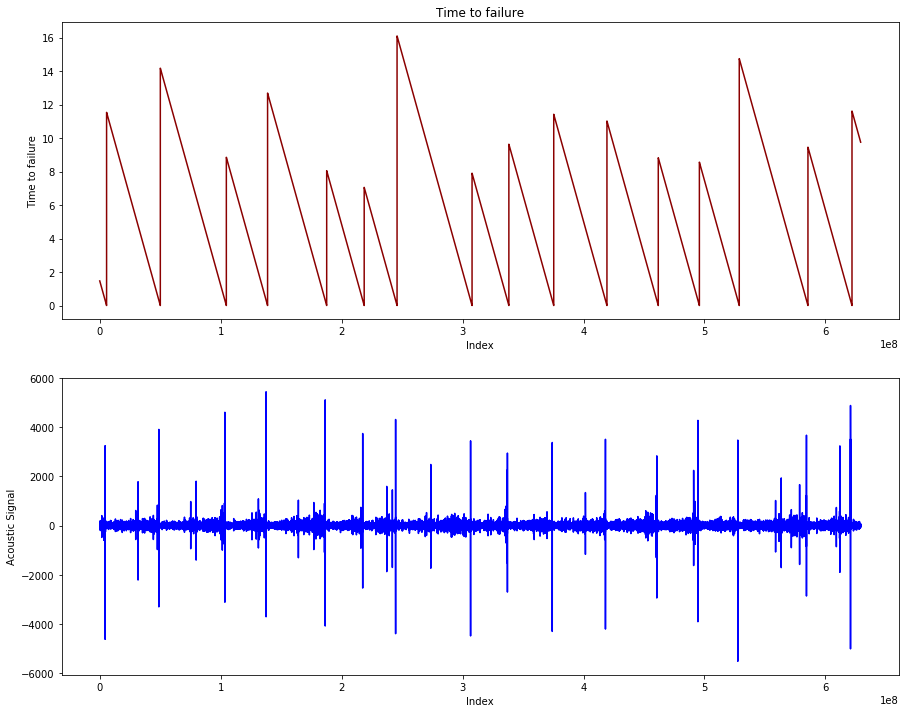

In [5]:
#plotting the train data
fig, ax = plt.subplots(2,1, figsize=(15,12))
ax[0].plot(train.index.values, train.time_to_failure.values, c="darkred")
ax[0].set_title("Time to failure")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Time to failure");
ax[1].plot(train.index.values, train.acoustic_data.values, c="blue")
#ax[1].set_title("Index")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Acoustic Signal")
plt.show()

It is given that the earthquake occurs when the time_to_failure hits 0, hence we can count that there are 16 occurences of earthquake in the whole training data

### Relationship between time to failure and acoustic data

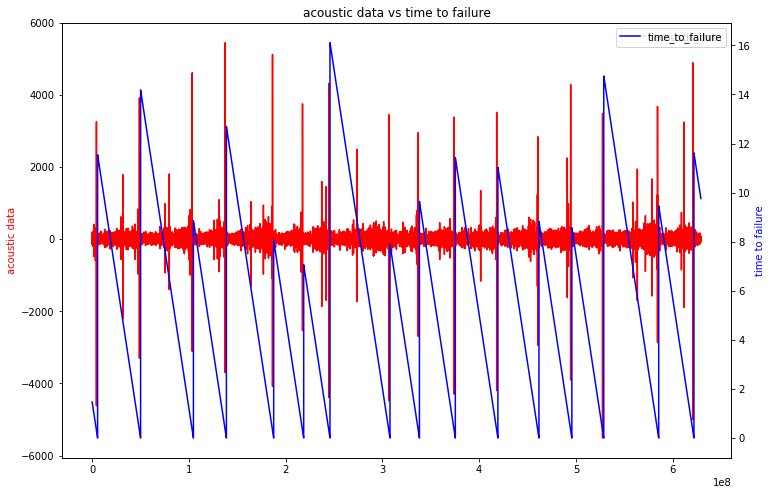

In [4]:
#plotting acoustic data vs time to failure
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.plot(train.acoustic_data,color='r')
plt.legend()
ax1.set_ylabel('acoustic data',color='r')
ax2=ax1.twinx()
ax2.set_ylabel('time to failure',color='b')
plt.plot(train.time_to_failure,color='b')
plt.title('acoustic data vs time to failure')
plt.legend()
plt.show()

The acoustic data has a peak just before time to failure hits zero. We can verify it by zooming into the plot.

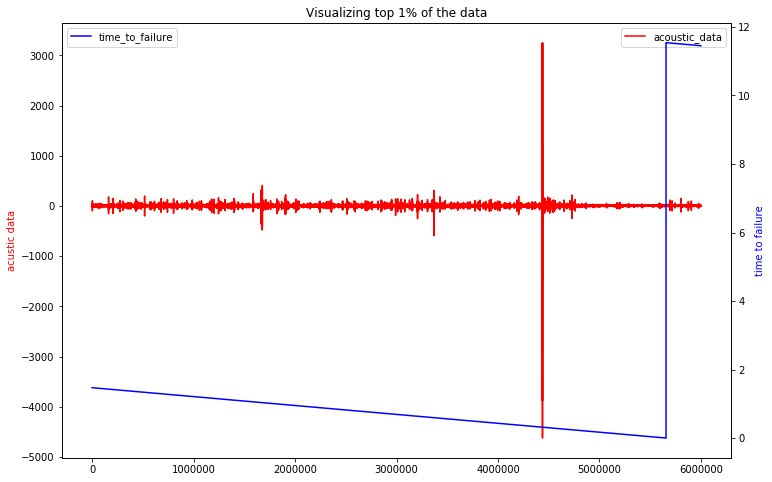

In [5]:
#plotting only top 1% of the value
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.plot(train.acoustic_data[0:6000000],color='r')
plt.legend()
ax1.set_ylabel('acustic data',color='r')
ax2=ax1.twinx()
ax2.set_ylabel('time to failure',color='b')
plt.plot(train.time_to_failure[0:6000000],color='b')
plt.title('Visualizing top 1% of the data')
plt.legend()
plt.show()

If we zoom into the data we can see that the acoustic data has a peak just before the earthquake occurs and the whole training data follows the same pattern

### Is time to failure continously Decreasing

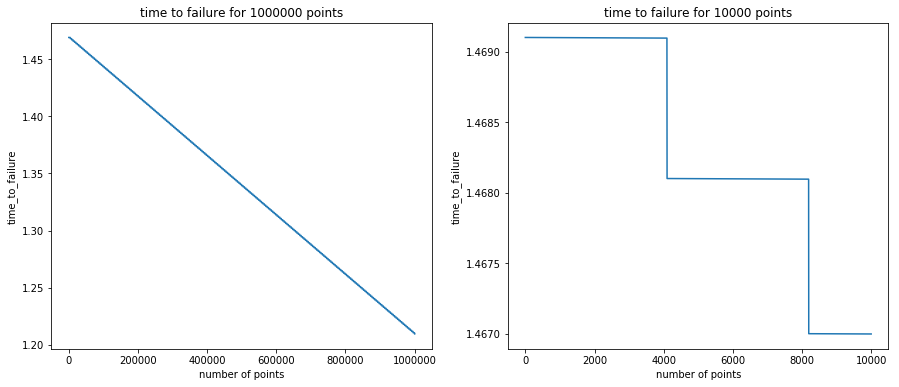

In [3]:
#plotting time to failure for fewer data
fig = plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)

plt.plot(train.time_to_failure[0:1000000])
plt.title('time to failure for 1000000 points')
plt.xlabel('number of points')
plt.ylabel('time_to_failure')
 
plt.subplot(1,2,2)
plt.plot(train.time_to_failure[0:10000])
plt.xlabel('number of points')
plt.ylabel('time_to_failure')
plt.title('time to failure for 10000 points')

plt.show()

If we plot the data for 1000000 points we can see that the graph is continously decreasing but if we zoom into it we can see that the time_to_failure stops decreasing for a while when it reaches ~4000 samples.
<br>
It is due to the fact that the data is recorded in bins of 4096 samples and the recording device stops for 12 microseconds after each bin.

### Visualizing Test Data

In [36]:
#Reading the test data
from tqdm.auto import tqdm
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
test = pd.DataFrame(dtype=np.float64, index=submission.index)
whole_test=[]
for seg_id in tqdm(test.index):
    seg = pd.read_csv('Untitled Folder/' + seg_id + '.csv')
    for i in seg['acoustic_data'].values:
        whole_test.append(i)

In [40]:
#total number of datapoints in test
len(whole_test)

393600000

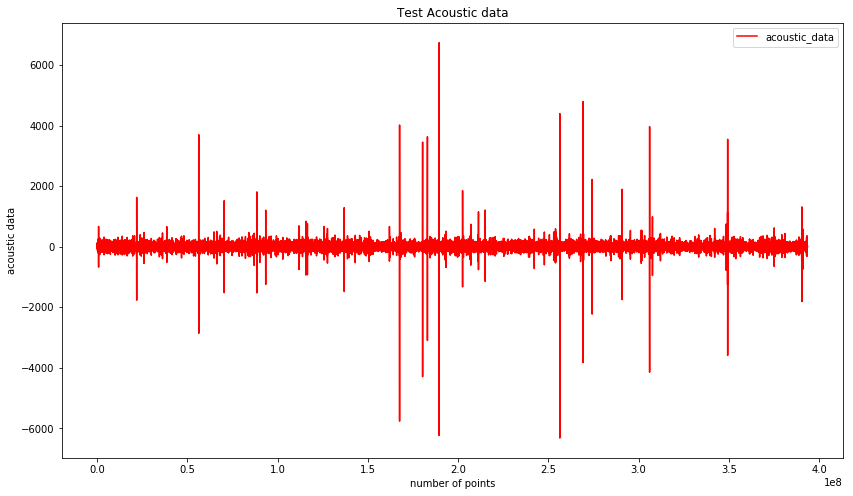

In [39]:
#plotting test data
fig = plt.figure(figsize=(14, 8))

plt.plot(whole_test,color='r',label='acoustic_data')
plt.title('Test Acoustic data')
plt.xlabel('number of points')
plt.ylabel('acoustic data')
plt.legend()
plt.show()
 

#### Checking for Null values

In [41]:
train.isnull().any().any()

False

There are no null values in the whole training data

# Featurization

### Feature set 1

In [2]:
OUTPUT_DIR = ''  # set for local environment
DATA_DIR = ''  # set for local environment

SIG_LEN = 150000
NUM_SEG_PER_PROC = 4000
NUM_THREADS = 6

NY_FREQ_IDX = 75000  # the test signals are 150k samples long, Nyquist is thus 75k.
CUTOFF = 18000
MAX_FREQ_IDX = 20000
FREQ_STEP = 2500

In [ ]:

# into 6 slices
def split_raw_data():
    df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

    max_start_index = len(df.index) - SIG_LEN
    slice_len = int(max_start_index / 6)

    for i in tqdm(range(NUM_THREADS)):
        print('working', i)
        df0 = df.iloc[slice_len * i: (slice_len * (i + 1)) + SIG_LEN]
        df0.to_csv(os.path.join(DATA_DIR, 'raw_data_%d.csv' % i), index=False)
        del df0

    del df

In [ ]:
#building random indices 
def build_rnd_idxs():
    rnd_idxs = np.zeros(shape=(NUM_THREADS, NUM_SEG_PER_PROC), dtype=np.int32)
    max_start_idx = 100000000

    for i in range(NUM_THREADS):
        np.random.seed(5591 + i)
        start_indices = np.random.randint(0, max_start_idx, size=NUM_SEG_PER_PROC, dtype=np.int32)
        rnd_idxs[i, :] = start_indices

    for i in range(NUM_THREADS):
        print(rnd_idxs[i, :8])
        print(rnd_idxs[i, -8:])
        print(min(rnd_idxs[i,:]), max(rnd_idxs[i,:]))

    np.savetxt(fname=os.path.join(OUTPUT_DIR, 'start_indices_4k.csv'), X=np.transpose(rnd_idxs), fmt='%d', delimiter=',')

In [5]:
#finding the slope 
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [6]:
def des_bw_filter_lp(cutoff=CUTOFF):  # low pass filter
    b, a = sg.butter(4, Wn=cutoff/NY_FREQ_IDX)
    return b, a

def des_bw_filter_hp(cutoff=CUTOFF):  # high pass filter
    b, a = sg.butter(4, Wn=cutoff/NY_FREQ_IDX, btype='highpass')
    return b, a

def des_bw_filter_bp(low, high):  # band pass filter
    b, a = sg.butter(4, Wn=(low/NY_FREQ_IDX, high/NY_FREQ_IDX), btype='bandpass')
    return b, a

In [4]:
# a function to create features
def create_features(seg_id, seg, X, st, end):
    try:
        X.loc[seg_id, 'seg_id'] = np.int32(seg_id)
        X.loc[seg_id, 'seg_start'] = np.int32(st)
        X.loc[seg_id, 'seg_end'] = np.int32(end)
    except:
        pass

    xc = pd.Series(seg['acoustic_data'].values)
    xcdm = xc - np.mean(xc)

    b, a = des_bw_filter_lp(cutoff=18000)
    xcz = sg.lfilter(b, a, xcdm)

    zc = np.fft.fft(xcz)
    zc = zc[:MAX_FREQ_IDX]

    # FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)

    freq_bands = [x for x in range(0, MAX_FREQ_IDX, FREQ_STEP)]
    magFFT = np.sqrt(realFFT ** 2 + imagFFT ** 2)
    phzFFT = np.arctan(imagFFT / realFFT)
    phzFFT[phzFFT == -np.inf] = -np.pi / 2.0
    phzFFT[phzFFT == np.inf] = np.pi / 2.0
    phzFFT = np.nan_to_num(phzFFT)

    for freq in freq_bands:
        X.loc[seg_id, 'FFT_Mag_01q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.01)
        X.loc[seg_id, 'FFT_Mag_10q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.1)
        X.loc[seg_id, 'FFT_Mag_90q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.9)
        X.loc[seg_id, 'FFT_Mag_99q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.99)
        X.loc[seg_id, 'FFT_Mag_mean%d' % freq] = np.mean(magFFT[freq: freq + FREQ_STEP])
        X.loc[seg_id, 'FFT_Mag_std%d' % freq] = np.std(magFFT[freq: freq + FREQ_STEP])
        X.loc[seg_id, 'FFT_Mag_max%d' % freq] = np.max(magFFT[freq: freq + FREQ_STEP])

        X.loc[seg_id, 'FFT_Phz_mean%d' % freq] = np.mean(phzFFT[freq: freq + FREQ_STEP])
        X.loc[seg_id, 'FFT_Phz_std%d' % freq] = np.std(phzFFT[freq: freq + FREQ_STEP])

    X.loc[seg_id, 'FFT_Rmean'] = realFFT.mean()
    X.loc[seg_id, 'FFT_Rstd'] = realFFT.std()
    X.loc[seg_id, 'FFT_Rmax'] = realFFT.max()
    X.loc[seg_id, 'FFT_Rmin'] = realFFT.min()
    X.loc[seg_id, 'FFT_Imean'] = imagFFT.mean()
    X.loc[seg_id, 'FFT_Istd'] = imagFFT.std()
    X.loc[seg_id, 'FFT_Imax'] = imagFFT.max()
    X.loc[seg_id, 'FFT_Imin'] = imagFFT.min()

    X.loc[seg_id, 'FFT_Rmean_first_6000'] = realFFT[:6000].mean()
    X.loc[seg_id, 'FFT_Rstd__first_6000'] = realFFT[:6000].std()
    X.loc[seg_id, 'FFT_Rmax_first_6000'] = realFFT[:6000].max()
    X.loc[seg_id, 'FFT_Rmin_first_6000'] = realFFT[:6000].min()
    X.loc[seg_id, 'FFT_Rmean_first_18000'] = realFFT[:18000].mean()
    X.loc[seg_id, 'FFT_Rstd_first_18000'] = realFFT[:18000].std()
    X.loc[seg_id, 'FFT_Rmax_first_18000'] = realFFT[:18000].max()
    X.loc[seg_id, 'FFT_Rmin_first_18000'] = realFFT[:18000].min()

    del xcz
    del zc

    b, a = des_bw_filter_lp(cutoff=2500)
    xc0 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=2500, high=5000)
    xc1 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=5000, high=7500)
    xc2 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=7500, high=10000)
    xc3 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=10000, high=12500)
    xc4 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=12500, high=15000)
    xc5 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=15000, high=17500)
    xc6 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=17500, high=20000)
    xc7 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_hp(cutoff=20000)
    xc8 = sg.lfilter(b, a, xcdm)

    sigs = [xc, pd.Series(xc0), pd.Series(xc1), pd.Series(xc2), pd.Series(xc3),
            pd.Series(xc4), pd.Series(xc5), pd.Series(xc6), pd.Series(xc7), pd.Series(xc8)]

    for i, sig in enumerate(sigs):
        X.loc[seg_id, 'mean_%d' % i] = sig.mean()
        X.loc[seg_id, 'std_%d' % i] = sig.std()
        X.loc[seg_id, 'max_%d' % i] = sig.max()
        X.loc[seg_id, 'min_%d' % i] = sig.min()

        X.loc[seg_id, 'mean_change_abs_%d' % i] = np.mean(np.diff(sig))
        X.loc[seg_id, 'mean_change_rate_%d' % i] = np.mean(np.nonzero((np.diff(sig) / sig[:-1]))[0])
        X.loc[seg_id, 'abs_max_%d' % i] = np.abs(sig).max()
        X.loc[seg_id, 'abs_min_%d' % i] = np.abs(sig).min()

        X.loc[seg_id, 'std_first_50000_%d' % i] = sig[:50000].std()
        X.loc[seg_id, 'std_last_50000_%d' % i] = sig[-50000:].std()
        X.loc[seg_id, 'std_first_10000_%d' % i] = sig[:10000].std()
        X.loc[seg_id, 'std_last_10000_%d' % i] = sig[-10000:].std()

        X.loc[seg_id, 'avg_first_50000_%d' % i] = sig[:50000].mean()
        X.loc[seg_id, 'avg_last_50000_%d' % i] = sig[-50000:].mean()
        X.loc[seg_id, 'avg_first_10000_%d' % i] = sig[:10000].mean()
        X.loc[seg_id, 'avg_last_10000_%d' % i] = sig[-10000:].mean()

        X.loc[seg_id, 'min_first_50000_%d' % i] = sig[:50000].min()
        X.loc[seg_id, 'min_last_50000_%d' % i] = sig[-50000:].min()
        X.loc[seg_id, 'min_first_10000_%d' % i] = sig[:10000].min()
        X.loc[seg_id, 'min_last_10000_%d' % i] = sig[-10000:].min()

        X.loc[seg_id, 'max_first_50000_%d' % i] = sig[:50000].max()
        X.loc[seg_id, 'max_last_50000_%d' % i] = sig[-50000:].max()
        X.loc[seg_id, 'max_first_10000_%d' % i] = sig[:10000].max()
        X.loc[seg_id, 'max_last_10000_%d' % i] = sig[-10000:].max()

        X.loc[seg_id, 'max_to_min_%d' % i] = sig.max() / np.abs(sig.min())
        X.loc[seg_id, 'max_to_min_diff_%d' % i] = sig.max() - np.abs(sig.min())
        X.loc[seg_id, 'count_big_%d' % i] = len(sig[np.abs(sig) > 500])
        X.loc[seg_id, 'sum_%d' % i] = sig.sum()

        X.loc[seg_id, 'mean_change_rate_first_50000_%d' % i] = np.mean(np.nonzero((np.diff(sig[:50000]) / sig[:50000][:-1]))[0])
        X.loc[seg_id, 'mean_change_rate_last_50000_%d' % i] = np.mean(np.nonzero((np.diff(sig[-50000:]) / sig[-50000:][:-1]))[0])
        X.loc[seg_id, 'mean_change_rate_first_10000_%d' % i] = np.mean(np.nonzero((np.diff(sig[:10000]) / sig[:10000][:-1]))[0])
        X.loc[seg_id, 'mean_change_rate_last_10000_%d' % i] = np.mean(np.nonzero((np.diff(sig[-10000:]) / sig[-10000:][:-1]))[0])

        X.loc[seg_id, 'q95_%d' % i] = np.quantile(sig, 0.95)
        X.loc[seg_id, 'q99_%d' % i] = np.quantile(sig, 0.99)
        X.loc[seg_id, 'q05_%d' % i] = np.quantile(sig, 0.05)
        X.loc[seg_id, 'q01_%d' % i] = np.quantile(sig, 0.01)

        X.loc[seg_id, 'abs_q95_%d' % i] = np.quantile(np.abs(sig), 0.95)
        X.loc[seg_id, 'abs_q99_%d' % i] = np.quantile(np.abs(sig), 0.99)
        X.loc[seg_id, 'abs_q05_%d' % i] = np.quantile(np.abs(sig), 0.05)
        X.loc[seg_id, 'abs_q01_%d' % i] = np.quantile(np.abs(sig), 0.01)

        X.loc[seg_id, 'trend_%d' % i] = add_trend_feature(sig)
        X.loc[seg_id, 'abs_trend_%d' % i] = add_trend_feature(sig, abs_values=True)
        X.loc[seg_id, 'abs_mean_%d' % i] = np.abs(sig).mean()
        X.loc[seg_id, 'abs_std_%d' % i] = np.abs(sig).std()

        X.loc[seg_id, 'mad_%d' % i] = sig.mad()
        X.loc[seg_id, 'kurt_%d' % i] = sig.kurtosis()
        X.loc[seg_id, 'skew_%d' % i] = sig.skew()
        X.loc[seg_id, 'med_%d' % i] = sig.median()

        X.loc[seg_id, 'Hilbert_mean_%d' % i] = np.abs(hilbert(sig)).mean()
        X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()

        X.loc[seg_id, 'classic_sta_lta1_mean_%d' % i] = classic_sta_lta(sig, 500, 10000).mean()
        X.loc[seg_id, 'classic_sta_lta2_mean_%d' % i] = classic_sta_lta(sig, 5000, 100000).mean()
        X.loc[seg_id, 'classic_sta_lta3_mean_%d' % i] = classic_sta_lta(sig, 3333, 6666).mean()
        X.loc[seg_id, 'classic_sta_lta4_mean_%d' % i] = classic_sta_lta(sig, 10000, 25000).mean()

        X.loc[seg_id, 'Moving_average_700_mean_%d' % i] = sig.rolling(window=700).mean().mean(skipna=True)
        X.loc[seg_id, 'Moving_average_1500_mean_%d' % i] = sig.rolling(window=1500).mean().mean(skipna=True)
        X.loc[seg_id, 'Moving_average_3000_mean_%d' % i] = sig.rolling(window=3000).mean().mean(skipna=True)
        X.loc[seg_id, 'Moving_average_6000_mean_%d' % i] = sig.rolling(window=6000).mean().mean(skipna=True)

        ewma = pd.Series.ewm
        X.loc[seg_id, 'exp_Moving_average_300_mean_%d' % i] = ewma(sig, span=300).mean().mean(skipna=True)
        X.loc[seg_id, 'exp_Moving_average_3000_mean_%d' % i] = ewma(sig, span=3000).mean().mean(skipna=True)
        X.loc[seg_id, 'exp_Moving_average_30000_mean_%d' % i] = ewma(sig, span=6000).mean().mean(skipna=True)

        no_of_std = 2
        X.loc[seg_id, 'MA_700MA_std_mean_%d' % i] = sig.rolling(window=700).std().mean()
        X.loc[seg_id, 'MA_700MA_BB_high_mean_%d' % i] = (
                    X.loc[seg_id, 'Moving_average_700_mean_%d' % i] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean_%d' % i]).mean()
        X.loc[seg_id, 'MA_700MA_BB_low_mean_%d' % i] = (
                    X.loc[seg_id, 'Moving_average_700_mean_%d' % i] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean_%d' % i]).mean()
        X.loc[seg_id, 'MA_400MA_std_mean_%d' % i] = sig.rolling(window=400).std().mean()
        X.loc[seg_id, 'MA_400MA_BB_high_mean_%d' % i] = (
                    X.loc[seg_id, 'Moving_average_700_mean_%d' % i] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean_%d' % i]).mean()
        X.loc[seg_id, 'MA_400MA_BB_low_mean_%d' % i] = (
                    X.loc[seg_id, 'Moving_average_700_mean_%d' % i] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean_%d' % i]).mean()
        X.loc[seg_id, 'MA_1000MA_std_mean_%d' % i] = sig.rolling(window=1000).std().mean()

        X.loc[seg_id, 'iqr_%d' % i] = np.subtract(*np.percentile(sig, [75, 25]))
        X.loc[seg_id, 'q999_%d' % i] = np.quantile(sig, 0.999)
        X.loc[seg_id, 'q001_%d' % i] = np.quantile(sig, 0.001)
        X.loc[seg_id, 'ave10_%d' % i] = stats.trim_mean(sig, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values

        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(
            np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()

        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(
            np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

    return X

In [8]:

def build_fields(proc_id):
    success = 1
    count = 0
    try:
        seg_st = int(NUM_SEG_PER_PROC * proc_id)
        train_df = pd.read_csv(os.path.join(DATA_DIR, 'raw_data_%d.csv' % proc_id), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
        len_df = len(train_df.index)
        start_indices = (np.loadtxt(fname=os.path.join(OUTPUT_DIR, 'start_indices_4k.csv'), dtype=np.int32, delimiter=','))[:, proc_id]
        train_X = pd.DataFrame(dtype=np.float64)
        train_y = pd.DataFrame(dtype=np.float64, columns=['time_to_failure'])
        t0 = time.time()

        for seg_id, start_idx in zip(range(seg_st, seg_st + NUM_SEG_PER_PROC), start_indices):
            end_idx = np.int32(start_idx + 150000)
            print('working: %d, %d, %d to %d of %d' % (proc_id, seg_id, start_idx, end_idx, len_df))
            seg = train_df.iloc[start_idx: end_idx]
            # train_X = create_features_pk_det(seg_id, seg, train_X, start_idx, end_idx)
            train_X = create_features(seg_id, seg, train_X, start_idx, end_idx)
            train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

            if count == 10: 
                print('saving: %d, %d to %d' % (seg_id, start_idx, end_idx))
                train_X.to_csv('train_x_%d.csv' % proc_id, index=False)
                train_y.to_csv('train_y_%d.csv' % proc_id, index=False)

            count += 1

        print('final_save, process id: %d, loop time: %.2f for %d iterations' % (proc_id, time.time() - t0, count))
        train_X.to_csv(os.path.join(OUTPUT_DIR, 'train_x_%d.csv' % proc_id), index=False)
        train_y.to_csv(os.path.join(OUTPUT_DIR, 'train_y_%d.csv' % proc_id), index=False)

    except:
        print(traceback.format_exc())
        success = 0

    return success  # 1 on success, 0 if fail

In [9]:
#for multiprocessing
def run_mp_build():
    t0 = time.time()
    num_proc = NUM_THREADS
    pool = mp.Pool(processes=num_proc)
    results = [pool.apply_async(build_fields, args=(pid, )) for pid in range(NUM_THREADS)]
    output = [p.get() for p in results]
    num_built = sum(output)
    pool.close()
    pool.join()
    print(num_built)
    print('Run time: %.2f' % (time.time() - t0))

In [10]:
def join_mp_build():
    df0 = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_x_%d.csv' % 0))
    df1 = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_y_%d.csv' % 0))

    for i in range(1, NUM_THREADS):
        print('working %d' % i)
        temp = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_x_%d.csv' % i))
        df0 = df0.append(temp)

        temp = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_y_%d.csv' % i))
        df1 = df1.append(temp)

    df0.to_csv(os.path.join(OUTPUT_DIR, 'train_x.csv'), index=False)
    df1.to_csv(os.path.join(OUTPUT_DIR, 'train_y.csv'), index=False)

In [11]:

from tqdm.auto import tqdm
def build_test_fields():
    train_X = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_x.csv'))
    try:
        train_X.drop(labels=['seg_id', 'seg_start', 'seg_end'], axis=1, inplace=True)
    except:
        pass

    submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'), index_col='seg_id')
    test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

    print('start for loop')
    count = 0
    for seg_id in tqdm(test_X.index):  # just tqdm in IDE
        seg = pd.read_csv(os.path.join(DATA_DIR, 'Untitled Folder/', str(seg_id) + '.csv'))
        # train_X = create_features_pk_det(seg_id, seg, train_X, start_idx, end_idx)
        test_X = create_features(seg_id, seg, test_X, 0, 0)

        if count % 100 == 0:
            print('working', seg_id)
        count += 1

    test_X.to_csv(os.path.join(OUTPUT_DIR, 'test_x.csv'), index=False)

In [12]:
#standardization
def scale_fields(fn_train='train_x.csv', fn_test='test_x.csv', 
                 fn_out_train='scaled_train_X.csv' , fn_out_test='scaled_test_X.csv'):
    train_X = pd.read_csv(os.path.join(OUTPUT_DIR, fn_train))
    try:
        train_X.drop(labels=['seg_id', 'seg_start', 'seg_end'], axis=1, inplace=True)
    except:
        pass
    test_X = pd.read_csv(os.path.join(OUTPUT_DIR, fn_test))

    print('start scaler')
    scaler = StandardScaler()
    scaler.fit(train_X)
    scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
    scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

    scaled_train_X.to_csv(os.path.join(OUTPUT_DIR, fn_out_train), index=False)
    scaled_test_X.to_csv(os.path.join(OUTPUT_DIR, fn_out_test), index=False)

In [ ]:
split_raw_data()

In [20]:
build_rnd_idxs()

[10804991 40754581 61152051 51046969 26130885 37920772 36775305  7675825]
[68761251 51632120 86559696 90282599 60663556 85061082 95027462 23825753]
67619 99994297
[16837712 49519822 86613139  3210689 98148542 31101347  1090339 72122324]
[79426720 43809532 43249236 23265647 44502411 86787131 90136975 34661131]
26666 99956067
[63044133  2442657 90777691 16268569 63311688 90814034 75756302 37813113]
[91763196  7353084 29675563 12721978 64093656 39100415  2453472 56466376]
19628 99986179
[61673177 33536021 43935586 94121751  3158245 18377637 64912898 52164547]
[98328338 73239137 19836471 25502780 59800782 58627599 55588218 24985417]
2272 99981324
[59879818 56182569 67051701 16143352 53734196 57460600 55941981 67579513]
[11170509 67106840 93093344  4809245 73117841 87221360   829083 51383467]
26823 99942141
[26548514  5175447 39498226 33934210 76764021 34939489 82316461 79515410]
[67651567 76925054 97654318 99863711 49392180 70557795 10896601 75562170]
71058 99981201


In [29]:
run_mp_build()

working: 3, 12000, 61673177 to 61823177 of 104982580
working: 1, 4000, 16837712 to 16987712 of 104982580
working: 0, 0, 10804991 to 10954991 of 104982580
working: 4, 16000, 59879818 to 60029818 of 104982580
working: 5, 20000, 26548514 to 26698514 of 104982580
working: 2, 8000, 63044133 to 63194133 of 104982580
working: 3, 12001, 33536021 to 33686021 of 104982580
working: 1, 4001, 49519822 to 49669822 of 104982580
working: 5, 20001, 5175447 to 5325447 of 104982580
working: 0, 1, 40754581 to 40904581 of 104982580
working: 2, 8001, 2442657 to 2592657 of 104982580
working: 4, 16001, 56182569 to 56332569 of 104982580
working: 3, 12002, 43935586 to 44085586 of 104982580
working: 1, 4002, 86613139 to 86763139 of 104982580
working: 5, 20002, 39498226 to 39648226 of 104982580
working: 0, 2, 61152051 to 61302051 of 104982580
working: 2, 8002, 90777691 to 90927691 of 104982580
working: 4, 16002, 67051701 to 67201701 of 104982580
working: 3, 12003, 94121751 to 94271751 of 104982580
working: 2, 800

working: 2, 8025, 65452522 to 65602522 of 104982580
working: 5, 20025, 13548139 to 13698139 of 104982580
working: 4, 16026, 87503000 to 87653000 of 104982580
working: 0, 26, 88324282 to 88474282 of 104982580
working: 3, 12026, 93602294 to 93752294 of 104982580
working: 1, 4026, 85769597 to 85919597 of 104982580
working: 2, 8026, 54735151 to 54885151 of 104982580
working: 5, 20026, 45018896 to 45168896 of 104982580
working: 4, 16027, 1175346 to 1325346 of 104982580
working: 0, 27, 17558860 to 17708860 of 104982580
working: 3, 12027, 970456 to 1120456 of 104982580
working: 1, 4027, 20602319 to 20752319 of 104982580
working: 2, 8027, 52611624 to 52761624 of 104982580
working: 5, 20027, 93343059 to 93493059 of 104982580
working: 0, 28, 80902703 to 81052703 of 104982580
working: 4, 16028, 78215847 to 78365847 of 104982580
working: 3, 12028, 74347879 to 74497879 of 104982580
working: 1, 4028, 91629281 to 91779281 of 104982580
working: 5, 20028, 75285126 to 75435126 of 104982580
working: 2, 8

working: 1, 4052, 44153386 to 44303386 of 104982580
working: 0, 52, 79408705 to 79558705 of 104982580
working: 4, 16052, 89759420 to 89909420 of 104982580
working: 5, 20052, 84591472 to 84741472 of 104982580
working: 2, 8052, 37025215 to 37175215 of 104982580
working: 3, 12052, 6798341 to 6948341 of 104982580
working: 1, 4053, 83230960 to 83380960 of 104982580
working: 0, 53, 51976650 to 52126650 of 104982580
working: 4, 16053, 11828790 to 11978790 of 104982580
working: 5, 20053, 23758640 to 23908640 of 104982580
working: 2, 8053, 33492137 to 33642137 of 104982580
working: 3, 12053, 97795329 to 97945329 of 104982580
working: 1, 4054, 65714363 to 65864363 of 104982580
working: 0, 54, 18321315 to 18471315 of 104982580
working: 4, 16054, 30335452 to 30485452 of 104982580
working: 5, 20054, 13373529 to 13523529 of 104982580
working: 2, 8054, 77626375 to 77776375 of 104982580
working: 3, 12054, 34542466 to 34692466 of 104982580
working: 1, 4055, 41980446 to 42130446 of 104982580
working: 0,

working: 4, 16078, 95885231 to 96035231 of 104982580
working: 3, 12078, 17589304 to 17739304 of 104982580
working: 2, 8078, 90854568 to 91004568 of 104982580
working: 5, 20078, 21834420 to 21984420 of 104982580
working: 0, 79, 24826719 to 24976719 of 104982580
working: 1, 4079, 39648374 to 39798374 of 104982580
working: 4, 16079, 84187782 to 84337782 of 104982580
working: 3, 12079, 44330301 to 44480301 of 104982580
working: 2, 8079, 75051213 to 75201213 of 104982580
working: 5, 20079, 75106176 to 75256176 of 104982580
working: 0, 80, 90113075 to 90263075 of 104982580
working: 1, 4080, 81856714 to 82006714 of 104982580
working: 4, 16080, 43702021 to 43852021 of 104982580
working: 3, 12080, 96783710 to 96933710 of 104982580
working: 2, 8080, 27925248 to 28075248 of 104982580
working: 5, 20080, 39372150 to 39522150 of 104982580
working: 0, 81, 122470 to 272470 of 104982580
working: 1, 4081, 35315082 to 35465082 of 104982580
working: 4, 16081, 88880550 to 89030550 of 104982580
working: 3, 

working: 2, 8104, 81467598 to 81617598 of 104982580
working: 5, 20104, 86119955 to 86269955 of 104982580
working: 1, 4105, 71864291 to 72014291 of 104982580
working: 4, 16105, 15574598 to 15724598 of 104982580
working: 0, 105, 46925380 to 47075380 of 104982580
working: 3, 12105, 38659720 to 38809720 of 104982580
working: 2, 8105, 21338888 to 21488888 of 104982580
working: 5, 20105, 12392134 to 12542134 of 104982580
working: 1, 4106, 5624557 to 5774557 of 104982580
working: 4, 16106, 49666660 to 49816660 of 104982580
working: 0, 106, 12417546 to 12567546 of 104982580
working: 3, 12106, 40439643 to 40589643 of 104982580
working: 2, 8106, 51343041 to 51493041 of 104982580
working: 5, 20106, 33601152 to 33751152 of 104982580
working: 1, 4107, 47147642 to 47297642 of 104982580
working: 4, 16107, 23412588 to 23562588 of 104982580
working: 0, 107, 83302223 to 83452223 of 104982580
working: 3, 12107, 75910558 to 76060558 of 104982580
working: 2, 8107, 1194254 to 1344254 of 104982580
working: 5

working: 4, 16131, 21595450 to 21745450 of 104982580
working: 1, 4131, 71271771 to 71421771 of 104982580
working: 5, 20130, 68907217 to 69057217 of 104982580
working: 0, 131, 34054951 to 34204951 of 104982580
working: 3, 12131, 17561840 to 17711840 of 104982580
working: 2, 8131, 95385085 to 95535085 of 104982580
working: 1, 4132, 79660560 to 79810560 of 104982580
working: 4, 16132, 49159709 to 49309709 of 104982580
working: 5, 20131, 48435631 to 48585631 of 104982580
working: 0, 132, 65394570 to 65544570 of 104982580
working: 3, 12132, 9312750 to 9462750 of 104982580
working: 2, 8132, 10679207 to 10829207 of 104982580
working: 1, 4133, 64345318 to 64495318 of 104982580
working: 4, 16133, 98701304 to 98851304 of 104982580
working: 5, 20132, 26676147 to 26826147 of 104982580
working: 0, 133, 59898313 to 60048313 of 104982580
working: 3, 12133, 77140720 to 77290720 of 104982580
working: 2, 8133, 68953104 to 69103104 of 104982580
working: 1, 4134, 88100936 to 88250936 of 104982580
working:

working: 5, 20156, 58375236 to 58525236 of 104982580
working: 0, 157, 76618618 to 76768618 of 104982580
working: 3, 12157, 88389489 to 88539489 of 104982580
working: 2, 8157, 6086845 to 6236845 of 104982580
working: 1, 4158, 55050507 to 55200507 of 104982580
working: 4, 16158, 92722008 to 92872008 of 104982580
working: 5, 20157, 19207302 to 19357302 of 104982580
working: 0, 158, 90167035 to 90317035 of 104982580
working: 3, 12158, 66176697 to 66326697 of 104982580
working: 2, 8158, 86470074 to 86620074 of 104982580
working: 1, 4159, 41789501 to 41939501 of 104982580
working: 4, 16159, 99063736 to 99213736 of 104982580
working: 5, 20158, 94073791 to 94223791 of 104982580
working: 0, 159, 81393775 to 81543775 of 104982580
working: 3, 12159, 82412522 to 82562522 of 104982580
working: 2, 8159, 56744045 to 56894045 of 104982580
working: 1, 4160, 52652664 to 52802664 of 104982580
working: 4, 16160, 79727765 to 79877765 of 104982580
working: 5, 20159, 7924554 to 8074554 of 104982580
working: 

working: 3, 12183, 50362167 to 50512167 of 104982580
working: 2, 8183, 13226343 to 13376343 of 104982580
working: 1, 4184, 49134022 to 49284022 of 104982580
working: 4, 16184, 36771416 to 36921416 of 104982580
working: 5, 20183, 52748342 to 52898342 of 104982580
working: 0, 184, 69462926 to 69612926 of 104982580
working: 3, 12184, 32489275 to 32639275 of 104982580
working: 2, 8184, 43242287 to 43392287 of 104982580
working: 1, 4185, 55644423 to 55794423 of 104982580
working: 4, 16185, 94130126 to 94280126 of 104982580
working: 5, 20184, 22588855 to 22738855 of 104982580
working: 0, 185, 50745332 to 50895332 of 104982580
working: 3, 12185, 27397228 to 27547228 of 104982580
working: 2, 8185, 31173691 to 31323691 of 104982580
working: 1, 4186, 26187215 to 26337215 of 104982580
working: 4, 16186, 58763601 to 58913601 of 104982580
working: 5, 20185, 27097483 to 27247483 of 104982580
working: 0, 186, 83792918 to 83942918 of 104982580
working: 3, 12186, 34191301 to 34341301 of 104982580
worki

working: 2, 8209, 35797629 to 35947629 of 104982580
working: 4, 16210, 25398401 to 25548401 of 104982580
working: 5, 20209, 70192753 to 70342753 of 104982580
working: 0, 210, 57976991 to 58126991 of 104982580
working: 3, 12210, 51515646 to 51665646 of 104982580
working: 1, 4211, 57766758 to 57916758 of 104982580
working: 2, 8210, 70857043 to 71007043 of 104982580
working: 4, 16211, 54269678 to 54419678 of 104982580
working: 5, 20210, 94853844 to 95003844 of 104982580
working: 0, 211, 90667165 to 90817165 of 104982580
working: 3, 12211, 45968478 to 46118478 of 104982580
working: 1, 4212, 55839075 to 55989075 of 104982580
working: 2, 8211, 35862246 to 36012246 of 104982580
working: 4, 16212, 93349746 to 93499746 of 104982580
working: 5, 20211, 33100415 to 33250415 of 104982580
working: 0, 212, 83270733 to 83420733 of 104982580
working: 3, 12212, 20992399 to 21142399 of 104982580
working: 1, 4213, 65558545 to 65708545 of 104982580
working: 2, 8212, 58800010 to 58950010 of 104982580
workin

working: 5, 20235, 27260635 to 27410635 of 104982580
working: 0, 236, 96626422 to 96776422 of 104982580
working: 3, 12236, 84390023 to 84540023 of 104982580
working: 1, 4237, 86571011 to 86721011 of 104982580
working: 4, 16237, 4960348 to 5110348 of 104982580
working: 2, 8236, 48184917 to 48334917 of 104982580
working: 5, 20236, 16470425 to 16620425 of 104982580
working: 0, 237, 64795430 to 64945430 of 104982580
working: 3, 12237, 21250466 to 21400466 of 104982580
working: 1, 4238, 91700787 to 91850787 of 104982580
working: 4, 16238, 80849090 to 80999090 of 104982580
working: 2, 8237, 3149592 to 3299592 of 104982580
working: 5, 20237, 79842398 to 79992398 of 104982580
working: 0, 238, 90601407 to 90751407 of 104982580
working: 3, 12238, 97074163 to 97224163 of 104982580
working: 1, 4239, 70130235 to 70280235 of 104982580
working: 4, 16239, 25664832 to 25814832 of 104982580
working: 2, 8238, 44903611 to 45053611 of 104982580
working: 5, 20238, 15567245 to 15717245 of 104982580
working: 

working: 3, 12262, 32710074 to 32860074 of 104982580
working: 1, 4263, 46629594 to 46779594 of 104982580
working: 4, 16263, 28527105 to 28677105 of 104982580
working: 2, 8262, 56524211 to 56674211 of 104982580
working: 5, 20262, 15988608 to 16138608 of 104982580
working: 0, 263, 33626198 to 33776198 of 104982580
working: 3, 12263, 46010136 to 46160136 of 104982580
working: 1, 4264, 49412740 to 49562740 of 104982580
working: 4, 16264, 19852154 to 20002154 of 104982580
working: 2, 8263, 20756865 to 20906865 of 104982580
working: 5, 20263, 15579659 to 15729659 of 104982580
working: 0, 264, 61113051 to 61263051 of 104982580
working: 3, 12264, 42901341 to 43051341 of 104982580
working: 1, 4265, 15235716 to 15385716 of 104982580
working: 4, 16265, 5566267 to 5716267 of 104982580
working: 2, 8264, 99233170 to 99383170 of 104982580
working: 5, 20264, 19833861 to 19983861 of 104982580
working: 0, 265, 41273615 to 41423615 of 104982580
working: 3, 12265, 82218724 to 82368724 of 104982580
working

working: 4, 16289, 48719406 to 48869406 of 104982580
working: 2, 8288, 44123050 to 44273050 of 104982580
working: 5, 20288, 11893280 to 12043280 of 104982580
working: 0, 289, 11337767 to 11487767 of 104982580
working: 3, 12289, 30546088 to 30696088 of 104982580
working: 1, 4290, 54740177 to 54890177 of 104982580
working: 4, 16290, 3562831 to 3712831 of 104982580
working: 2, 8289, 40243794 to 40393794 of 104982580
working: 5, 20289, 2264283 to 2414283 of 104982580
working: 0, 290, 38868762 to 39018762 of 104982580
working: 3, 12290, 98835378 to 98985378 of 104982580
working: 1, 4291, 76029097 to 76179097 of 104982580
working: 4, 16291, 45727980 to 45877980 of 104982580
working: 2, 8290, 18001334 to 18151334 of 104982580
working: 5, 20290, 82980635 to 83130635 of 104982580
working: 0, 291, 34089420 to 34239420 of 104982580
working: 3, 12291, 28841884 to 28991884 of 104982580
working: 1, 4292, 29328973 to 29478973 of 104982580
working: 4, 16292, 32928855 to 33078855 of 104982580
working: 

working: 5, 20314, 96735560 to 96885560 of 104982580
working: 0, 315, 3274123 to 3424123 of 104982580
working: 3, 12315, 25321320 to 25471320 of 104982580
working: 1, 4316, 80053601 to 80203601 of 104982580
working: 4, 16316, 22799370 to 22949370 of 104982580
working: 2, 8315, 55795756 to 55945756 of 104982580
working: 5, 20315, 45838503 to 45988503 of 104982580
working: 0, 316, 63479191 to 63629191 of 104982580
working: 3, 12316, 67890978 to 68040978 of 104982580
working: 1, 4317, 78780182 to 78930182 of 104982580
working: 4, 16317, 9044791 to 9194791 of 104982580
working: 2, 8316, 37798212 to 37948212 of 104982580
working: 5, 20316, 47978820 to 48128820 of 104982580
working: 0, 317, 49210899 to 49360899 of 104982580
working: 3, 12317, 44075438 to 44225438 of 104982580
working: 1, 4318, 36129232 to 36279232 of 104982580
working: 4, 16318, 84639385 to 84789385 of 104982580
working: 2, 8317, 19284066 to 19434066 of 104982580
working: 5, 20317, 54528621 to 54678621 of 104982580
working: 

working: 3, 12341, 59834030 to 59984030 of 104982580
working: 1, 4342, 79789838 to 79939838 of 104982580
working: 4, 16342, 79315509 to 79465509 of 104982580
working: 2, 8341, 71465853 to 71615853 of 104982580
working: 0, 342, 58642540 to 58792540 of 104982580
working: 5, 20341, 67413402 to 67563402 of 104982580
working: 3, 12342, 59817098 to 59967098 of 104982580
working: 1, 4343, 4488756 to 4638756 of 104982580
working: 4, 16343, 6155069 to 6305069 of 104982580
working: 2, 8342, 50611263 to 50761263 of 104982580
working: 0, 343, 53804033 to 53954033 of 104982580
working: 5, 20342, 9095591 to 9245591 of 104982580
working: 3, 12343, 72134563 to 72284563 of 104982580
working: 1, 4344, 75922602 to 76072602 of 104982580
working: 4, 16344, 13242586 to 13392586 of 104982580
working: 2, 8343, 73244397 to 73394397 of 104982580
working: 0, 344, 88715314 to 88865314 of 104982580
working: 5, 20343, 73820600 to 73970600 of 104982580
working: 3, 12344, 26040358 to 26190358 of 104982580
working: 1,

working: 4, 16368, 97306684 to 97456684 of 104982580
working: 2, 8367, 87473374 to 87623374 of 104982580
working: 5, 20367, 17849656 to 17999656 of 104982580
working: 0, 368, 24151088 to 24301088 of 104982580
working: 3, 12368, 20521652 to 20671652 of 104982580
working: 1, 4369, 81403147 to 81553147 of 104982580
working: 4, 16369, 67983643 to 68133643 of 104982580
working: 2, 8368, 50872181 to 51022181 of 104982580
working: 5, 20368, 1368159 to 1518159 of 104982580
working: 0, 369, 61178183 to 61328183 of 104982580
working: 3, 12369, 63770503 to 63920503 of 104982580
working: 1, 4370, 17875912 to 18025912 of 104982580
working: 4, 16370, 71565082 to 71715082 of 104982580
working: 2, 8369, 53791991 to 53941991 of 104982580
working: 5, 20369, 18252328 to 18402328 of 104982580
working: 0, 370, 92583422 to 92733422 of 104982580
working: 3, 12370, 36720142 to 36870142 of 104982580
working: 1, 4371, 59797103 to 59947103 of 104982580
working: 4, 16371, 31366320 to 31516320 of 104982580
working

working: 0, 394, 38796406 to 38946406 of 104982580
working: 5, 20393, 28132776 to 28282776 of 104982580
working: 1, 4395, 53527343 to 53677343 of 104982580
working: 3, 12394, 43866433 to 44016433 of 104982580
working: 4, 16395, 52448156 to 52598156 of 104982580
working: 2, 8394, 40943818 to 41093818 of 104982580
working: 0, 395, 93308099 to 93458099 of 104982580
working: 5, 20394, 25134977 to 25284977 of 104982580
working: 3, 12395, 13537182 to 13687182 of 104982580
working: 1, 4396, 1427005 to 1577005 of 104982580
working: 4, 16396, 86792489 to 86942489 of 104982580
working: 2, 8395, 20473187 to 20623187 of 104982580
working: 0, 396, 77648459 to 77798459 of 104982580
working: 5, 20395, 66390843 to 66540843 of 104982580
working: 3, 12396, 26019362 to 26169362 of 104982580
working: 1, 4397, 10267422 to 10417422 of 104982580
working: 4, 16397, 50079242 to 50229242 of 104982580
working: 2, 8396, 18458199 to 18608199 of 104982580
working: 0, 397, 40522329 to 40672329 of 104982580
working: 

working: 1, 4421, 5612810 to 5762810 of 104982580
working: 3, 12420, 65140473 to 65290473 of 104982580
working: 4, 16421, 24681656 to 24831656 of 104982580
working: 2, 8420, 12232391 to 12382391 of 104982580
working: 0, 421, 17905977 to 18055977 of 104982580
working: 5, 20420, 75164260 to 75314260 of 104982580
working: 1, 4422, 55168867 to 55318867 of 104982580
working: 3, 12421, 56148500 to 56298500 of 104982580
working: 4, 16422, 45515236 to 45665236 of 104982580
working: 2, 8421, 25276213 to 25426213 of 104982580
working: 0, 422, 40401284 to 40551284 of 104982580
working: 5, 20421, 22548828 to 22698828 of 104982580
working: 1, 4423, 18076152 to 18226152 of 104982580
working: 3, 12422, 88767381 to 88917381 of 104982580
working: 4, 16423, 81956635 to 82106635 of 104982580
working: 2, 8422, 28480298 to 28630298 of 104982580
working: 0, 423, 75540837 to 75690837 of 104982580
working: 5, 20422, 36250420 to 36400420 of 104982580
working: 1, 4424, 41553480 to 41703480 of 104982580
working:

working: 4, 16447, 35185184 to 35335184 of 104982580
working: 2, 8446, 53383973 to 53533973 of 104982580
working: 0, 447, 51658767 to 51808767 of 104982580
working: 3, 12447, 10792838 to 10942838 of 104982580
working: 1, 4448, 51141867 to 51291867 of 104982580
working: 5, 20446, 57188252 to 57338252 of 104982580
working: 4, 16448, 54201775 to 54351775 of 104982580
working: 2, 8447, 93620768 to 93770768 of 104982580
working: 0, 448, 23352703 to 23502703 of 104982580
working: 3, 12448, 91505375 to 91655375 of 104982580
working: 5, 20447, 17940202 to 18090202 of 104982580
working: 1, 4449, 62400420 to 62550420 of 104982580
working: 4, 16449, 49205242 to 49355242 of 104982580
working: 2, 8448, 99349756 to 99499756 of 104982580
working: 3, 12449, 67896361 to 68046361 of 104982580
working: 0, 449, 57152938 to 57302938 of 104982580
working: 5, 20448, 96423949 to 96573949 of 104982580
working: 1, 4450, 54560046 to 54710046 of 104982580
working: 4, 16450, 3165768 to 3315768 of 104982580
working

working: 3, 12473, 72481021 to 72631021 of 104982580
working: 1, 4474, 66653807 to 66803807 of 104982580
working: 5, 20472, 26631305 to 26781305 of 104982580
working: 4, 16474, 78927220 to 79077220 of 104982580
working: 0, 473, 76813736 to 76963736 of 104982580
working: 2, 8473, 30731641 to 30881641 of 104982580
working: 3, 12474, 31049447 to 31199447 of 104982580
working: 5, 20473, 10675408 to 10825408 of 104982580
working: 1, 4475, 1712985 to 1862985 of 104982580
working: 4, 16475, 43140670 to 43290670 of 104982580
working: 0, 474, 48640027 to 48790027 of 104982580
working: 2, 8474, 80248855 to 80398855 of 104982580
working: 3, 12475, 80837156 to 80987156 of 104982580
working: 5, 20474, 28617316 to 28767316 of 104982580
working: 4, 16476, 76150152 to 76300152 of 104982580
working: 1, 4476, 86741205 to 86891205 of 104982580
working: 0, 475, 9170587 to 9320587 of 104982580
working: 2, 8475, 9651600 to 9801600 of 104982580
working: 3, 12476, 19772342 to 19922342 of 104982580
working: 5,

working: 0, 499, 81292444 to 81442444 of 104982580
working: 3, 12499, 76898966 to 77048966 of 104982580
working: 5, 20498, 14947971 to 15097971 of 104982580
working: 2, 8499, 73163508 to 73313508 of 104982580
working: 4, 16501, 73152054 to 73302054 of 104982580
working: 1, 4501, 18746831 to 18896831 of 104982580
working: 0, 500, 82672932 to 82822932 of 104982580
working: 3, 12500, 12938928 to 13088928 of 104982580
working: 5, 20499, 24397133 to 24547133 of 104982580
working: 2, 8500, 37122361 to 37272361 of 104982580
working: 4, 16502, 99427933 to 99577933 of 104982580
working: 1, 4502, 26570336 to 26720336 of 104982580
working: 0, 501, 3009472 to 3159472 of 104982580
working: 3, 12501, 40771739 to 40921739 of 104982580
working: 5, 20500, 40708067 to 40858067 of 104982580
working: 2, 8501, 98474012 to 98624012 of 104982580
working: 4, 16503, 2711196 to 2861196 of 104982580
working: 1, 4503, 37551297 to 37701297 of 104982580
working: 0, 502, 64335403 to 64485403 of 104982580
working: 3,

working: 5, 20524, 36200709 to 36350709 of 104982580
working: 2, 8525, 54811868 to 54961868 of 104982580
working: 4, 16527, 76662986 to 76812986 of 104982580
working: 1, 4527, 82856270 to 83006270 of 104982580
working: 3, 12526, 82441492 to 82591492 of 104982580
working: 0, 526, 96200481 to 96350481 of 104982580
working: 5, 20525, 26719111 to 26869111 of 104982580
working: 2, 8526, 42517690 to 42667690 of 104982580
working: 4, 16528, 37919077 to 38069077 of 104982580
working: 1, 4528, 67885982 to 68035982 of 104982580
working: 3, 12527, 8958060 to 9108060 of 104982580
working: 0, 527, 99307608 to 99457608 of 104982580
working: 5, 20526, 99981201 to 100131201 of 104982580
working: 2, 8527, 62753903 to 62903903 of 104982580
working: 4, 16529, 31591226 to 31741226 of 104982580
working: 1, 4529, 34963118 to 35113118 of 104982580
working: 3, 12528, 98060391 to 98210391 of 104982580
working: 0, 528, 86427670 to 86577670 of 104982580
working: 5, 20527, 28628143 to 28778143 of 104982580
workin

working: 4, 16553, 30287347 to 30437347 of 104982580
working: 1, 4553, 83615028 to 83765028 of 104982580
working: 3, 12552, 41735228 to 41885228 of 104982580
working: 5, 20551, 45355942 to 45505942 of 104982580
working: 0, 552, 6038638 to 6188638 of 104982580
working: 2, 8552, 2253341 to 2403341 of 104982580
working: 4, 16554, 63200479 to 63350479 of 104982580
working: 1, 4554, 64461434 to 64611434 of 104982580
working: 3, 12553, 39440004 to 39590004 of 104982580
working: 5, 20552, 36514428 to 36664428 of 104982580
working: 0, 553, 31718648 to 31868648 of 104982580
working: 2, 8553, 50478609 to 50628609 of 104982580
working: 4, 16555, 5789578 to 5939578 of 104982580
working: 1, 4555, 27055592 to 27205592 of 104982580
working: 3, 12554, 21397161 to 21547161 of 104982580
working: 5, 20553, 96824544 to 96974544 of 104982580
working: 0, 554, 30834033 to 30984033 of 104982580
working: 2, 8554, 14542005 to 14692005 of 104982580
working: 4, 16556, 44639722 to 44789722 of 104982580
working: 1,

working: 1, 4579, 81574751 to 81724751 of 104982580
working: 5, 20577, 88407916 to 88557916 of 104982580
working: 0, 578, 42276439 to 42426439 of 104982580
working: 2, 8578, 61965030 to 62115030 of 104982580
working: 4, 16580, 43589686 to 43739686 of 104982580
working: 3, 12579, 24647170 to 24797170 of 104982580
working: 5, 20578, 22359765 to 22509765 of 104982580
working: 1, 4580, 13626952 to 13776952 of 104982580
working: 0, 579, 83556903 to 83706903 of 104982580
working: 2, 8579, 78090895 to 78240895 of 104982580
working: 4, 16581, 63558706 to 63708706 of 104982580
working: 3, 12580, 56590035 to 56740035 of 104982580
working: 5, 20579, 6737204 to 6887204 of 104982580
working: 1, 4581, 52344014 to 52494014 of 104982580
working: 0, 580, 11636633 to 11786633 of 104982580
working: 2, 8580, 85534699 to 85684699 of 104982580
working: 4, 16582, 38375501 to 38525501 of 104982580
working: 3, 12581, 24886671 to 25036671 of 104982580
working: 5, 20580, 9159492 to 9309492 of 104982580
working: 

working: 0, 604, 58192588 to 58342588 of 104982580
working: 2, 8604, 45431808 to 45581808 of 104982580
working: 4, 16606, 96192930 to 96342930 of 104982580
working: 5, 20604, 81547646 to 81697646 of 104982580
working: 3, 12605, 13688003 to 13838003 of 104982580
working: 1, 4606, 37424167 to 37574167 of 104982580
working: 0, 605, 97640783 to 97790783 of 104982580
working: 2, 8605, 52091177 to 52241177 of 104982580
working: 4, 16607, 97931285 to 98081285 of 104982580
working: 3, 12606, 87754140 to 87904140 of 104982580
working: 5, 20605, 54111592 to 54261592 of 104982580
working: 1, 4607, 89124377 to 89274377 of 104982580
working: 0, 606, 66406018 to 66556018 of 104982580
working: 2, 8606, 7884924 to 8034924 of 104982580
working: 4, 16608, 31157418 to 31307418 of 104982580
working: 3, 12607, 34609827 to 34759827 of 104982580
working: 5, 20606, 80265441 to 80415441 of 104982580
working: 1, 4608, 72504796 to 72654796 of 104982580
working: 0, 607, 33877911 to 34027911 of 104982580
working: 

working: 4, 16632, 73009300 to 73159300 of 104982580
working: 3, 12631, 31935517 to 32085517 of 104982580
working: 5, 20630, 18087772 to 18237772 of 104982580
working: 1, 4632, 99478109 to 99628109 of 104982580
working: 0, 631, 53610730 to 53760730 of 104982580
working: 2, 8631, 67442310 to 67592310 of 104982580
working: 4, 16633, 65514832 to 65664832 of 104982580
working: 3, 12632, 45011261 to 45161261 of 104982580
working: 5, 20631, 80081202 to 80231202 of 104982580
working: 1, 4633, 75195846 to 75345846 of 104982580
working: 0, 632, 18590525 to 18740525 of 104982580
working: 2, 8632, 94135258 to 94285258 of 104982580
working: 4, 16634, 20190377 to 20340377 of 104982580
working: 3, 12633, 6592924 to 6742924 of 104982580
working: 5, 20632, 52971556 to 53121556 of 104982580
working: 1, 4634, 61372316 to 61522316 of 104982580
working: 0, 633, 81318558 to 81468558 of 104982580
working: 2, 8633, 44601582 to 44751582 of 104982580
working: 4, 16635, 25975693 to 26125693 of 104982580
working

working: 1, 4658, 69128978 to 69278978 of 104982580
working: 5, 20656, 82264879 to 82414879 of 104982580
working: 0, 657, 70590745 to 70740745 of 104982580
working: 2, 8657, 14330611 to 14480611 of 104982580
working: 4, 16659, 1224800 to 1374800 of 104982580
working: 3, 12658, 94487237 to 94637237 of 104982580
working: 5, 20657, 51680219 to 51830219 of 104982580
working: 1, 4659, 23826248 to 23976248 of 104982580
working: 0, 658, 29362198 to 29512198 of 104982580
working: 2, 8658, 7360789 to 7510789 of 104982580
working: 4, 16660, 37456290 to 37606290 of 104982580
working: 3, 12659, 22787880 to 22937880 of 104982580
working: 1, 4660, 18519488 to 18669488 of 104982580
working: 5, 20658, 69570901 to 69720901 of 104982580
working: 0, 659, 34406554 to 34556554 of 104982580
working: 2, 8659, 74912313 to 75062313 of 104982580
working: 4, 16661, 93462409 to 93612409 of 104982580
working: 3, 12660, 6448043 to 6598043 of 104982580
working: 1, 4661, 41287099 to 41437099 of 104982580
working: 5, 

working: 0, 683, 85237744 to 85387744 of 104982580
working: 2, 8683, 20731313 to 20881313 of 104982580
working: 4, 16685, 30888654 to 31038654 of 104982580
working: 1, 4685, 12495222 to 12645222 of 104982580
working: 3, 12684, 54903844 to 55053844 of 104982580
working: 5, 20683, 34506774 to 34656774 of 104982580
working: 0, 684, 36353443 to 36503443 of 104982580
working: 2, 8684, 36861485 to 37011485 of 104982580
working: 4, 16686, 51152525 to 51302525 of 104982580
working: 1, 4686, 84608728 to 84758728 of 104982580
working: 3, 12685, 23252393 to 23402393 of 104982580
working: 5, 20684, 40192753 to 40342753 of 104982580
working: 0, 685, 72278227 to 72428227 of 104982580
working: 2, 8685, 9312138 to 9462138 of 104982580
working: 4, 16687, 57759719 to 57909719 of 104982580
working: 1, 4687, 25164860 to 25314860 of 104982580
working: 3, 12686, 80630079 to 80780079 of 104982580
working: 5, 20685, 66121254 to 66271254 of 104982580
working: 0, 686, 93421560 to 93571560 of 104982580
working: 

working: 4, 16711, 47626538 to 47776538 of 104982580
working: 1, 4711, 50039623 to 50189623 of 104982580
working: 3, 12710, 34437903 to 34587903 of 104982580
working: 0, 710, 87850122 to 88000122 of 104982580
working: 5, 20709, 82275893 to 82425893 of 104982580
working: 2, 8710, 40194063 to 40344063 of 104982580
working: 4, 16712, 93675285 to 93825285 of 104982580
working: 1, 4712, 66792205 to 66942205 of 104982580
working: 3, 12711, 74525482 to 74675482 of 104982580
working: 5, 20710, 135242 to 285242 of 104982580
working: 0, 711, 63398641 to 63548641 of 104982580
working: 2, 8711, 38529109 to 38679109 of 104982580
working: 4, 16713, 76779382 to 76929382 of 104982580
working: 1, 4713, 75479698 to 75629698 of 104982580
working: 3, 12712, 46352673 to 46502673 of 104982580
working: 5, 20711, 34464692 to 34614692 of 104982580
working: 0, 712, 28209178 to 28359178 of 104982580
working: 2, 8712, 72652178 to 72802178 of 104982580
working: 4, 16714, 60009096 to 60159096 of 104982580
working: 

working: 0, 736, 92491839 to 92641839 of 104982580
working: 3, 12736, 25670316 to 25820316 of 104982580
working: 5, 20735, 95006578 to 95156578 of 104982580
working: 2, 8736, 51782590 to 51932590 of 104982580
working: 4, 16738, 87182157 to 87332157 of 104982580
working: 1, 4738, 79782175 to 79932175 of 104982580
working: 0, 737, 4599108 to 4749108 of 104982580
working: 3, 12737, 6429058 to 6579058 of 104982580
working: 5, 20736, 29342470 to 29492470 of 104982580
working: 2, 8737, 57598485 to 57748485 of 104982580
working: 4, 16739, 69511379 to 69661379 of 104982580
working: 1, 4739, 69942714 to 70092714 of 104982580
working: 0, 738, 51894401 to 52044401 of 104982580
working: 3, 12738, 87135036 to 87285036 of 104982580
working: 5, 20737, 79192431 to 79342431 of 104982580
working: 2, 8738, 7173697 to 7323697 of 104982580
working: 4, 16740, 23968598 to 24118598 of 104982580
working: 1, 4740, 77030445 to 77180445 of 104982580
working: 0, 739, 44332173 to 44482173 of 104982580
working: 3, 1

working: 3, 12762, 71233026 to 71383026 of 104982580
working: 2, 8762, 54765077 to 54915077 of 104982580
working: 4, 16764, 45357603 to 45507603 of 104982580
working: 1, 4764, 50799856 to 50949856 of 104982580
working: 0, 763, 93941316 to 94091316 of 104982580
working: 5, 20762, 65758840 to 65908840 of 104982580
working: 2, 8763, 41969358 to 42119358 of 104982580
working: 3, 12763, 62557896 to 62707896 of 104982580
working: 4, 16765, 75317912 to 75467912 of 104982580
working: 1, 4765, 92120334 to 92270334 of 104982580
working: 0, 764, 59959060 to 60109060 of 104982580
working: 5, 20763, 8834551 to 8984551 of 104982580
working: 2, 8764, 9644169 to 9794169 of 104982580
working: 3, 12764, 38468407 to 38618407 of 104982580
working: 4, 16766, 20851542 to 21001542 of 104982580
working: 1, 4766, 32358091 to 32508091 of 104982580
working: 0, 765, 66192745 to 66342745 of 104982580
working: 5, 20764, 60228327 to 60378327 of 104982580
working: 2, 8765, 57737956 to 57887956 of 104982580
working: 3

working: 3, 12788, 14752313 to 14902313 of 104982580
working: 1, 4790, 46819443 to 46969443 of 104982580
working: 0, 789, 2631474 to 2781474 of 104982580
working: 2, 8789, 20257314 to 20407314 of 104982580
working: 5, 20788, 50433050 to 50583050 of 104982580
working: 4, 16791, 67745266 to 67895266 of 104982580
working: 3, 12789, 82046443 to 82196443 of 104982580
working: 1, 4791, 36321293 to 36471293 of 104982580
working: 0, 790, 91609292 to 91759292 of 104982580
working: 2, 8790, 38882747 to 39032747 of 104982580
working: 5, 20789, 90787226 to 90937226 of 104982580
working: 4, 16792, 22018790 to 22168790 of 104982580
working: 3, 12790, 67053701 to 67203701 of 104982580
working: 1, 4792, 19163725 to 19313725 of 104982580
working: 0, 791, 23580110 to 23730110 of 104982580
working: 2, 8791, 92939302 to 93089302 of 104982580
working: 5, 20790, 62190946 to 62340946 of 104982580
working: 4, 16793, 14563059 to 14713059 of 104982580
working: 3, 12791, 36828912 to 36978912 of 104982580
working

working: 0, 815, 71196022 to 71346022 of 104982580
working: 2, 8815, 26397828 to 26547828 of 104982580
working: 5, 20814, 45000022 to 45150022 of 104982580
working: 4, 16817, 18850842 to 19000842 of 104982580
working: 3, 12815, 27103380 to 27253380 of 104982580
working: 1, 4817, 73296512 to 73446512 of 104982580
working: 0, 816, 31175676 to 31325676 of 104982580
working: 2, 8816, 72194457 to 72344457 of 104982580
working: 5, 20815, 84476910 to 84626910 of 104982580
working: 4, 16818, 63146362 to 63296362 of 104982580
working: 3, 12816, 37893785 to 38043785 of 104982580
working: 1, 4818, 74984800 to 75134800 of 104982580
working: 0, 817, 51644415 to 51794415 of 104982580
working: 2, 8817, 79974360 to 80124360 of 104982580
working: 5, 20816, 87427424 to 87577424 of 104982580
working: 4, 16819, 52895423 to 53045423 of 104982580
working: 3, 12817, 15563391 to 15713391 of 104982580
working: 1, 4819, 55537550 to 55687550 of 104982580
working: 0, 818, 79155382 to 79305382 of 104982580
working

working: 5, 20840, 54696435 to 54846435 of 104982580
working: 4, 16843, 32387502 to 32537502 of 104982580
working: 3, 12841, 29175345 to 29325345 of 104982580
working: 1, 4843, 71039576 to 71189576 of 104982580
working: 0, 842, 39707901 to 39857901 of 104982580
working: 2, 8842, 66881157 to 67031157 of 104982580
working: 5, 20841, 73080757 to 73230757 of 104982580
working: 4, 16844, 34694241 to 34844241 of 104982580
working: 3, 12842, 98808525 to 98958525 of 104982580
working: 1, 4844, 80155210 to 80305210 of 104982580
working: 0, 843, 81700758 to 81850758 of 104982580
working: 2, 8843, 22716136 to 22866136 of 104982580
working: 5, 20842, 2787131 to 2937131 of 104982580
working: 4, 16845, 57323031 to 57473031 of 104982580
working: 3, 12843, 12345496 to 12495496 of 104982580
working: 1, 4845, 47171928 to 47321928 of 104982580
working: 0, 844, 26692723 to 26842723 of 104982580
working: 2, 8844, 96953245 to 97103245 of 104982580
working: 5, 20843, 18714259 to 18864259 of 104982580
working

working: 0, 868, 85813584 to 85963584 of 104982580
working: 1, 4869, 44301783 to 44451783 of 104982580
working: 5, 20866, 30902152 to 31052152 of 104982580
working: 3, 12867, 7412967 to 7562967 of 104982580
working: 2, 8868, 85773903 to 85923903 of 104982580
working: 4, 16870, 57772863 to 57922863 of 104982580
working: 0, 869, 97598849 to 97748849 of 104982580
working: 1, 4870, 88605185 to 88755185 of 104982580
working: 5, 20867, 14464993 to 14614993 of 104982580
working: 3, 12868, 901367 to 1051367 of 104982580
working: 2, 8869, 74896453 to 75046453 of 104982580
working: 4, 16871, 84803626 to 84953626 of 104982580
working: 0, 870, 96993861 to 97143861 of 104982580
working: 1, 4871, 59137209 to 59287209 of 104982580
working: 5, 20868, 17264723 to 17414723 of 104982580
working: 3, 12869, 23446703 to 23596703 of 104982580
working: 2, 8870, 91348534 to 91498534 of 104982580
working: 4, 16872, 7987133 to 8137133 of 104982580
working: 0, 871, 41822562 to 41972562 of 104982580
working: 1, 48

working: 1, 4895, 75611746 to 75761746 of 104982580
working: 3, 12893, 63276520 to 63426520 of 104982580
working: 2, 8894, 50416696 to 50566696 of 104982580
working: 4, 16896, 16700164 to 16850164 of 104982580
working: 0, 895, 96769225 to 96919225 of 104982580
working: 1, 4896, 13027379 to 13177379 of 104982580
working: 5, 20893, 77631849 to 77781849 of 104982580
working: 3, 12894, 93758422 to 93908422 of 104982580
working: 2, 8895, 64865312 to 65015312 of 104982580
working: 4, 16897, 19049136 to 19199136 of 104982580
working: 0, 896, 78690193 to 78840193 of 104982580
working: 1, 4897, 84715496 to 84865496 of 104982580
working: 5, 20894, 78922830 to 79072830 of 104982580
working: 3, 12895, 17876549 to 18026549 of 104982580
working: 2, 8896, 27985657 to 28135657 of 104982580
working: 4, 16898, 41783433 to 41933433 of 104982580
working: 0, 897, 49450528 to 49600528 of 104982580
working: 1, 4898, 7790313 to 7940313 of 104982580
working: 5, 20895, 39716362 to 39866362 of 104982580
working:

working: 2, 8920, 28291369 to 28441369 of 104982580
working: 0, 921, 52534192 to 52684192 of 104982580
working: 4, 16922, 51769123 to 51919123 of 104982580
working: 1, 4922, 71581216 to 71731216 of 104982580
working: 3, 12920, 60479812 to 60629812 of 104982580
working: 5, 20919, 61962850 to 62112850 of 104982580
working: 2, 8921, 2848732 to 2998732 of 104982580
working: 0, 922, 64950174 to 65100174 of 104982580
working: 4, 16923, 62190726 to 62340726 of 104982580
working: 1, 4923, 2857957 to 3007957 of 104982580
working: 3, 12921, 88268114 to 88418114 of 104982580
working: 5, 20920, 9177400 to 9327400 of 104982580
working: 2, 8922, 51871174 to 52021174 of 104982580
working: 0, 923, 55467760 to 55617760 of 104982580
working: 4, 16924, 19351288 to 19501288 of 104982580
working: 1, 4924, 3832591 to 3982591 of 104982580
working: 3, 12922, 98863416 to 99013416 of 104982580
working: 5, 20921, 60615600 to 60765600 of 104982580
working: 2, 8923, 16537732 to 16687732 of 104982580
working: 0, 92

working: 4, 16948, 90197053 to 90347053 of 104982580
working: 3, 12946, 76051325 to 76201325 of 104982580
working: 1, 4948, 26658747 to 26808747 of 104982580
working: 5, 20945, 25956303 to 26106303 of 104982580
working: 2, 8947, 9067320 to 9217320 of 104982580
working: 0, 948, 54833014 to 54983014 of 104982580
working: 4, 16949, 8172613 to 8322613 of 104982580
working: 3, 12947, 92670781 to 92820781 of 104982580
working: 1, 4949, 2673995 to 2823995 of 104982580
working: 5, 20946, 33542073 to 33692073 of 104982580
working: 2, 8948, 94896517 to 95046517 of 104982580
working: 0, 949, 47778988 to 47928988 of 104982580
working: 4, 16950, 53830672 to 53980672 of 104982580
working: 3, 12948, 62307119 to 62457119 of 104982580
working: 1, 4950, 29916599 to 30066599 of 104982580
working: 5, 20947, 66659685 to 66809685 of 104982580
working: 2, 8949, 83224080 to 83374080 of 104982580
working: 0, 950, 66319372 to 66469372 of 104982580
working: 4, 16951, 50706938 to 50856938 of 104982580
working: 3,

working: 1, 4974, 88339190 to 88489190 of 104982580
working: 5, 20971, 37118236 to 37268236 of 104982580
working: 2, 8973, 58580366 to 58730366 of 104982580
working: 0, 974, 66306767 to 66456767 of 104982580
working: 3, 12973, 30688564 to 30838564 of 104982580
working: 4, 16975, 9596681 to 9746681 of 104982580
working: 1, 4975, 5644458 to 5794458 of 104982580
working: 5, 20972, 43822506 to 43972506 of 104982580
working: 2, 8974, 33559945 to 33709945 of 104982580
working: 0, 975, 16106599 to 16256599 of 104982580
working: 3, 12974, 43183410 to 43333410 of 104982580
working: 4, 16976, 97048560 to 97198560 of 104982580
working: 1, 4976, 83196746 to 83346746 of 104982580
working: 5, 20973, 46273923 to 46423923 of 104982580
working: 2, 8975, 32907344 to 33057344 of 104982580
working: 3, 12975, 15316157 to 15466157 of 104982580
working: 0, 976, 14566354 to 14716354 of 104982580
working: 4, 16977, 92592807 to 92742807 of 104982580
working: 1, 4977, 26171761 to 26321761 of 104982580
working: 5

working: 2, 8999, 14650950 to 14800950 of 104982580
working: 3, 12999, 85944682 to 86094682 of 104982580
working: 0, 1000, 56977140 to 57127140 of 104982580
working: 1, 5001, 21286442 to 21436442 of 104982580
working: 4, 17001, 98725011 to 98875011 of 104982580
working: 5, 20998, 559254 to 709254 of 104982580
working: 2, 9000, 71586812 to 71736812 of 104982580
working: 3, 13000, 70743056 to 70893056 of 104982580
working: 0, 1001, 26709659 to 26859659 of 104982580
working: 1, 5002, 64204849 to 64354849 of 104982580
working: 4, 17002, 76332281 to 76482281 of 104982580
working: 5, 20999, 37062083 to 37212083 of 104982580
working: 2, 9001, 8581818 to 8731818 of 104982580
working: 3, 13001, 41434022 to 41584022 of 104982580
working: 0, 1002, 70430306 to 70580306 of 104982580
working: 1, 5003, 41493168 to 41643168 of 104982580
working: 4, 17003, 6131368 to 6281368 of 104982580
working: 5, 21000, 91517762 to 91667762 of 104982580
working: 2, 9002, 81111163 to 81261163 of 104982580
working: 3,

working: 3, 13025, 35799515 to 35949515 of 104982580
working: 2, 9025, 25961314 to 26111314 of 104982580
working: 1, 5027, 24863671 to 25013671 of 104982580
working: 4, 17027, 86620952 to 86770952 of 104982580
working: 5, 21024, 70067113 to 70217113 of 104982580
working: 3, 13026, 44300198 to 44450198 of 104982580
working: 0, 1027, 58695268 to 58845268 of 104982580
working: 2, 9026, 25914915 to 26064915 of 104982580
working: 1, 5028, 1349485 to 1499485 of 104982580
working: 4, 17028, 54476959 to 54626959 of 104982580
working: 5, 21025, 76218476 to 76368476 of 104982580
working: 3, 13027, 32254992 to 32404992 of 104982580
working: 0, 1028, 27815576 to 27965576 of 104982580
working: 2, 9027, 44259575 to 44409575 of 104982580
working: 1, 5029, 64655750 to 64805750 of 104982580
working: 4, 17029, 97807058 to 97957058 of 104982580
working: 5, 21026, 53762651 to 53912651 of 104982580
working: 3, 13028, 26134236 to 26284236 of 104982580
working: 2, 9028, 64016029 to 64166029 of 104982580
work

working: 2, 9051, 58292901 to 58442901 of 104982580
working: 1, 5053, 69416919 to 69566919 of 104982580
working: 5, 21050, 15747955 to 15897955 of 104982580
working: 4, 17053, 31628639 to 31778639 of 104982580
working: 3, 13052, 52203125 to 52353125 of 104982580
working: 0, 1053, 10354346 to 10504346 of 104982580
working: 2, 9052, 76495126 to 76645126 of 104982580
working: 1, 5054, 54430808 to 54580808 of 104982580
working: 4, 17054, 97948832 to 98098832 of 104982580
working: 5, 21051, 55226326 to 55376326 of 104982580
working: 3, 13053, 35346097 to 35496097 of 104982580
working: 0, 1054, 57056596 to 57206596 of 104982580
working: 2, 9053, 29546077 to 29696077 of 104982580
working: 1, 5055, 13003955 to 13153955 of 104982580
working: 4, 17055, 21482289 to 21632289 of 104982580
working: 5, 21052, 81569188 to 81719188 of 104982580
working: 3, 13054, 876974 to 1026974 of 104982580
working: 0, 1055, 18716550 to 18866550 of 104982580
working: 2, 9054, 64443082 to 64593082 of 104982580
workin

working: 2, 9077, 4009005 to 4159005 of 104982580
working: 4, 17079, 15472099 to 15622099 of 104982580
working: 5, 21076, 99045774 to 99195774 of 104982580
working: 3, 13078, 69207952 to 69357952 of 104982580
working: 0, 1079, 43966796 to 44116796 of 104982580
working: 1, 5080, 46445272 to 46595272 of 104982580
working: 2, 9078, 58812200 to 58962200 of 104982580
working: 4, 17080, 26334415 to 26484415 of 104982580
working: 5, 21077, 48924965 to 49074965 of 104982580
working: 3, 13079, 27945474 to 28095474 of 104982580
working: 0, 1080, 92542180 to 92692180 of 104982580
working: 1, 5081, 29616425 to 29766425 of 104982580
working: 2, 9079, 59550573 to 59700573 of 104982580
working: 4, 17081, 26595803 to 26745803 of 104982580
working: 5, 21078, 80329034 to 80479034 of 104982580
working: 3, 13080, 86868933 to 87018933 of 104982580
working: 0, 1081, 18754755 to 18904755 of 104982580
working: 1, 5082, 57357969 to 57507969 of 104982580
working: 2, 9080, 66482006 to 66632006 of 104982580
worki

working: 4, 17105, 95359140 to 95509140 of 104982580
working: 5, 21102, 41773810 to 41923810 of 104982580
working: 3, 13104, 29123576 to 29273576 of 104982580
working: 0, 1105, 29988961 to 30138961 of 104982580
working: 1, 5106, 66348868 to 66498868 of 104982580
working: 2, 9104, 58179343 to 58329343 of 104982580
working: 4, 17106, 16133517 to 16283517 of 104982580
working: 5, 21103, 7032366 to 7182366 of 104982580
working: 3, 13105, 97909801 to 98059801 of 104982580
working: 0, 1106, 21095118 to 21245118 of 104982580
working: 1, 5107, 61756468 to 61906468 of 104982580
working: 2, 9105, 73811147 to 73961147 of 104982580
working: 4, 17107, 33593760 to 33743760 of 104982580
working: 5, 21104, 33124388 to 33274388 of 104982580
working: 3, 13106, 70829356 to 70979356 of 104982580
working: 0, 1107, 27693539 to 27843539 of 104982580
working: 1, 5108, 47726369 to 47876369 of 104982580
working: 2, 9106, 72959258 to 73109258 of 104982580
working: 4, 17108, 87502519 to 87652519 of 104982580
work

working: 3, 13130, 88660886 to 88810886 of 104982580
working: 5, 21128, 96679760 to 96829760 of 104982580
working: 1, 5132, 80166408 to 80316408 of 104982580
working: 0, 1131, 29934444 to 30084444 of 104982580
working: 2, 9130, 64140497 to 64290497 of 104982580
working: 4, 17132, 47158118 to 47308118 of 104982580
working: 3, 13131, 47771073 to 47921073 of 104982580
working: 5, 21129, 15411850 to 15561850 of 104982580
working: 1, 5133, 25493861 to 25643861 of 104982580
working: 0, 1132, 12233338 to 12383338 of 104982580
working: 2, 9131, 35613574 to 35763574 of 104982580
working: 4, 17133, 96550654 to 96700654 of 104982580
working: 3, 13132, 52325713 to 52475713 of 104982580
working: 5, 21130, 84347118 to 84497118 of 104982580
working: 1, 5134, 13104405 to 13254405 of 104982580
working: 0, 1133, 7257113 to 7407113 of 104982580
working: 2, 9132, 70472680 to 70622680 of 104982580
working: 4, 17134, 78653429 to 78803429 of 104982580
working: 3, 13133, 55629323 to 55779323 of 104982580
work

working: 5, 21154, 91623138 to 91773138 of 104982580
working: 1, 5158, 11173377 to 11323377 of 104982580
working: 0, 1157, 76403807 to 76553807 of 104982580
working: 2, 9156, 82974188 to 83124188 of 104982580
working: 4, 17158, 75227080 to 75377080 of 104982580
working: 3, 13157, 99388982 to 99538982 of 104982580
working: 5, 21155, 73008988 to 73158988 of 104982580
working: 1, 5159, 98243284 to 98393284 of 104982580
working: 0, 1158, 95959254 to 96109254 of 104982580
working: 2, 9157, 49217381 to 49367381 of 104982580
working: 4, 17159, 82331187 to 82481187 of 104982580
working: 3, 13158, 30273375 to 30423375 of 104982580
working: 5, 21156, 4043468 to 4193468 of 104982580
working: 1, 5160, 75979457 to 76129457 of 104982580
working: 0, 1159, 10569191 to 10719191 of 104982580
working: 2, 9158, 8010319 to 8160319 of 104982580
working: 4, 17160, 48867138 to 49017138 of 104982580
working: 3, 13159, 10853031 to 11003031 of 104982580
working: 5, 21157, 98778180 to 98928180 of 104982580
workin

working: 1, 5184, 24165305 to 24315305 of 104982580
working: 0, 1183, 81391869 to 81541869 of 104982580
working: 2, 9182, 53230571 to 53380571 of 104982580
working: 4, 17184, 55715894 to 55865894 of 104982580
working: 3, 13183, 28004965 to 28154965 of 104982580
working: 1, 5185, 5894342 to 6044342 of 104982580
working: 5, 21181, 78441506 to 78591506 of 104982580
working: 0, 1184, 57634698 to 57784698 of 104982580
working: 2, 9183, 18889811 to 19039811 of 104982580
working: 4, 17185, 83381544 to 83531544 of 104982580
working: 3, 13184, 59069632 to 59219632 of 104982580
working: 5, 21182, 3073581 to 3223581 of 104982580
working: 1, 5186, 36660597 to 36810597 of 104982580
working: 0, 1185, 88677267 to 88827267 of 104982580
working: 2, 9184, 70904311 to 71054311 of 104982580
working: 4, 17186, 4823348 to 4973348 of 104982580
working: 3, 13185, 93966017 to 94116017 of 104982580
working: 5, 21183, 46823236 to 46973236 of 104982580
working: 1, 5187, 42879889 to 43029889 of 104982580
working: 

working: 0, 1209, 15189205 to 15339205 of 104982580
working: 2, 9208, 12633365 to 12783365 of 104982580
working: 4, 17210, 87026691 to 87176691 of 104982580
working: 3, 13209, 3868638 to 4018638 of 104982580
working: 5, 21207, 83395279 to 83545279 of 104982580
working: 1, 5211, 30934200 to 31084200 of 104982580
working: 0, 1210, 87421896 to 87571896 of 104982580
working: 2, 9209, 95360225 to 95510225 of 104982580
working: 4, 17211, 28240841 to 28390841 of 104982580
working: 3, 13210, 48680730 to 48830730 of 104982580
working: 5, 21208, 44694358 to 44844358 of 104982580
working: 1, 5212, 67454706 to 67604706 of 104982580
working: 0, 1211, 75790511 to 75940511 of 104982580
working: 2, 9210, 45303755 to 45453755 of 104982580
working: 4, 17212, 7445816 to 7595816 of 104982580
working: 3, 13211, 52199526 to 52349526 of 104982580
working: 5, 21209, 99456694 to 99606694 of 104982580
working: 1, 5213, 44639562 to 44789562 of 104982580
working: 0, 1212, 34208565 to 34358565 of 104982580
working

working: 2, 9234, 32555365 to 32705365 of 104982580
working: 4, 17236, 57429766 to 57579766 of 104982580
working: 3, 13235, 47362129 to 47512129 of 104982580
working: 0, 1236, 90147209 to 90297209 of 104982580
working: 1, 5237, 27317643 to 27467643 of 104982580
working: 5, 21233, 7280224 to 7430224 of 104982580
working: 2, 9235, 99538252 to 99688252 of 104982580
working: 4, 17237, 43937019 to 44087019 of 104982580
working: 3, 13236, 58686747 to 58836747 of 104982580
working: 0, 1237, 90932662 to 91082662 of 104982580
working: 1, 5238, 46517634 to 46667634 of 104982580
working: 5, 21234, 19113447 to 19263447 of 104982580
working: 2, 9236, 11813700 to 11963700 of 104982580
working: 4, 17238, 8321219 to 8471219 of 104982580
working: 3, 13237, 17855276 to 18005276 of 104982580
working: 0, 1238, 82461524 to 82611524 of 104982580
working: 1, 5239, 83489603 to 83639603 of 104982580
working: 5, 21235, 51775799 to 51925799 of 104982580
working: 2, 9237, 77776178 to 77926178 of 104982580
working

working: 4, 17262, 77905301 to 78055301 of 104982580
working: 3, 13261, 42466594 to 42616594 of 104982580
working: 0, 1262, 80799933 to 80949933 of 104982580
working: 1, 5263, 33439667 to 33589667 of 104982580
working: 5, 21259, 63504326 to 63654326 of 104982580
working: 2, 9261, 65077777 to 65227777 of 104982580
working: 4, 17263, 22562392 to 22712392 of 104982580
working: 3, 13262, 51103005 to 51253005 of 104982580
working: 0, 1263, 40306485 to 40456485 of 104982580
working: 1, 5264, 8617347 to 8767347 of 104982580
working: 5, 21260, 62841800 to 62991800 of 104982580
working: 2, 9262, 19371241 to 19521241 of 104982580
working: 4, 17264, 49554850 to 49704850 of 104982580
working: 3, 13263, 65544029 to 65694029 of 104982580
working: 0, 1264, 26349710 to 26499710 of 104982580
working: 1, 5265, 82440552 to 82590552 of 104982580
working: 5, 21261, 61480141 to 61630141 of 104982580
working: 2, 9263, 53064745 to 53214745 of 104982580
working: 4, 17265, 49029873 to 49179873 of 104982580
work

working: 3, 13287, 93646693 to 93796693 of 104982580
working: 0, 1288, 41167332 to 41317332 of 104982580
working: 1, 5289, 66575012 to 66725012 of 104982580
working: 5, 21285, 46487674 to 46637674 of 104982580
working: 2, 9287, 12905043 to 13055043 of 104982580
working: 4, 17289, 92319114 to 92469114 of 104982580
working: 3, 13288, 48722685 to 48872685 of 104982580
working: 0, 1289, 29171856 to 29321856 of 104982580
working: 1, 5290, 16509875 to 16659875 of 104982580
working: 5, 21286, 28165925 to 28315925 of 104982580
working: 2, 9288, 42638652 to 42788652 of 104982580
working: 4, 17290, 25391903 to 25541903 of 104982580
working: 3, 13289, 10426260 to 10576260 of 104982580
working: 0, 1290, 4963220 to 5113220 of 104982580
working: 1, 5291, 79666123 to 79816123 of 104982580
working: 5, 21287, 85992819 to 86142819 of 104982580
working: 2, 9289, 88252439 to 88402439 of 104982580
working: 4, 17291, 78409216 to 78559216 of 104982580
working: 3, 13290, 35586230 to 35736230 of 104982580
work

working: 3, 13313, 65524280 to 65674280 of 104982580
working: 1, 5315, 52777301 to 52927301 of 104982580
working: 5, 21311, 61790128 to 61940128 of 104982580
working: 2, 9313, 68293479 to 68443479 of 104982580
working: 4, 17315, 62814282 to 62964282 of 104982580
working: 3, 13314, 13687128 to 13837128 of 104982580
working: 0, 1315, 66823301 to 66973301 of 104982580
working: 1, 5316, 50251321 to 50401321 of 104982580
working: 5, 21312, 72554937 to 72704937 of 104982580
working: 2, 9314, 13217218 to 13367218 of 104982580
working: 4, 17316, 91586794 to 91736794 of 104982580
working: 3, 13315, 98890301 to 99040301 of 104982580
working: 0, 1316, 82628354 to 82778354 of 104982580
working: 1, 5317, 7279654 to 7429654 of 104982580
working: 5, 21313, 32775730 to 32925730 of 104982580
working: 2, 9315, 17145264 to 17295264 of 104982580
working: 4, 17317, 48909139 to 49059139 of 104982580
working: 3, 13316, 66639689 to 66789689 of 104982580
working: 0, 1317, 90256122 to 90406122 of 104982580
work

working: 1, 5341, 10149194 to 10299194 of 104982580
working: 2, 9339, 65612214 to 65762214 of 104982580
working: 5, 21337, 55013718 to 55163718 of 104982580
working: 3, 13340, 39413526 to 39563526 of 104982580
working: 4, 17341, 25162026 to 25312026 of 104982580
working: 0, 1341, 11901760 to 12051760 of 104982580
working: 1, 5342, 2381824 to 2531824 of 104982580
working: 2, 9340, 8054598 to 8204598 of 104982580
working: 5, 21338, 27001225 to 27151225 of 104982580
working: 3, 13341, 53280764 to 53430764 of 104982580
working: 4, 17342, 17717321 to 17867321 of 104982580
working: 0, 1342, 92852875 to 93002875 of 104982580
working: 1, 5343, 65519119 to 65669119 of 104982580
working: 2, 9341, 31405937 to 31555937 of 104982580
working: 5, 21339, 2677496 to 2827496 of 104982580
working: 3, 13342, 50695731 to 50845731 of 104982580
working: 4, 17343, 22703193 to 22853193 of 104982580
working: 0, 1343, 21969532 to 22119532 of 104982580
working: 1, 5344, 49822193 to 49972193 of 104982580
working: 

working: 3, 13366, 16445805 to 16595805 of 104982580
working: 5, 21363, 82752322 to 82902322 of 104982580
working: 4, 17367, 69212266 to 69362266 of 104982580
working: 0, 1367, 75327478 to 75477478 of 104982580
working: 1, 5368, 79364085 to 79514085 of 104982580
working: 2, 9366, 65628689 to 65778689 of 104982580
working: 3, 13367, 64143408 to 64293408 of 104982580
working: 5, 21364, 37565402 to 37715402 of 104982580
working: 4, 17368, 67489536 to 67639536 of 104982580
working: 0, 1368, 51063006 to 51213006 of 104982580
working: 1, 5369, 1004820 to 1154820 of 104982580
working: 2, 9367, 84624269 to 84774269 of 104982580
working: 3, 13368, 83250647 to 83400647 of 104982580
working: 5, 21365, 23808325 to 23958325 of 104982580
working: 4, 17369, 32085209 to 32235209 of 104982580
working: 0, 1369, 77884437 to 78034437 of 104982580
working: 1, 5370, 2856499 to 3006499 of 104982580
working: 2, 9368, 81029786 to 81179786 of 104982580
working: 3, 13369, 78118745 to 78268745 of 104982580
workin

working: 5, 21389, 12832250 to 12982250 of 104982580
working: 4, 17393, 20602475 to 20752475 of 104982580
working: 0, 1393, 81591977 to 81741977 of 104982580
working: 1, 5394, 74804401 to 74954401 of 104982580
working: 2, 9392, 87154028 to 87304028 of 104982580
working: 3, 13393, 96828693 to 96978693 of 104982580
working: 5, 21390, 77906507 to 78056507 of 104982580
working: 4, 17394, 30920306 to 31070306 of 104982580
working: 0, 1394, 85940924 to 86090924 of 104982580
working: 1, 5395, 66082643 to 66232643 of 104982580
working: 2, 9393, 63785897 to 63935897 of 104982580
working: 3, 13394, 53768721 to 53918721 of 104982580
working: 5, 21391, 65349390 to 65499390 of 104982580
working: 4, 17395, 56145581 to 56295581 of 104982580
working: 0, 1395, 96510323 to 96660323 of 104982580
working: 1, 5396, 47865327 to 48015327 of 104982580
working: 2, 9394, 34720965 to 34870965 of 104982580
working: 3, 13395, 38687742 to 38837742 of 104982580
working: 5, 21392, 58921078 to 59071078 of 104982580
wo

working: 4, 17419, 61892327 to 62042327 of 104982580
working: 0, 1419, 19064401 to 19214401 of 104982580
working: 1, 5420, 1312328 to 1462328 of 104982580
working: 3, 13419, 22447578 to 22597578 of 104982580
working: 2, 9418, 29626546 to 29776546 of 104982580
working: 5, 21416, 51911659 to 52061659 of 104982580
working: 4, 17420, 29078612 to 29228612 of 104982580
working: 0, 1420, 65939482 to 66089482 of 104982580
working: 1, 5421, 49775735 to 49925735 of 104982580
working: 3, 13420, 18305780 to 18455780 of 104982580
working: 2, 9419, 9588926 to 9738926 of 104982580
working: 5, 21417, 40704974 to 40854974 of 104982580
working: 4, 17421, 7567187 to 7717187 of 104982580
working: 0, 1421, 55653963 to 55803963 of 104982580
working: 1, 5422, 16042091 to 16192091 of 104982580
working: 3, 13421, 82446395 to 82596395 of 104982580
working: 2, 9420, 1656211 to 1806211 of 104982580
working: 5, 21418, 93665958 to 93815958 of 104982580
working: 4, 17422, 59841999 to 59991999 of 104982580
working: 0

working: 0, 1445, 39618166 to 39768166 of 104982580
working: 3, 13445, 46458475 to 46608475 of 104982580
working: 1, 5446, 96230779 to 96380779 of 104982580
working: 2, 9444, 50431260 to 50581260 of 104982580
working: 4, 17446, 17748198 to 17898198 of 104982580
working: 5, 21442, 69373424 to 69523424 of 104982580
working: 0, 1446, 33306054 to 33456054 of 104982580
working: 3, 13446, 26282818 to 26432818 of 104982580
working: 1, 5447, 67750794 to 67900794 of 104982580
working: 2, 9445, 64415463 to 64565463 of 104982580
working: 4, 17447, 45935998 to 46085998 of 104982580
working: 5, 21443, 26459792 to 26609792 of 104982580
working: 0, 1447, 61782152 to 61932152 of 104982580
working: 3, 13447, 72900338 to 73050338 of 104982580
working: 1, 5448, 76780633 to 76930633 of 104982580
working: 2, 9446, 37916606 to 38066606 of 104982580
working: 4, 17448, 42881850 to 43031850 of 104982580
working: 5, 21444, 22184727 to 22334727 of 104982580
working: 0, 1448, 44627800 to 44777800 of 104982580
wor

working: 1, 5472, 21185604 to 21335604 of 104982580
working: 3, 13471, 49248880 to 49398880 of 104982580
working: 2, 9470, 39317648 to 39467648 of 104982580
working: 4, 17472, 93696214 to 93846214 of 104982580
working: 5, 21468, 29523391 to 29673391 of 104982580
working: 0, 1472, 51971407 to 52121407 of 104982580
working: 1, 5473, 60934462 to 61084462 of 104982580
working: 3, 13472, 49785231 to 49935231 of 104982580
working: 2, 9471, 56924159 to 57074159 of 104982580
working: 5, 21469, 47937769 to 48087769 of 104982580
working: 4, 17473, 61932263 to 62082263 of 104982580
working: 0, 1473, 48900075 to 49050075 of 104982580
working: 1, 5474, 34359689 to 34509689 of 104982580
working: 3, 13473, 72400648 to 72550648 of 104982580
working: 2, 9472, 2039267 to 2189267 of 104982580
working: 5, 21470, 17323072 to 17473072 of 104982580
working: 4, 17474, 37904113 to 38054113 of 104982580
working: 0, 1474, 1204824 to 1354824 of 104982580
working: 1, 5475, 74903257 to 75053257 of 104982580
working

working: 2, 9496, 89315475 to 89465475 of 104982580
working: 1, 5498, 92784983 to 92934983 of 104982580
working: 5, 21494, 66574379 to 66724379 of 104982580
working: 4, 17498, 28484651 to 28634651 of 104982580
working: 0, 1498, 29362279 to 29512279 of 104982580
working: 3, 13498, 74987330 to 75137330 of 104982580
working: 2, 9497, 3817278 to 3967278 of 104982580
working: 1, 5499, 44568592 to 44718592 of 104982580
working: 5, 21495, 74809731 to 74959731 of 104982580
working: 4, 17499, 35108756 to 35258756 of 104982580
working: 0, 1499, 10535311 to 10685311 of 104982580
working: 3, 13499, 20811939 to 20961939 of 104982580
working: 2, 9498, 49178654 to 49328654 of 104982580
working: 1, 5500, 10435840 to 10585840 of 104982580
working: 5, 21496, 2497709 to 2647709 of 104982580
working: 4, 17500, 79420881 to 79570881 of 104982580
working: 0, 1500, 26661370 to 26811370 of 104982580
working: 3, 13500, 39184062 to 39334062 of 104982580
working: 2, 9499, 40505240 to 40655240 of 104982580
working

working: 1, 5524, 67069640 to 67219640 of 104982580
working: 5, 21520, 86110007 to 86260007 of 104982580
working: 4, 17524, 18611537 to 18761537 of 104982580
working: 0, 1524, 14194470 to 14344470 of 104982580
working: 3, 13524, 18618030 to 18768030 of 104982580
working: 2, 9523, 62772262 to 62922262 of 104982580
working: 1, 5525, 6474218 to 6624218 of 104982580
working: 5, 21521, 54561142 to 54711142 of 104982580
working: 4, 17525, 95831621 to 95981621 of 104982580
working: 0, 1525, 8110495 to 8260495 of 104982580
working: 3, 13525, 14401526 to 14551526 of 104982580
working: 2, 9524, 40108531 to 40258531 of 104982580
working: 1, 5526, 15949892 to 16099892 of 104982580
working: 5, 21522, 18210127 to 18360127 of 104982580
working: 0, 1526, 74103286 to 74253286 of 104982580
working: 4, 17526, 41006466 to 41156466 of 104982580
working: 3, 13526, 10974553 to 11124553 of 104982580
working: 2, 9525, 91110565 to 91260565 of 104982580
working: 1, 5527, 58535564 to 58685564 of 104982580
working

working: 5, 21546, 62330503 to 62480503 of 104982580
working: 4, 17550, 30959036 to 31109036 of 104982580
working: 0, 1550, 78923921 to 79073921 of 104982580
working: 3, 13550, 91386816 to 91536816 of 104982580
working: 2, 9549, 69898428 to 70048428 of 104982580
working: 1, 5551, 69078466 to 69228466 of 104982580
working: 5, 21547, 15187660 to 15337660 of 104982580
working: 4, 17551, 77555607 to 77705607 of 104982580
working: 0, 1551, 73523206 to 73673206 of 104982580
working: 3, 13551, 97302611 to 97452611 of 104982580
working: 2, 9550, 79042982 to 79192982 of 104982580
working: 1, 5552, 35558352 to 35708352 of 104982580
working: 5, 21548, 32613869 to 32763869 of 104982580
working: 4, 17552, 89863481 to 90013481 of 104982580
working: 0, 1552, 37360656 to 37510656 of 104982580
working: 3, 13552, 48401504 to 48551504 of 104982580
working: 2, 9551, 14690378 to 14840378 of 104982580
working: 1, 5553, 8067529 to 8217529 of 104982580
working: 5, 21549, 22318518 to 22468518 of 104982580
work

working: 0, 1576, 73997558 to 74147558 of 104982580
working: 3, 13576, 20627272 to 20777272 of 104982580
working: 4, 17576, 94850716 to 95000716 of 104982580
working: 2, 9575, 54033281 to 54183281 of 104982580
working: 1, 5577, 82214142 to 82364142 of 104982580
working: 5, 21573, 78787534 to 78937534 of 104982580
working: 0, 1577, 57372333 to 57522333 of 104982580
working: 4, 17577, 15916746 to 16066746 of 104982580
working: 3, 13577, 80778408 to 80928408 of 104982580
working: 2, 9576, 76248777 to 76398777 of 104982580
working: 1, 5578, 94559646 to 94709646 of 104982580
working: 5, 21574, 40461744 to 40611744 of 104982580
working: 0, 1578, 93160707 to 93310707 of 104982580
working: 4, 17578, 38449059 to 38599059 of 104982580
working: 3, 13578, 22432406 to 22582406 of 104982580
working: 2, 9577, 40015190 to 40165190 of 104982580
working: 1, 5579, 66577983 to 66727983 of 104982580
working: 5, 21575, 16333890 to 16483890 of 104982580
working: 0, 1579, 24359406 to 24509406 of 104982580
wor

working: 4, 17602, 10668984 to 10818984 of 104982580
working: 0, 1602, 4124176 to 4274176 of 104982580
working: 2, 9601, 5297007 to 5447007 of 104982580
working: 1, 5603, 61953056 to 62103056 of 104982580
working: 5, 21599, 98460863 to 98610863 of 104982580
working: 3, 13603, 85407739 to 85557739 of 104982580
working: 4, 17603, 55875186 to 56025186 of 104982580
working: 0, 1603, 62747927 to 62897927 of 104982580
working: 2, 9602, 83943099 to 84093099 of 104982580
working: 1, 5604, 33137485 to 33287485 of 104982580
working: 5, 21600, 82183958 to 82333958 of 104982580
working: 4, 17604, 84331128 to 84481128 of 104982580
working: 3, 13604, 25759937 to 25909937 of 104982580
working: 0, 1604, 56416466 to 56566466 of 104982580
working: 2, 9603, 4356395 to 4506395 of 104982580
working: 1, 5605, 73142287 to 73292287 of 104982580
working: 5, 21601, 5455229 to 5605229 of 104982580
working: 0, 1605, 69197179 to 69347179 of 104982580
working: 4, 17605, 81592540 to 81742540 of 104982580
working: 3,

working: 0, 1628, 5592543 to 5742543 of 104982580
working: 2, 9627, 25407599 to 25557599 of 104982580
working: 1, 5629, 83596507 to 83746507 of 104982580
working: 5, 21625, 78878758 to 79028758 of 104982580
working: 3, 13629, 45579788 to 45729788 of 104982580
working: 4, 17629, 92592511 to 92742511 of 104982580
working: 0, 1629, 15778443 to 15928443 of 104982580
working: 2, 9628, 47855192 to 48005192 of 104982580
working: 1, 5630, 10188234 to 10338234 of 104982580
working: 5, 21626, 85681587 to 85831587 of 104982580
working: 3, 13630, 22102375 to 22252375 of 104982580
working: 4, 17630, 58373621 to 58523621 of 104982580
working: 0, 1630, 3296946 to 3446946 of 104982580
working: 2, 9629, 59839318 to 59989318 of 104982580
working: 1, 5631, 5097559 to 5247559 of 104982580
working: 5, 21627, 78347602 to 78497602 of 104982580
working: 3, 13631, 90868502 to 91018502 of 104982580
working: 4, 17631, 38018693 to 38168693 of 104982580
working: 0, 1631, 25769245 to 25919245 of 104982580
working: 

working: 2, 9653, 59170185 to 59320185 of 104982580
working: 1, 5655, 89257446 to 89407446 of 104982580
working: 3, 13655, 87904371 to 88054371 of 104982580
working: 4, 17655, 2103163 to 2253163 of 104982580
working: 5, 21651, 44886075 to 45036075 of 104982580
working: 0, 1655, 7899551 to 8049551 of 104982580
working: 2, 9654, 85691611 to 85841611 of 104982580
working: 1, 5656, 92280346 to 92430346 of 104982580
working: 3, 13656, 19319015 to 19469015 of 104982580
working: 4, 17656, 96575577 to 96725577 of 104982580
working: 5, 21652, 54696739 to 54846739 of 104982580
working: 0, 1656, 43883453 to 44033453 of 104982580
working: 2, 9655, 20131441 to 20281441 of 104982580
working: 1, 5657, 2395921 to 2545921 of 104982580
working: 3, 13657, 87380474 to 87530474 of 104982580
working: 4, 17657, 33663766 to 33813766 of 104982580
working: 5, 21653, 46555567 to 46705567 of 104982580
working: 0, 1657, 94577323 to 94727323 of 104982580
working: 2, 9656, 2217994 to 2367994 of 104982580
working: 1,

working: 2, 9679, 38231925 to 38381925 of 104982580
working: 3, 13681, 4717526 to 4867526 of 104982580
working: 0, 1681, 28018784 to 28168784 of 104982580
working: 4, 17681, 50855204 to 51005204 of 104982580
working: 5, 21677, 48604272 to 48754272 of 104982580
working: 1, 5682, 60330469 to 60480469 of 104982580
working: 2, 9680, 71896846 to 72046846 of 104982580
working: 3, 13682, 74722931 to 74872931 of 104982580
working: 0, 1682, 14974755 to 15124755 of 104982580
working: 4, 17682, 72014091 to 72164091 of 104982580
working: 5, 21678, 23768592 to 23918592 of 104982580
working: 1, 5683, 44762048 to 44912048 of 104982580
working: 2, 9681, 14752658 to 14902658 of 104982580
working: 3, 13683, 26308371 to 26458371 of 104982580
working: 0, 1683, 96083211 to 96233211 of 104982580
working: 4, 17683, 14205462 to 14355462 of 104982580
working: 5, 21679, 68252379 to 68402379 of 104982580
working: 1, 5684, 22826577 to 22976577 of 104982580
working: 2, 9682, 90528676 to 90678676 of 104982580
worki

working: 3, 13707, 45952071 to 46102071 of 104982580
working: 0, 1707, 87715397 to 87865397 of 104982580
working: 5, 21703, 70715424 to 70865424 of 104982580
working: 4, 17707, 44898236 to 45048236 of 104982580
working: 1, 5708, 44801688 to 44951688 of 104982580
working: 2, 9706, 60083057 to 60233057 of 104982580
working: 3, 13708, 82356011 to 82506011 of 104982580
working: 0, 1708, 49081937 to 49231937 of 104982580
working: 5, 21704, 62115348 to 62265348 of 104982580
working: 4, 17708, 63244339 to 63394339 of 104982580
working: 1, 5709, 74987133 to 75137133 of 104982580
working: 2, 9707, 16760395 to 16910395 of 104982580
working: 3, 13709, 56866891 to 57016891 of 104982580
working: 0, 1709, 92702687 to 92852687 of 104982580
working: 5, 21705, 42754390 to 42904390 of 104982580
working: 4, 17709, 14957536 to 15107536 of 104982580
working: 1, 5710, 6737393 to 6887393 of 104982580
working: 2, 9708, 58025893 to 58175893 of 104982580
working: 3, 13710, 39051619 to 39201619 of 104982580
work

working: 5, 21729, 63217452 to 63367452 of 104982580
working: 4, 17733, 29657500 to 29807500 of 104982580
working: 1, 5734, 88917397 to 89067397 of 104982580
working: 2, 9732, 80870247 to 81020247 of 104982580
working: 3, 13734, 1535555 to 1685555 of 104982580
working: 0, 1734, 70430171 to 70580171 of 104982580
working: 5, 21730, 37070400 to 37220400 of 104982580
working: 4, 17734, 77389493 to 77539493 of 104982580
working: 1, 5735, 34993896 to 35143896 of 104982580
working: 2, 9733, 5476819 to 5626819 of 104982580
working: 3, 13735, 21253400 to 21403400 of 104982580
working: 0, 1735, 46076092 to 46226092 of 104982580
working: 5, 21731, 66316913 to 66466913 of 104982580
working: 4, 17735, 75116501 to 75266501 of 104982580
working: 1, 5736, 73494628 to 73644628 of 104982580
working: 2, 9734, 37645403 to 37795403 of 104982580
working: 3, 13736, 5138721 to 5288721 of 104982580
working: 0, 1736, 57496325 to 57646325 of 104982580
working: 5, 21732, 21871244 to 22021244 of 104982580
working:

working: 4, 17759, 18725154 to 18875154 of 104982580
working: 1, 5760, 7567193 to 7717193 of 104982580
working: 2, 9758, 43473799 to 43623799 of 104982580
working: 3, 13760, 22945466 to 23095466 of 104982580
working: 5, 21756, 71539753 to 71689753 of 104982580
working: 0, 1760, 8887287 to 9037287 of 104982580
working: 4, 17760, 40149155 to 40299155 of 104982580
working: 1, 5761, 66741965 to 66891965 of 104982580
working: 2, 9759, 8580519 to 8730519 of 104982580
working: 3, 13761, 32136766 to 32286766 of 104982580
working: 5, 21757, 70575468 to 70725468 of 104982580
working: 0, 1761, 67580368 to 67730368 of 104982580
working: 4, 17761, 21332973 to 21482973 of 104982580
working: 1, 5762, 13027605 to 13177605 of 104982580
working: 2, 9760, 74928428 to 75078428 of 104982580
working: 3, 13762, 28519357 to 28669357 of 104982580
working: 0, 1762, 80933473 to 81083473 of 104982580
working: 5, 21758, 54854169 to 55004169 of 104982580
working: 4, 17762, 73480749 to 73630749 of 104982580
working:

working: 1, 5786, 20916723 to 21066723 of 104982580
working: 2, 9784, 35878621 to 36028621 of 104982580
working: 3, 13786, 22099408 to 22249408 of 104982580
working: 0, 1786, 64953460 to 65103460 of 104982580
working: 5, 21782, 78959323 to 79109323 of 104982580
working: 4, 17786, 11295977 to 11445977 of 104982580
working: 1, 5787, 87855657 to 88005657 of 104982580
working: 2, 9785, 12110831 to 12260831 of 104982580
working: 3, 13787, 10215456 to 10365456 of 104982580
working: 0, 1787, 41713897 to 41863897 of 104982580
working: 5, 21783, 25052756 to 25202756 of 104982580
working: 4, 17787, 44156177 to 44306177 of 104982580
working: 1, 5788, 83805346 to 83955346 of 104982580
working: 2, 9786, 86126655 to 86276655 of 104982580
working: 3, 13788, 45803839 to 45953839 of 104982580
working: 0, 1788, 67503488 to 67653488 of 104982580
working: 5, 21784, 35751406 to 35901406 of 104982580
working: 4, 17788, 57280314 to 57430314 of 104982580
working: 1, 5789, 70792261 to 70942261 of 104982580
wor

working: 3, 13812, 83894746 to 84044746 of 104982580
working: 2, 9810, 48423059 to 48573059 of 104982580
working: 0, 1812, 23433301 to 23583301 of 104982580
working: 4, 17812, 7007100 to 7157100 of 104982580
working: 1, 5813, 14844136 to 14994136 of 104982580
working: 5, 21808, 88404149 to 88554149 of 104982580
working: 3, 13813, 57054520 to 57204520 of 104982580
working: 2, 9811, 94339843 to 94489843 of 104982580
working: 0, 1813, 618465 to 768465 of 104982580
working: 4, 17813, 35072875 to 35222875 of 104982580
working: 1, 5814, 78834307 to 78984307 of 104982580
working: 5, 21809, 79339858 to 79489858 of 104982580
working: 3, 13814, 87938544 to 88088544 of 104982580
working: 2, 9812, 19333793 to 19483793 of 104982580
working: 0, 1814, 23564402 to 23714402 of 104982580
working: 4, 17814, 50910353 to 51060353 of 104982580
working: 1, 5815, 65722634 to 65872634 of 104982580
working: 5, 21810, 55332060 to 55482060 of 104982580
working: 3, 13815, 9507210 to 9657210 of 104982580
working: 2

working: 3, 13838, 27607320 to 27757320 of 104982580
working: 4, 17838, 69157117 to 69307117 of 104982580
working: 0, 1838, 50863585 to 51013585 of 104982580
working: 1, 5839, 39859801 to 40009801 of 104982580
working: 5, 21834, 44327663 to 44477663 of 104982580
working: 2, 9837, 42291351 to 42441351 of 104982580
working: 3, 13839, 96195222 to 96345222 of 104982580
working: 4, 17839, 33573118 to 33723118 of 104982580
working: 0, 1839, 65954847 to 66104847 of 104982580
working: 1, 5840, 98680335 to 98830335 of 104982580
working: 5, 21835, 26953121 to 27103121 of 104982580
working: 2, 9838, 84207843 to 84357843 of 104982580
working: 3, 13840, 77003666 to 77153666 of 104982580
working: 0, 1840, 13394136 to 13544136 of 104982580
working: 4, 17840, 20710319 to 20860319 of 104982580
working: 1, 5841, 73193397 to 73343397 of 104982580
working: 5, 21836, 28582438 to 28732438 of 104982580
working: 2, 9839, 38776840 to 38926840 of 104982580
working: 3, 13841, 7137567 to 7287567 of 104982580
work

working: 1, 5865, 58521780 to 58671780 of 104982580
working: 0, 1864, 98423015 to 98573015 of 104982580
working: 4, 17864, 42759206 to 42909206 of 104982580
working: 5, 21860, 92646002 to 92796002 of 104982580
working: 3, 13865, 16940675 to 17090675 of 104982580
working: 2, 9863, 24026927 to 24176927 of 104982580
working: 1, 5866, 37374161 to 37524161 of 104982580
working: 0, 1865, 69817233 to 69967233 of 104982580
working: 4, 17865, 35194677 to 35344677 of 104982580
working: 5, 21861, 61865745 to 62015745 of 104982580
working: 3, 13866, 18955870 to 19105870 of 104982580
working: 2, 9864, 60304046 to 60454046 of 104982580
working: 1, 5867, 61244071 to 61394071 of 104982580
working: 0, 1866, 69827841 to 69977841 of 104982580
working: 4, 17866, 91512250 to 91662250 of 104982580
working: 5, 21862, 42596105 to 42746105 of 104982580
working: 3, 13867, 56365274 to 56515274 of 104982580
working: 2, 9865, 18163889 to 18313889 of 104982580
working: 1, 5868, 24726826 to 24876826 of 104982580
wor

working: 4, 17890, 73340344 to 73490344 of 104982580
working: 0, 1890, 85811534 to 85961534 of 104982580
working: 5, 21886, 41563313 to 41713313 of 104982580
working: 3, 13891, 92666054 to 92816054 of 104982580
working: 2, 9889, 47853891 to 48003891 of 104982580
working: 1, 5892, 92612513 to 92762513 of 104982580
working: 0, 1891, 88051940 to 88201940 of 104982580
working: 4, 17891, 3808707 to 3958707 of 104982580
working: 5, 21887, 36750846 to 36900846 of 104982580
working: 3, 13892, 60429901 to 60579901 of 104982580
working: 2, 9890, 96306848 to 96456848 of 104982580
working: 1, 5893, 65799712 to 65949712 of 104982580
working: 0, 1892, 51003676 to 51153676 of 104982580
working: 4, 17892, 9246328 to 9396328 of 104982580
working: 5, 21888, 79820621 to 79970621 of 104982580
working: 3, 13893, 71430060 to 71580060 of 104982580
working: 2, 9891, 85875419 to 86025419 of 104982580
working: 1, 5894, 26786195 to 26936195 of 104982580
working: 0, 1893, 24492083 to 24642083 of 104982580
working

working: 0, 1916, 58901572 to 59051572 of 104982580
working: 5, 21912, 16687651 to 16837651 of 104982580
working: 3, 13917, 22898890 to 23048890 of 104982580
working: 2, 9915, 58312248 to 58462248 of 104982580
working: 1, 5918, 8821320 to 8971320 of 104982580
working: 4, 17917, 98183851 to 98333851 of 104982580
working: 0, 1917, 47440428 to 47590428 of 104982580
working: 5, 21913, 69823948 to 69973948 of 104982580
working: 3, 13918, 47499521 to 47649521 of 104982580
working: 2, 9916, 63314749 to 63464749 of 104982580
working: 1, 5919, 96546517 to 96696517 of 104982580
working: 4, 17918, 7468116 to 7618116 of 104982580
working: 0, 1918, 18672990 to 18822990 of 104982580
working: 5, 21914, 23548030 to 23698030 of 104982580
working: 3, 13919, 2530129 to 2680129 of 104982580
working: 2, 9917, 20100161 to 20250161 of 104982580
working: 1, 5920, 74188197 to 74338197 of 104982580
working: 4, 17919, 28335928 to 28485928 of 104982580
working: 0, 1919, 57980664 to 58130664 of 104982580
working: 

working: 3, 13943, 35871451 to 36021451 of 104982580
working: 2, 9941, 40306130 to 40456130 of 104982580
working: 1, 5944, 84076398 to 84226398 of 104982580
working: 4, 17943, 7210769 to 7360769 of 104982580
working: 0, 1943, 15241087 to 15391087 of 104982580
working: 5, 21939, 98075045 to 98225045 of 104982580
working: 3, 13944, 63545812 to 63695812 of 104982580
working: 2, 9942, 90579122 to 90729122 of 104982580
working: 1, 5945, 82613781 to 82763781 of 104982580
working: 4, 17944, 52464537 to 52614537 of 104982580
working: 0, 1944, 7370575 to 7520575 of 104982580
working: 5, 21940, 79436812 to 79586812 of 104982580
working: 3, 13945, 61486026 to 61636026 of 104982580
working: 2, 9943, 22116904 to 22266904 of 104982580
working: 1, 5946, 71808090 to 71958090 of 104982580
working: 4, 17945, 26719306 to 26869306 of 104982580
working: 0, 1945, 30671328 to 30821328 of 104982580
working: 5, 21941, 89964543 to 90114543 of 104982580
working: 3, 13946, 83467245 to 83617245 of 104982580
workin

working: 1, 5970, 32848575 to 32998575 of 104982580
working: 2, 9967, 91814702 to 91964702 of 104982580
working: 4, 17969, 68825605 to 68975605 of 104982580
working: 0, 1969, 28096968 to 28246968 of 104982580
working: 3, 13970, 76971129 to 77121129 of 104982580
working: 5, 21965, 74015864 to 74165864 of 104982580
working: 1, 5971, 260536 to 410536 of 104982580
working: 2, 9968, 99330140 to 99480140 of 104982580
working: 4, 17970, 45915578 to 46065578 of 104982580
working: 0, 1970, 90390139 to 90540139 of 104982580
working: 3, 13971, 17886126 to 18036126 of 104982580
working: 5, 21966, 37783010 to 37933010 of 104982580
working: 2, 9969, 25027871 to 25177871 of 104982580
working: 1, 5972, 39726205 to 39876205 of 104982580
working: 4, 17971, 20247568 to 20397568 of 104982580
working: 0, 1971, 24699798 to 24849798 of 104982580
working: 3, 13972, 90853186 to 91003186 of 104982580
working: 5, 21967, 89772761 to 89922761 of 104982580
working: 2, 9970, 60655623 to 60805623 of 104982580
working

working: 2, 9993, 88501428 to 88651428 of 104982580
working: 4, 17995, 20085637 to 20235637 of 104982580
working: 0, 1995, 23786403 to 23936403 of 104982580
working: 3, 13996, 81386004 to 81536004 of 104982580
working: 5, 21991, 31464525 to 31614525 of 104982580
working: 1, 5997, 24767198 to 24917198 of 104982580
working: 2, 9994, 85357343 to 85507343 of 104982580
working: 4, 17996, 25971767 to 26121767 of 104982580
working: 0, 1996, 95132969 to 95282969 of 104982580
working: 3, 13997, 53217667 to 53367667 of 104982580
working: 5, 21992, 92269756 to 92419756 of 104982580
working: 1, 5998, 8576935 to 8726935 of 104982580
working: 2, 9995, 57458852 to 57608852 of 104982580
working: 4, 17997, 93123602 to 93273602 of 104982580
working: 0, 1997, 91946943 to 92096943 of 104982580
working: 3, 13998, 54516063 to 54666063 of 104982580
working: 5, 21993, 59808992 to 59958992 of 104982580
working: 1, 5999, 7550265 to 7700265 of 104982580
working: 2, 9996, 9114198 to 9264198 of 104982580
working: 

working: 3, 14022, 26404866 to 26554866 of 104982580
working: 4, 18021, 37708298 to 37858298 of 104982580
working: 0, 2021, 36676854 to 36826854 of 104982580
working: 1, 6023, 4307201 to 4457201 of 104982580
working: 5, 22017, 74458641 to 74608641 of 104982580
working: 2, 10020, 9201669 to 9351669 of 104982580
working: 3, 14023, 48366676 to 48516676 of 104982580
working: 4, 18022, 28549168 to 28699168 of 104982580
working: 0, 2022, 65272319 to 65422319 of 104982580
working: 1, 6024, 13041756 to 13191756 of 104982580
working: 5, 22018, 34279142 to 34429142 of 104982580
working: 2, 10021, 15931791 to 16081791 of 104982580
working: 3, 14024, 37264490 to 37414490 of 104982580
working: 4, 18023, 63526155 to 63676155 of 104982580
working: 0, 2023, 45447730 to 45597730 of 104982580
working: 1, 6025, 64041263 to 64191263 of 104982580
working: 5, 22019, 73735340 to 73885340 of 104982580
working: 2, 10022, 67034806 to 67184806 of 104982580
working: 3, 14025, 27984459 to 28134459 of 104982580
wor

working: 0, 2047, 57884020 to 58034020 of 104982580
working: 4, 18047, 20937182 to 21087182 of 104982580
working: 1, 6049, 10063848 to 10213848 of 104982580
working: 5, 22043, 78463278 to 78613278 of 104982580
working: 2, 10046, 36114171 to 36264171 of 104982580
working: 3, 14049, 31324766 to 31474766 of 104982580
working: 0, 2048, 39084158 to 39234158 of 104982580
working: 4, 18048, 55826041 to 55976041 of 104982580
working: 1, 6050, 74313868 to 74463868 of 104982580
working: 5, 22044, 23435955 to 23585955 of 104982580
working: 2, 10047, 5084718 to 5234718 of 104982580
working: 3, 14050, 6505286 to 6655286 of 104982580
working: 0, 2049, 86326713 to 86476713 of 104982580
working: 4, 18049, 80247219 to 80397219 of 104982580
working: 1, 6051, 26227386 to 26377386 of 104982580
working: 5, 22045, 5101909 to 5251909 of 104982580
working: 2, 10048, 83588815 to 83738815 of 104982580
working: 3, 14051, 99329864 to 99479864 of 104982580
working: 0, 2050, 68485315 to 68635315 of 104982580
workin

working: 4, 18073, 30559249 to 30709249 of 104982580
working: 1, 6075, 52759032 to 52909032 of 104982580
working: 2, 10072, 87008311 to 87158311 of 104982580
working: 5, 22069, 87131325 to 87281325 of 104982580
working: 3, 14075, 3912412 to 4062412 of 104982580
working: 0, 2074, 5839982 to 5989982 of 104982580
working: 4, 18074, 28880422 to 29030422 of 104982580
working: 1, 6076, 13799860 to 13949860 of 104982580
working: 2, 10073, 74386301 to 74536301 of 104982580
working: 5, 22070, 40463835 to 40613835 of 104982580
working: 3, 14076, 28326899 to 28476899 of 104982580
working: 0, 2075, 6531430 to 6681430 of 104982580
working: 4, 18075, 5685966 to 5835966 of 104982580
working: 1, 6077, 26645581 to 26795581 of 104982580
working: 2, 10074, 52944743 to 53094743 of 104982580
working: 5, 22071, 99616130 to 99766130 of 104982580
working: 3, 14077, 7252661 to 7402661 of 104982580
working: 0, 2076, 83473619 to 83623619 of 104982580
working: 4, 18076, 74695766 to 74845766 of 104982580
working: 

working: 4, 18099, 59655280 to 59805280 of 104982580
working: 5, 22095, 41277982 to 41427982 of 104982580
working: 2, 10098, 4675213 to 4825213 of 104982580
working: 3, 14101, 69672376 to 69822376 of 104982580
working: 0, 2100, 51242304 to 51392304 of 104982580
working: 1, 6102, 40795610 to 40945610 of 104982580
working: 4, 18100, 2651986 to 2801986 of 104982580
working: 2, 10099, 43438824 to 43588824 of 104982580
working: 5, 22096, 89061426 to 89211426 of 104982580
working: 3, 14102, 83056696 to 83206696 of 104982580
working: 0, 2101, 34555588 to 34705588 of 104982580
working: 1, 6103, 38718769 to 38868769 of 104982580
working: 4, 18101, 74119465 to 74269465 of 104982580
working: 2, 10100, 79374492 to 79524492 of 104982580
working: 5, 22097, 49938710 to 50088710 of 104982580
working: 3, 14103, 8631719 to 8781719 of 104982580
working: 0, 2102, 37085329 to 37235329 of 104982580
working: 1, 6104, 60264359 to 60414359 of 104982580
working: 4, 18102, 20117119 to 20267119 of 104982580
worki

working: 3, 14127, 90228625 to 90378625 of 104982580
working: 2, 10124, 3843601 to 3993601 of 104982580
working: 5, 22121, 5586869 to 5736869 of 104982580
working: 0, 2126, 28905350 to 29055350 of 104982580
working: 1, 6128, 50461399 to 50611399 of 104982580
working: 4, 18126, 1451880 to 1601880 of 104982580
working: 3, 14128, 70465241 to 70615241 of 104982580
working: 2, 10125, 28930126 to 29080126 of 104982580
working: 5, 22122, 27385196 to 27535196 of 104982580
working: 0, 2127, 89712314 to 89862314 of 104982580
working: 1, 6129, 77397831 to 77547831 of 104982580
working: 4, 18127, 87756582 to 87906582 of 104982580
working: 3, 14129, 80205205 to 80355205 of 104982580
working: 2, 10126, 82211458 to 82361458 of 104982580
working: 5, 22123, 2739534 to 2889534 of 104982580
working: 0, 2128, 61587833 to 61737833 of 104982580
working: 1, 6130, 13379809 to 13529809 of 104982580
working: 4, 18128, 12110663 to 12260663 of 104982580
working: 3, 14130, 73184524 to 73334524 of 104982580
working

working: 0, 2152, 42384833 to 42534833 of 104982580
working: 5, 22147, 78006229 to 78156229 of 104982580
working: 2, 10150, 55194292 to 55344292 of 104982580
working: 1, 6154, 56765410 to 56915410 of 104982580
working: 4, 18152, 24821208 to 24971208 of 104982580
working: 3, 14154, 93896124 to 94046124 of 104982580
working: 0, 2153, 19210799 to 19360799 of 104982580
working: 5, 22148, 44135595 to 44285595 of 104982580
working: 2, 10151, 30078700 to 30228700 of 104982580
working: 1, 6155, 38924939 to 39074939 of 104982580
working: 4, 18153, 95104577 to 95254577 of 104982580
working: 3, 14155, 98795101 to 98945101 of 104982580
working: 0, 2154, 78612990 to 78762990 of 104982580
working: 5, 22149, 90852115 to 91002115 of 104982580
working: 2, 10152, 95771493 to 95921493 of 104982580
working: 1, 6156, 41237318 to 41387318 of 104982580
working: 4, 18154, 66296036 to 66446036 of 104982580
working: 3, 14156, 54647065 to 54797065 of 104982580
working: 0, 2155, 80096189 to 80246189 of 104982580


working: 2, 10176, 51835428 to 51985428 of 104982580
working: 5, 22173, 2245316 to 2395316 of 104982580
working: 1, 6180, 32863559 to 33013559 of 104982580
working: 4, 18178, 85827892 to 85977892 of 104982580
working: 0, 2179, 68680102 to 68830102 of 104982580
working: 3, 14180, 95845439 to 95995439 of 104982580
working: 2, 10177, 58935846 to 59085846 of 104982580
working: 5, 22174, 73667949 to 73817949 of 104982580
working: 1, 6181, 69225868 to 69375868 of 104982580
working: 4, 18179, 70461009 to 70611009 of 104982580
working: 0, 2180, 71347624 to 71497624 of 104982580
working: 3, 14181, 53135721 to 53285721 of 104982580
working: 2, 10178, 83619791 to 83769791 of 104982580
working: 5, 22175, 46885794 to 47035794 of 104982580
working: 1, 6182, 2724120 to 2874120 of 104982580
working: 4, 18180, 83508330 to 83658330 of 104982580
working: 0, 2181, 12627871 to 12777871 of 104982580
working: 3, 14182, 91654706 to 91804706 of 104982580
working: 2, 10179, 42179266 to 42329266 of 104982580
wor

working: 1, 6206, 73858180 to 74008180 of 104982580
working: 5, 22199, 18134372 to 18284372 of 104982580
working: 4, 18204, 91944121 to 92094121 of 104982580
working: 3, 14206, 58428312 to 58578312 of 104982580
working: 0, 2205, 50590326 to 50740326 of 104982580
working: 2, 10203, 51935589 to 52085589 of 104982580
working: 1, 6207, 99119201 to 99269201 of 104982580
working: 5, 22200, 57466943 to 57616943 of 104982580
working: 4, 18205, 34372804 to 34522804 of 104982580
working: 3, 14207, 67332214 to 67482214 of 104982580
working: 0, 2206, 72059161 to 72209161 of 104982580
working: 2, 10204, 4671370 to 4821370 of 104982580
working: 1, 6208, 77860359 to 78010359 of 104982580
working: 5, 22201, 78601160 to 78751160 of 104982580
working: 4, 18206, 56096842 to 56246842 of 104982580
working: 3, 14208, 84115734 to 84265734 of 104982580
working: 0, 2207, 56663333 to 56813333 of 104982580
working: 2, 10205, 7680165 to 7830165 of 104982580
working: 1, 6209, 11183858 to 11333858 of 104982580
work

working: 5, 22225, 40241369 to 40391369 of 104982580
working: 4, 18230, 94863158 to 95013158 of 104982580
working: 3, 14232, 58736758 to 58886758 of 104982580
working: 0, 2231, 63509650 to 63659650 of 104982580
working: 2, 10229, 67008897 to 67158897 of 104982580
working: 1, 6233, 93625125 to 93775125 of 104982580
working: 5, 22226, 3857256 to 4007256 of 104982580
working: 4, 18231, 99252783 to 99402783 of 104982580
working: 3, 14233, 7337892 to 7487892 of 104982580
working: 0, 2232, 44766775 to 44916775 of 104982580
working: 2, 10230, 2025953 to 2175953 of 104982580
working: 1, 6234, 87182681 to 87332681 of 104982580
working: 5, 22227, 27349369 to 27499369 of 104982580
working: 4, 18232, 17168898 to 17318898 of 104982580
working: 3, 14234, 99854254 to 100004254 of 104982580
working: 0, 2233, 28662238 to 28812238 of 104982580
working: 2, 10231, 75132476 to 75282476 of 104982580
working: 1, 6235, 35269484 to 35419484 of 104982580
working: 5, 22228, 58699615 to 58849615 of 104982580
work

working: 3, 14258, 43167556 to 43317556 of 104982580
working: 4, 18256, 6332521 to 6482521 of 104982580
working: 0, 2257, 53305150 to 53455150 of 104982580
working: 2, 10255, 74742854 to 74892854 of 104982580
working: 1, 6259, 98643371 to 98793371 of 104982580
working: 5, 22252, 26625237 to 26775237 of 104982580
working: 3, 14259, 4736264 to 4886264 of 104982580
working: 4, 18257, 28119978 to 28269978 of 104982580
working: 0, 2258, 22982780 to 23132780 of 104982580
working: 2, 10256, 10696602 to 10846602 of 104982580
working: 1, 6260, 93839118 to 93989118 of 104982580
working: 5, 22253, 65997761 to 66147761 of 104982580
working: 3, 14260, 46223799 to 46373799 of 104982580
working: 4, 18258, 72297062 to 72447062 of 104982580
working: 0, 2259, 42459726 to 42609726 of 104982580
working: 1, 6261, 87983304 to 88133304 of 104982580
working: 2, 10257, 85762393 to 85912393 of 104982580
working: 5, 22254, 93284099 to 93434099 of 104982580
working: 3, 14261, 36307670 to 36457670 of 104982580
wor

working: 4, 18282, 38495684 to 38645684 of 104982580
working: 0, 2283, 50648822 to 50798822 of 104982580
working: 2, 10281, 57926012 to 58076012 of 104982580
working: 1, 6285, 61835147 to 61985147 of 104982580
working: 5, 22278, 29307497 to 29457497 of 104982580
working: 3, 14285, 97019355 to 97169355 of 104982580
working: 4, 18283, 78232113 to 78382113 of 104982580
working: 0, 2284, 2474931 to 2624931 of 104982580
working: 2, 10282, 47127119 to 47277119 of 104982580
working: 1, 6286, 71964911 to 72114911 of 104982580
working: 5, 22279, 36876976 to 37026976 of 104982580
working: 3, 14286, 13973327 to 14123327 of 104982580
working: 4, 18284, 69634803 to 69784803 of 104982580
working: 0, 2285, 91332163 to 91482163 of 104982580
working: 2, 10283, 86437286 to 86587286 of 104982580
working: 1, 6287, 78437949 to 78587949 of 104982580
working: 5, 22280, 49547693 to 49697693 of 104982580
working: 3, 14287, 37617350 to 37767350 of 104982580
working: 4, 18285, 35589050 to 35739050 of 104982580
w

working: 4, 18308, 82494376 to 82644376 of 104982580
working: 1, 6311, 58921279 to 59071279 of 104982580
working: 2, 10307, 67703011 to 67853011 of 104982580
working: 5, 22304, 73820866 to 73970866 of 104982580
working: 3, 14311, 35853980 to 36003980 of 104982580
working: 0, 2310, 81504996 to 81654996 of 104982580
working: 4, 18309, 14209174 to 14359174 of 104982580
working: 1, 6312, 92680181 to 92830181 of 104982580
working: 2, 10308, 46397992 to 46547992 of 104982580
working: 5, 22305, 8447843 to 8597843 of 104982580
working: 3, 14312, 68847018 to 68997018 of 104982580
working: 0, 2311, 75225434 to 75375434 of 104982580
working: 4, 18310, 38290248 to 38440248 of 104982580
working: 1, 6313, 31458057 to 31608057 of 104982580
working: 2, 10309, 11279744 to 11429744 of 104982580
working: 5, 22306, 41881673 to 42031673 of 104982580
working: 3, 14313, 95246993 to 95396993 of 104982580
working: 0, 2312, 77394789 to 77544789 of 104982580
working: 4, 18311, 30164770 to 30314770 of 104982580
w

working: 1, 6337, 37907924 to 38057924 of 104982580
working: 2, 10333, 80451964 to 80601964 of 104982580
working: 5, 22330, 47501258 to 47651258 of 104982580
working: 3, 14337, 65130098 to 65280098 of 104982580
working: 0, 2336, 11677228 to 11827228 of 104982580
working: 4, 18335, 25203053 to 25353053 of 104982580
working: 1, 6338, 47214947 to 47364947 of 104982580
working: 5, 22331, 16100272 to 16250272 of 104982580
working: 2, 10334, 50464944 to 50614944 of 104982580
working: 3, 14338, 65931306 to 66081306 of 104982580
working: 0, 2337, 74118124 to 74268124 of 104982580
working: 4, 18336, 15852700 to 16002700 of 104982580
working: 1, 6339, 50650830 to 50800830 of 104982580
working: 5, 22332, 79966161 to 80116161 of 104982580
working: 2, 10335, 91041548 to 91191548 of 104982580
working: 3, 14339, 31531855 to 31681855 of 104982580
working: 0, 2338, 38608151 to 38758151 of 104982580
working: 4, 18337, 78639003 to 78789003 of 104982580
working: 1, 6340, 79223555 to 79373555 of 104982580


working: 5, 22356, 40576306 to 40726306 of 104982580
working: 3, 14363, 904575 to 1054575 of 104982580
working: 2, 10359, 54270001 to 54420001 of 104982580
working: 0, 2362, 5869095 to 6019095 of 104982580
working: 1, 6364, 44902410 to 45052410 of 104982580
working: 4, 18361, 94812199 to 94962199 of 104982580
working: 5, 22357, 20114261 to 20264261 of 104982580
working: 3, 14364, 20446076 to 20596076 of 104982580
working: 2, 10360, 73692803 to 73842803 of 104982580
working: 0, 2363, 60960536 to 61110536 of 104982580
working: 1, 6365, 46274522 to 46424522 of 104982580
working: 4, 18362, 3566406 to 3716406 of 104982580
working: 5, 22358, 99874758 to 100024758 of 104982580
working: 3, 14365, 74553723 to 74703723 of 104982580
working: 2, 10361, 42088649 to 42238649 of 104982580
working: 0, 2364, 21836870 to 21986870 of 104982580
working: 1, 6366, 58976911 to 59126911 of 104982580
working: 4, 18363, 37604756 to 37754756 of 104982580
working: 5, 22359, 4331880 to 4481880 of 104982580
working

working: 3, 14389, 61286377 to 61436377 of 104982580
working: 2, 10385, 59158320 to 59308320 of 104982580
working: 0, 2388, 10575995 to 10725995 of 104982580
working: 1, 6390, 65787956 to 65937956 of 104982580
working: 4, 18387, 87328037 to 87478037 of 104982580
working: 5, 22383, 5617285 to 5767285 of 104982580
working: 3, 14390, 68288903 to 68438903 of 104982580
working: 2, 10386, 86810029 to 86960029 of 104982580
working: 0, 2389, 30605500 to 30755500 of 104982580
working: 1, 6391, 581093 to 731093 of 104982580
working: 4, 18388, 52740372 to 52890372 of 104982580
working: 5, 22384, 95835063 to 95985063 of 104982580
working: 3, 14391, 82414145 to 82564145 of 104982580
working: 2, 10387, 93345306 to 93495306 of 104982580
working: 0, 2390, 87265757 to 87415757 of 104982580
working: 1, 6392, 79094175 to 79244175 of 104982580
working: 4, 18389, 72064647 to 72214647 of 104982580
working: 5, 22385, 84906554 to 85056554 of 104982580
working: 3, 14392, 16368158 to 16518158 of 104982580
worki

working: 3, 14415, 8856969 to 9006969 of 104982580
working: 0, 2414, 6619427 to 6769427 of 104982580
working: 1, 6416, 11324022 to 11474022 of 104982580
working: 5, 22409, 66724843 to 66874843 of 104982580
working: 4, 18413, 20040032 to 20190032 of 104982580
working: 2, 10412, 45073742 to 45223742 of 104982580
working: 3, 14416, 56380816 to 56530816 of 104982580
working: 0, 2415, 98566018 to 98716018 of 104982580
working: 1, 6417, 17391500 to 17541500 of 104982580
working: 4, 18414, 39115314 to 39265314 of 104982580
working: 5, 22410, 8153751 to 8303751 of 104982580
working: 2, 10413, 15148063 to 15298063 of 104982580
working: 3, 14417, 67074868 to 67224868 of 104982580
working: 0, 2416, 18432730 to 18582730 of 104982580
working: 1, 6418, 29040702 to 29190702 of 104982580
working: 4, 18415, 4046411 to 4196411 of 104982580
working: 5, 22411, 44195427 to 44345427 of 104982580
working: 2, 10414, 67330932 to 67480932 of 104982580
working: 3, 14418, 5612899 to 5762899 of 104982580
working: 

working: 3, 14441, 28832591 to 28982591 of 104982580
working: 0, 2440, 21313575 to 21463575 of 104982580
working: 1, 6442, 10268267 to 10418267 of 104982580
working: 5, 22435, 72431203 to 72581203 of 104982580
working: 4, 18439, 96359006 to 96509006 of 104982580
working: 2, 10438, 14911860 to 15061860 of 104982580
working: 3, 14442, 60416656 to 60566656 of 104982580
working: 0, 2441, 60044765 to 60194765 of 104982580
working: 1, 6443, 63398816 to 63548816 of 104982580
working: 4, 18440, 5540551 to 5690551 of 104982580
working: 5, 22436, 32650354 to 32800354 of 104982580
working: 2, 10439, 378164 to 528164 of 104982580
working: 3, 14443, 37052781 to 37202781 of 104982580
working: 0, 2442, 11981222 to 12131222 of 104982580
working: 1, 6444, 7384895 to 7534895 of 104982580
working: 4, 18441, 2055559 to 2205559 of 104982580
working: 5, 22437, 46965441 to 47115441 of 104982580
working: 2, 10440, 4794446 to 4944446 of 104982580
working: 3, 14444, 72881594 to 73031594 of 104982580
working: 0,

working: 0, 2466, 45334752 to 45484752 of 104982580
working: 1, 6468, 86530258 to 86680258 of 104982580
working: 5, 22461, 80241428 to 80391428 of 104982580
working: 4, 18465, 95008132 to 95158132 of 104982580
working: 3, 14468, 60961966 to 61111966 of 104982580
working: 2, 10464, 52218432 to 52368432 of 104982580
working: 0, 2467, 45275756 to 45425756 of 104982580
working: 1, 6469, 62848094 to 62998094 of 104982580
working: 5, 22462, 70186888 to 70336888 of 104982580
working: 4, 18466, 91248258 to 91398258 of 104982580
working: 3, 14469, 17555387 to 17705387 of 104982580
working: 2, 10465, 76311853 to 76461853 of 104982580
working: 0, 2468, 82155970 to 82305970 of 104982580
working: 1, 6470, 48152426 to 48302426 of 104982580
working: 5, 22463, 18266837 to 18416837 of 104982580
working: 4, 18467, 19207439 to 19357439 of 104982580
working: 3, 14470, 63774563 to 63924563 of 104982580
working: 2, 10466, 33052014 to 33202014 of 104982580
working: 0, 2469, 5059844 to 5209844 of 104982580
wo

working: 1, 6494, 44223969 to 44373969 of 104982580
working: 4, 18491, 83017869 to 83167869 of 104982580
working: 5, 22487, 52819429 to 52969429 of 104982580
working: 3, 14494, 70494835 to 70644835 of 104982580
working: 2, 10490, 94526989 to 94676989 of 104982580
working: 0, 2493, 30112321 to 30262321 of 104982580
working: 1, 6495, 27582594 to 27732594 of 104982580
working: 4, 18492, 8122975 to 8272975 of 104982580
working: 5, 22488, 54132602 to 54282602 of 104982580
working: 3, 14495, 33797032 to 33947032 of 104982580
working: 2, 10491, 28051650 to 28201650 of 104982580
working: 0, 2494, 35716455 to 35866455 of 104982580
working: 1, 6496, 40624542 to 40774542 of 104982580
working: 4, 18493, 30613617 to 30763617 of 104982580
working: 5, 22489, 69457020 to 69607020 of 104982580
working: 3, 14496, 2908723 to 3058723 of 104982580
working: 2, 10492, 66614376 to 66764376 of 104982580
working: 0, 2495, 96421303 to 96571303 of 104982580
working: 1, 6497, 44799287 to 44949287 of 104982580
work

working: 4, 18517, 44851244 to 45001244 of 104982580
working: 5, 22513, 21298734 to 21448734 of 104982580
working: 3, 14520, 90819252 to 90969252 of 104982580
working: 2, 10516, 56751581 to 56901581 of 104982580
working: 0, 2519, 69087249 to 69237249 of 104982580
working: 1, 6521, 83294421 to 83444421 of 104982580
working: 4, 18518, 40315610 to 40465610 of 104982580
working: 5, 22514, 21568761 to 21718761 of 104982580
working: 3, 14521, 28878251 to 29028251 of 104982580
working: 2, 10517, 5061814 to 5211814 of 104982580
working: 0, 2520, 26669061 to 26819061 of 104982580
working: 1, 6522, 67138085 to 67288085 of 104982580
working: 4, 18519, 304534 to 454534 of 104982580
working: 5, 22515, 39934002 to 40084002 of 104982580
working: 3, 14522, 98731286 to 98881286 of 104982580
working: 2, 10518, 79568798 to 79718798 of 104982580
working: 0, 2521, 18240829 to 18390829 of 104982580
working: 1, 6523, 52426744 to 52576744 of 104982580
working: 4, 18520, 83539296 to 83689296 of 104982580
worki

working: 5, 22539, 10121541 to 10271541 of 104982580
working: 3, 14546, 91601128 to 91751128 of 104982580
working: 0, 2545, 17075613 to 17225613 of 104982580
working: 2, 10542, 63516642 to 63666642 of 104982580
working: 1, 6547, 88910373 to 89060373 of 104982580
working: 4, 18544, 90021456 to 90171456 of 104982580
working: 5, 22540, 15521518 to 15671518 of 104982580
working: 3, 14547, 10671174 to 10821174 of 104982580
working: 0, 2546, 2427961 to 2577961 of 104982580
working: 2, 10543, 70652712 to 70802712 of 104982580
working: 1, 6548, 30994585 to 31144585 of 104982580
working: 4, 18545, 86074199 to 86224199 of 104982580
working: 5, 22541, 48055259 to 48205259 of 104982580
working: 3, 14548, 51472919 to 51622919 of 104982580
working: 0, 2547, 73795367 to 73945367 of 104982580
working: 2, 10544, 50840534 to 50990534 of 104982580
working: 1, 6549, 78268283 to 78418283 of 104982580
working: 4, 18546, 87704738 to 87854738 of 104982580
working: 5, 22542, 97172947 to 97322947 of 104982580
w

working: 3, 14572, 77099714 to 77249714 of 104982580
working: 5, 22565, 55229946 to 55379946 of 104982580
working: 2, 10568, 99718505 to 99868505 of 104982580
working: 1, 6573, 62445437 to 62595437 of 104982580
working: 4, 18570, 56835096 to 56985096 of 104982580
working: 0, 2572, 9711344 to 9861344 of 104982580
working: 3, 14573, 40644124 to 40794124 of 104982580
working: 5, 22566, 58314562 to 58464562 of 104982580
working: 2, 10569, 94335273 to 94485273 of 104982580
working: 1, 6574, 50686007 to 50836007 of 104982580
working: 4, 18571, 63716929 to 63866929 of 104982580
working: 0, 2573, 59257320 to 59407320 of 104982580
working: 3, 14574, 1576125 to 1726125 of 104982580
working: 5, 22567, 24673484 to 24823484 of 104982580
working: 2, 10570, 97661457 to 97811457 of 104982580
working: 1, 6575, 54680316 to 54830316 of 104982580
working: 4, 18572, 8041988 to 8191988 of 104982580
working: 0, 2574, 48629202 to 48779202 of 104982580
working: 5, 22568, 35355130 to 35505130 of 104982580
worki

working: 5, 22591, 77478394 to 77628394 of 104982580
working: 2, 10594, 74788460 to 74938460 of 104982580
working: 1, 6599, 56390445 to 56540445 of 104982580
working: 4, 18596, 79424650 to 79574650 of 104982580
working: 0, 2598, 65074067 to 65224067 of 104982580
working: 3, 14599, 53407493 to 53557493 of 104982580
working: 5, 22592, 74698875 to 74848875 of 104982580
working: 2, 10595, 43796071 to 43946071 of 104982580
working: 1, 6600, 55486796 to 55636796 of 104982580
working: 4, 18597, 61011344 to 61161344 of 104982580
working: 0, 2599, 78136567 to 78286567 of 104982580
working: 3, 14600, 1289577 to 1439577 of 104982580
working: 5, 22593, 88720754 to 88870754 of 104982580
working: 2, 10596, 38582918 to 38732918 of 104982580
working: 1, 6601, 38422701 to 38572701 of 104982580
working: 4, 18598, 55003984 to 55153984 of 104982580
working: 0, 2600, 54471938 to 54621938 of 104982580
working: 3, 14601, 5372469 to 5522469 of 104982580
working: 5, 22594, 93581541 to 93731541 of 104982580
wor

working: 1, 6625, 42400368 to 42550368 of 104982580
working: 2, 10620, 52548008 to 52698008 of 104982580
working: 4, 18622, 77941980 to 78091980 of 104982580
working: 3, 14625, 87659736 to 87809736 of 104982580
working: 0, 2624, 51388875 to 51538875 of 104982580
working: 5, 22618, 92335541 to 92485541 of 104982580
working: 1, 6626, 15999064 to 16149064 of 104982580
working: 2, 10621, 30227002 to 30377002 of 104982580
working: 4, 18623, 12693532 to 12843532 of 104982580
working: 3, 14626, 69949738 to 70099738 of 104982580
working: 0, 2625, 87150779 to 87300779 of 104982580
working: 5, 22619, 5556762 to 5706762 of 104982580
working: 1, 6627, 74794665 to 74944665 of 104982580
working: 2, 10622, 57479648 to 57629648 of 104982580
working: 4, 18624, 81713253 to 81863253 of 104982580
working: 3, 14627, 93119573 to 93269573 of 104982580
working: 5, 22620, 28641714 to 28791714 of 104982580
working: 0, 2626, 56300502 to 56450502 of 104982580
working: 1, 6628, 35108935 to 35258935 of 104982580
wo

working: 1, 6651, 84745591 to 84895591 of 104982580
working: 4, 18648, 93875980 to 94025980 of 104982580
working: 3, 14651, 89620189 to 89770189 of 104982580
working: 5, 22644, 76387768 to 76537768 of 104982580
working: 0, 2650, 95792712 to 95942712 of 104982580
working: 2, 10647, 79303639 to 79453639 of 104982580
working: 1, 6652, 29083368 to 29233368 of 104982580
working: 4, 18649, 59845666 to 59995666 of 104982580
working: 5, 22645, 52892874 to 53042874 of 104982580
working: 3, 14652, 39032799 to 39182799 of 104982580
working: 0, 2651, 16182118 to 16332118 of 104982580
working: 2, 10648, 74247539 to 74397539 of 104982580
working: 1, 6653, 52367213 to 52517213 of 104982580
working: 4, 18650, 86181223 to 86331223 of 104982580
working: 5, 22646, 72067045 to 72217045 of 104982580
working: 3, 14653, 19969166 to 20119166 of 104982580
working: 0, 2652, 65109604 to 65259604 of 104982580
working: 2, 10649, 69833509 to 69983509 of 104982580
working: 1, 6654, 54351216 to 54501216 of 104982580


working: 4, 18674, 58533175 to 58683175 of 104982580
working: 5, 22670, 82947526 to 83097526 of 104982580
working: 3, 14677, 76970923 to 77120923 of 104982580
working: 0, 2676, 78618247 to 78768247 of 104982580
working: 1, 6678, 31722943 to 31872943 of 104982580
working: 2, 10673, 31823004 to 31973004 of 104982580
working: 4, 18675, 9547063 to 9697063 of 104982580
working: 5, 22671, 47147863 to 47297863 of 104982580
working: 3, 14678, 19302780 to 19452780 of 104982580
working: 0, 2677, 88150627 to 88300627 of 104982580
working: 2, 10674, 43630947 to 43780947 of 104982580
working: 1, 6679, 57702657 to 57852657 of 104982580
working: 4, 18676, 40989593 to 41139593 of 104982580
working: 5, 22672, 6228076 to 6378076 of 104982580
working: 3, 14679, 16364517 to 16514517 of 104982580
working: 0, 2678, 24947232 to 25097232 of 104982580
working: 2, 10675, 87029511 to 87179511 of 104982580
working: 1, 6680, 37595636 to 37745636 of 104982580
working: 4, 18677, 69822328 to 69972328 of 104982580
wor

working: 5, 22696, 17667070 to 17817070 of 104982580
working: 3, 14703, 46602742 to 46752742 of 104982580
working: 0, 2702, 76671023 to 76821023 of 104982580
working: 1, 6704, 79071648 to 79221648 of 104982580
working: 2, 10699, 6996014 to 7146014 of 104982580
working: 4, 18701, 32356153 to 32506153 of 104982580
working: 5, 22697, 88214732 to 88364732 of 104982580
working: 3, 14704, 43708659 to 43858659 of 104982580
working: 0, 2703, 93709821 to 93859821 of 104982580
working: 1, 6705, 5211348 to 5361348 of 104982580
working: 2, 10700, 14251284 to 14401284 of 104982580
working: 4, 18702, 5896115 to 6046115 of 104982580
working: 5, 22698, 40531626 to 40681626 of 104982580
working: 3, 14705, 40932901 to 41082901 of 104982580
working: 1, 6706, 84908426 to 85058426 of 104982580
working: 0, 2704, 47071640 to 47221640 of 104982580
working: 2, 10701, 60775050 to 60925050 of 104982580
working: 4, 18703, 90463734 to 90613734 of 104982580
working: 5, 22699, 17468462 to 17618462 of 104982580
worki

working: 3, 14729, 93612459 to 93762459 of 104982580
working: 5, 22722, 85870732 to 86020732 of 104982580
working: 0, 2728, 59019134 to 59169134 of 104982580
working: 2, 10725, 95374012 to 95524012 of 104982580
working: 4, 18727, 10724068 to 10874068 of 104982580
working: 1, 6731, 61491783 to 61641783 of 104982580
working: 3, 14730, 62151899 to 62301899 of 104982580
working: 5, 22723, 76472895 to 76622895 of 104982580
working: 0, 2729, 19256380 to 19406380 of 104982580
working: 2, 10726, 25250198 to 25400198 of 104982580
working: 4, 18728, 35674498 to 35824498 of 104982580
working: 1, 6732, 71701815 to 71851815 of 104982580
working: 3, 14731, 54520548 to 54670548 of 104982580
working: 5, 22724, 49228345 to 49378345 of 104982580
working: 0, 2730, 28828015 to 28978015 of 104982580
working: 2, 10727, 73004632 to 73154632 of 104982580
working: 4, 18729, 6330784 to 6480784 of 104982580
working: 1, 6733, 18109366 to 18259366 of 104982580
working: 3, 14732, 6467140 to 6617140 of 104982580
wor

working: 1, 6756, 35422716 to 35572716 of 104982580
working: 0, 2754, 31711271 to 31861271 of 104982580
working: 2, 10751, 81656083 to 81806083 of 104982580
working: 4, 18753, 33277428 to 33427428 of 104982580
working: 5, 22749, 92374856 to 92524856 of 104982580
working: 3, 14756, 65691472 to 65841472 of 104982580
working: 1, 6757, 83886618 to 84036618 of 104982580
working: 0, 2755, 68067871 to 68217871 of 104982580
working: 2, 10752, 88210778 to 88360778 of 104982580
working: 4, 18754, 81874054 to 82024054 of 104982580
working: 5, 22750, 36719799 to 36869799 of 104982580
working: 3, 14757, 7705004 to 7855004 of 104982580
working: 1, 6758, 36501070 to 36651070 of 104982580
working: 0, 2756, 91606270 to 91756270 of 104982580
working: 2, 10753, 3698968 to 3848968 of 104982580
working: 4, 18755, 86637927 to 86787927 of 104982580
working: 5, 22751, 74357687 to 74507687 of 104982580
working: 3, 14758, 18897865 to 19047865 of 104982580
working: 1, 6759, 60512124 to 60662124 of 104982580
work

working: 0, 2780, 59347828 to 59497828 of 104982580
working: 2, 10777, 20313096 to 20463096 of 104982580
working: 4, 18779, 24549037 to 24699037 of 104982580
working: 5, 22775, 83633221 to 83783221 of 104982580
working: 3, 14782, 99306580 to 99456580 of 104982580
working: 1, 6783, 74451631 to 74601631 of 104982580
working: 0, 2781, 77479077 to 77629077 of 104982580
working: 2, 10778, 12493490 to 12643490 of 104982580
working: 4, 18780, 19111418 to 19261418 of 104982580
working: 5, 22776, 33403134 to 33553134 of 104982580
working: 3, 14783, 86478146 to 86628146 of 104982580
working: 1, 6784, 36451149 to 36601149 of 104982580
working: 0, 2782, 20338501 to 20488501 of 104982580
working: 2, 10779, 4819039 to 4969039 of 104982580
working: 4, 18781, 48231168 to 48381168 of 104982580
working: 5, 22777, 36452008 to 36602008 of 104982580
working: 3, 14784, 3994852 to 4144852 of 104982580
working: 1, 6785, 12532073 to 12682073 of 104982580
working: 0, 2783, 77636261 to 77786261 of 104982580
work

working: 2, 10803, 78085961 to 78235961 of 104982580
working: 4, 18805, 85315777 to 85465777 of 104982580
working: 3, 14808, 3662440 to 3812440 of 104982580
working: 1, 6809, 61785218 to 61935218 of 104982580
working: 5, 22801, 92904109 to 93054109 of 104982580
working: 0, 2807, 54071014 to 54221014 of 104982580
working: 2, 10804, 42789516 to 42939516 of 104982580
working: 4, 18806, 32794006 to 32944006 of 104982580
working: 3, 14809, 87580202 to 87730202 of 104982580
working: 1, 6810, 45577082 to 45727082 of 104982580
working: 5, 22802, 40863371 to 41013371 of 104982580
working: 0, 2808, 66866759 to 67016759 of 104982580
working: 2, 10805, 5743679 to 5893679 of 104982580
working: 4, 18807, 32789207 to 32939207 of 104982580
working: 3, 14810, 13547870 to 13697870 of 104982580
working: 1, 6811, 52573519 to 52723519 of 104982580
working: 5, 22803, 26994468 to 27144468 of 104982580
working: 0, 2809, 27797250 to 27947250 of 104982580
working: 2, 10806, 43457514 to 43607514 of 104982580
wor

working: 4, 18831, 17355489 to 17505489 of 104982580
working: 1, 6835, 78652121 to 78802121 of 104982580
working: 3, 14834, 15691588 to 15841588 of 104982580
working: 5, 22827, 55490412 to 55640412 of 104982580
working: 0, 2833, 22269799 to 22419799 of 104982580
working: 2, 10830, 66787545 to 66937545 of 104982580
working: 4, 18832, 42018421 to 42168421 of 104982580
working: 1, 6836, 17111961 to 17261961 of 104982580
working: 3, 14835, 55923144 to 56073144 of 104982580
working: 5, 22828, 19605768 to 19755768 of 104982580
working: 0, 2834, 33230684 to 33380684 of 104982580
working: 2, 10831, 77824984 to 77974984 of 104982580
working: 4, 18833, 9889498 to 10039498 of 104982580
working: 1, 6837, 29395159 to 29545159 of 104982580
working: 3, 14836, 558309 to 708309 of 104982580
working: 5, 22829, 66160922 to 66310922 of 104982580
working: 0, 2835, 41259933 to 41409933 of 104982580
working: 2, 10832, 86429185 to 86579185 of 104982580
working: 4, 18834, 12124543 to 12274543 of 104982580
work

working: 1, 6861, 86752380 to 86902380 of 104982580
working: 3, 14860, 67564636 to 67714636 of 104982580
working: 5, 22853, 43493267 to 43643267 of 104982580
working: 0, 2859, 80210406 to 80360406 of 104982580
working: 2, 10856, 80945319 to 81095319 of 104982580
working: 4, 18858, 84453214 to 84603214 of 104982580
working: 1, 6862, 99365613 to 99515613 of 104982580
working: 3, 14861, 97942825 to 98092825 of 104982580
working: 5, 22854, 67292572 to 67442572 of 104982580
working: 0, 2860, 77769406 to 77919406 of 104982580
working: 2, 10857, 91702050 to 91852050 of 104982580
working: 4, 18859, 16583422 to 16733422 of 104982580
working: 1, 6863, 24007400 to 24157400 of 104982580
working: 3, 14862, 93170064 to 93320064 of 104982580
working: 5, 22855, 85732969 to 85882969 of 104982580
working: 0, 2861, 47243314 to 47393314 of 104982580
working: 2, 10858, 82022820 to 82172820 of 104982580
working: 4, 18860, 89310270 to 89460270 of 104982580
working: 1, 6864, 7119815 to 7269815 of 104982580
wo

working: 3, 14886, 11019304 to 11169304 of 104982580
working: 1, 6887, 17345214 to 17495214 of 104982580
working: 5, 22879, 52067452 to 52217452 of 104982580
working: 0, 2885, 13028051 to 13178051 of 104982580
working: 4, 18884, 76489674 to 76639674 of 104982580
working: 2, 10882, 95339230 to 95489230 of 104982580
working: 1, 6888, 82943773 to 83093773 of 104982580
working: 3, 14887, 62233061 to 62383061 of 104982580
working: 5, 22880, 46933881 to 47083881 of 104982580
working: 0, 2886, 22430305 to 22580305 of 104982580
working: 4, 18885, 74748903 to 74898903 of 104982580
working: 2, 10883, 23255569 to 23405569 of 104982580
working: 1, 6889, 73826395 to 73976395 of 104982580
working: 3, 14888, 98077708 to 98227708 of 104982580
working: 5, 22881, 73110899 to 73260899 of 104982580
working: 0, 2887, 81992047 to 82142047 of 104982580
working: 4, 18886, 76793475 to 76943475 of 104982580
working: 2, 10884, 70778938 to 70928938 of 104982580
working: 1, 6890, 21788598 to 21938598 of 104982580


working: 1, 6913, 32312526 to 32462526 of 104982580
working: 5, 22905, 39434804 to 39584804 of 104982580
working: 2, 10908, 6083083 to 6233083 of 104982580
working: 4, 18910, 86397259 to 86547259 of 104982580
working: 0, 2911, 9261152 to 9411152 of 104982580
working: 3, 14913, 66225868 to 66375868 of 104982580
working: 1, 6914, 4669497 to 4819497 of 104982580
working: 5, 22906, 8500999 to 8650999 of 104982580
working: 2, 10909, 48063296 to 48213296 of 104982580
working: 4, 18911, 36695304 to 36845304 of 104982580
working: 0, 2912, 79997786 to 80147786 of 104982580
working: 3, 14914, 14112047 to 14262047 of 104982580
working: 1, 6915, 70057457 to 70207457 of 104982580
working: 5, 22907, 54918839 to 55068839 of 104982580
working: 2, 10910, 81754401 to 81904401 of 104982580
working: 4, 18912, 88452016 to 88602016 of 104982580
working: 0, 2913, 49682693 to 49832693 of 104982580
working: 3, 14915, 90871366 to 91021366 of 104982580
working: 1, 6916, 95914717 to 96064717 of 104982580
working:

working: 5, 22931, 61594913 to 61744913 of 104982580
working: 4, 18936, 52060288 to 52210288 of 104982580
working: 2, 10934, 92157871 to 92307871 of 104982580
working: 0, 2937, 78110923 to 78260923 of 104982580
working: 3, 14939, 55468920 to 55618920 of 104982580
working: 1, 6940, 37748020 to 37898020 of 104982580
working: 5, 22932, 56703432 to 56853432 of 104982580
working: 4, 18937, 5402303 to 5552303 of 104982580
working: 2, 10935, 67977079 to 68127079 of 104982580
working: 0, 2938, 63239670 to 63389670 of 104982580
working: 3, 14940, 76853243 to 77003243 of 104982580
working: 1, 6941, 84213290 to 84363290 of 104982580
working: 5, 22933, 97774946 to 97924946 of 104982580
working: 4, 18938, 49341177 to 49491177 of 104982580
working: 2, 10936, 61797561 to 61947561 of 104982580
working: 0, 2939, 79744758 to 79894758 of 104982580
working: 3, 14941, 57970511 to 58120511 of 104982580
working: 1, 6942, 79318164 to 79468164 of 104982580
working: 5, 22934, 56731353 to 56881353 of 104982580
w

working: 0, 2963, 71167146 to 71317146 of 104982580
working: 5, 22957, 38804821 to 38954821 of 104982580
working: 2, 10960, 96371812 to 96521812 of 104982580
working: 3, 14965, 54794964 to 54944964 of 104982580
working: 1, 6966, 31655251 to 31805251 of 104982580
working: 4, 18963, 98042596 to 98192596 of 104982580
working: 0, 2964, 50781373 to 50931373 of 104982580
working: 5, 22958, 2643883 to 2793883 of 104982580
working: 2, 10961, 98688235 to 98838235 of 104982580
working: 3, 14966, 18691686 to 18841686 of 104982580
working: 1, 6967, 89076447 to 89226447 of 104982580
working: 4, 18964, 82595123 to 82745123 of 104982580
working: 0, 2965, 98180032 to 98330032 of 104982580
working: 5, 22959, 76432295 to 76582295 of 104982580
working: 2, 10962, 82842443 to 82992443 of 104982580
working: 3, 14967, 77805425 to 77955425 of 104982580
working: 1, 6968, 58551277 to 58701277 of 104982580
working: 4, 18965, 29536273 to 29686273 of 104982580
working: 2, 10963, 48454190 to 48604190 of 104982580
w

working: 2, 10986, 3612231 to 3762231 of 104982580
working: 5, 22983, 66030477 to 66180477 of 104982580
working: 0, 2989, 8178463 to 8328463 of 104982580
working: 3, 14991, 71385971 to 71535971 of 104982580
working: 1, 6992, 57561392 to 57711392 of 104982580
working: 4, 18989, 41134062 to 41284062 of 104982580
working: 2, 10987, 21185980 to 21335980 of 104982580
working: 5, 22984, 95426806 to 95576806 of 104982580
working: 0, 2990, 96725624 to 96875624 of 104982580
working: 3, 14992, 82326980 to 82476980 of 104982580
working: 1, 6993, 11204258 to 11354258 of 104982580
working: 4, 18990, 44814058 to 44964058 of 104982580
working: 2, 10988, 1140397 to 1290397 of 104982580
working: 5, 22985, 33368687 to 33518687 of 104982580
working: 0, 2991, 91576558 to 91726558 of 104982580
working: 3, 14993, 52336983 to 52486983 of 104982580
working: 1, 6994, 56356971 to 56506971 of 104982580
working: 4, 18991, 50986902 to 51136902 of 104982580
working: 2, 10989, 73453679 to 73603679 of 104982580
worki

working: 5, 23009, 89211720 to 89361720 of 104982580
working: 0, 3015, 61603567 to 61753567 of 104982580
working: 3, 15017, 10240605 to 10390605 of 104982580
working: 1, 7018, 10730933 to 10880933 of 104982580
working: 4, 19015, 51570675 to 51720675 of 104982580
working: 2, 11013, 38655750 to 38805750 of 104982580
working: 5, 23010, 63444117 to 63594117 of 104982580
working: 0, 3016, 23785433 to 23935433 of 104982580
working: 3, 15018, 74668465 to 74818465 of 104982580
working: 1, 7019, 87841512 to 87991512 of 104982580
working: 4, 19016, 24370558 to 24520558 of 104982580
working: 2, 11014, 11709756 to 11859756 of 104982580
working: 5, 23011, 29479919 to 29629919 of 104982580
working: 0, 3017, 145862 to 295862 of 104982580
working: 3, 15019, 4537499 to 4687499 of 104982580
working: 1, 7020, 70006750 to 70156750 of 104982580
working: 4, 19017, 89574441 to 89724441 of 104982580
working: 2, 11015, 45112425 to 45262425 of 104982580
working: 5, 23012, 88143355 to 88293355 of 104982580
worki

working: 3, 15043, 85680071 to 85830071 of 104982580
working: 1, 7044, 63927785 to 64077785 of 104982580
working: 0, 3041, 44066806 to 44216806 of 104982580
working: 4, 19041, 63356901 to 63506901 of 104982580
working: 2, 11039, 45965020 to 46115020 of 104982580
working: 5, 23036, 82239392 to 82389392 of 104982580
working: 3, 15044, 15996361 to 16146361 of 104982580
working: 1, 7045, 31466457 to 31616457 of 104982580
working: 0, 3042, 25576860 to 25726860 of 104982580
working: 4, 19042, 93527851 to 93677851 of 104982580
working: 5, 23037, 68449176 to 68599176 of 104982580
working: 2, 11040, 775233 to 925233 of 104982580
working: 3, 15045, 4656364 to 4806364 of 104982580
working: 1, 7046, 76150703 to 76300703 of 104982580
working: 0, 3043, 14320518 to 14470518 of 104982580
working: 4, 19043, 76039129 to 76189129 of 104982580
working: 5, 23038, 31381868 to 31531868 of 104982580
working: 2, 11041, 97233870 to 97383870 of 104982580
working: 3, 15046, 94230061 to 94380061 of 104982580
worki

working: 4, 19067, 61043058 to 61193058 of 104982580
working: 0, 3067, 88972752 to 89122752 of 104982580
working: 1, 7070, 43476321 to 43626321 of 104982580
working: 2, 11065, 84867350 to 85017350 of 104982580
working: 3, 15070, 17799081 to 17949081 of 104982580
working: 5, 23062, 68475543 to 68625543 of 104982580
working: 4, 19068, 45875715 to 46025715 of 104982580
working: 0, 3068, 96787498 to 96937498 of 104982580
working: 1, 7071, 37631668 to 37781668 of 104982580
working: 2, 11066, 31902670 to 32052670 of 104982580
working: 3, 15071, 27647010 to 27797010 of 104982580
working: 5, 23063, 86592594 to 86742594 of 104982580
working: 4, 19069, 44548179 to 44698179 of 104982580
working: 0, 3069, 75976509 to 76126509 of 104982580
working: 1, 7072, 67814924 to 67964924 of 104982580
working: 2, 11067, 29431785 to 29581785 of 104982580
working: 3, 15072, 42080178 to 42230178 of 104982580
working: 5, 23064, 12153781 to 12303781 of 104982580
working: 0, 3070, 98318646 to 98468646 of 104982580


working: 1, 7096, 93157582 to 93307582 of 104982580
working: 0, 3093, 77647003 to 77797003 of 104982580
working: 2, 11091, 63388157 to 63538157 of 104982580
working: 3, 15096, 46203321 to 46353321 of 104982580
working: 5, 23088, 99105167 to 99255167 of 104982580
working: 4, 19094, 50733741 to 50883741 of 104982580
working: 1, 7097, 15928181 to 16078181 of 104982580
working: 0, 3094, 27582819 to 27732819 of 104982580
working: 2, 11092, 73621117 to 73771117 of 104982580
working: 3, 15097, 696101 to 846101 of 104982580
working: 5, 23089, 62631219 to 62781219 of 104982580
working: 4, 19095, 70308217 to 70458217 of 104982580
working: 1, 7098, 62717944 to 62867944 of 104982580
working: 0, 3095, 67900071 to 68050071 of 104982580
working: 2, 11093, 60787704 to 60937704 of 104982580
working: 3, 15098, 87402638 to 87552638 of 104982580
working: 5, 23090, 3099405 to 3249405 of 104982580
working: 4, 19096, 63114755 to 63264755 of 104982580
working: 1, 7099, 20010681 to 20160681 of 104982580
workin

working: 0, 3119, 62303837 to 62453837 of 104982580
working: 2, 11117, 18936593 to 19086593 of 104982580
working: 3, 15122, 99519085 to 99669085 of 104982580
working: 5, 23114, 72820035 to 72970035 of 104982580
working: 4, 19120, 30632638 to 30782638 of 104982580
working: 1, 7123, 95640627 to 95790627 of 104982580
working: 0, 3120, 63435901 to 63585901 of 104982580
working: 2, 11118, 14289234 to 14439234 of 104982580
working: 3, 15123, 16893972 to 17043972 of 104982580
working: 5, 23115, 72940742 to 73090742 of 104982580
working: 4, 19121, 76898359 to 77048359 of 104982580
working: 1, 7124, 2354793 to 2504793 of 104982580
working: 0, 3121, 18544252 to 18694252 of 104982580
working: 2, 11119, 83324387 to 83474387 of 104982580
working: 3, 15124, 13145339 to 13295339 of 104982580
working: 5, 23116, 61256918 to 61406918 of 104982580
working: 4, 19122, 2317849 to 2467849 of 104982580
working: 1, 7125, 20421323 to 20571323 of 104982580
working: 0, 3122, 45684179 to 45834179 of 104982580
work

working: 3, 15148, 62731998 to 62881998 of 104982580
working: 0, 3145, 34374676 to 34524676 of 104982580
working: 5, 23140, 61342762 to 61492762 of 104982580
working: 4, 19146, 95972386 to 96122386 of 104982580
working: 1, 7149, 56738981 to 56888981 of 104982580
working: 2, 11144, 12441481 to 12591481 of 104982580
working: 3, 15149, 95727159 to 95877159 of 104982580
working: 0, 3146, 92076670 to 92226670 of 104982580
working: 5, 23141, 90152020 to 90302020 of 104982580
working: 4, 19147, 4514611 to 4664611 of 104982580
working: 1, 7150, 11487254 to 11637254 of 104982580
working: 2, 11145, 83372117 to 83522117 of 104982580
working: 3, 15150, 58609561 to 58759561 of 104982580
working: 0, 3147, 78828060 to 78978060 of 104982580
working: 5, 23142, 97152746 to 97302746 of 104982580
working: 4, 19148, 87889212 to 88039212 of 104982580
working: 1, 7151, 52544561 to 52694561 of 104982580
working: 2, 11146, 62592808 to 62742808 of 104982580
working: 3, 15151, 68089509 to 68239509 of 104982580
w

working: 3, 15174, 90677904 to 90827904 of 104982580
working: 5, 23166, 98533721 to 98683721 of 104982580
working: 4, 19172, 60651378 to 60801378 of 104982580
working: 1, 7175, 10506932 to 10656932 of 104982580
working: 2, 11170, 10330926 to 10480926 of 104982580
working: 3, 15175, 30526434 to 30676434 of 104982580
working: 0, 3172, 99466339 to 99616339 of 104982580
working: 5, 23167, 13994901 to 14144901 of 104982580
working: 4, 19173, 76044490 to 76194490 of 104982580
working: 1, 7176, 96795066 to 96945066 of 104982580
working: 2, 11171, 28950666 to 29100666 of 104982580
working: 3, 15176, 14852760 to 15002760 of 104982580
working: 0, 3173, 32112510 to 32262510 of 104982580
working: 5, 23168, 83274022 to 83424022 of 104982580
working: 4, 19174, 24573761 to 24723761 of 104982580
working: 1, 7177, 13686507 to 13836507 of 104982580
working: 2, 11172, 30910262 to 31060262 of 104982580
working: 3, 15177, 72951111 to 73101111 of 104982580
working: 0, 3174, 68256189 to 68406189 of 104982580

working: 5, 23192, 44678614 to 44828614 of 104982580
working: 4, 19198, 83581175 to 83731175 of 104982580
working: 1, 7201, 26982069 to 27132069 of 104982580
working: 3, 15201, 72167841 to 72317841 of 104982580
working: 2, 11196, 45855612 to 46005612 of 104982580
working: 0, 3198, 24180872 to 24330872 of 104982580
working: 4, 19199, 17980302 to 18130302 of 104982580
working: 5, 23193, 53629521 to 53779521 of 104982580
working: 1, 7202, 14468829 to 14618829 of 104982580
working: 3, 15202, 38856791 to 39006791 of 104982580
working: 2, 11197, 80416662 to 80566662 of 104982580
working: 0, 3199, 74617739 to 74767739 of 104982580
working: 4, 19200, 25398354 to 25548354 of 104982580
working: 5, 23194, 29084919 to 29234919 of 104982580
working: 1, 7203, 55743545 to 55893545 of 104982580
working: 3, 15203, 58991951 to 59141951 of 104982580
working: 2, 11198, 87434610 to 87584610 of 104982580
working: 0, 3200, 25320233 to 25470233 of 104982580
working: 4, 19201, 7907630 to 8057630 of 104982580
w

working: 5, 23218, 17920015 to 18070015 of 104982580
working: 1, 7227, 93446990 to 93596990 of 104982580
working: 3, 15227, 89977972 to 90127972 of 104982580
working: 2, 11222, 12336964 to 12486964 of 104982580
working: 0, 3224, 8160120 to 8310120 of 104982580
working: 4, 19225, 80777703 to 80927703 of 104982580
working: 5, 23219, 55494091 to 55644091 of 104982580
working: 1, 7228, 96774575 to 96924575 of 104982580
working: 3, 15228, 347520 to 497520 of 104982580
working: 2, 11223, 21125106 to 21275106 of 104982580
working: 0, 3225, 36227808 to 36377808 of 104982580
working: 4, 19226, 67947978 to 68097978 of 104982580
working: 5, 23220, 34758207 to 34908207 of 104982580
working: 3, 15229, 34729085 to 34879085 of 104982580
working: 1, 7229, 86942440 to 87092440 of 104982580
working: 2, 11224, 5069271 to 5219271 of 104982580
working: 0, 3226, 63736636 to 63886636 of 104982580
working: 4, 19227, 79088697 to 79238697 of 104982580
working: 5, 23221, 71711626 to 71861626 of 104982580
working

working: 3, 15253, 59980876 to 60130876 of 104982580
working: 1, 7253, 86742505 to 86892505 of 104982580
working: 2, 11248, 88654842 to 88804842 of 104982580
working: 0, 3250, 14523815 to 14673815 of 104982580
working: 4, 19251, 22491594 to 22641594 of 104982580
working: 5, 23245, 16405848 to 16555848 of 104982580
working: 3, 15254, 61399487 to 61549487 of 104982580
working: 1, 7254, 3564021 to 3714021 of 104982580
working: 2, 11249, 56870572 to 57020572 of 104982580
working: 0, 3251, 55779183 to 55929183 of 104982580
working: 5, 23246, 759334 to 909334 of 104982580
working: 4, 19252, 31187185 to 31337185 of 104982580
working: 3, 15255, 88888685 to 89038685 of 104982580
working: 1, 7255, 28173900 to 28323900 of 104982580
working: 2, 11250, 34900416 to 35050416 of 104982580
working: 0, 3252, 91027096 to 91177096 of 104982580
working: 4, 19253, 12827682 to 12977682 of 104982580
working: 5, 23247, 39503547 to 39653547 of 104982580
working: 3, 15256, 23524528 to 23674528 of 104982580
worki

working: 1, 7279, 88096161 to 88246161 of 104982580
working: 2, 11274, 86813740 to 86963740 of 104982580
working: 0, 3276, 15997865 to 16147865 of 104982580
working: 4, 19277, 93793362 to 93943362 of 104982580
working: 5, 23271, 99781221 to 99931221 of 104982580
working: 3, 15280, 70349847 to 70499847 of 104982580
working: 1, 7280, 336690 to 486690 of 104982580
working: 2, 11275, 21959522 to 22109522 of 104982580
working: 0, 3277, 71427764 to 71577764 of 104982580
working: 4, 19278, 7386770 to 7536770 of 104982580
working: 3, 15281, 37296913 to 37446913 of 104982580
working: 5, 23272, 28180589 to 28330589 of 104982580
working: 1, 7281, 56808386 to 56958386 of 104982580
working: 2, 11276, 71335016 to 71485016 of 104982580
working: 0, 3278, 83918254 to 84068254 of 104982580
working: 4, 19279, 44263200 to 44413200 of 104982580
working: 3, 15282, 80429629 to 80579629 of 104982580
working: 5, 23273, 39261965 to 39411965 of 104982580
working: 1, 7282, 50801863 to 50951863 of 104982580
workin

working: 2, 11300, 31251030 to 31401030 of 104982580
working: 4, 19303, 36428250 to 36578250 of 104982580
working: 0, 3302, 66569909 to 66719909 of 104982580
working: 3, 15306, 64755696 to 64905696 of 104982580
working: 5, 23297, 57368661 to 57518661 of 104982580
working: 1, 7306, 40294217 to 40444217 of 104982580
working: 2, 11301, 41415862 to 41565862 of 104982580
working: 4, 19304, 66933864 to 67083864 of 104982580
working: 0, 3303, 12139595 to 12289595 of 104982580
working: 3, 15307, 80706542 to 80856542 of 104982580
working: 1, 7307, 58052813 to 58202813 of 104982580
working: 5, 23298, 97720535 to 97870535 of 104982580
working: 2, 11302, 23211647 to 23361647 of 104982580
working: 4, 19305, 83534070 to 83684070 of 104982580
working: 0, 3304, 41202133 to 41352133 of 104982580
working: 5, 23299, 34872106 to 35022106 of 104982580
working: 1, 7308, 78762377 to 78912377 of 104982580
working: 3, 15308, 73676592 to 73826592 of 104982580
working: 2, 11303, 2755307 to 2905307 of 104982580
w

working: 0, 3328, 67138248 to 67288248 of 104982580
working: 4, 19329, 51824081 to 51974081 of 104982580
working: 3, 15332, 14683162 to 14833162 of 104982580
working: 1, 7332, 71822922 to 71972922 of 104982580
working: 5, 23323, 16081744 to 16231744 of 104982580
working: 2, 11327, 37714548 to 37864548 of 104982580
working: 0, 3329, 34107357 to 34257357 of 104982580
working: 4, 19330, 82379719 to 82529719 of 104982580
working: 3, 15333, 18785033 to 18935033 of 104982580
working: 5, 23324, 74258480 to 74408480 of 104982580
working: 1, 7333, 40193964 to 40343964 of 104982580
working: 2, 11328, 32140897 to 32290897 of 104982580
working: 4, 19331, 4246573 to 4396573 of 104982580
working: 0, 3330, 98298693 to 98448693 of 104982580
working: 3, 15334, 70723646 to 70873646 of 104982580
working: 5, 23325, 73645812 to 73795812 of 104982580
working: 1, 7334, 19813401 to 19963401 of 104982580
working: 2, 11329, 54333976 to 54483976 of 104982580
working: 4, 19332, 84433025 to 84583025 of 104982580
w

working: 0, 3354, 71155138 to 71305138 of 104982580
working: 1, 7358, 97482078 to 97632078 of 104982580
working: 5, 23349, 76917272 to 77067272 of 104982580
working: 2, 11353, 32210831 to 32360831 of 104982580
working: 3, 15358, 43164329 to 43314329 of 104982580
working: 4, 19356, 5319094 to 5469094 of 104982580
working: 0, 3355, 77712632 to 77862632 of 104982580
working: 1, 7359, 55200538 to 55350538 of 104982580
working: 5, 23350, 41837190 to 41987190 of 104982580
working: 2, 11354, 22389581 to 22539581 of 104982580
working: 3, 15359, 85787404 to 85937404 of 104982580
working: 4, 19357, 73790710 to 73940710 of 104982580
working: 0, 3356, 92223349 to 92373349 of 104982580
working: 1, 7360, 69671729 to 69821729 of 104982580
working: 5, 23351, 23675635 to 23825635 of 104982580
working: 2, 11355, 30979574 to 31129574 of 104982580
working: 3, 15360, 83477486 to 83627486 of 104982580
working: 4, 19358, 36605220 to 36755220 of 104982580
working: 0, 3357, 83820550 to 83970550 of 104982580
wo

working: 1, 7384, 95935789 to 96085789 of 104982580
working: 5, 23375, 45023554 to 45173554 of 104982580
working: 3, 15384, 18940907 to 19090907 of 104982580
working: 2, 11379, 24817170 to 24967170 of 104982580
working: 0, 3381, 57001519 to 57151519 of 104982580
working: 4, 19382, 84174186 to 84324186 of 104982580
working: 1, 7385, 9373697 to 9523697 of 104982580
working: 5, 23376, 30160882 to 30310882 of 104982580
working: 3, 15385, 18061449 to 18211449 of 104982580
working: 2, 11380, 46786291 to 46936291 of 104982580
working: 0, 3382, 83900703 to 84050703 of 104982580
working: 4, 19383, 24345751 to 24495751 of 104982580
working: 1, 7386, 79661287 to 79811287 of 104982580
working: 5, 23377, 15604409 to 15754409 of 104982580
working: 3, 15386, 65923535 to 66073535 of 104982580
working: 2, 11381, 94261366 to 94411366 of 104982580
working: 0, 3383, 59413693 to 59563693 of 104982580
working: 4, 19384, 99008656 to 99158656 of 104982580
working: 5, 23378, 43454847 to 43604847 of 104982580
w

working: 5, 23401, 73506746 to 73656746 of 104982580
working: 3, 15410, 45518367 to 45668367 of 104982580
working: 2, 11405, 89500163 to 89650163 of 104982580
working: 1, 7411, 22601199 to 22751199 of 104982580
working: 4, 19408, 64980180 to 65130180 of 104982580
working: 0, 3407, 13417359 to 13567359 of 104982580
working: 5, 23402, 84284989 to 84434989 of 104982580
working: 3, 15411, 13838341 to 13988341 of 104982580
working: 2, 11406, 99783411 to 99933411 of 104982580
working: 1, 7412, 89514125 to 89664125 of 104982580
working: 0, 3408, 52228034 to 52378034 of 104982580
working: 4, 19409, 61529118 to 61679118 of 104982580
working: 5, 23403, 21599141 to 21749141 of 104982580
working: 3, 15412, 49044305 to 49194305 of 104982580
working: 2, 11407, 24675565 to 24825565 of 104982580
working: 1, 7413, 38242383 to 38392383 of 104982580
working: 4, 19410, 44066643 to 44216643 of 104982580
working: 0, 3409, 17083235 to 17233235 of 104982580
working: 5, 23404, 10870791 to 11020791 of 104982580

working: 3, 15436, 76558087 to 76708087 of 104982580
working: 2, 11431, 31505784 to 31655784 of 104982580
working: 4, 19434, 84775043 to 84925043 of 104982580
working: 1, 7437, 12769727 to 12919727 of 104982580
working: 0, 3433, 84407518 to 84557518 of 104982580
working: 5, 23428, 78543527 to 78693527 of 104982580
working: 3, 15437, 61461401 to 61611401 of 104982580
working: 2, 11432, 24655111 to 24805111 of 104982580
working: 4, 19435, 75334224 to 75484224 of 104982580
working: 1, 7438, 42245974 to 42395974 of 104982580
working: 0, 3434, 2228188 to 2378188 of 104982580
working: 5, 23429, 5635679 to 5785679 of 104982580
working: 3, 15438, 48552049 to 48702049 of 104982580
working: 2, 11433, 39495529 to 39645529 of 104982580
working: 4, 19436, 33528777 to 33678777 of 104982580
working: 1, 7439, 17119166 to 17269166 of 104982580
working: 0, 3435, 7908302 to 8058302 of 104982580
working: 5, 23430, 28319004 to 28469004 of 104982580
working: 3, 15439, 6027397 to 6177397 of 104982580
working

working: 2, 11457, 89584475 to 89734475 of 104982580
working: 0, 3459, 21885498 to 22035498 of 104982580
working: 1, 7463, 69789808 to 69939808 of 104982580
working: 4, 19460, 65977667 to 66127667 of 104982580
working: 5, 23454, 89221224 to 89371224 of 104982580
working: 3, 15463, 42293755 to 42443755 of 104982580
working: 2, 11458, 57781070 to 57931070 of 104982580
working: 0, 3460, 11420882 to 11570882 of 104982580
working: 1, 7464, 26744543 to 26894543 of 104982580
working: 4, 19461, 66876514 to 67026514 of 104982580
working: 5, 23455, 95479770 to 95629770 of 104982580
working: 3, 15464, 23304212 to 23454212 of 104982580
working: 2, 11459, 31349116 to 31499116 of 104982580
working: 0, 3461, 92977171 to 93127171 of 104982580
working: 4, 19462, 89581299 to 89731299 of 104982580
working: 1, 7465, 93254461 to 93404461 of 104982580
working: 5, 23456, 12818039 to 12968039 of 104982580
working: 3, 15465, 3234648 to 3384648 of 104982580
working: 2, 11460, 21342740 to 21492740 of 104982580
w

working: 2, 11483, 13404851 to 13554851 of 104982580
working: 4, 19486, 54677517 to 54827517 of 104982580
working: 1, 7489, 14193575 to 14343575 of 104982580
working: 0, 3485, 88685631 to 88835631 of 104982580
working: 5, 23480, 72838778 to 72988778 of 104982580
working: 3, 15489, 83617688 to 83767688 of 104982580
working: 2, 11484, 14857385 to 15007385 of 104982580
working: 4, 19487, 96120215 to 96270215 of 104982580
working: 1, 7490, 25804231 to 25954231 of 104982580
working: 0, 3486, 39498995 to 39648995 of 104982580
working: 5, 23481, 83579432 to 83729432 of 104982580
working: 3, 15490, 11837535 to 11987535 of 104982580
working: 2, 11485, 78869170 to 79019170 of 104982580
working: 4, 19488, 17430672 to 17580672 of 104982580
working: 0, 3487, 72042253 to 72192253 of 104982580
working: 1, 7491, 12688122 to 12838122 of 104982580
working: 5, 23482, 78392733 to 78542733 of 104982580
working: 3, 15491, 29573437 to 29723437 of 104982580
working: 2, 11486, 31070188 to 31220188 of 104982580

working: 4, 19512, 53895256 to 54045256 of 104982580
working: 0, 3511, 24770349 to 24920349 of 104982580
working: 1, 7515, 29857766 to 30007766 of 104982580
working: 5, 23506, 1419674 to 1569674 of 104982580
working: 3, 15515, 90842385 to 90992385 of 104982580
working: 2, 11510, 35748872 to 35898872 of 104982580
working: 4, 19513, 25954325 to 26104325 of 104982580
working: 0, 3512, 2932970 to 3082970 of 104982580
working: 1, 7516, 71526268 to 71676268 of 104982580
working: 5, 23507, 71911366 to 72061366 of 104982580
working: 3, 15516, 44985007 to 45135007 of 104982580
working: 2, 11511, 85410669 to 85560669 of 104982580
working: 4, 19514, 80595963 to 80745963 of 104982580
working: 0, 3513, 7158809 to 7308809 of 104982580
working: 1, 7517, 53983049 to 54133049 of 104982580
working: 5, 23508, 32092380 to 32242380 of 104982580
working: 3, 15517, 68091965 to 68241965 of 104982580
working: 4, 19515, 60423391 to 60573391 of 104982580
working: 2, 11512, 63420619 to 63570619 of 104982580
worki

working: 2, 11535, 32113108 to 32263108 of 104982580
working: 1, 7541, 21987714 to 22137714 of 104982580
working: 5, 23532, 66311614 to 66461614 of 104982580
working: 0, 3537, 34891794 to 35041794 of 104982580
working: 3, 15541, 65818844 to 65968844 of 104982580
working: 4, 19539, 57050728 to 57200728 of 104982580
working: 2, 11536, 6861345 to 7011345 of 104982580
working: 1, 7542, 75774504 to 75924504 of 104982580
working: 5, 23533, 79738150 to 79888150 of 104982580
working: 0, 3538, 85060516 to 85210516 of 104982580
working: 3, 15542, 85134811 to 85284811 of 104982580
working: 4, 19540, 19184160 to 19334160 of 104982580
working: 2, 11537, 8867028 to 9017028 of 104982580
working: 5, 23534, 74721712 to 74871712 of 104982580
working: 1, 7543, 42396114 to 42546114 of 104982580
working: 0, 3539, 87562065 to 87712065 of 104982580
working: 3, 15543, 72414285 to 72564285 of 104982580
working: 4, 19541, 99577356 to 99727356 of 104982580
working: 2, 11538, 73054332 to 73204332 of 104982580
wor

working: 2, 11561, 30169122 to 30319122 of 104982580
working: 1, 7567, 6203255 to 6353255 of 104982580
working: 0, 3563, 47631941 to 47781941 of 104982580
working: 3, 15567, 54179734 to 54329734 of 104982580
working: 4, 19565, 3943224 to 4093224 of 104982580
working: 5, 23559, 34956080 to 35106080 of 104982580
working: 2, 11562, 36351237 to 36501237 of 104982580
working: 1, 7568, 33919361 to 34069361 of 104982580
working: 0, 3564, 52339334 to 52489334 of 104982580
working: 3, 15568, 63758734 to 63908734 of 104982580
working: 4, 19566, 85846883 to 85996883 of 104982580
working: 5, 23560, 55038245 to 55188245 of 104982580
working: 1, 7569, 78476038 to 78626038 of 104982580
working: 2, 11563, 45637615 to 45787615 of 104982580
working: 0, 3565, 97567878 to 97717878 of 104982580
working: 3, 15569, 73732772 to 73882772 of 104982580
working: 4, 19567, 83803404 to 83953404 of 104982580
working: 5, 23561, 40117741 to 40267741 of 104982580
working: 2, 11564, 69616822 to 69766822 of 104982580
wor

working: 2, 11587, 82434529 to 82584529 of 104982580
working: 0, 3589, 63880417 to 64030417 of 104982580
working: 3, 15593, 56883048 to 57033048 of 104982580
working: 4, 19591, 39891045 to 40041045 of 104982580
working: 5, 23585, 5319549 to 5469549 of 104982580
working: 1, 7594, 30266010 to 30416010 of 104982580
working: 2, 11588, 8356688 to 8506688 of 104982580
working: 0, 3590, 98496933 to 98646933 of 104982580
working: 3, 15594, 701880 to 851880 of 104982580
working: 4, 19592, 31547849 to 31697849 of 104982580
working: 5, 23586, 58329949 to 58479949 of 104982580
working: 1, 7595, 95384322 to 95534322 of 104982580
working: 2, 11589, 46519163 to 46669163 of 104982580
working: 0, 3591, 20994264 to 21144264 of 104982580
working: 3, 15595, 87182248 to 87332248 of 104982580
working: 4, 19593, 8278167 to 8428167 of 104982580
working: 5, 23587, 80003394 to 80153394 of 104982580
working: 1, 7596, 47739992 to 47889992 of 104982580
working: 2, 11590, 42086310 to 42236310 of 104982580
working: 

working: 3, 15619, 68879222 to 69029222 of 104982580
working: 0, 3615, 57161580 to 57311580 of 104982580
working: 4, 19617, 69242092 to 69392092 of 104982580
working: 1, 7620, 95190195 to 95340195 of 104982580
working: 5, 23611, 19236552 to 19386552 of 104982580
working: 2, 11614, 68024618 to 68174618 of 104982580
working: 3, 15620, 1424652 to 1574652 of 104982580
working: 0, 3616, 15536864 to 15686864 of 104982580
working: 4, 19618, 53879499 to 54029499 of 104982580
working: 1, 7621, 67267455 to 67417455 of 104982580
working: 5, 23612, 40936578 to 41086578 of 104982580
working: 2, 11615, 94550465 to 94700465 of 104982580
working: 3, 15621, 97181799 to 97331799 of 104982580
working: 0, 3617, 6552534 to 6702534 of 104982580
working: 4, 19619, 12979491 to 13129491 of 104982580
working: 1, 7622, 15298924 to 15448924 of 104982580
working: 5, 23613, 63700760 to 63850760 of 104982580
working: 2, 11616, 90249320 to 90399320 of 104982580
working: 3, 15622, 74540663 to 74690663 of 104982580
wor

working: 0, 3641, 26574843 to 26724843 of 104982580
working: 4, 19643, 26969698 to 27119698 of 104982580
working: 1, 7646, 19829540 to 19979540 of 104982580
working: 5, 23637, 72856719 to 73006719 of 104982580
working: 2, 11640, 82718793 to 82868793 of 104982580
working: 3, 15646, 89580879 to 89730879 of 104982580
working: 0, 3642, 67496548 to 67646548 of 104982580
working: 4, 19644, 19678429 to 19828429 of 104982580
working: 1, 7647, 96314065 to 96464065 of 104982580
working: 5, 23638, 95100720 to 95250720 of 104982580
working: 2, 11641, 44562515 to 44712515 of 104982580
working: 3, 15647, 31785878 to 31935878 of 104982580
working: 0, 3643, 80526040 to 80676040 of 104982580
working: 4, 19645, 84715976 to 84865976 of 104982580
working: 1, 7648, 12791229 to 12941229 of 104982580
working: 5, 23639, 77133906 to 77283906 of 104982580
working: 2, 11642, 42246261 to 42396261 of 104982580
working: 3, 15648, 88184932 to 88334932 of 104982580
working: 0, 3644, 41621750 to 41771750 of 104982580


working: 4, 19669, 3930198 to 4080198 of 104982580
working: 1, 7672, 43043583 to 43193583 of 104982580
working: 5, 23663, 66533386 to 66683386 of 104982580
working: 3, 15672, 60566676 to 60716676 of 104982580
working: 2, 11666, 83424789 to 83574789 of 104982580
working: 0, 3668, 21453794 to 21603794 of 104982580
working: 4, 19670, 68897328 to 69047328 of 104982580
working: 1, 7673, 69154050 to 69304050 of 104982580
working: 3, 15673, 36464433 to 36614433 of 104982580
working: 5, 23664, 55005946 to 55155946 of 104982580
working: 2, 11667, 24286326 to 24436326 of 104982580
working: 0, 3669, 5982050 to 6132050 of 104982580
working: 4, 19671, 74025723 to 74175723 of 104982580
working: 1, 7674, 57537328 to 57687328 of 104982580
working: 5, 23665, 49912207 to 50062207 of 104982580
working: 3, 15674, 47829547 to 47979547 of 104982580
working: 2, 11668, 27265676 to 27415676 of 104982580
working: 0, 3670, 72180816 to 72330816 of 104982580
working: 4, 19672, 24174334 to 24324334 of 104982580
wor

working: 1, 7698, 90776200 to 90926200 of 104982580
working: 5, 23689, 93418793 to 93568793 of 104982580
working: 3, 15698, 91404325 to 91554325 of 104982580
working: 2, 11692, 15675277 to 15825277 of 104982580
working: 0, 3694, 5796568 to 5946568 of 104982580
working: 4, 19696, 21108581 to 21258581 of 104982580
working: 1, 7699, 26807071 to 26957071 of 104982580
working: 5, 23690, 25111995 to 25261995 of 104982580
working: 3, 15699, 99603177 to 99753177 of 104982580
working: 2, 11693, 68949783 to 69099783 of 104982580
working: 0, 3695, 92799236 to 92949236 of 104982580
working: 4, 19697, 82650236 to 82800236 of 104982580
working: 1, 7700, 23851063 to 24001063 of 104982580
working: 5, 23691, 81775550 to 81925550 of 104982580
working: 3, 15700, 41236840 to 41386840 of 104982580
working: 2, 11694, 47637181 to 47787181 of 104982580
working: 0, 3696, 8146466 to 8296466 of 104982580
working: 4, 19698, 58218644 to 58368644 of 104982580
working: 1, 7701, 15526170 to 15676170 of 104982580
work

working: 5, 23715, 49161279 to 49311279 of 104982580
working: 3, 15724, 64662165 to 64812165 of 104982580
working: 2, 11718, 64167429 to 64317429 of 104982580
working: 0, 3720, 20144690 to 20294690 of 104982580
working: 4, 19722, 59302884 to 59452884 of 104982580
working: 1, 7725, 79332174 to 79482174 of 104982580
working: 5, 23716, 3402610 to 3552610 of 104982580
working: 3, 15725, 45347518 to 45497518 of 104982580
working: 2, 11719, 68701238 to 68851238 of 104982580
working: 0, 3721, 95807749 to 95957749 of 104982580
working: 4, 19723, 59432397 to 59582397 of 104982580
working: 1, 7726, 74505934 to 74655934 of 104982580
working: 5, 23717, 70232006 to 70382006 of 104982580
working: 3, 15726, 80393928 to 80543928 of 104982580
working: 2, 11720, 23639259 to 23789259 of 104982580
working: 0, 3722, 68855288 to 69005288 of 104982580
working: 4, 19724, 96093887 to 96243887 of 104982580
working: 1, 7727, 96082926 to 96232926 of 104982580
working: 5, 23718, 77314029 to 77464029 of 104982580
w

working: 5, 23741, 50531253 to 50681253 of 104982580
working: 3, 15750, 51939435 to 52089435 of 104982580
working: 2, 11744, 69787683 to 69937683 of 104982580
working: 0, 3746, 6964640 to 7114640 of 104982580
working: 4, 19748, 53699839 to 53849839 of 104982580
working: 1, 7751, 31156154 to 31306154 of 104982580
working: 5, 23742, 41555289 to 41705289 of 104982580
working: 3, 15751, 46119446 to 46269446 of 104982580
working: 2, 11745, 65340234 to 65490234 of 104982580
working: 0, 3747, 4715479 to 4865479 of 104982580
working: 4, 19749, 34643432 to 34793432 of 104982580
working: 1, 7752, 5263439 to 5413439 of 104982580
working: 5, 23743, 26817445 to 26967445 of 104982580
working: 3, 15752, 3516160 to 3666160 of 104982580
working: 2, 11746, 34541996 to 34691996 of 104982580
working: 0, 3748, 8482812 to 8632812 of 104982580
working: 4, 19750, 35153757 to 35303757 of 104982580
working: 1, 7753, 41697634 to 41847634 of 104982580
working: 5, 23744, 95697405 to 95847405 of 104982580
working: 

working: 3, 15776, 31254407 to 31404407 of 104982580
working: 2, 11770, 29609466 to 29759466 of 104982580
working: 0, 3772, 41772687 to 41922687 of 104982580
working: 4, 19774, 41101300 to 41251300 of 104982580
working: 1, 7777, 15118596 to 15268596 of 104982580
working: 5, 23768, 96102314 to 96252314 of 104982580
working: 3, 15777, 50863701 to 51013701 of 104982580
working: 2, 11771, 85861063 to 86011063 of 104982580
working: 0, 3773, 86135948 to 86285948 of 104982580
working: 4, 19775, 80461869 to 80611869 of 104982580
working: 1, 7778, 6960159 to 7110159 of 104982580
working: 5, 23769, 1915394 to 2065394 of 104982580
working: 3, 15778, 19637606 to 19787606 of 104982580
working: 2, 11772, 84666948 to 84816948 of 104982580
working: 0, 3774, 49814244 to 49964244 of 104982580
working: 4, 19776, 92782206 to 92932206 of 104982580
working: 1, 7779, 95694506 to 95844506 of 104982580
working: 5, 23770, 79885524 to 80035524 of 104982580
working: 3, 15779, 25681477 to 25831477 of 104982580
wor

working: 2, 11796, 91139916 to 91289916 of 104982580
working: 0, 3798, 45227489 to 45377489 of 104982580
working: 1, 7803, 47652468 to 47802468 of 104982580
working: 4, 19800, 28766806 to 28916806 of 104982580
working: 5, 23794, 69814808 to 69964808 of 104982580
working: 3, 15803, 97033343 to 97183343 of 104982580
working: 2, 11797, 88457973 to 88607973 of 104982580
working: 0, 3799, 40150260 to 40300260 of 104982580
working: 1, 7804, 73464556 to 73614556 of 104982580
working: 4, 19801, 52863751 to 53013751 of 104982580
working: 5, 23795, 72493401 to 72643401 of 104982580
working: 3, 15804, 71616830 to 71766830 of 104982580
working: 2, 11798, 31959826 to 32109826 of 104982580
working: 0, 3800, 9447101 to 9597101 of 104982580
working: 4, 19802, 6548785 to 6698785 of 104982580
working: 1, 7805, 29326475 to 29476475 of 104982580
working: 5, 23796, 8678154 to 8828154 of 104982580
working: 3, 15805, 5736851 to 5886851 of 104982580
working: 2, 11799, 24572451 to 24722451 of 104982580
working

working: 4, 19826, 67469752 to 67619752 of 104982580
working: 0, 3824, 16100521 to 16250521 of 104982580
working: 1, 7829, 52128517 to 52278517 of 104982580
working: 5, 23820, 33993189 to 34143189 of 104982580
working: 3, 15829, 26595112 to 26745112 of 104982580
working: 2, 11823, 32330702 to 32480702 of 104982580
working: 4, 19827, 61590838 to 61740838 of 104982580
working: 0, 3825, 16411747 to 16561747 of 104982580
working: 1, 7830, 87181044 to 87331044 of 104982580
working: 5, 23821, 56126831 to 56276831 of 104982580
working: 3, 15830, 15663296 to 15813296 of 104982580
working: 2, 11824, 60469964 to 60619964 of 104982580
working: 4, 19828, 41091336 to 41241336 of 104982580
working: 0, 3826, 268763 to 418763 of 104982580
working: 1, 7831, 18871177 to 19021177 of 104982580
working: 5, 23822, 91347159 to 91497159 of 104982580
working: 3, 15831, 21498405 to 21648405 of 104982580
working: 2, 11825, 62666660 to 62816660 of 104982580
working: 4, 19829, 81083037 to 81233037 of 104982580
wor

working: 4, 19852, 45139332 to 45289332 of 104982580
working: 3, 15855, 55055410 to 55205410 of 104982580
working: 0, 3850, 6951175 to 7101175 of 104982580
working: 5, 23846, 39433357 to 39583357 of 104982580
working: 2, 11849, 40086540 to 40236540 of 104982580
working: 1, 7856, 57498733 to 57648733 of 104982580
working: 4, 19853, 9096394 to 9246394 of 104982580
working: 3, 15856, 29855870 to 30005870 of 104982580
working: 0, 3851, 54119032 to 54269032 of 104982580
working: 5, 23847, 15916032 to 16066032 of 104982580
working: 2, 11850, 55781727 to 55931727 of 104982580
working: 1, 7857, 93674435 to 93824435 of 104982580
working: 4, 19854, 7585769 to 7735769 of 104982580
working: 3, 15857, 38131850 to 38281850 of 104982580
working: 0, 3852, 42037955 to 42187955 of 104982580
working: 5, 23848, 8513457 to 8663457 of 104982580
working: 2, 11851, 12890290 to 13040290 of 104982580
working: 1, 7858, 9389230 to 9539230 of 104982580
working: 4, 19855, 84076257 to 84226257 of 104982580
working: 

working: 1, 7881, 86616413 to 86766413 of 104982580
working: 0, 3876, 64946252 to 65096252 of 104982580
working: 5, 23872, 51578288 to 51728288 of 104982580
working: 3, 15882, 85084517 to 85234517 of 104982580
working: 4, 19879, 91786111 to 91936111 of 104982580
working: 2, 11875, 42474187 to 42624187 of 104982580
working: 1, 7882, 41249764 to 41399764 of 104982580
working: 0, 3877, 12525990 to 12675990 of 104982580
working: 5, 23873, 41096123 to 41246123 of 104982580
working: 3, 15883, 12479590 to 12629590 of 104982580
working: 4, 19880, 3587262 to 3737262 of 104982580
working: 2, 11876, 81785826 to 81935826 of 104982580
working: 1, 7883, 17312453 to 17462453 of 104982580
working: 0, 3878, 50724344 to 50874344 of 104982580
working: 5, 23874, 24140773 to 24290773 of 104982580
working: 3, 15884, 23789988 to 23939988 of 104982580
working: 4, 19881, 31840516 to 31990516 of 104982580
working: 2, 11877, 34043106 to 34193106 of 104982580
working: 1, 7884, 59870327 to 60020327 of 104982580
wo

working: 0, 3902, 64501329 to 64651329 of 104982580
working: 5, 23898, 5626670 to 5776670 of 104982580
working: 2, 11901, 71226395 to 71376395 of 104982580
working: 4, 19905, 96256814 to 96406814 of 104982580
working: 3, 15908, 2437305 to 2587305 of 104982580
working: 1, 7908, 71471816 to 71621816 of 104982580
working: 0, 3903, 40306709 to 40456709 of 104982580
working: 5, 23899, 25113909 to 25263909 of 104982580
working: 2, 11902, 37121346 to 37271346 of 104982580
working: 4, 19906, 22462444 to 22612444 of 104982580
working: 3, 15909, 16013660 to 16163660 of 104982580
working: 1, 7909, 86425398 to 86575398 of 104982580
working: 0, 3904, 37032599 to 37182599 of 104982580
working: 5, 23900, 69954262 to 70104262 of 104982580
working: 2, 11903, 96930728 to 97080728 of 104982580
working: 4, 19907, 35810557 to 35960557 of 104982580
working: 3, 15910, 51831615 to 51981615 of 104982580
working: 1, 7910, 87586088 to 87736088 of 104982580
working: 0, 3905, 36028072 to 36178072 of 104982580
work

working: 2, 11927, 33397358 to 33547358 of 104982580
working: 5, 23924, 58509315 to 58659315 of 104982580
working: 4, 19931, 31381733 to 31531733 of 104982580
working: 3, 15934, 83355107 to 83505107 of 104982580
working: 1, 7934, 318361 to 468361 of 104982580
working: 0, 3929, 45441904 to 45591904 of 104982580
working: 2, 11928, 84632144 to 84782144 of 104982580
working: 5, 23925, 36558764 to 36708764 of 104982580
working: 4, 19932, 67231322 to 67381322 of 104982580
working: 3, 15935, 55272493 to 55422493 of 104982580
working: 1, 7935, 41446019 to 41596019 of 104982580
working: 0, 3930, 79375146 to 79525146 of 104982580
working: 2, 11929, 31241373 to 31391373 of 104982580
working: 5, 23926, 62059850 to 62209850 of 104982580
working: 4, 19933, 44494972 to 44644972 of 104982580
working: 3, 15936, 32410034 to 32560034 of 104982580
working: 1, 7936, 69349201 to 69499201 of 104982580
working: 0, 3931, 77211663 to 77361663 of 104982580
working: 2, 11930, 41003461 to 41153461 of 104982580
wor

working: 2, 11953, 59242644 to 59392644 of 104982580
working: 4, 19957, 702646 to 852646 of 104982580
working: 1, 7960, 40186909 to 40336909 of 104982580
working: 3, 15960, 14424348 to 14574348 of 104982580
working: 0, 3955, 37631372 to 37781372 of 104982580
working: 5, 23951, 60886688 to 61036688 of 104982580
working: 2, 11954, 74811836 to 74961836 of 104982580
working: 4, 19958, 80508408 to 80658408 of 104982580
working: 1, 7961, 87955038 to 88105038 of 104982580
working: 3, 15961, 15658497 to 15808497 of 104982580
working: 0, 3956, 45199997 to 45349997 of 104982580
working: 5, 23952, 51557141 to 51707141 of 104982580
working: 2, 11955, 76153295 to 76303295 of 104982580
working: 4, 19959, 15061055 to 15211055 of 104982580
working: 1, 7962, 98890991 to 99040991 of 104982580
working: 3, 15962, 29579304 to 29729304 of 104982580
working: 0, 3957, 44800222 to 44950222 of 104982580
working: 5, 23953, 34847149 to 34997149 of 104982580
working: 2, 11956, 6603314 to 6753314 of 104982580
worki

working: 4, 19983, 44249717 to 44399717 of 104982580
working: 3, 15986, 12419728 to 12569728 of 104982580
working: 1, 7986, 34287032 to 34437032 of 104982580
working: 0, 3981, 80424472 to 80574472 of 104982580
working: 5, 23977, 5807825 to 5957825 of 104982580
working: 2, 11980, 92030864 to 92180864 of 104982580
working: 4, 19984, 51354854 to 51504854 of 104982580
working: 3, 15987, 73408762 to 73558762 of 104982580
working: 1, 7987, 46148276 to 46298276 of 104982580
working: 0, 3982, 68354196 to 68504196 of 104982580
working: 5, 23978, 39831347 to 39981347 of 104982580
working: 2, 11981, 76566812 to 76716812 of 104982580
working: 4, 19985, 83387549 to 83537549 of 104982580
working: 3, 15988, 25202254 to 25352254 of 104982580
working: 1, 7988, 53433163 to 53583163 of 104982580
working: 0, 3983, 43524092 to 43674092 of 104982580
working: 5, 23979, 97340946 to 97490946 of 104982580
working: 2, 11982, 12576917 to 12726917 of 104982580
working: 4, 19986, 20820804 to 20970804 of 104982580
w

In [30]:
join_mp_build()

working 1
working 2
working 3
working 4
working 5


In [13]:
build_test_fields()

start for loop


working seg_00030f
working seg_0b082e
working seg_14c89d
working seg_1f7cf8
working seg_2916e3
working seg_31b808
working seg_3bf9ac
working seg_477c83
working seg_514b85
working seg_5abfdd
working seg_660fe1
working seg_70be4d
working seg_77f9e3
working seg_832a4d
working seg_8d6578
working seg_96dab2
working seg_a009e6
working seg_a99be9
working seg_b3cf21
working seg_bc2186
working seg_c522f8
working seg_cecd29
working seg_d6b386
working seg_e13bd8
working seg_ea096b
working seg_f383fb
working seg_fd8add



In [14]:
scale_fields()

start scaler


### Featurizing original data

In [8]:
rows = 150000
segments = int(np.floor(train.shape[0] / rows))
X_check = pd.DataFrame(index=range(segments), dtype=np.float64)
y_check = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

In [9]:
#building features for original 4194 features to plot and check the predictions
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
for seg_id in tqdm(range(segments)):
    seg = train.iloc[seg_id*rows:seg_id*rows+rows]
    xc = pd.Series(seg['acoustic_data'].values)
    xcdm = xc - np.mean(xc)
    y = seg['time_to_failure'].values[-1]
    y_check.loc[seg_id, 'time_to_failure'] = y
    
    b, a = des_bw_filter_lp(cutoff=18000)
    xcz = sg.lfilter(b, a, xcdm)

    zc = np.fft.fft(xcz)
    zc = zc[:MAX_FREQ_IDX]

    # FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)

    freq_bands = [x for x in range(0, MAX_FREQ_IDX, FREQ_STEP)]
    magFFT = np.sqrt(realFFT ** 2 + imagFFT ** 2)
    phzFFT = np.arctan(imagFFT / realFFT)
    phzFFT[phzFFT == -np.inf] = -np.pi / 2.0
    phzFFT[phzFFT == np.inf] = np.pi / 2.0
    phzFFT = np.nan_to_num(phzFFT)

    for freq in freq_bands:
        X_check.loc[seg_id, 'FFT_Mag_01q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.01)
        X_check.loc[seg_id, 'FFT_Mag_10q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.1)
        X_check.loc[seg_id, 'FFT_Mag_90q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.9)
        X_check.loc[seg_id, 'FFT_Mag_99q%d' % freq] = np.quantile(magFFT[freq: freq + FREQ_STEP], 0.99)
        X_check.loc[seg_id, 'FFT_Mag_mean%d' % freq] = np.mean(magFFT[freq: freq + FREQ_STEP])
        X_check.loc[seg_id, 'FFT_Mag_std%d' % freq] = np.std(magFFT[freq: freq + FREQ_STEP])
        X_check.loc[seg_id, 'FFT_Mag_max%d' % freq] = np.max(magFFT[freq: freq + FREQ_STEP])

        X_check.loc[seg_id, 'FFT_Phz_mean%d' % freq] = np.mean(phzFFT[freq: freq + FREQ_STEP])
        X_check.loc[seg_id, 'FFT_Phz_std%d' % freq] = np.std(phzFFT[freq: freq + FREQ_STEP])

    X_check.loc[seg_id, 'FFT_Rmean'] = realFFT.mean()
    X_check.loc[seg_id, 'FFT_Rstd'] = realFFT.std()
    X_check.loc[seg_id, 'FFT_Rmax'] = realFFT.max()
    X_check.loc[seg_id, 'FFT_Rmin'] = realFFT.min()
    X_check.loc[seg_id, 'FFT_Imean'] = imagFFT.mean()
    X_check.loc[seg_id, 'FFT_Istd'] = imagFFT.std()
    X_check.loc[seg_id, 'FFT_Imax'] = imagFFT.max()
    X_check.loc[seg_id, 'FFT_Imin'] = imagFFT.min()

    X_check.loc[seg_id, 'FFT_Rmean_first_6000'] = realFFT[:6000].mean()
    X_check.loc[seg_id, 'FFT_Rstd__first_6000'] = realFFT[:6000].std()
    X_check.loc[seg_id, 'FFT_Rmax_first_6000'] = realFFT[:6000].max()
    X_check.loc[seg_id, 'FFT_Rmin_first_6000'] = realFFT[:6000].min()
    X_check.loc[seg_id, 'FFT_Rmean_first_18000'] = realFFT[:18000].mean()
    X_check.loc[seg_id, 'FFT_Rstd_first_18000'] = realFFT[:18000].std()
    X_check.loc[seg_id, 'FFT_Rmax_first_18000'] = realFFT[:18000].max()
    X_check.loc[seg_id, 'FFT_Rmin_first_18000'] = realFFT[:18000].min()

    del xcz
    del zc

    b, a = des_bw_filter_lp(cutoff=2500)
    xc0 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=2500, high=5000)
    xc1 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=5000, high=7500)
    xc2 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=7500, high=10000)
    xc3 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=10000, high=12500)
    xc4 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=12500, high=15000)
    xc5 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=15000, high=17500)
    xc6 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_bp(low=17500, high=20000)
    xc7 = sg.lfilter(b, a, xcdm)

    b, a = des_bw_filter_hp(cutoff=20000)
    xc8 = sg.lfilter(b, a, xcdm)

    sigs = [xc, pd.Series(xc0), pd.Series(xc1), pd.Series(xc2), pd.Series(xc3),
            pd.Series(xc4), pd.Series(xc5), pd.Series(xc6), pd.Series(xc7), pd.Series(xc8)]

    for i, sig in enumerate(sigs):
        X_check.loc[seg_id, 'mean_%d' % i] = sig.mean()
        X_check.loc[seg_id, 'std_%d' % i] = sig.std()
        X_check.loc[seg_id, 'max_%d' % i] = sig.max()
        X_check.loc[seg_id, 'min_%d' % i] = sig.min()

        X_check.loc[seg_id, 'mean_change_abs_%d' % i] = np.mean(np.diff(sig))
        X_check.loc[seg_id, 'mean_change_rate_%d' % i] = np.mean(np.nonzero((np.diff(sig) / sig[:-1]))[0])
        X_check.loc[seg_id, 'abs_max_%d' % i] = np.abs(sig).max()
        X_check.loc[seg_id, 'abs_min_%d' % i] = np.abs(sig).min()

        X_check.loc[seg_id, 'std_first_50000_%d' % i] = sig[:50000].std()
        X_check.loc[seg_id, 'std_last_50000_%d' % i] = sig[-50000:].std()
        X_check.loc[seg_id, 'std_first_10000_%d' % i] = sig[:10000].std()
        X_check.loc[seg_id, 'std_last_10000_%d' % i] = sig[-10000:].std()

        X_check.loc[seg_id, 'avg_first_50000_%d' % i] = sig[:50000].mean()
        X_check.loc[seg_id, 'avg_last_50000_%d' % i] = sig[-50000:].mean()
        X_check.loc[seg_id, 'avg_first_10000_%d' % i] = sig[:10000].mean()
        X_check.loc[seg_id, 'avg_last_10000_%d' % i] = sig[-10000:].mean()

        X_check.loc[seg_id, 'min_first_50000_%d' % i] = sig[:50000].min()
        X_check.loc[seg_id, 'min_last_50000_%d' % i] = sig[-50000:].min()
        X_check.loc[seg_id, 'min_first_10000_%d' % i] = sig[:10000].min()
        X_check.loc[seg_id, 'min_last_10000_%d' % i] = sig[-10000:].min()

        X_check.loc[seg_id, 'max_first_50000_%d' % i] = sig[:50000].max()
        X_check.loc[seg_id, 'max_last_50000_%d' % i] = sig[-50000:].max()
        X_check.loc[seg_id, 'max_first_10000_%d' % i] = sig[:10000].max()
        X_check.loc[seg_id, 'max_last_10000_%d' % i] = sig[-10000:].max()

        X_check.loc[seg_id, 'max_to_min_%d' % i] = sig.max() / np.abs(sig.min())
        X_check.loc[seg_id, 'max_to_min_diff_%d' % i] = sig.max() - np.abs(sig.min())
        X_check.loc[seg_id, 'count_big_%d' % i] = len(sig[np.abs(sig) > 500])
        X_check.loc[seg_id, 'sum_%d' % i] = sig.sum()

        X_check.loc[seg_id, 'mean_change_rate_first_50000_%d' % i] = np.mean(np.nonzero((np.diff(sig[:50000]) / sig[:50000][:-1]))[0])
        X_check.loc[seg_id, 'mean_change_rate_last_50000_%d' % i] = np.mean(np.nonzero((np.diff(sig[-50000:]) / sig[-50000:][:-1]))[0])
        X_check.loc[seg_id, 'mean_change_rate_first_10000_%d' % i] = np.mean(np.nonzero((np.diff(sig[:10000]) / sig[:10000][:-1]))[0])
        X_check.loc[seg_id, 'mean_change_rate_last_10000_%d' % i] = np.mean(np.nonzero((np.diff(sig[-10000:]) / sig[-10000:][:-1]))[0])

        X_check.loc[seg_id, 'q95_%d' % i] = np.quantile(sig, 0.95)
        X_check.loc[seg_id, 'q99_%d' % i] = np.quantile(sig, 0.99)
        X_check.loc[seg_id, 'q05_%d' % i] = np.quantile(sig, 0.05)
        X_check.loc[seg_id, 'q01_%d' % i] = np.quantile(sig, 0.01)

        X_check.loc[seg_id, 'abs_q95_%d' % i] = np.quantile(np.abs(sig), 0.95)
        X_check.loc[seg_id, 'abs_q99_%d' % i] = np.quantile(np.abs(sig), 0.99)
        X_check.loc[seg_id, 'abs_q05_%d' % i] = np.quantile(np.abs(sig), 0.05)
        X_check.loc[seg_id, 'abs_q01_%d' % i] = np.quantile(np.abs(sig), 0.01)

        X_check.loc[seg_id, 'trend_%d' % i] = add_trend_feature(sig)
        X_check.loc[seg_id, 'abs_trend_%d' % i] = add_trend_feature(sig, abs_values=True)
        X_check.loc[seg_id, 'abs_mean_%d' % i] = np.abs(sig).mean()
        X_check.loc[seg_id, 'abs_std_%d' % i] = np.abs(sig).std()

        X_check.loc[seg_id, 'mad_%d' % i] = sig.mad()
        X_check.loc[seg_id, 'kurt_%d' % i] = sig.kurtosis()
        X_check.loc[seg_id, 'skew_%d' % i] = sig.skew()
        X_check.loc[seg_id, 'med_%d' % i] = sig.median()

        X_check.loc[seg_id, 'Hilbert_mean_%d' % i] = np.abs(hilbert(sig)).mean()
        X_check.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()

        X_check.loc[seg_id, 'classic_sta_lta1_mean_%d' % i] = classic_sta_lta(sig, 500, 10000).mean()
        X_check.loc[seg_id, 'classic_sta_lta2_mean_%d' % i] = classic_sta_lta(sig, 5000, 100000).mean()
        X_check.loc[seg_id, 'classic_sta_lta3_mean_%d' % i] = classic_sta_lta(sig, 3333, 6666).mean()
        X_check.loc[seg_id, 'classic_sta_lta4_mean_%d' % i] = classic_sta_lta(sig, 10000, 25000).mean()

        X_check.loc[seg_id, 'Moving_average_700_mean_%d' % i] = sig.rolling(window=700).mean().mean(skipna=True)
        X_check.loc[seg_id, 'Moving_average_1500_mean_%d' % i] = sig.rolling(window=1500).mean().mean(skipna=True)
        X_check.loc[seg_id, 'Moving_average_3000_mean_%d' % i] = sig.rolling(window=3000).mean().mean(skipna=True)
        X_check.loc[seg_id, 'Moving_average_6000_mean_%d' % i] = sig.rolling(window=6000).mean().mean(skipna=True)

        ewma = pd.Series.ewm
        X_check.loc[seg_id, 'exp_Moving_average_300_mean_%d' % i] = ewma(sig, span=300).mean().mean(skipna=True)
        X_check.loc[seg_id, 'exp_Moving_average_3000_mean_%d' % i] = ewma(sig, span=3000).mean().mean(skipna=True)
        X_check.loc[seg_id, 'exp_Moving_average_30000_mean_%d' % i] = ewma(sig, span=6000).mean().mean(skipna=True)

        no_of_std = 2
        X_check.loc[seg_id, 'MA_700MA_std_mean_%d' % i] = sig.rolling(window=700).std().mean()
        X_check.loc[seg_id, 'MA_700MA_BB_high_mean_%d' % i] = (
                    X_check.loc[seg_id, 'Moving_average_700_mean_%d' % i] + no_of_std * X_check.loc[seg_id, 'MA_700MA_std_mean_%d' % i]).mean()
        X_check.loc[seg_id, 'MA_700MA_BB_low_mean_%d' % i] = (
                    X_check.loc[seg_id, 'Moving_average_700_mean_%d' % i] - no_of_std * X_check.loc[seg_id, 'MA_700MA_std_mean_%d' % i]).mean()
        X_check.loc[seg_id, 'MA_400MA_std_mean_%d' % i] = sig.rolling(window=400).std().mean()
        X_check.loc[seg_id, 'MA_400MA_BB_high_mean_%d' % i] = (
                    X_check.loc[seg_id, 'Moving_average_700_mean_%d' % i] + no_of_std * X_check.loc[seg_id, 'MA_400MA_std_mean_%d' % i]).mean()
        X_check.loc[seg_id, 'MA_400MA_BB_low_mean_%d' % i] = (
                    X_check.loc[seg_id, 'Moving_average_700_mean_%d' % i] - no_of_std * X_check.loc[seg_id, 'MA_400MA_std_mean_%d' % i]).mean()
        X_check.loc[seg_id, 'MA_1000MA_std_mean_%d' % i] = sig.rolling(window=1000).std().mean()

        X_check.loc[seg_id, 'iqr_%d' % i] = np.subtract(*np.percentile(sig, [75, 25]))
        X_check.loc[seg_id, 'q999_%d' % i] = np.quantile(sig, 0.999)
        X_check.loc[seg_id, 'q001_%d' % i] = np.quantile(sig, 0.001)
        X_check.loc[seg_id, 'ave10_%d' % i] = stats.trim_mean(sig, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values

        X_check.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_check.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_check.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_check.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_check.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_check.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_check.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_check.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_check.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_check.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(
            np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_check.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()

        X_check.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_check.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_check.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_check.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_check.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_check.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_check.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_check.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_check.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_check.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(
            np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_check.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [11]:
scaler = StandardScaler()
scaler.fit(X_check)
scaled_check_X = pd.DataFrame(scaler.transform(X_check), columns=X_check.columns)

In [13]:

scaled_check_X.to_csv(os.path.join(OUTPUT_DIR, 'scaled_check_X.csv'), index=False)

In [14]:
scaled_check_X=pd.read_csv('scaled_check_X.csv')
scaled_check_X.head()

,FFT_Mag_01q0,FFT_Mag_10q0,FFT_Mag_90q0,FFT_Mag_99q0,FFT_Mag_mean0,FFT_Mag_std0,FFT_Mag_max0,FFT_Phz_mean0,FFT_Phz_std0,FFT_Mag_01q2500,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,-0.060473,-0.085420,-0.137072,-0.152365,-0.121781,-0.126132,0.218116,0.950155,-1.864500,-0.140295,...,0.268470,-0.004742,0.178278,0.287332,0.965402,1.509153,0.885262,-0.631300,-1.832422,-0.004742
1,-0.102473,-0.036434,0.028897,0.014212,0.004478,0.014293,-0.302923,-0.030805,0.967366,0.023442,...,-0.141264,0.007341,-0.025387,0.622391,0.842747,0.522428,0.294357,-0.912054,-0.890022,0.007341
2,-0.049900,-0.039858,-0.003688,-0.003713,-0.014248,-0.003003,0.015514,-1.484378,-0.137772,0.131602,...,0.085078,0.099556,0.245184,0.634878,1.207106,1.530919,0.889790,0.441128,0.639209,0.099556
3,0.013489,-0.024736,0.154143,0.301586,0.108312,0.238146,0.053061,0.986414,-0.535139,0.037916,...,0.083085,0.068076,0.105059,0.770151,1.160208,1.432972,0.815078,-0.949994,-1.097513,0.068076
4,-0.066028,-0.029450,-0.015406,0.031369,-0.017600,-0.006492,-0.272360,-0.609263,-0.875324,0.050317,...,-0.164151,0.138032,0.187535,1.040695,1.557034,1.393068,0.901110,0.595416,-0.465464,0.138032


# Feature set 2

In [5]:
#http://gilestrolab.github.io/pyrem/pyrem.univariate.html
#http://pyeeg.sourceforge.net/
#returns acivity, mobility and complexity of the signal
def hjorth(a):
    
    first_deriv = np.diff(a)
    second_deriv = np.diff(a,2)

    var_zero = np.mean(a ** 2)
    var_d1 = np.mean(first_deriv ** 2)
    var_d2 = np.mean(second_deriv ** 2)

    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / mobility

    return activity, mobility, complexity

In [6]:
import scipy
def create_features_set2(seg_id, seg, X, st, end):
    try:
        X.loc[seg_id, 'seg_id'] = np.int32(seg_id)
        X.loc[seg_id, 'seg_start'] = np.int32(st)
        X.loc[seg_id, 'seg_end'] = np.int32(end)
    except:
        pass

    x = seg['acoustic_data'].values
    
    X.loc[seg_id,'kstat_1'] = sp.stats.kstat(x, 1)
    X.loc[seg_id,'kstat_2'] = sp.stats.kstat(x, 2)
    X.loc[seg_id,'kstat_3'] = sp.stats.kstat(x, 3)
    X.loc[seg_id,'kstat_4'] = sp.stats.kstat(x, 4)
    X.loc[seg_id,'moment_1'] = sp.stats.moment(x, 1)
    X.loc[seg_id,'moment_2'] = sp.stats.moment(x, 2)
    X.loc[seg_id,'moment_3'] = sp.stats.moment(x, 3)
    X.loc[seg_id,'moment_4'] = sp.stats.moment(x, 4)
        
    X.loc[seg_id,'abs_energy'] = feature_calculators.abs_energy(x)
    X.loc[seg_id,'abs_sum_of_changes'] = feature_calculators.absolute_sum_of_changes(x)
    X.loc[seg_id,'count_above_mean'] = feature_calculators.count_above_mean(x)
    X.loc[seg_id,'count_below_mean'] = feature_calculators.count_below_mean(x)
    X.loc[seg_id,'mean_abs_change'] = feature_calculators.mean_abs_change(x)
    X.loc[seg_id,'mean_change'] = feature_calculators.mean_change(x)
    X.loc[seg_id,'var_larger_than_std_dev'] = feature_calculators.variance_larger_than_standard_deviation(x)
    X.loc[seg_id,'range_minf_m4000'] = feature_calculators.range_count(x, -np.inf, -4000)

    X.loc[seg_id,'range_m4000_m3000'] = feature_calculators.range_count(x, -4000, -3000)
    X.loc[seg_id,'range_m3000_m2000'] = feature_calculators.range_count(x, -3000, -2000)
    X.loc[seg_id,'range_m2000_m1000'] = feature_calculators.range_count(x, -2000, -1000)
    X.loc[seg_id,'range_m1000_0'] = feature_calculators.range_count(x, -1000, 0)
    X.loc[seg_id,'range_0_p1000'] = feature_calculators.range_count(x, 0, 1000)
    X.loc[seg_id,'range_p1000_p2000'] = feature_calculators.range_count(x, 1000, 2000)
    X.loc[seg_id,'range_p2000_p3000'] = feature_calculators.range_count(x, 2000, 3000)
    X.loc[seg_id,'range_p3000_p4000'] = feature_calculators.range_count(x, 3000, 4000)
    X.loc[seg_id,'range_p4000_pinf'] = feature_calculators.range_count(x, 4000, np.inf)

    X.loc[seg_id,'ratio_unique_values'] = feature_calculators.ratio_value_number_to_time_series_length(x)
    X.loc[seg_id,'first_loc_min'] = feature_calculators.first_location_of_minimum(x)
    X.loc[seg_id,'first_loc_max'] = feature_calculators.first_location_of_maximum(x)
    X.loc[seg_id,'last_loc_min'] = feature_calculators.last_location_of_minimum(x)
    X.loc[seg_id,'last_loc_max'] = feature_calculators.last_location_of_maximum(x)
    X.loc[seg_id,'time_rev_asym_stat_10'] = feature_calculators.time_reversal_asymmetry_statistic(x, 10)
    X.loc[seg_id,'time_rev_asym_stat_100'] = feature_calculators.time_reversal_asymmetry_statistic(x, 100)
    X.loc[seg_id,'time_rev_asym_stat_1000'] = feature_calculators.time_reversal_asymmetry_statistic(x, 1000)
    X.loc[seg_id,'autocorrelation_5'] = feature_calculators.autocorrelation(x, 5)
    X.loc[seg_id,'autocorrelation_10'] = feature_calculators.autocorrelation(x, 10)
    X.loc[seg_id,'autocorrelation_50'] = feature_calculators.autocorrelation(x, 50)
    X.loc[seg_id,'autocorrelation_100'] = feature_calculators.autocorrelation(x, 100)
    X.loc[seg_id,'autocorrelation_1000'] = feature_calculators.autocorrelation(x, 1000)
    X.loc[seg_id,'c3_5'] = feature_calculators.c3(x, 5)
    X.loc[seg_id,'c3_10'] = feature_calculators.c3(x, 10)
    X.loc[seg_id,'c3_100'] = feature_calculators.c3(x, 100)
    X.loc[seg_id,'long_strk_above_mean'] = feature_calculators.longest_strike_above_mean(x)
    X.loc[seg_id,'long_strk_below_mean'] = feature_calculators.longest_strike_below_mean(x)
    X.loc[seg_id,'cid_ce_0'] = feature_calculators.cid_ce(x, 0)
    X.loc[seg_id,'cid_ce_1'] = feature_calculators.cid_ce(x, 1)
    X.loc[seg_id,'binned_entropy_5'] = feature_calculators.binned_entropy(x, 5)
    X.loc[seg_id,'binned_entropy_10'] = feature_calculators.binned_entropy(x, 10)
    X.loc[seg_id,'binned_entropy_20'] = feature_calculators.binned_entropy(x, 20)
    X.loc[seg_id,'binned_entropy_50'] = feature_calculators.binned_entropy(x, 50)
    X.loc[seg_id,'binned_entropy_80'] = feature_calculators.binned_entropy(x, 80)
    X.loc[seg_id,'binned_entropy_100'] = feature_calculators.binned_entropy(x, 100)        
    X.loc[seg_id,'num_crossing_0'] = feature_calculators.number_crossing_m(x, 0)
    X.loc[seg_id,'num_peaks_10'] = feature_calculators.number_peaks(x, 10)
    X.loc[seg_id,'num_peaks_50'] = feature_calculators.number_peaks(x, 50)
    X.loc[seg_id,'num_peaks_100'] = feature_calculators.number_peaks(x, 100)
    X.loc[seg_id,'num_peaks_500'] = feature_calculators.number_peaks(x, 500)
    X.loc[seg_id,'spkt_welch_density_1'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': 1}]))[0][1]
    X.loc[seg_id,'spkt_welch_density_10'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': 10}]))[0][1]
    X.loc[seg_id,'spkt_welch_density_50'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': 50}]))[0][1]
    X.loc[seg_id,'spkt_welch_density_100'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': 100}]))[0][1]

    X.loc[seg_id,'time_rev_asym_stat_1'] = feature_calculators.time_reversal_asymmetry_statistic(x, 1)
    X.loc[seg_id,'time_rev_asym_stat_10'] = feature_calculators.time_reversal_asymmetry_statistic(x, 10)
    X.loc[seg_id,'time_rev_asym_stat_100'] = feature_calculators.time_reversal_asymmetry_statistic(x, 100)
        
        
        
    X.loc[seg_id, 'hjorth_0'] =hjorth(x)[0]
    X.loc[seg_id, 'hjorth_1'] =hjorth(x)[1]
    X.loc[seg_id, 'hjorth_2'] =hjorth(x)[2]
    #X.loc[seg_id, 'dfa'] =dfa(x, Ave=None, L=None)
    
    #returns the peak of the signal
    peaks=scipy.signal.find_peaks(x,100)[1]['peak_heights']
    X.loc[seg_id, 'peak_count']=len(peaks)
    X.loc[seg_id, 'peak_std']=np.std(peaks)
    X.loc[seg_id, 'peak_mean']=np.mean(peaks)

    return X

In [7]:
def build_fields2(proc_id):
    success = 1
    count = 0
    try:
        seg_st = int(NUM_SEG_PER_PROC * proc_id)
        train_df = pd.read_csv(os.path.join(DATA_DIR, 'raw_data_%d.csv' % proc_id), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
        len_df = len(train_df.index)
        start_indices = (np.loadtxt(fname=os.path.join(OUTPUT_DIR, 'start_indices_4k.csv'), dtype=np.int32, delimiter=','))[:, proc_id]
        train_X = pd.DataFrame(dtype=np.float64)
        train_y = pd.DataFrame(dtype=np.float64, columns=['time_to_failure'])
        t0 = time.time()

        for seg_id, start_idx in zip(range(seg_st, seg_st + NUM_SEG_PER_PROC), start_indices):
            end_idx = np.int32(start_idx + 150000)
            print('working: %d, %d, %d to %d of %d' % (proc_id, seg_id, start_idx, end_idx, len_df))
            seg = train_df.iloc[start_idx: end_idx]
            # train_X = create_features_pk_det(seg_id, seg, train_X, start_idx, end_idx)
            train_X = create_features_set2(seg_id, seg, train_X, start_idx, end_idx)
            train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

            #if count == 10: 
            #    print('saving: %d, %d to %d' % (seg_id, start_idx, end_idx))
            #    train_X.to_csv('train_x_%d.csv' % proc_id, index=False)
            #    train_y.to_csv('train_y_%d.csv' % proc_id, index=False)

            #count += 1

        print('final_save, process id: %d, loop time: %.2f for %d iterations' % (proc_id, time.time() - t0, count))
        train_X.to_csv(os.path.join(OUTPUT_DIR, 'train_x2_%d.csv' % proc_id), index=False)
        #train_y.to_csv(os.path.join(OUTPUT_DIR, 'train_y_%d.csv' % proc_id), index=False)

    except:
        print(traceback.format_exc())
        success = 0

    return success  # 1 on success, 0 if fail

In [13]:
def run_mp_build2():
    t0 = time.time()
    num_proc = NUM_THREADS
    pool = mp.Pool(processes=num_proc)
    results = [pool.apply_async(build_fields2, args=(pid, )) for pid in range(NUM_THREADS)]
    output = [p.get() for p in results]
    num_built = sum(output)
    pool.close()
    pool.join()
    print(num_built)
    print('Run time: %.2f' % (time.time() - t0))

In [14]:
def join_mp_build2():
    df0 = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_x2_%d.csv' % 0))
    df1 = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_y_%d.csv' % 0))

    for i in range(1, NUM_THREADS):
        print('working %d' % i)
        temp = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_x2_%d.csv' % i))
        df0 = df0.append(temp)

        temp = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_y_%d.csv' % i))
        df1 = df1.append(temp)

    df0.to_csv(os.path.join(OUTPUT_DIR, 'train_x2.csv'), index=False)
    #df1.to_csv(os.path.join(OUTPUT_DIR, 'train_y.csv'), index=False)

In [20]:

from tqdm.auto import tqdm
def build_test_fields2():
    train_X = pd.read_csv(os.path.join(OUTPUT_DIR, 'train_x2.csv'))
    try:
        train_X.drop(labels=['seg_id', 'seg_start', 'seg_end'], axis=1, inplace=True)
    except:
        pass

    submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'), index_col='seg_id')
    test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

    print('start for loop')
    count = 0
    for seg_id in tqdm(test_X.index):  # just tqdm in IDE
        seg = pd.read_csv(os.path.join(DATA_DIR, 'Untitled Folder/', str(seg_id) + '.csv'))
        # train_X = create_features_pk_det(seg_id, seg, train_X, start_idx, end_idx)
        test_X = create_features_set2(seg_id, seg, test_X, 0, 0)

        if count % 100 == 0:
            print('working', seg_id)
        count += 1

    test_X.to_csv(os.path.join(OUTPUT_DIR, 'test_x2.csv'), index=False)

In [16]:
def scale_fields2(fn_train='train_x2.csv', fn_test='test_x2.csv', 
                 fn_out_train='scaled_train_X2.csv' , fn_out_test='scaled_test_X2.csv'):
    train_X = pd.read_csv(os.path.join(OUTPUT_DIR, fn_train))
    try:
        train_X.drop(labels=['seg_id', 'seg_start', 'seg_end'], axis=1, inplace=True)
    except:
        pass
    test_X = pd.read_csv(os.path.join(OUTPUT_DIR, fn_test))

    print('start scaler')
    scaler = StandardScaler()
    scaler.fit(train_X)
    scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
    scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

    scaled_train_X.to_csv(os.path.join(OUTPUT_DIR, fn_out_train), index=False)
    scaled_test_X.to_csv(os.path.join(OUTPUT_DIR, fn_out_test), index=False)

In [15]:
run_mp_build2()

working: 0, 0, 10804991 to 10954991 of 104982580
working: 4, 16000, 59879818 to 60029818 of 104982580
working: 3, 12000, 61673177 to 61823177 of 104982580
working: 2, 8000, 63044133 to 63194133 of 104982580
working: 5, 20000, 26548514 to 26698514 of 104982580
working: 1, 4000, 16837712 to 16987712 of 104982580
working: 4, 16001, 56182569 to 56332569 of 104982580
working: 0, 1, 40754581 to 40904581 of 104982580
working: 3, 12001, 33536021 to 33686021 of 104982580
working: 5, 20001, 5175447 to 5325447 of 104982580
working: 2, 8001, 2442657 to 2592657 of 104982580
working: 1, 4001, 49519822 to 49669822 of 104982580
working: 4, 16002, 67051701 to 67201701 of 104982580
working: 0, 2, 61152051 to 61302051 of 104982580
working: 3, 12002, 43935586 to 44085586 of 104982580
working: 5, 20002, 39498226 to 39648226 of 104982580
working: 2, 8002, 90777691 to 90927691 of 104982580
working: 1, 4002, 86613139 to 86763139 of 104982580
working: 4, 16003, 16143352 to 16293352 of 104982580
working: 0, 3, 

working: 0, 26, 88324282 to 88474282 of 104982580
working: 2, 8026, 54735151 to 54885151 of 104982580
working: 5, 20026, 45018896 to 45168896 of 104982580
working: 4, 16027, 1175346 to 1325346 of 104982580
working: 3, 12027, 970456 to 1120456 of 104982580
working: 1, 4026, 85769597 to 85919597 of 104982580
working: 2, 8027, 52611624 to 52761624 of 104982580
working: 0, 27, 17558860 to 17708860 of 104982580
working: 5, 20027, 93343059 to 93493059 of 104982580
working: 4, 16028, 78215847 to 78365847 of 104982580
working: 3, 12028, 74347879 to 74497879 of 104982580
working: 1, 4027, 20602319 to 20752319 of 104982580
working: 2, 8028, 16816334 to 16966334 of 104982580
working: 5, 20028, 75285126 to 75435126 of 104982580
working: 0, 28, 80902703 to 81052703 of 104982580
working: 4, 16029, 27786256 to 27936256 of 104982580
working: 3, 12029, 86819056 to 86969056 of 104982580
working: 1, 4028, 91629281 to 91779281 of 104982580
working: 2, 8029, 86053347 to 86203347 of 104982580
working: 0, 29

working: 2, 8052, 37025215 to 37175215 of 104982580
working: 4, 16053, 11828790 to 11978790 of 104982580
working: 5, 20053, 23758640 to 23908640 of 104982580
working: 0, 52, 79408705 to 79558705 of 104982580
working: 3, 12054, 34542466 to 34692466 of 104982580
working: 1, 4052, 44153386 to 44303386 of 104982580
working: 2, 8053, 33492137 to 33642137 of 104982580
working: 4, 16054, 30335452 to 30485452 of 104982580
working: 0, 53, 51976650 to 52126650 of 104982580
working: 5, 20054, 13373529 to 13523529 of 104982580
working: 3, 12055, 31376858 to 31526858 of 104982580
working: 2, 8054, 77626375 to 77776375 of 104982580
working: 1, 4053, 83230960 to 83380960 of 104982580
working: 4, 16055, 83413766 to 83563766 of 104982580
working: 0, 54, 18321315 to 18471315 of 104982580
working: 5, 20055, 51725162 to 51875162 of 104982580
working: 2, 8055, 98952192 to 99102192 of 104982580
working: 3, 12056, 29844510 to 29994510 of 104982580
working: 1, 4054, 65714363 to 65864363 of 104982580
working: 

working: 3, 12080, 96783710 to 96933710 of 104982580
working: 2, 8079, 75051213 to 75201213 of 104982580
working: 1, 4078, 14086275 to 14236275 of 104982580
working: 5, 20079, 75106176 to 75256176 of 104982580
working: 4, 16079, 84187782 to 84337782 of 104982580
working: 0, 79, 24826719 to 24976719 of 104982580
working: 3, 12081, 13051183 to 13201183 of 104982580
working: 5, 20080, 39372150 to 39522150 of 104982580
working: 2, 8080, 27925248 to 28075248 of 104982580
working: 1, 4079, 39648374 to 39798374 of 104982580
working: 4, 16080, 43702021 to 43852021 of 104982580
working: 0, 80, 90113075 to 90263075 of 104982580
working: 3, 12082, 85779628 to 85929628 of 104982580
working: 5, 20081, 7303692 to 7453692 of 104982580
working: 2, 8081, 73619788 to 73769788 of 104982580
working: 0, 81, 122470 to 272470 of 104982580
working: 1, 4080, 81856714 to 82006714 of 104982580
working: 4, 16081, 88880550 to 89030550 of 104982580
working: 3, 12083, 5071147 to 5221147 of 104982580
working: 2, 8082

working: 1, 4103, 50296632 to 50446632 of 104982580
working: 4, 16104, 35334929 to 35484929 of 104982580
working: 2, 8106, 51343041 to 51493041 of 104982580
working: 3, 12107, 75910558 to 76060558 of 104982580
working: 5, 20106, 33601152 to 33751152 of 104982580
working: 0, 107, 83302223 to 83452223 of 104982580
working: 4, 16105, 15574598 to 15724598 of 104982580
working: 1, 4104, 46784942 to 46934942 of 104982580
working: 3, 12108, 46202590 to 46352590 of 104982580
working: 2, 8107, 1194254 to 1344254 of 104982580
working: 5, 20107, 57804483 to 57954483 of 104982580
working: 0, 108, 96632498 to 96782498 of 104982580
working: 4, 16106, 49666660 to 49816660 of 104982580
working: 1, 4105, 71864291 to 72014291 of 104982580
working: 3, 12109, 82523262 to 82673262 of 104982580
working: 2, 8108, 65751307 to 65901307 of 104982580
working: 0, 109, 85399931 to 85549931 of 104982580
working: 5, 20108, 83329316 to 83479316 of 104982580
working: 4, 16107, 23412588 to 23562588 of 104982580
working

working: 4, 16130, 17805144 to 17955144 of 104982580
working: 5, 20132, 26676147 to 26826147 of 104982580
working: 1, 4129, 6868698 to 7018698 of 104982580
working: 0, 134, 55850900 to 56000900 of 104982580
working: 3, 12133, 77140720 to 77290720 of 104982580
working: 2, 8133, 68953104 to 69103104 of 104982580
working: 4, 16131, 21595450 to 21745450 of 104982580
working: 5, 20133, 76742155 to 76892155 of 104982580
working: 1, 4130, 40099011 to 40249011 of 104982580
working: 3, 12134, 3014371 to 3164371 of 104982580
working: 0, 135, 23005082 to 23155082 of 104982580
working: 2, 8134, 8666227 to 8816227 of 104982580
working: 4, 16132, 49159709 to 49309709 of 104982580
working: 1, 4131, 71271771 to 71421771 of 104982580
working: 5, 20134, 83379785 to 83529785 of 104982580
working: 3, 12135, 83251934 to 83401934 of 104982580
working: 2, 8135, 90430498 to 90580498 of 104982580
working: 0, 136, 99018568 to 99168568 of 104982580
working: 4, 16133, 98701304 to 98851304 of 104982580
working: 1,

working: 0, 160, 2346750 to 2496750 of 104982580
working: 2, 8159, 56744045 to 56894045 of 104982580
working: 5, 20158, 94073791 to 94223791 of 104982580
working: 3, 12159, 82412522 to 82562522 of 104982580
working: 1, 4156, 68506182 to 68656182 of 104982580
working: 4, 16157, 37905909 to 38055909 of 104982580
working: 0, 161, 47731711 to 47881711 of 104982580
working: 5, 20159, 7924554 to 8074554 of 104982580
working: 2, 8160, 40976262 to 41126262 of 104982580
working: 3, 12160, 15828108 to 15978108 of 104982580
working: 1, 4157, 60629759 to 60779759 of 104982580
working: 4, 16158, 92722008 to 92872008 of 104982580
working: 0, 162, 2168805 to 2318805 of 104982580
working: 5, 20160, 96566682 to 96716682 of 104982580
working: 3, 12161, 54651628 to 54801628 of 104982580
working: 2, 8161, 52823400 to 52973400 of 104982580
working: 1, 4158, 55050507 to 55200507 of 104982580
working: 0, 163, 46193509 to 46343509 of 104982580
working: 4, 16159, 99063736 to 99213736 of 104982580
working: 5, 2

working: 1, 4183, 68063258 to 68213258 of 104982580
working: 2, 8185, 31173691 to 31323691 of 104982580
working: 0, 186, 83792918 to 83942918 of 104982580
working: 5, 20184, 22588855 to 22738855 of 104982580
working: 4, 16184, 36771416 to 36921416 of 104982580
working: 1, 4184, 49134022 to 49284022 of 104982580
working: 3, 12185, 27397228 to 27547228 of 104982580
working: 2, 8186, 88193391 to 88343391 of 104982580
working: 5, 20185, 27097483 to 27247483 of 104982580
working: 0, 187, 79497788 to 79647788 of 104982580
working: 4, 16185, 94130126 to 94280126 of 104982580
working: 2, 8187, 26957511 to 27107511 of 104982580
working: 1, 4185, 55644423 to 55794423 of 104982580
working: 3, 12186, 34191301 to 34341301 of 104982580
working: 5, 20186, 73175928 to 73325928 of 104982580
working: 0, 188, 76410386 to 76560386 of 104982580
working: 4, 16186, 58763601 to 58913601 of 104982580
working: 1, 4186, 26187215 to 26337215 of 104982580
working: 2, 8188, 81128334 to 81278334 of 104982580
working

working: 2, 8212, 58800010 to 58950010 of 104982580
working: 1, 4210, 79389548 to 79539548 of 104982580
working: 4, 16210, 25398401 to 25548401 of 104982580
working: 0, 211, 90667165 to 90817165 of 104982580
working: 3, 12211, 45968478 to 46118478 of 104982580
working: 5, 20211, 33100415 to 33250415 of 104982580
working: 2, 8213, 34982071 to 35132071 of 104982580
working: 1, 4211, 57766758 to 57916758 of 104982580
working: 4, 16211, 54269678 to 54419678 of 104982580
working: 0, 212, 83270733 to 83420733 of 104982580
working: 3, 12212, 20992399 to 21142399 of 104982580
working: 5, 20212, 27622852 to 27772852 of 104982580
working: 2, 8214, 34736586 to 34886586 of 104982580
working: 1, 4212, 55839075 to 55989075 of 104982580
working: 3, 12213, 66625255 to 66775255 of 104982580
working: 4, 16212, 93349746 to 93499746 of 104982580
working: 0, 213, 85986511 to 86136511 of 104982580
working: 5, 20213, 78095275 to 78245275 of 104982580
working: 2, 8215, 64365071 to 64515071 of 104982580
workin

working: 2, 8239, 2904738 to 3054738 of 104982580
working: 3, 12237, 21250466 to 21400466 of 104982580
working: 0, 237, 64795430 to 64945430 of 104982580
working: 4, 16236, 21158373 to 21308373 of 104982580
working: 1, 4237, 86571011 to 86721011 of 104982580
working: 2, 8240, 47472846 to 47622846 of 104982580
working: 5, 20237, 79842398 to 79992398 of 104982580
working: 3, 12238, 97074163 to 97224163 of 104982580
working: 0, 238, 90601407 to 90751407 of 104982580
working: 4, 16237, 4960348 to 5110348 of 104982580
working: 2, 8241, 47980730 to 48130730 of 104982580
working: 1, 4238, 91700787 to 91850787 of 104982580
working: 5, 20238, 15567245 to 15717245 of 104982580
working: 3, 12239, 95927069 to 96077069 of 104982580
working: 0, 239, 8559130 to 8709130 of 104982580
working: 4, 16238, 80849090 to 80999090 of 104982580
working: 2, 8242, 66908284 to 67058284 of 104982580
working: 1, 4239, 70130235 to 70280235 of 104982580
working: 5, 20239, 29299942 to 29449942 of 104982580
working: 3, 

working: 3, 12263, 46010136 to 46160136 of 104982580
working: 1, 4262, 35667915 to 35817915 of 104982580
working: 4, 16262, 84488133 to 84638133 of 104982580
working: 2, 8266, 56064547 to 56214547 of 104982580
working: 0, 264, 61113051 to 61263051 of 104982580
working: 5, 20264, 19833861 to 19983861 of 104982580
working: 3, 12264, 42901341 to 43051341 of 104982580
working: 4, 16263, 28527105 to 28677105 of 104982580
working: 1, 4263, 46629594 to 46779594 of 104982580
working: 2, 8267, 18154504 to 18304504 of 104982580
working: 0, 265, 41273615 to 41423615 of 104982580
working: 3, 12265, 82218724 to 82368724 of 104982580
working: 5, 20265, 3188586 to 3338586 of 104982580
working: 4, 16264, 19852154 to 20002154 of 104982580
working: 1, 4264, 49412740 to 49562740 of 104982580
working: 0, 266, 87249608 to 87399608 of 104982580
working: 3, 12266, 61375207 to 61525207 of 104982580
working: 2, 8268, 61698622 to 61848622 of 104982580
working: 5, 20266, 21277727 to 21427727 of 104982580
working

working: 4, 16288, 7270060 to 7420060 of 104982580
working: 2, 8292, 96885988 to 97035988 of 104982580
working: 0, 291, 34089420 to 34239420 of 104982580
working: 5, 20290, 82980635 to 83130635 of 104982580
working: 3, 12290, 98835378 to 98985378 of 104982580
working: 2, 8293, 10622275 to 10772275 of 104982580
working: 4, 16289, 48719406 to 48869406 of 104982580
working: 1, 4288, 89425541 to 89575541 of 104982580
working: 0, 292, 88785350 to 88935350 of 104982580
working: 5, 20291, 75977328 to 76127328 of 104982580
working: 3, 12291, 28841884 to 28991884 of 104982580
working: 2, 8294, 71716622 to 71866622 of 104982580
working: 0, 293, 72648867 to 72798867 of 104982580
working: 4, 16290, 3562831 to 3712831 of 104982580
working: 1, 4289, 21900844 to 22050844 of 104982580
working: 3, 12292, 41226639 to 41376639 of 104982580
working: 5, 20292, 60261038 to 60411038 of 104982580
working: 2, 8295, 59678451 to 59828451 of 104982580
working: 0, 294, 16603967 to 16753967 of 104982580
working: 1,

working: 2, 8319, 33123273 to 33273273 of 104982580
working: 0, 317, 49210899 to 49360899 of 104982580
working: 5, 20316, 47978820 to 48128820 of 104982580
working: 3, 12316, 67890978 to 68040978 of 104982580
working: 4, 16315, 75383122 to 75533122 of 104982580
working: 1, 4314, 994948 to 1144948 of 104982580
working: 2, 8320, 61327566 to 61477566 of 104982580
working: 5, 20317, 54528621 to 54678621 of 104982580
working: 0, 318, 13255078 to 13405078 of 104982580
working: 4, 16316, 22799370 to 22949370 of 104982580
working: 3, 12317, 44075438 to 44225438 of 104982580
working: 2, 8321, 9815359 to 9965359 of 104982580
working: 1, 4315, 53825193 to 53975193 of 104982580
working: 5, 20318, 99717567 to 99867567 of 104982580
working: 4, 16317, 9044791 to 9194791 of 104982580
working: 0, 319, 88622980 to 88772980 of 104982580
working: 3, 12318, 42441627 to 42591627 of 104982580
working: 1, 4316, 80053601 to 80203601 of 104982580
working: 2, 8322, 60660873 to 60810873 of 104982580
working: 5, 2

working: 2, 8346, 69046317 to 69196317 of 104982580
working: 1, 4339, 83258567 to 83408567 of 104982580
working: 3, 12342, 59817098 to 59967098 of 104982580
working: 5, 20343, 73820600 to 73970600 of 104982580
working: 4, 16341, 86654641 to 86804641 of 104982580
working: 2, 8347, 70741112 to 70891112 of 104982580
working: 0, 344, 88715314 to 88865314 of 104982580
working: 1, 4340, 49969361 to 50119361 of 104982580
working: 3, 12343, 72134563 to 72284563 of 104982580
working: 5, 20344, 1829851 to 1979851 of 104982580
working: 4, 16342, 79315509 to 79465509 of 104982580
working: 2, 8348, 64620156 to 64770156 of 104982580
working: 0, 345, 34237068 to 34387068 of 104982580
working: 1, 4341, 264985 to 414985 of 104982580
working: 3, 12344, 26040358 to 26190358 of 104982580
working: 5, 20345, 39053603 to 39203603 of 104982580
working: 4, 16343, 6155069 to 6305069 of 104982580
working: 2, 8349, 19855649 to 20005649 of 104982580
working: 0, 346, 84537058 to 84687058 of 104982580
working: 1, 43

working: 5, 20369, 18252328 to 18402328 of 104982580
working: 4, 16367, 5830455 to 5980455 of 104982580
working: 2, 8373, 16517448 to 16667448 of 104982580
working: 0, 370, 92583422 to 92733422 of 104982580
working: 3, 12369, 63770503 to 63920503 of 104982580
working: 1, 4365, 57606227 to 57756227 of 104982580
working: 5, 20370, 75715437 to 75865437 of 104982580
working: 4, 16368, 97306684 to 97456684 of 104982580
working: 0, 371, 24079831 to 24229831 of 104982580
working: 2, 8374, 10887348 to 11037348 of 104982580
working: 3, 12370, 36720142 to 36870142 of 104982580
working: 1, 4366, 10885234 to 11035234 of 104982580
working: 5, 20371, 96006631 to 96156631 of 104982580
working: 4, 16369, 67983643 to 68133643 of 104982580
working: 0, 372, 93460321 to 93610321 of 104982580
working: 2, 8375, 41692560 to 41842560 of 104982580
working: 3, 12371, 60564228 to 60714228 of 104982580
working: 4, 16370, 71565082 to 71715082 of 104982580
working: 1, 4367, 3242341 to 3392341 of 104982580
working: 

working: 2, 8399, 53630117 to 53780117 of 104982580
working: 3, 12395, 13537182 to 13687182 of 104982580
working: 5, 20395, 66390843 to 66540843 of 104982580
working: 4, 16394, 97989710 to 98139710 of 104982580
working: 0, 397, 40522329 to 40672329 of 104982580
working: 1, 4391, 79792642 to 79942642 of 104982580
working: 3, 12396, 26019362 to 26169362 of 104982580
working: 2, 8400, 45413496 to 45563496 of 104982580
working: 5, 20396, 65045620 to 65195620 of 104982580
working: 4, 16395, 52448156 to 52598156 of 104982580
working: 1, 4392, 3123179 to 3273179 of 104982580
working: 0, 398, 29928783 to 30078783 of 104982580
working: 3, 12397, 34208551 to 34358551 of 104982580
working: 2, 8401, 75405164 to 75555164 of 104982580
working: 5, 20397, 37459016 to 37609016 of 104982580
working: 0, 399, 66139686 to 66289686 of 104982580
working: 4, 16396, 86792489 to 86942489 of 104982580
working: 1, 4393, 13773483 to 13923483 of 104982580
working: 3, 12398, 61636964 to 61786964 of 104982580
working

working: 5, 20421, 22548828 to 22698828 of 104982580
working: 0, 423, 75540837 to 75690837 of 104982580
working: 1, 4417, 9348073 to 9498073 of 104982580
working: 3, 12422, 88767381 to 88917381 of 104982580
working: 4, 16420, 25428208 to 25578208 of 104982580
working: 2, 8426, 11897308 to 12047308 of 104982580
working: 5, 20422, 36250420 to 36400420 of 104982580
working: 0, 424, 77944902 to 78094902 of 104982580
working: 4, 16421, 24681656 to 24831656 of 104982580
working: 1, 4418, 95527946 to 95677946 of 104982580
working: 3, 12423, 56852032 to 57002032 of 104982580
working: 2, 8427, 83058232 to 83208232 of 104982580
working: 5, 20423, 8313066 to 8463066 of 104982580
working: 0, 425, 67152311 to 67302311 of 104982580
working: 4, 16422, 45515236 to 45665236 of 104982580
working: 3, 12424, 51154198 to 51304198 of 104982580
working: 1, 4419, 39363815 to 39513815 of 104982580
working: 2, 8428, 30837930 to 30987930 of 104982580
working: 0, 426, 72417445 to 72567445 of 104982580
working: 5,

working: 0, 449, 57152938 to 57302938 of 104982580
working: 2, 8452, 41044897 to 41194897 of 104982580
working: 5, 20448, 96423949 to 96573949 of 104982580
working: 4, 16446, 16102599 to 16252599 of 104982580
working: 3, 12449, 67896361 to 68046361 of 104982580
working: 1, 4443, 768604 to 918604 of 104982580
working: 0, 450, 86224358 to 86374358 of 104982580
working: 2, 8453, 37131075 to 37281075 of 104982580
working: 5, 20449, 37485249 to 37635249 of 104982580
working: 4, 16447, 35185184 to 35335184 of 104982580
working: 0, 451, 606886 to 756886 of 104982580
working: 1, 4444, 63145298 to 63295298 of 104982580
working: 3, 12450, 96326467 to 96476467 of 104982580
working: 5, 20450, 61078290 to 61228290 of 104982580
working: 2, 8454, 82506218 to 82656218 of 104982580
working: 4, 16448, 54201775 to 54351775 of 104982580
working: 0, 452, 47625325 to 47775325 of 104982580
working: 1, 4445, 86433442 to 86583442 of 104982580
working: 3, 12451, 64095623 to 64245623 of 104982580
working: 5, 204

working: 2, 8478, 6388363 to 6538363 of 104982580
working: 0, 476, 77214137 to 77364137 of 104982580
working: 1, 4469, 11774543 to 11924543 of 104982580
working: 3, 12475, 80837156 to 80987156 of 104982580
working: 4, 16472, 32080016 to 32230016 of 104982580
working: 5, 20475, 46615715 to 46765715 of 104982580
working: 2, 8479, 7537711 to 7687711 of 104982580
working: 0, 477, 55551445 to 55701445 of 104982580
working: 1, 4470, 96820872 to 96970872 of 104982580
working: 3, 12476, 19772342 to 19922342 of 104982580
working: 4, 16473, 11682597 to 11832597 of 104982580
working: 5, 20476, 92146265 to 92296265 of 104982580
working: 2, 8480, 49475478 to 49625478 of 104982580
working: 0, 478, 69181812 to 69331812 of 104982580
working: 1, 4471, 8066284 to 8216284 of 104982580
working: 3, 12477, 50478398 to 50628398 of 104982580
working: 4, 16474, 78927220 to 79077220 of 104982580
working: 5, 20477, 29211592 to 29361592 of 104982580
working: 2, 8481, 52129680 to 52279680 of 104982580
working: 0, 

working: 1, 4495, 16462132 to 16612132 of 104982580
working: 3, 12501, 40771739 to 40921739 of 104982580
working: 5, 20501, 15932778 to 16082778 of 104982580
working: 0, 503, 46934756 to 47084756 of 104982580
working: 2, 8505, 92187236 to 92337236 of 104982580
working: 4, 16498, 90115060 to 90265060 of 104982580
working: 1, 4496, 65465801 to 65615801 of 104982580
working: 3, 12502, 16044746 to 16194746 of 104982580
working: 5, 20502, 82714617 to 82864617 of 104982580
working: 0, 504, 71476001 to 71626001 of 104982580
working: 2, 8506, 86794329 to 86944329 of 104982580
working: 4, 16499, 93330025 to 93480025 of 104982580
working: 1, 4497, 7515860 to 7665860 of 104982580
working: 3, 12503, 72973210 to 73123210 of 104982580
working: 5, 20503, 39578447 to 39728447 of 104982580
working: 2, 8507, 43692696 to 43842696 of 104982580
working: 0, 505, 4800047 to 4950047 of 104982580
working: 4, 16500, 22187841 to 22337841 of 104982580
working: 1, 4498, 67254807 to 67404807 of 104982580
working: 3

working: 3, 12527, 8958060 to 9108060 of 104982580
working: 0, 529, 75571967 to 75721967 of 104982580
working: 4, 16524, 61290922 to 61440922 of 104982580
working: 2, 8531, 66633825 to 66783825 of 104982580
working: 1, 4522, 92313229 to 92463229 of 104982580
working: 5, 20528, 80684943 to 80834943 of 104982580
working: 3, 12528, 98060391 to 98210391 of 104982580
working: 2, 8532, 60041875 to 60191875 of 104982580
working: 4, 16525, 87520148 to 87670148 of 104982580
working: 0, 530, 87411603 to 87561603 of 104982580
working: 1, 4523, 38895988 to 39045988 of 104982580
working: 5, 20529, 27400432 to 27550432 of 104982580
working: 3, 12529, 63642840 to 63792840 of 104982580
working: 2, 8533, 83384404 to 83534404 of 104982580
working: 4, 16526, 56141173 to 56291173 of 104982580
working: 0, 531, 5043184 to 5193184 of 104982580
working: 1, 4524, 51012566 to 51162566 of 104982580
working: 5, 20530, 53326673 to 53476673 of 104982580
working: 2, 8534, 18362951 to 18512951 of 104982580
working: 3

working: 4, 16550, 1373498 to 1523498 of 104982580
working: 0, 555, 35549601 to 35699601 of 104982580
working: 2, 8558, 47262503 to 47412503 of 104982580
working: 1, 4548, 89539473 to 89689473 of 104982580
working: 5, 20554, 5537152 to 5687152 of 104982580
working: 4, 16551, 44756066 to 44906066 of 104982580
working: 3, 12554, 21397161 to 21547161 of 104982580
working: 0, 556, 63280482 to 63430482 of 104982580
working: 2, 8559, 43409835 to 43559835 of 104982580
working: 1, 4549, 77491984 to 77641984 of 104982580
working: 5, 20555, 81259513 to 81409513 of 104982580
working: 3, 12555, 88455042 to 88605042 of 104982580
working: 4, 16552, 52769072 to 52919072 of 104982580
working: 0, 557, 92740664 to 92890664 of 104982580
working: 2, 8560, 7002891 to 7152891 of 104982580
working: 1, 4550, 5321941 to 5471941 of 104982580
working: 5, 20556, 37313463 to 37463463 of 104982580
working: 3, 12556, 79937218 to 80087218 of 104982580
working: 2, 8561, 19511235 to 19661235 of 104982580
working: 0, 55

working: 5, 20580, 9159492 to 9309492 of 104982580
working: 4, 16577, 52096338 to 52246338 of 104982580
working: 2, 8584, 38928161 to 39078161 of 104982580
working: 0, 582, 81357214 to 81507214 of 104982580
working: 1, 4574, 25393625 to 25543625 of 104982580
working: 3, 12580, 56590035 to 56740035 of 104982580
working: 5, 20581, 4963622 to 5113622 of 104982580
working: 4, 16578, 23242723 to 23392723 of 104982580
working: 2, 8585, 95552256 to 95702256 of 104982580
working: 0, 583, 96138002 to 96288002 of 104982580
working: 1, 4575, 41128491 to 41278491 of 104982580
working: 3, 12581, 24886671 to 25036671 of 104982580
working: 5, 20582, 72750230 to 72900230 of 104982580
working: 4, 16579, 13943572 to 14093572 of 104982580
working: 2, 8586, 37612702 to 37762702 of 104982580
working: 0, 584, 95016120 to 95166120 of 104982580
working: 1, 4576, 34737426 to 34887426 of 104982580
working: 3, 12582, 90495963 to 90645963 of 104982580
working: 5, 20583, 52055071 to 52205071 of 104982580
working: 

working: 2, 8609, 46889602 to 47039602 of 104982580
working: 4, 16603, 15907759 to 16057759 of 104982580
working: 1, 4600, 34826978 to 34976978 of 104982580
working: 3, 12607, 34609827 to 34759827 of 104982580
working: 5, 20607, 23470662 to 23620662 of 104982580
working: 0, 609, 4396015 to 4546015 of 104982580
working: 4, 16604, 71255068 to 71405068 of 104982580
working: 2, 8610, 59988861 to 60138861 of 104982580
working: 3, 12608, 81930417 to 82080417 of 104982580
working: 1, 4601, 84424751 to 84574751 of 104982580
working: 5, 20608, 74999735 to 75149735 of 104982580
working: 0, 610, 53051378 to 53201378 of 104982580
working: 4, 16605, 69881141 to 70031141 of 104982580
working: 3, 12609, 24570397 to 24720397 of 104982580
working: 2, 8611, 61856056 to 62006056 of 104982580
working: 1, 4602, 52330468 to 52480468 of 104982580
working: 5, 20609, 70941426 to 71091426 of 104982580
working: 4, 16606, 96192930 to 96342930 of 104982580
working: 0, 611, 4391216 to 4541216 of 104982580
working: 

working: 0, 634, 45733227 to 45883227 of 104982580
working: 5, 20633, 11994753 to 12144753 of 104982580
working: 4, 16629, 1522967 to 1672967 of 104982580
working: 3, 12634, 92879109 to 93029109 of 104982580
working: 2, 8637, 33600303 to 33750303 of 104982580
working: 1, 4626, 11703000 to 11853000 of 104982580
working: 0, 635, 5015216 to 5165216 of 104982580
working: 5, 20634, 67142545 to 67292545 of 104982580
working: 3, 12635, 11977626 to 12127626 of 104982580
working: 4, 16630, 49037796 to 49187796 of 104982580
working: 2, 8638, 88511034 to 88661034 of 104982580
working: 1, 4627, 98671918 to 98821918 of 104982580
working: 0, 636, 67222830 to 67372830 of 104982580
working: 5, 20635, 61767538 to 61917538 of 104982580
working: 3, 12636, 68929658 to 69079658 of 104982580
working: 4, 16631, 16445565 to 16595565 of 104982580
working: 2, 8639, 21455803 to 21605803 of 104982580
working: 1, 4628, 79809000 to 79959000 of 104982580
working: 0, 637, 37442499 to 37592499 of 104982580
working: 3,

working: 0, 660, 28427199 to 28577199 of 104982580
working: 2, 8662, 30686101 to 30836101 of 104982580
working: 4, 16655, 39320750 to 39470750 of 104982580
working: 5, 20660, 37071061 to 37221061 of 104982580
working: 3, 12661, 28823946 to 28973946 of 104982580
working: 1, 4653, 84181227 to 84331227 of 104982580
working: 0, 661, 45264188 to 45414188 of 104982580
working: 2, 8663, 11491179 to 11641179 of 104982580
working: 4, 16656, 44209276 to 44359276 of 104982580
working: 5, 20661, 15948873 to 16098873 of 104982580
working: 3, 12662, 27334467 to 27484467 of 104982580
working: 1, 4654, 36862694 to 37012694 of 104982580
working: 0, 662, 78243180 to 78393180 of 104982580
working: 2, 8664, 46540848 to 46690848 of 104982580
working: 4, 16657, 14125781 to 14275781 of 104982580
working: 5, 20662, 24403430 to 24553430 of 104982580
working: 3, 12663, 91565814 to 91715814 of 104982580
working: 0, 663, 94233533 to 94383533 of 104982580
working: 1, 4655, 13777004 to 13927004 of 104982580
working

working: 0, 687, 39102656 to 39252656 of 104982580
working: 1, 4679, 72786924 to 72936924 of 104982580
working: 3, 12686, 80630079 to 80780079 of 104982580
working: 5, 20686, 3246813 to 3396813 of 104982580
working: 2, 8689, 76816278 to 76966278 of 104982580
working: 4, 16682, 78977292 to 79127292 of 104982580
working: 1, 4680, 40357249 to 40507249 of 104982580
working: 0, 688, 63136198 to 63286198 of 104982580
working: 3, 12687, 29524533 to 29674533 of 104982580
working: 5, 20687, 89780746 to 89930746 of 104982580
working: 2, 8690, 82953793 to 83103793 of 104982580
working: 4, 16683, 43660832 to 43810832 of 104982580
working: 1, 4681, 3456507 to 3606507 of 104982580
working: 0, 689, 51775558 to 51925558 of 104982580
working: 3, 12688, 10077461 to 10227461 of 104982580
working: 5, 20688, 19523605 to 19673605 of 104982580
working: 2, 8691, 48904162 to 49054162 of 104982580
working: 4, 16684, 11582992 to 11732992 of 104982580
working: 0, 690, 22396605 to 22546605 of 104982580
working: 1,

working: 2, 8715, 58568923 to 58718923 of 104982580
working: 0, 714, 50077861 to 50227861 of 104982580
working: 1, 4705, 20022259 to 20172259 of 104982580
working: 3, 12713, 4753622 to 4903622 of 104982580
working: 5, 20712, 22501687 to 22651687 of 104982580
working: 4, 16708, 72055968 to 72205968 of 104982580
working: 2, 8716, 47111506 to 47261506 of 104982580
working: 0, 715, 26628924 to 26778924 of 104982580
working: 1, 4706, 23728655 to 23878655 of 104982580
working: 3, 12714, 55642024 to 55792024 of 104982580
working: 5, 20713, 46388141 to 46538141 of 104982580
working: 4, 16709, 38489419 to 38639419 of 104982580
working: 2, 8717, 19534215 to 19684215 of 104982580
working: 0, 716, 53035041 to 53185041 of 104982580
working: 1, 4707, 86297977 to 86447977 of 104982580
working: 3, 12715, 84419114 to 84569114 of 104982580
working: 5, 20714, 96406069 to 96556069 of 104982580
working: 4, 16710, 30420981 to 30570981 of 104982580
working: 2, 8718, 99244519 to 99394519 of 104982580
working:

working: 3, 12740, 30286910 to 30436910 of 104982580
working: 1, 4731, 15841559 to 15991559 of 104982580
working: 4, 16733, 55413133 to 55563133 of 104982580
working: 0, 741, 82466563 to 82616563 of 104982580
working: 2, 8742, 94879250 to 95029250 of 104982580
working: 5, 20738, 8412514 to 8562514 of 104982580
working: 3, 12741, 45848317 to 45998317 of 104982580
working: 1, 4732, 3536473 to 3686473 of 104982580
working: 4, 16734, 47448274 to 47598274 of 104982580
working: 0, 742, 17416399 to 17566399 of 104982580
working: 2, 8743, 15409517 to 15559517 of 104982580
working: 3, 12742, 8648984 to 8798984 of 104982580
working: 5, 20739, 45820168 to 45970168 of 104982580
working: 1, 4733, 14478414 to 14628414 of 104982580
working: 4, 16735, 560974 to 710974 of 104982580
working: 0, 743, 3836279 to 3986279 of 104982580
working: 2, 8744, 3632387 to 3782387 of 104982580
working: 5, 20740, 97266790 to 97416790 of 104982580
working: 3, 12743, 8594605 to 8744605 of 104982580
working: 1, 4734, 410

working: 0, 768, 83574681 to 83724681 of 104982580
working: 4, 16759, 57403473 to 57553473 of 104982580
working: 3, 12766, 95204063 to 95354063 of 104982580
working: 2, 8769, 42203038 to 42353038 of 104982580
working: 0, 769, 53161412 to 53311412 of 104982580
working: 1, 4757, 93165777 to 93315777 of 104982580
working: 5, 20764, 60228327 to 60378327 of 104982580
working: 4, 16760, 78888694 to 79038694 of 104982580
working: 3, 12767, 44191849 to 44341849 of 104982580
working: 2, 8770, 41469451 to 41619451 of 104982580
working: 5, 20765, 9019965 to 9169965 of 104982580
working: 0, 770, 87647337 to 87797337 of 104982580
working: 1, 4758, 41070508 to 41220508 of 104982580
working: 4, 16761, 9465181 to 9615181 of 104982580
working: 3, 12768, 8103755 to 8253755 of 104982580
working: 2, 8771, 5829956 to 5979956 of 104982580
working: 0, 771, 68278885 to 68428885 of 104982580
working: 5, 20766, 49490120 to 49640120 of 104982580
working: 1, 4759, 83615428 to 83765428 of 104982580
working: 4, 167

working: 2, 8795, 58756673 to 58906673 of 104982580
working: 4, 16786, 68305657 to 68455657 of 104982580
working: 1, 4782, 14069118 to 14219118 of 104982580
working: 5, 20790, 62190946 to 62340946 of 104982580
working: 0, 795, 43281037 to 43431037 of 104982580
working: 3, 12793, 40499628 to 40649628 of 104982580
working: 4, 16787, 83589063 to 83739063 of 104982580
working: 2, 8796, 28438803 to 28588803 of 104982580
working: 5, 20791, 72451209 to 72601209 of 104982580
working: 1, 4783, 23311146 to 23461146 of 104982580
working: 0, 796, 34773590 to 34923590 of 104982580
working: 3, 12794, 74688804 to 74838804 of 104982580
working: 4, 16788, 58910482 to 59060482 of 104982580
working: 2, 8797, 21693741 to 21843741 of 104982580
working: 5, 20792, 75243149 to 75393149 of 104982580
working: 1, 4784, 39543741 to 39693741 of 104982580
working: 0, 797, 32000066 to 32150066 of 104982580
working: 3, 12795, 71281233 to 71431233 of 104982580
working: 4, 16789, 40220048 to 40370048 of 104982580
worki

working: 4, 16812, 79328452 to 79478452 of 104982580
working: 5, 20816, 87427424 to 87577424 of 104982580
working: 3, 12819, 77703216 to 77853216 of 104982580
working: 1, 4808, 46858482 to 47008482 of 104982580
working: 2, 8822, 79594127 to 79744127 of 104982580
working: 0, 822, 74471299 to 74621299 of 104982580
working: 4, 16813, 54762510 to 54912510 of 104982580
working: 5, 20817, 42912180 to 43062180 of 104982580
working: 3, 12820, 52356060 to 52506060 of 104982580
working: 1, 4809, 50564344 to 50714344 of 104982580
working: 2, 8823, 25164775 to 25314775 of 104982580
working: 0, 823, 33385124 to 33535124 of 104982580
working: 5, 20818, 60538722 to 60688722 of 104982580
working: 4, 16814, 95899747 to 96049747 of 104982580
working: 3, 12821, 32926806 to 33076806 of 104982580
working: 1, 4810, 61268897 to 61418897 of 104982580
working: 2, 8824, 49192820 to 49342820 of 104982580
working: 0, 824, 88535001 to 88685001 of 104982580
working: 4, 16815, 66465686 to 66615686 of 104982580
worki

working: 4, 16838, 44462547 to 44612547 of 104982580
working: 0, 848, 83289307 to 83439307 of 104982580
working: 2, 8848, 86109996 to 86259996 of 104982580
working: 1, 4834, 99731539 to 99881539 of 104982580
working: 3, 12846, 48454416 to 48604416 of 104982580
working: 5, 20843, 18714259 to 18864259 of 104982580
working: 4, 16839, 2373845 to 2523845 of 104982580
working: 0, 849, 33663510 to 33813510 of 104982580
working: 2, 8849, 36917765 to 37067765 of 104982580
working: 1, 4835, 21131580 to 21281580 of 104982580
working: 3, 12847, 61281489 to 61431489 of 104982580
working: 5, 20844, 22245518 to 22395518 of 104982580
working: 0, 850, 27737952 to 27887952 of 104982580
working: 4, 16840, 13176487 to 13326487 of 104982580
working: 1, 4836, 78436088 to 78586088 of 104982580
working: 2, 8850, 45140541 to 45290541 of 104982580
working: 5, 20845, 32537273 to 32687273 of 104982580
working: 3, 12848, 65526660 to 65676660 of 104982580
working: 0, 851, 14364754 to 14514754 of 104982580
working: 

working: 4, 16864, 24993544 to 25143544 of 104982580
working: 5, 20869, 78741317 to 78891317 of 104982580
working: 0, 875, 13004094 to 13154094 of 104982580
working: 1, 4860, 65255679 to 65405679 of 104982580
working: 2, 8875, 68242216 to 68392216 of 104982580
working: 3, 12872, 4198860 to 4348860 of 104982580
working: 4, 16865, 80060213 to 80210213 of 104982580
working: 5, 20870, 48788889 to 48938889 of 104982580
working: 0, 876, 37916446 to 38066446 of 104982580
working: 1, 4861, 1259441 to 1409441 of 104982580
working: 3, 12873, 7136378 to 7286378 of 104982580
working: 2, 8876, 39866479 to 40016479 of 104982580
working: 4, 16866, 82744146 to 82894146 of 104982580
working: 5, 20871, 9730559 to 9880559 of 104982580
working: 0, 877, 81988374 to 82138374 of 104982580
working: 3, 12874, 59286016 to 59436016 of 104982580
working: 1, 4862, 64662872 to 64812872 of 104982580
working: 2, 8877, 72026061 to 72176061 of 104982580
working: 5, 20872, 71354665 to 71504665 of 104982580
working: 4, 1

working: 1, 4886, 34599980 to 34749980 of 104982580
working: 3, 12898, 50802280 to 50952280 of 104982580
working: 2, 8901, 83569668 to 83719668 of 104982580
working: 4, 16891, 45823646 to 45973646 of 104982580
working: 0, 902, 90887057 to 91037057 of 104982580
working: 3, 12899, 55544052 to 55694052 of 104982580
working: 5, 20895, 39716362 to 39866362 of 104982580
working: 1, 4887, 93925310 to 94075310 of 104982580
working: 2, 8902, 58673352 to 58823352 of 104982580
working: 4, 16892, 9203089 to 9353089 of 104982580
working: 0, 903, 37873102 to 38023102 of 104982580
working: 3, 12900, 14998275 to 15148275 of 104982580
working: 5, 20896, 76534343 to 76684343 of 104982580
working: 2, 8903, 31480220 to 31630220 of 104982580
working: 1, 4888, 84590779 to 84740779 of 104982580
working: 0, 904, 26550900 to 26700900 of 104982580
working: 4, 16893, 91422101 to 91572101 of 104982580
working: 3, 12901, 52219027 to 52369027 of 104982580
working: 5, 20897, 56403142 to 56553142 of 104982580
working

working: 5, 20921, 60615600 to 60765600 of 104982580
working: 0, 928, 77170342 to 77320342 of 104982580
working: 2, 8928, 94349994 to 94499994 of 104982580
working: 4, 16917, 75247142 to 75397142 of 104982580
working: 3, 12924, 80663074 to 80813074 of 104982580
working: 1, 4913, 15537898 to 15687898 of 104982580
working: 5, 20922, 41529574 to 41679574 of 104982580
working: 2, 8929, 38504948 to 38654948 of 104982580
working: 0, 929, 2485315 to 2635315 of 104982580
working: 4, 16918, 58458443 to 58608443 of 104982580
working: 3, 12925, 52864580 to 53014580 of 104982580
working: 5, 20923, 32529510 to 32679510 of 104982580
working: 1, 4914, 67826252 to 67976252 of 104982580
working: 2, 8930, 19226171 to 19376171 of 104982580
working: 0, 930, 40443983 to 40593983 of 104982580
working: 4, 16919, 5930429 to 6080429 of 104982580
working: 3, 12926, 56353923 to 56503923 of 104982580
working: 5, 20924, 46866281 to 47016281 of 104982580
working: 1, 4915, 44531544 to 44681544 of 104982580
working: 

working: 3, 12950, 74764358 to 74914358 of 104982580
working: 4, 16942, 50099105 to 50249105 of 104982580
working: 1, 4939, 50575087 to 50725087 of 104982580
working: 2, 8954, 64518950 to 64668950 of 104982580
working: 5, 20949, 41458018 to 41608018 of 104982580
working: 0, 955, 29376611 to 29526611 of 104982580
working: 3, 12951, 65747424 to 65897424 of 104982580
working: 4, 16943, 76521272 to 76671272 of 104982580
working: 1, 4940, 43725288 to 43875288 of 104982580
working: 2, 8955, 44048861 to 44198861 of 104982580
working: 5, 20950, 97023917 to 97173917 of 104982580
working: 0, 956, 78132598 to 78282598 of 104982580
working: 3, 12952, 64481075 to 64631075 of 104982580
working: 1, 4941, 1532399 to 1682399 of 104982580
working: 4, 16944, 99918966 to 100068966 of 104982580
working: 2, 8956, 12628361 to 12778361 of 104982580
working: 0, 957, 10808866 to 10958866 of 104982580
working: 5, 20951, 42700230 to 42850230 of 104982580
working: 1, 4942, 37296798 to 37446798 of 104982580
working

working: 1, 4964, 41384600 to 41534600 of 104982580
working: 2, 8981, 54676333 to 54826333 of 104982580
working: 3, 12977, 47091909 to 47241909 of 104982580
working: 0, 981, 91191576 to 91341576 of 104982580
working: 4, 16968, 71874997 to 72024997 of 104982580
working: 5, 20976, 49252304 to 49402304 of 104982580
working: 1, 4965, 73675926 to 73825926 of 104982580
working: 2, 8982, 40336534 to 40486534 of 104982580
working: 3, 12978, 90734210 to 90884210 of 104982580
working: 4, 16969, 92417167 to 92567167 of 104982580
working: 0, 982, 13705944 to 13855944 of 104982580
working: 5, 20977, 15521151 to 15671151 of 104982580
working: 1, 4966, 15713837 to 15863837 of 104982580
working: 2, 8983, 36796484 to 36946484 of 104982580
working: 3, 12979, 95599456 to 95749456 of 104982580
working: 4, 16970, 79152512 to 79302512 of 104982580
working: 0, 983, 83754499 to 83904499 of 104982580
working: 5, 20978, 43633820 to 43783820 of 104982580
working: 1, 4967, 4296815 to 4446815 of 104982580
working:

working: 1, 4990, 11161057 to 11311057 of 104982580
working: 3, 13003, 78524182 to 78674182 of 104982580
working: 0, 1007, 33651438 to 33801438 of 104982580
working: 5, 21002, 35571742 to 35721742 of 104982580
working: 2, 9008, 39172620 to 39322620 of 104982580
working: 3, 13004, 69085733 to 69235733 of 104982580
working: 4, 16994, 71890867 to 72040867 of 104982580
working: 1, 4991, 23559486 to 23709486 of 104982580
working: 0, 1008, 41741863 to 41891863 of 104982580
working: 5, 21003, 41231054 to 41381054 of 104982580
working: 3, 13005, 4324260 to 4474260 of 104982580
working: 4, 16995, 44466733 to 44616733 of 104982580
working: 2, 9009, 90798757 to 90948757 of 104982580
working: 1, 4992, 92394952 to 92544952 of 104982580
working: 0, 1009, 30333873 to 30483873 of 104982580
working: 5, 21004, 41639122 to 41789122 of 104982580
working: 2, 9010, 60709968 to 60859968 of 104982580
working: 4, 16996, 53863295 to 54013295 of 104982580
working: 3, 13006, 78914508 to 79064508 of 104982580
work

working: 3, 13029, 43583291 to 43733291 of 104982580
working: 0, 1033, 21332734 to 21482734 of 104982580
working: 2, 9034, 79709263 to 79859263 of 104982580
working: 4, 17020, 91498480 to 91648480 of 104982580
working: 1, 5017, 33532492 to 33682492 of 104982580
working: 5, 21028, 54657986 to 54807986 of 104982580
working: 3, 13030, 18576081 to 18726081 of 104982580
working: 0, 1034, 56760831 to 56910831 of 104982580
working: 2, 9035, 17812642 to 17962642 of 104982580
working: 4, 17021, 2519313 to 2669313 of 104982580
working: 5, 21029, 75405424 to 75555424 of 104982580
working: 1, 5018, 79965778 to 80115778 of 104982580
working: 3, 13031, 41506236 to 41656236 of 104982580
working: 0, 1035, 18221122 to 18371122 of 104982580
working: 2, 9036, 7454332 to 7604332 of 104982580
working: 5, 21030, 43361872 to 43511872 of 104982580
working: 1, 5019, 31137828 to 31287828 of 104982580
working: 4, 17022, 82076868 to 82226868 of 104982580
working: 3, 13032, 89147892 to 89297892 of 104982580
workin

working: 2, 9060, 13001522 to 13151522 of 104982580
working: 3, 13055, 85662857 to 85812857 of 104982580
working: 0, 1060, 48648911 to 48798911 of 104982580
working: 1, 5043, 24062263 to 24212263 of 104982580
working: 5, 21054, 68320566 to 68470566 of 104982580
working: 4, 17046, 73716253 to 73866253 of 104982580
working: 2, 9061, 3835798 to 3985798 of 104982580
working: 3, 13056, 89627818 to 89777818 of 104982580
working: 0, 1061, 27622462 to 27772462 of 104982580
working: 1, 5044, 49003724 to 49153724 of 104982580
working: 5, 21055, 12852763 to 13002763 of 104982580
working: 4, 17047, 12057643 to 12207643 of 104982580
working: 2, 9062, 42562831 to 42712831 of 104982580
working: 0, 1062, 28446301 to 28596301 of 104982580
working: 3, 13057, 29673880 to 29823880 of 104982580
working: 1, 5045, 36181701 to 36331701 of 104982580
working: 5, 21056, 4248680 to 4398680 of 104982580
working: 4, 17048, 48337484 to 48487484 of 104982580
working: 2, 9063, 24953842 to 25103842 of 104982580
working

working: 2, 9086, 1804081 to 1954081 of 104982580
working: 1, 5068, 95862685 to 96012685 of 104982580
working: 0, 1087, 61216141 to 61366141 of 104982580
working: 5, 21080, 54426350 to 54576350 of 104982580
working: 4, 17072, 27995202 to 28145202 of 104982580
working: 2, 9087, 81601158 to 81751158 of 104982580
working: 3, 13082, 7426040 to 7576040 of 104982580
working: 1, 5069, 6667877 to 6817877 of 104982580
working: 0, 1088, 92817242 to 92967242 of 104982580
working: 5, 21081, 61738332 to 61888332 of 104982580
working: 2, 9088, 24667579 to 24817579 of 104982580
working: 4, 17073, 80533511 to 80683511 of 104982580
working: 3, 13083, 57146135 to 57296135 of 104982580
working: 0, 1089, 48258416 to 48408416 of 104982580
working: 1, 5070, 90587834 to 90737834 of 104982580
working: 5, 21082, 22462238 to 22612238 of 104982580
working: 2, 9089, 15063948 to 15213948 of 104982580
working: 3, 13084, 24954100 to 25104100 of 104982580
working: 4, 17074, 35660635 to 35810635 of 104982580
working: 

working: 5, 21106, 76579227 to 76729227 of 104982580
working: 3, 13107, 81300812 to 81450812 of 104982580
working: 2, 9113, 79694934 to 79844934 of 104982580
working: 1, 5094, 84117471 to 84267471 of 104982580
working: 4, 17098, 16791547 to 16941547 of 104982580
working: 0, 1114, 22734036 to 22884036 of 104982580
working: 5, 21107, 58489142 to 58639142 of 104982580
working: 3, 13108, 52846977 to 52996977 of 104982580
working: 2, 9114, 63813566 to 63963566 of 104982580
working: 4, 17099, 92365118 to 92515118 of 104982580
working: 0, 1115, 94708504 to 94858504 of 104982580
working: 1, 5095, 85557456 to 85707456 of 104982580
working: 5, 21108, 75576245 to 75726245 of 104982580
working: 3, 13109, 49273580 to 49423580 of 104982580
working: 2, 9115, 86304834 to 86454834 of 104982580
working: 0, 1116, 96297924 to 96447924 of 104982580
working: 4, 17100, 74726945 to 74876945 of 104982580
working: 5, 21109, 16606621 to 16756621 of 104982580
working: 1, 5096, 34958193 to 35108193 of 104982580
wo

working: 4, 17124, 48230580 to 48380580 of 104982580
working: 0, 1140, 12401367 to 12551367 of 104982580
working: 2, 9139, 92118739 to 92268739 of 104982580
working: 1, 5120, 77067459 to 77217459 of 104982580
working: 3, 13133, 55629323 to 55779323 of 104982580
working: 5, 21133, 26897782 to 27047782 of 104982580
working: 4, 17125, 40391469 to 40541469 of 104982580
working: 2, 9140, 7259507 to 7409507 of 104982580
working: 1, 5121, 11424079 to 11574079 of 104982580
working: 3, 13134, 56879715 to 57029715 of 104982580
working: 0, 1141, 37155263 to 37305263 of 104982580
working: 5, 21134, 69935506 to 70085506 of 104982580
working: 4, 17126, 53621541 to 53771541 of 104982580
working: 1, 5122, 99469166 to 99619166 of 104982580
working: 2, 9141, 15809162 to 15959162 of 104982580
working: 3, 13135, 71266713 to 71416713 of 104982580
working: 0, 1142, 30633796 to 30783796 of 104982580
working: 5, 21135, 62921056 to 63071056 of 104982580
working: 4, 17127, 3925171 to 4075171 of 104982580
workin

working: 0, 1166, 12759436 to 12909436 of 104982580
working: 5, 21159, 43651817 to 43801817 of 104982580
working: 3, 13158, 30273375 to 30423375 of 104982580
working: 4, 17150, 24155923 to 24305923 of 104982580
working: 2, 9166, 45248966 to 45398966 of 104982580
working: 1, 5147, 60594412 to 60744412 of 104982580
working: 5, 21160, 87067078 to 87217078 of 104982580
working: 0, 1167, 27136319 to 27286319 of 104982580
working: 3, 13159, 10853031 to 11003031 of 104982580
working: 4, 17151, 84476124 to 84626124 of 104982580
working: 1, 5148, 42484168 to 42634168 of 104982580
working: 2, 9167, 1992049 to 2142049 of 104982580
working: 5, 21161, 11684872 to 11834872 of 104982580
working: 0, 1168, 48705355 to 48855355 of 104982580
working: 3, 13160, 28974386 to 29124386 of 104982580
working: 4, 17152, 44687932 to 44837932 of 104982580
working: 1, 5149, 98265997 to 98415997 of 104982580
working: 2, 9168, 89343757 to 89493757 of 104982580
working: 0, 1169, 98739697 to 98889697 of 104982580
worki

working: 0, 1191, 95665263 to 95815263 of 104982580
working: 5, 21186, 75155718 to 75305718 of 104982580
working: 1, 5173, 51719151 to 51869151 of 104982580
working: 3, 13185, 93966017 to 94116017 of 104982580
working: 4, 17177, 24383257 to 24533257 of 104982580
working: 2, 9191, 96458332 to 96608332 of 104982580
working: 0, 1192, 29094489 to 29244489 of 104982580
working: 5, 21187, 63104794 to 63254794 of 104982580
working: 3, 13186, 63753474 to 63903474 of 104982580
working: 1, 5174, 20053141 to 20203141 of 104982580
working: 2, 9192, 73520342 to 73670342 of 104982580
working: 4, 17178, 64996425 to 65146425 of 104982580
working: 0, 1193, 61436793 to 61586793 of 104982580
working: 5, 21188, 9802465 to 9952465 of 104982580
working: 1, 5175, 90303858 to 90453858 of 104982580
working: 2, 9193, 97070804 to 97220804 of 104982580
working: 4, 17179, 33489980 to 33639980 of 104982580
working: 3, 13187, 70985249 to 71135249 of 104982580
working: 0, 1194, 41644707 to 41794707 of 104982580
worki

working: 2, 9217, 76928892 to 77078892 of 104982580
working: 4, 17203, 56076070 to 56226070 of 104982580
working: 1, 5198, 46730442 to 46880442 of 104982580
working: 5, 21213, 18590890 to 18740890 of 104982580
working: 0, 1219, 32048862 to 32198862 of 104982580
working: 3, 13210, 48680730 to 48830730 of 104982580
working: 2, 9218, 15266762 to 15416762 of 104982580
working: 4, 17204, 81087443 to 81237443 of 104982580
working: 1, 5199, 70242236 to 70392236 of 104982580
working: 5, 21214, 55513577 to 55663577 of 104982580
working: 0, 1220, 28200340 to 28350340 of 104982580
working: 3, 13211, 52199526 to 52349526 of 104982580
working: 2, 9219, 11472580 to 11622580 of 104982580
working: 4, 17205, 35846498 to 35996498 of 104982580
working: 5, 21215, 97502159 to 97652159 of 104982580
working: 1, 5200, 64537751 to 64687751 of 104982580
working: 3, 13212, 45936360 to 46086360 of 104982580
working: 0, 1221, 41227829 to 41377829 of 104982580
working: 4, 17206, 36550334 to 36700334 of 104982580
wo

working: 1, 5223, 58579582 to 58729582 of 104982580
working: 2, 9243, 26091883 to 26241883 of 104982580
working: 0, 1245, 89888068 to 90038068 of 104982580
working: 3, 13237, 17855276 to 18005276 of 104982580
working: 4, 17230, 48083516 to 48233516 of 104982580
working: 5, 21239, 73580032 to 73730032 of 104982580
working: 1, 5224, 89425976 to 89575976 of 104982580
working: 2, 9244, 10309648 to 10459648 of 104982580
working: 3, 13238, 30688063 to 30838063 of 104982580
working: 0, 1246, 82736857 to 82886857 of 104982580
working: 4, 17231, 34908227 to 35058227 of 104982580
working: 5, 21240, 32820010 to 32970010 of 104982580
working: 1, 5225, 90612878 to 90762878 of 104982580
working: 2, 9245, 13837505 to 13987505 of 104982580
working: 3, 13239, 3571984 to 3721984 of 104982580
working: 0, 1247, 34118526 to 34268526 of 104982580
working: 4, 17232, 88511931 to 88661931 of 104982580
working: 5, 21241, 36934335 to 37084335 of 104982580
working: 1, 5226, 19711480 to 19861480 of 104982580
worki

working: 2, 9270, 69963758 to 70113758 of 104982580
working: 3, 13263, 65544029 to 65694029 of 104982580
working: 0, 1271, 4848382 to 4998382 of 104982580
working: 4, 17255, 35339884 to 35489884 of 104982580
working: 5, 21265, 20640361 to 20790361 of 104982580
working: 1, 5250, 21518130 to 21668130 of 104982580
working: 2, 9271, 86794542 to 86944542 of 104982580
working: 4, 17256, 9682525 to 9832525 of 104982580
working: 0, 1272, 94089718 to 94239718 of 104982580
working: 3, 13264, 10598755 to 10748755 of 104982580
working: 5, 21266, 3453207 to 3603207 of 104982580
working: 1, 5251, 17712385 to 17862385 of 104982580
working: 2, 9272, 7963835 to 8113835 of 104982580
working: 4, 17257, 14494266 to 14644266 of 104982580
working: 0, 1273, 97583452 to 97733452 of 104982580
working: 3, 13265, 21821588 to 21971588 of 104982580
working: 5, 21267, 82383572 to 82533572 of 104982580
working: 2, 9273, 23182284 to 23332284 of 104982580
working: 1, 5252, 13735940 to 13885940 of 104982580
working: 0,

working: 0, 1297, 32124857 to 32274857 of 104982580
working: 1, 5275, 26035513 to 26185513 of 104982580
working: 3, 13289, 10426260 to 10576260 of 104982580
working: 4, 17282, 3422839 to 3572839 of 104982580
working: 5, 21292, 32263198 to 32413198 of 104982580
working: 2, 9296, 92081180 to 92231180 of 104982580
working: 0, 1298, 63331781 to 63481781 of 104982580
working: 1, 5276, 1967136 to 2117136 of 104982580
working: 3, 13290, 35586230 to 35736230 of 104982580
working: 2, 9297, 95141366 to 95291366 of 104982580
working: 4, 17283, 70608628 to 70758628 of 104982580
working: 5, 21293, 44822375 to 44972375 of 104982580
working: 0, 1299, 22381996 to 22531996 of 104982580
working: 1, 5277, 3531697 to 3681697 of 104982580
working: 3, 13291, 82307058 to 82457058 of 104982580
working: 2, 9298, 42687784 to 42837784 of 104982580
working: 4, 17284, 8039867 to 8189867 of 104982580
working: 5, 21294, 56335938 to 56485938 of 104982580
working: 0, 1300, 17526581 to 17676581 of 104982580
working: 3,

working: 4, 17307, 60623184 to 60773184 of 104982580
working: 5, 21318, 75047626 to 75197626 of 104982580
working: 1, 5301, 62154047 to 62304047 of 104982580
working: 3, 13315, 98890301 to 99040301 of 104982580
working: 2, 9322, 71163424 to 71313424 of 104982580
working: 0, 1325, 34091269 to 34241269 of 104982580
working: 4, 17308, 32576238 to 32726238 of 104982580
working: 5, 21319, 63026666 to 63176666 of 104982580
working: 1, 5302, 66090243 to 66240243 of 104982580
working: 3, 13316, 66639689 to 66789689 of 104982580
working: 2, 9323, 73412564 to 73562564 of 104982580
working: 4, 17309, 40475200 to 40625200 of 104982580
working: 0, 1326, 49871061 to 50021061 of 104982580
working: 1, 5303, 88617576 to 88767576 of 104982580
working: 5, 21320, 48234573 to 48384573 of 104982580
working: 2, 9324, 31400614 to 31550614 of 104982580
working: 3, 13317, 72158634 to 72308634 of 104982580
working: 4, 17310, 50148924 to 50298924 of 104982580
working: 1, 5304, 42963271 to 43113271 of 104982580
wo

working: 2, 9348, 49794770 to 49944770 of 104982580
working: 5, 21344, 48794172 to 48944172 of 104982580
working: 3, 13341, 53280764 to 53430764 of 104982580
working: 1, 5327, 53240533 to 53390533 of 104982580
working: 0, 1351, 38747606 to 38897606 of 104982580
working: 4, 17334, 30479212 to 30629212 of 104982580
working: 2, 9349, 24500393 to 24650393 of 104982580
working: 3, 13342, 50695731 to 50845731 of 104982580
working: 5, 21345, 44243514 to 44393514 of 104982580
working: 1, 5328, 63867160 to 64017160 of 104982580
working: 4, 17335, 70202948 to 70352948 of 104982580
working: 0, 1352, 631317 to 781317 of 104982580
working: 3, 13343, 15026313 to 15176313 of 104982580
working: 2, 9350, 43890955 to 44040955 of 104982580
working: 1, 5329, 40810508 to 40960508 of 104982580
working: 5, 21346, 20529692 to 20679692 of 104982580
working: 4, 17336, 68997240 to 69147240 of 104982580
working: 0, 1353, 87821542 to 87971542 of 104982580
working: 3, 13344, 88524512 to 88674512 of 104982580
workin

working: 4, 17359, 14269038 to 14419038 of 104982580
working: 0, 1376, 25481991 to 25631991 of 104982580
working: 5, 21371, 39094945 to 39244945 of 104982580
working: 1, 5352, 37206394 to 37356394 of 104982580
working: 2, 9375, 56202808 to 56352808 of 104982580
working: 3, 13369, 78118745 to 78268745 of 104982580
working: 4, 17360, 39043753 to 39193753 of 104982580
working: 0, 1377, 85037935 to 85187935 of 104982580
working: 5, 21372, 55570640 to 55720640 of 104982580
working: 2, 9376, 88011795 to 88161795 of 104982580
working: 1, 5353, 13319940 to 13469940 of 104982580
working: 3, 13370, 37773583 to 37923583 of 104982580
working: 4, 17361, 58040474 to 58190474 of 104982580
working: 5, 21373, 47459552 to 47609552 of 104982580
working: 0, 1378, 68288170 to 68438170 of 104982580
working: 2, 9377, 26188143 to 26338143 of 104982580
working: 1, 5354, 27193431 to 27343431 of 104982580
working: 3, 13371, 8354501 to 8504501 of 104982580
working: 4, 17362, 24642918 to 24792918 of 104982580
work

working: 0, 1401, 51496546 to 51646546 of 104982580
working: 3, 13394, 53768721 to 53918721 of 104982580
working: 4, 17386, 60498614 to 60648614 of 104982580
working: 1, 5378, 84939961 to 85089961 of 104982580
working: 5, 21398, 22595156 to 22745156 of 104982580
working: 2, 9402, 99935366 to 100085366 of 104982580
working: 3, 13395, 38687742 to 38837742 of 104982580
working: 0, 1402, 75075504 to 75225504 of 104982580
working: 4, 17387, 27410131 to 27560131 of 104982580
working: 5, 21399, 33316686 to 33466686 of 104982580
working: 1, 5379, 83627642 to 83777642 of 104982580
working: 2, 9403, 49906376 to 50056376 of 104982580
working: 0, 1403, 58127509 to 58277509 of 104982580
working: 3, 13396, 99439869 to 99589869 of 104982580
working: 4, 17388, 74305091 to 74455091 of 104982580
working: 5, 21400, 10171930 to 10321930 of 104982580
working: 2, 9404, 4349167 to 4499167 of 104982580
working: 1, 5380, 19114143 to 19264143 of 104982580
working: 3, 13397, 14507346 to 14657346 of 104982580
wor

working: 1, 5403, 78765729 to 78915729 of 104982580
working: 5, 21424, 19257918 to 19407918 of 104982580
working: 3, 13420, 18305780 to 18455780 of 104982580
working: 0, 1427, 10855968 to 11005968 of 104982580
working: 2, 9429, 94964532 to 95114532 of 104982580
working: 4, 17413, 93283232 to 93433232 of 104982580
working: 1, 5404, 86261519 to 86411519 of 104982580
working: 5, 21425, 28985732 to 29135732 of 104982580
working: 3, 13421, 82446395 to 82596395 of 104982580
working: 0, 1428, 69077219 to 69227219 of 104982580
working: 2, 9430, 43711156 to 43861156 of 104982580
working: 4, 17414, 48438875 to 48588875 of 104982580
working: 5, 21426, 48320280 to 48470280 of 104982580
working: 1, 5405, 8159523 to 8309523 of 104982580
working: 3, 13422, 29870431 to 30020431 of 104982580
working: 0, 1429, 61566040 to 61716040 of 104982580
working: 2, 9431, 14484116 to 14634116 of 104982580
working: 5, 21427, 86492444 to 86642444 of 104982580
working: 4, 17415, 87162186 to 87312186 of 104982580
work

working: 0, 1452, 77641880 to 77791880 of 104982580
working: 1, 5429, 93014190 to 93164190 of 104982580
working: 4, 17438, 16795140 to 16945140 of 104982580
working: 3, 13447, 72900338 to 73050338 of 104982580
working: 5, 21452, 26966198 to 27116198 of 104982580
working: 2, 9455, 46190147 to 46340147 of 104982580
working: 0, 1453, 4552680 to 4702680 of 104982580
working: 1, 5430, 63689755 to 63839755 of 104982580
working: 3, 13448, 53134677 to 53284677 of 104982580
working: 5, 21453, 1766935 to 1916935 of 104982580
working: 4, 17439, 67879614 to 68029614 of 104982580
working: 0, 1454, 94359598 to 94509598 of 104982580
working: 1, 5431, 56488060 to 56638060 of 104982580
working: 2, 9456, 57148468 to 57298468 of 104982580
working: 3, 13449, 65083667 to 65233667 of 104982580
working: 4, 17440, 86160281 to 86310281 of 104982580
working: 0, 1455, 10173545 to 10323545 of 104982580
working: 5, 21454, 23819529 to 23969529 of 104982580
working: 1, 5432, 24452496 to 24602496 of 104982580
working

working: 3, 13473, 72400648 to 72550648 of 104982580
working: 2, 9480, 46191654 to 46341654 of 104982580
working: 1, 5456, 33062841 to 33212841 of 104982580
working: 0, 1479, 17050384 to 17200384 of 104982580
working: 4, 17464, 47028506 to 47178506 of 104982580
working: 5, 21478, 16900638 to 17050638 of 104982580
working: 3, 13474, 32896581 to 33046581 of 104982580
working: 2, 9481, 66548251 to 66698251 of 104982580
working: 1, 5457, 76288414 to 76438414 of 104982580
working: 0, 1480, 39023533 to 39173533 of 104982580
working: 4, 17465, 36926451 to 37076451 of 104982580
working: 5, 21479, 87849996 to 87999996 of 104982580
working: 3, 13475, 34141585 to 34291585 of 104982580
working: 1, 5458, 79957666 to 80107666 of 104982580
working: 2, 9482, 77859761 to 78009761 of 104982580
working: 0, 1481, 63311804 to 63461804 of 104982580
working: 4, 17466, 90521949 to 90671949 of 104982580
working: 5, 21480, 48055560 to 48205560 of 104982580
working: 3, 13476, 35113469 to 35263469 of 104982580
wo

working: 5, 21503, 85562843 to 85712843 of 104982580
working: 4, 17490, 41905575 to 42055575 of 104982580
working: 3, 13500, 39184062 to 39334062 of 104982580
working: 2, 9506, 33886249 to 34036249 of 104982580
working: 0, 1505, 29207515 to 29357515 of 104982580
working: 5, 21504, 83279173 to 83429173 of 104982580
working: 1, 5483, 6673655 to 6823655 of 104982580
working: 3, 13501, 94872434 to 95022434 of 104982580
working: 4, 17491, 84996674 to 85146674 of 104982580
working: 2, 9507, 71183760 to 71333760 of 104982580
working: 0, 1506, 10518978 to 10668978 of 104982580
working: 5, 21505, 87840329 to 87990329 of 104982580
working: 1, 5484, 20542459 to 20692459 of 104982580
working: 3, 13502, 62352432 to 62502432 of 104982580
working: 4, 17492, 36353843 to 36503843 of 104982580
working: 2, 9508, 62629043 to 62779043 of 104982580
working: 5, 21506, 65946719 to 66096719 of 104982580
working: 0, 1507, 14661492 to 14811492 of 104982580
working: 1, 5485, 15033614 to 15183614 of 104982580
work

working: 0, 1530, 29890030 to 30040030 of 104982580
working: 2, 9532, 75839727 to 75989727 of 104982580
working: 3, 13526, 10974553 to 11124553 of 104982580
working: 1, 5509, 98559619 to 98709619 of 104982580
working: 0, 1531, 52989379 to 53139379 of 104982580
working: 5, 21531, 15012176 to 15162176 of 104982580
working: 4, 17516, 52420954 to 52570954 of 104982580
working: 2, 9533, 72797906 to 72947906 of 104982580
working: 3, 13527, 61181008 to 61331008 of 104982580
working: 0, 1532, 99066710 to 99216710 of 104982580
working: 1, 5510, 26065858 to 26215858 of 104982580
working: 2, 9534, 79181593 to 79331593 of 104982580
working: 5, 21532, 30327093 to 30477093 of 104982580
working: 4, 17517, 63723708 to 63873708 of 104982580
working: 3, 13528, 21028422 to 21178422 of 104982580
working: 0, 1533, 26612238 to 26762238 of 104982580
working: 1, 5511, 56587476 to 56737476 of 104982580
working: 2, 9535, 72766242 to 72916242 of 104982580
working: 5, 21533, 11849566 to 11999566 of 104982580
work

working: 3, 13551, 97302611 to 97452611 of 104982580
working: 0, 1557, 34958519 to 35108519 of 104982580
working: 1, 5535, 27537740 to 27687740 of 104982580
working: 5, 21557, 83524902 to 83674902 of 104982580
working: 2, 9559, 44650018 to 44800018 of 104982580
working: 4, 17542, 22322204 to 22472204 of 104982580
working: 3, 13552, 48401504 to 48551504 of 104982580
working: 0, 1558, 44365233 to 44515233 of 104982580
working: 1, 5536, 68478929 to 68628929 of 104982580
working: 5, 21558, 71494737 to 71644737 of 104982580
working: 4, 17543, 37755322 to 37905322 of 104982580
working: 2, 9560, 43451102 to 43601102 of 104982580
working: 0, 1559, 35023931 to 35173931 of 104982580
working: 3, 13553, 72769533 to 72919533 of 104982580
working: 1, 5537, 43635176 to 43785176 of 104982580
working: 5, 21559, 82832315 to 82982315 of 104982580
working: 4, 17544, 13751692 to 13901692 of 104982580
working: 2, 9561, 42046361 to 42196361 of 104982580
working: 0, 1560, 43855391 to 44005391 of 104982580
wor

working: 2, 9585, 32679808 to 32829808 of 104982580
working: 3, 13577, 80778408 to 80928408 of 104982580
working: 1, 5561, 3325886 to 3475886 of 104982580
working: 5, 21583, 90941721 to 91091721 of 104982580
working: 0, 1584, 22675158 to 22825158 of 104982580
working: 2, 9586, 43656284 to 43806284 of 104982580
working: 4, 17568, 40876269 to 41026269 of 104982580
working: 3, 13578, 22432406 to 22582406 of 104982580
working: 1, 5562, 21015468 to 21165468 of 104982580
working: 5, 21584, 14029974 to 14179974 of 104982580
working: 0, 1585, 25353770 to 25503770 of 104982580
working: 3, 13579, 51829669 to 51979669 of 104982580
working: 4, 17569, 41813169 to 41963169 of 104982580
working: 2, 9587, 31524646 to 31674646 of 104982580
working: 1, 5563, 26044455 to 26194455 of 104982580
working: 5, 21585, 3291504 to 3441504 of 104982580
working: 0, 1586, 52281150 to 52431150 of 104982580
working: 3, 13580, 97858341 to 98008341 of 104982580
working: 4, 17570, 99845036 to 99995036 of 104982580
workin

working: 4, 17592, 27046982 to 27196982 of 104982580
working: 0, 1610, 59883942 to 60033942 of 104982580
working: 5, 21610, 90844272 to 90994272 of 104982580
working: 3, 13604, 25759937 to 25909937 of 104982580
working: 1, 5587, 47561283 to 47711283 of 104982580
working: 2, 9612, 12378003 to 12528003 of 104982580
working: 4, 17593, 8074755 to 8224755 of 104982580
working: 5, 21611, 53499219 to 53649219 of 104982580
working: 0, 1611, 19614742 to 19764742 of 104982580
working: 3, 13605, 81526265 to 81676265 of 104982580
working: 1, 5588, 35780901 to 35930901 of 104982580
working: 2, 9613, 14656429 to 14806429 of 104982580
working: 4, 17594, 25095957 to 25245957 of 104982580
working: 5, 21612, 69254276 to 69404276 of 104982580
working: 0, 1612, 47388535 to 47538535 of 104982580
working: 3, 13606, 25695067 to 25845067 of 104982580
working: 1, 5589, 6707664 to 6857664 of 104982580
working: 2, 9614, 96990827 to 97140827 of 104982580
working: 4, 17595, 87435792 to 87585792 of 104982580
workin

working: 0, 1636, 74760763 to 74910763 of 104982580
working: 2, 9639, 1130361 to 1280361 of 104982580
working: 3, 13629, 45579788 to 45729788 of 104982580
working: 5, 21637, 78297515 to 78447515 of 104982580
working: 4, 17618, 34513155 to 34663155 of 104982580
working: 1, 5613, 60348983 to 60498983 of 104982580
working: 0, 1637, 61661442 to 61811442 of 104982580
working: 2, 9640, 36091965 to 36241965 of 104982580
working: 5, 21638, 42345295 to 42495295 of 104982580
working: 3, 13630, 22102375 to 22252375 of 104982580
working: 4, 17619, 2330687 to 2480687 of 104982580
working: 1, 5614, 96695488 to 96845488 of 104982580
working: 0, 1638, 1163355 to 1313355 of 104982580
working: 5, 21639, 41586057 to 41736057 of 104982580
working: 2, 9641, 45966126 to 46116126 of 104982580
working: 3, 13631, 90868502 to 91018502 of 104982580
working: 1, 5615, 39056357 to 39206357 of 104982580
working: 4, 17620, 42826136 to 42976136 of 104982580
working: 0, 1639, 92111812 to 92261812 of 104982580
working: 

working: 4, 17644, 98198362 to 98348362 of 104982580
working: 2, 9665, 22172763 to 22322763 of 104982580
working: 0, 1662, 99004379 to 99154379 of 104982580
working: 5, 21664, 17999842 to 18149842 of 104982580
working: 1, 5639, 30707533 to 30857533 of 104982580
working: 3, 13655, 87904371 to 88054371 of 104982580
working: 4, 17645, 47829402 to 47979402 of 104982580
working: 2, 9666, 31830837 to 31980837 of 104982580
working: 0, 1663, 61142500 to 61292500 of 104982580
working: 1, 5640, 38533986 to 38683986 of 104982580
working: 5, 21665, 76544268 to 76694268 of 104982580
working: 3, 13656, 19319015 to 19469015 of 104982580
working: 4, 17646, 61017131 to 61167131 of 104982580
working: 2, 9667, 48945080 to 49095080 of 104982580
working: 0, 1664, 97226740 to 97376740 of 104982580
working: 1, 5641, 80813791 to 80963791 of 104982580
working: 5, 21666, 66665033 to 66815033 of 104982580
working: 3, 13657, 87380474 to 87530474 of 104982580
working: 4, 17647, 1325990 to 1475990 of 104982580
work

working: 3, 13680, 35670544 to 35820544 of 104982580
working: 4, 17669, 98489082 to 98639082 of 104982580
working: 1, 5665, 17607409 to 17757409 of 104982580
working: 0, 1688, 1437316 to 1587316 of 104982580
working: 5, 21692, 36832568 to 36982568 of 104982580
working: 2, 9692, 92343374 to 92493374 of 104982580
working: 3, 13681, 4717526 to 4867526 of 104982580
working: 4, 17670, 77596066 to 77746066 of 104982580
working: 0, 1689, 70223867 to 70373867 of 104982580
working: 1, 5666, 14770192 to 14920192 of 104982580
working: 2, 9693, 63738632 to 63888632 of 104982580
working: 5, 21693, 7064845 to 7214845 of 104982580
working: 3, 13682, 74722931 to 74872931 of 104982580
working: 4, 17671, 13365243 to 13515243 of 104982580
working: 1, 5667, 57824745 to 57974745 of 104982580
working: 0, 1690, 76951300 to 77101300 of 104982580
working: 2, 9694, 93855551 to 94005551 of 104982580
working: 5, 21694, 93082341 to 93232341 of 104982580
working: 3, 13683, 26308371 to 26458371 of 104982580
working:

working: 4, 17695, 45280913 to 45430913 of 104982580
working: 1, 5691, 15531012 to 15681012 of 104982580
working: 3, 13707, 45952071 to 46102071 of 104982580
working: 2, 9718, 33038597 to 33188597 of 104982580
working: 0, 1714, 86818742 to 86968742 of 104982580
working: 5, 21718, 29502142 to 29652142 of 104982580
working: 4, 17696, 1312286 to 1462286 of 104982580
working: 1, 5692, 90621926 to 90771926 of 104982580
working: 3, 13708, 82356011 to 82506011 of 104982580
working: 0, 1715, 60200108 to 60350108 of 104982580
working: 2, 9719, 52589265 to 52739265 of 104982580
working: 5, 21719, 17756971 to 17906971 of 104982580
working: 3, 13709, 56866891 to 57016891 of 104982580
working: 4, 17697, 22980628 to 23130628 of 104982580
working: 1, 5693, 25568242 to 25718242 of 104982580
working: 0, 1716, 6644906 to 6794906 of 104982580
working: 2, 9720, 86934531 to 87084531 of 104982580
working: 5, 21720, 72279638 to 72429638 of 104982580
working: 4, 17698, 31752609 to 31902609 of 104982580
workin

working: 4, 17722, 66073958 to 66223958 of 104982580
working: 5, 21743, 90564168 to 90714168 of 104982580
working: 3, 13734, 1535555 to 1685555 of 104982580
working: 2, 9744, 70796213 to 70946213 of 104982580
working: 0, 1740, 53874719 to 54024719 of 104982580
working: 1, 5717, 42376937 to 42526937 of 104982580
working: 4, 17723, 69776845 to 69926845 of 104982580
working: 5, 21744, 88045591 to 88195591 of 104982580
working: 3, 13735, 21253400 to 21403400 of 104982580
working: 2, 9745, 35959512 to 36109512 of 104982580
working: 5, 21745, 15062871 to 15212871 of 104982580
working: 0, 1741, 23903291 to 24053291 of 104982580
working: 1, 5718, 4340636 to 4490636 of 104982580
working: 4, 17724, 76139963 to 76289963 of 104982580
working: 3, 13736, 5138721 to 5288721 of 104982580
working: 2, 9746, 55204857 to 55354857 of 104982580
working: 0, 1742, 76515127 to 76665127 of 104982580
working: 5, 21746, 88320055 to 88470055 of 104982580
working: 4, 17725, 23158171 to 23308171 of 104982580
working

working: 3, 13759, 17916506 to 18066506 of 104982580
working: 5, 21770, 98916431 to 99066431 of 104982580
working: 0, 1766, 98154758 to 98304758 of 104982580
working: 4, 17749, 16656144 to 16806144 of 104982580
working: 1, 5742, 26317437 to 26467437 of 104982580
working: 2, 9771, 16448817 to 16598817 of 104982580
working: 3, 13760, 22945466 to 23095466 of 104982580
working: 0, 1767, 2135549 to 2285549 of 104982580
working: 5, 21771, 70538070 to 70688070 of 104982580
working: 4, 17750, 63055144 to 63205144 of 104982580
working: 1, 5743, 20481807 to 20631807 of 104982580
working: 2, 9772, 49740066 to 49890066 of 104982580
working: 3, 13761, 32136766 to 32286766 of 104982580
working: 0, 1768, 4485025 to 4635025 of 104982580
working: 4, 17751, 53261285 to 53411285 of 104982580
working: 5, 21772, 812875 to 962875 of 104982580
working: 1, 5744, 96143660 to 96293660 of 104982580
working: 0, 1769, 3476297 to 3626297 of 104982580
working: 2, 9773, 43991802 to 44141802 of 104982580
working: 3, 1

working: 0, 1793, 43614143 to 43764143 of 104982580
working: 3, 13785, 81343126 to 81493126 of 104982580
working: 4, 17775, 59563173 to 59713173 of 104982580
working: 5, 21796, 66733191 to 66883191 of 104982580
working: 2, 9797, 81269072 to 81419072 of 104982580
working: 0, 1794, 9252652 to 9402652 of 104982580
working: 1, 5768, 79009830 to 79159830 of 104982580
working: 3, 13786, 22099408 to 22249408 of 104982580
working: 4, 17776, 89171048 to 89321048 of 104982580
working: 2, 9798, 62840878 to 62990878 of 104982580
working: 5, 21797, 65592022 to 65742022 of 104982580
working: 0, 1795, 68355245 to 68505245 of 104982580
working: 3, 13787, 10215456 to 10365456 of 104982580
working: 1, 5769, 12460711 to 12610711 of 104982580
working: 4, 17777, 30035284 to 30185284 of 104982580
working: 2, 9799, 47877994 to 48027994 of 104982580
working: 5, 21798, 41348282 to 41498282 of 104982580
working: 3, 13788, 45803839 to 45953839 of 104982580
working: 0, 1796, 51186141 to 51336141 of 104982580
work

working: 3, 13811, 13078591 to 13228591 of 104982580
working: 2, 9823, 72253119 to 72403119 of 104982580
working: 5, 21822, 84085878 to 84235878 of 104982580
working: 0, 1820, 32085367 to 32235367 of 104982580
working: 4, 17801, 66923867 to 67073867 of 104982580
working: 1, 5794, 45231292 to 45381292 of 104982580
working: 3, 13812, 83894746 to 84044746 of 104982580
working: 2, 9824, 88336142 to 88486142 of 104982580
working: 5, 21823, 96830168 to 96980168 of 104982580
working: 0, 1821, 92181420 to 92331420 of 104982580
working: 1, 5795, 18522614 to 18672614 of 104982580
working: 4, 17802, 530609 to 680609 of 104982580
working: 3, 13813, 57054520 to 57204520 of 104982580
working: 2, 9825, 67633990 to 67783990 of 104982580
working: 0, 1822, 9520695 to 9670695 of 104982580
working: 5, 21824, 90899802 to 91049802 of 104982580
working: 1, 5796, 91814935 to 91964935 of 104982580
working: 4, 17803, 79277578 to 79427578 of 104982580
working: 3, 13814, 87938544 to 88088544 of 104982580
working:

working: 4, 17826, 55587927 to 55737927 of 104982580
working: 1, 5820, 3534995 to 3684995 of 104982580
working: 5, 21848, 29911032 to 30061032 of 104982580
working: 3, 13837, 16255933 to 16405933 of 104982580
working: 2, 9851, 27028553 to 27178553 of 104982580
working: 0, 1846, 18367799 to 18517799 of 104982580
working: 4, 17827, 80294040 to 80444040 of 104982580
working: 5, 21849, 17207294 to 17357294 of 104982580
working: 3, 13838, 27607320 to 27757320 of 104982580
working: 1, 5821, 52035067 to 52185067 of 104982580
working: 2, 9852, 61318291 to 61468291 of 104982580
working: 0, 1847, 29746429 to 29896429 of 104982580
working: 4, 17828, 79799430 to 79949430 of 104982580
working: 5, 21850, 22531281 to 22681281 of 104982580
working: 3, 13839, 96195222 to 96345222 of 104982580
working: 2, 9853, 88871712 to 89021712 of 104982580
working: 0, 1848, 42325690 to 42475690 of 104982580
working: 1, 5822, 92509725 to 92659725 of 104982580
working: 4, 17829, 14753693 to 14903693 of 104982580
work

working: 0, 1872, 11410811 to 11560811 of 104982580
working: 1, 5845, 46529003 to 46679003 of 104982580
working: 2, 9877, 67357847 to 67507847 of 104982580
working: 3, 13864, 92895721 to 93045721 of 104982580
working: 5, 21874, 6041244 to 6191244 of 104982580
working: 4, 17853, 93505620 to 93655620 of 104982580
working: 0, 1873, 61722994 to 61872994 of 104982580
working: 3, 13865, 16940675 to 17090675 of 104982580
working: 2, 9878, 45556186 to 45706186 of 104982580
working: 1, 5846, 40863990 to 41013990 of 104982580
working: 4, 17854, 1536324 to 1686324 of 104982580
working: 5, 21875, 92752145 to 92902145 of 104982580
working: 0, 1874, 80880829 to 81030829 of 104982580
working: 3, 13866, 18955870 to 19105870 of 104982580
working: 2, 9879, 92589477 to 92739477 of 104982580
working: 4, 17855, 41275703 to 41425703 of 104982580
working: 1, 5847, 49078457 to 49228457 of 104982580
working: 5, 21876, 2408530 to 2558530 of 104982580
working: 0, 1875, 30859357 to 31009357 of 104982580
working: 

working: 3, 13890, 74206257 to 74356257 of 104982580
working: 5, 21900, 57061695 to 57211695 of 104982580
working: 0, 1898, 52436463 to 52586463 of 104982580
working: 2, 9903, 9912381 to 10062381 of 104982580
working: 4, 17880, 48236458 to 48386458 of 104982580
working: 1, 5871, 34086278 to 34236278 of 104982580
working: 5, 21901, 43608593 to 43758593 of 104982580
working: 3, 13891, 92666054 to 92816054 of 104982580
working: 0, 1899, 11539571 to 11689571 of 104982580
working: 2, 9904, 97833613 to 97983613 of 104982580
working: 4, 17881, 5402114 to 5552114 of 104982580
working: 1, 5872, 33717820 to 33867820 of 104982580
working: 5, 21902, 38838737 to 38988737 of 104982580
working: 3, 13892, 60429901 to 60579901 of 104982580
working: 0, 1900, 62639785 to 62789785 of 104982580
working: 2, 9905, 20830538 to 20980538 of 104982580
working: 4, 17882, 89066420 to 89216420 of 104982580
working: 5, 21903, 67491172 to 67641172 of 104982580
working: 3, 13893, 71430060 to 71580060 of 104982580
work

working: 4, 17906, 31470918 to 31620918 of 104982580
working: 3, 13916, 38517327 to 38667327 of 104982580
working: 0, 1924, 39712409 to 39862409 of 104982580
working: 2, 9930, 60300181 to 60450181 of 104982580
working: 5, 21926, 23090302 to 23240302 of 104982580
working: 4, 17907, 79917301 to 80067301 of 104982580
working: 1, 5897, 47701611 to 47851611 of 104982580
working: 0, 1925, 62340058 to 62490058 of 104982580
working: 3, 13917, 22898890 to 23048890 of 104982580
working: 2, 9931, 16363259 to 16513259 of 104982580
working: 5, 21927, 56796917 to 56946917 of 104982580
working: 4, 17908, 13769383 to 13919383 of 104982580
working: 1, 5898, 38608638 to 38758638 of 104982580
working: 0, 1926, 44954650 to 45104650 of 104982580
working: 3, 13918, 47499521 to 47649521 of 104982580
working: 2, 9932, 97267701 to 97417701 of 104982580
working: 5, 21928, 46828576 to 46978576 of 104982580
working: 4, 17909, 37340910 to 37490910 of 104982580
working: 1, 5899, 62690289 to 62840289 of 104982580
wo

working: 4, 17933, 40245090 to 40395090 of 104982580
working: 3, 13942, 51482795 to 51632795 of 104982580
working: 5, 21952, 69562139 to 69712139 of 104982580
working: 1, 5922, 55864793 to 56014793 of 104982580
working: 0, 1950, 85750830 to 85900830 of 104982580
working: 2, 9957, 84942645 to 85092645 of 104982580
working: 4, 17934, 94786953 to 94936953 of 104982580
working: 3, 13943, 35871451 to 36021451 of 104982580
working: 5, 21953, 1144723 to 1294723 of 104982580
working: 0, 1951, 73527349 to 73677349 of 104982580
working: 1, 5923, 85899962 to 86049962 of 104982580
working: 2, 9958, 24900588 to 25050588 of 104982580
working: 4, 17935, 1368864 to 1518864 of 104982580
working: 3, 13944, 63545812 to 63695812 of 104982580
working: 5, 21954, 7350231 to 7500231 of 104982580
working: 0, 1952, 53448157 to 53598157 of 104982580
working: 1, 5924, 49207959 to 49357959 of 104982580
working: 2, 9959, 73703565 to 73853565 of 104982580
working: 4, 17936, 66102800 to 66252800 of 104982580
working:

working: 4, 17959, 86124848 to 86274848 of 104982580
working: 3, 13968, 11820629 to 11970629 of 104982580
working: 5, 21977, 73025236 to 73175236 of 104982580
working: 2, 9984, 82053302 to 82203302 of 104982580
working: 1, 5948, 33591626 to 33741626 of 104982580
working: 0, 1977, 77990715 to 78140715 of 104982580
working: 3, 13969, 58423095 to 58573095 of 104982580
working: 4, 17960, 24686167 to 24836167 of 104982580
working: 2, 9985, 11028410 to 11178410 of 104982580
working: 5, 21978, 54481142 to 54631142 of 104982580
working: 0, 1978, 23368518 to 23518518 of 104982580
working: 1, 5949, 78931988 to 79081988 of 104982580
working: 5, 21979, 18018120 to 18168120 of 104982580
working: 3, 13970, 76971129 to 77121129 of 104982580
working: 2, 9986, 38766778 to 38916778 of 104982580
working: 4, 17961, 90449470 to 90599470 of 104982580
working: 1, 5950, 41721841 to 41871841 of 104982580
working: 0, 1979, 59416903 to 59566903 of 104982580
working: 3, 13971, 17886126 to 18036126 of 104982580
wo

working: 5, 22003, 42393937 to 42543937 of 104982580
working: 2, 10010, 46323033 to 46473033 of 104982580
working: 4, 17985, 97967667 to 98117667 of 104982580
working: 0, 2002, 64236073 to 64386073 of 104982580
working: 1, 5974, 79116627 to 79266627 of 104982580
working: 3, 13996, 81386004 to 81536004 of 104982580
working: 5, 22004, 9588167 to 9738167 of 104982580
working: 2, 10011, 41183585 to 41333585 of 104982580
working: 4, 17986, 45988390 to 46138390 of 104982580
working: 1, 5975, 35243282 to 35393282 of 104982580
working: 0, 2003, 78941185 to 79091185 of 104982580
working: 3, 13997, 53217667 to 53367667 of 104982580
working: 5, 22005, 59437415 to 59587415 of 104982580
working: 2, 10012, 57938991 to 58088991 of 104982580
working: 4, 17987, 25121751 to 25271751 of 104982580
working: 1, 5976, 214747 to 364747 of 104982580
working: 0, 2004, 7281208 to 7431208 of 104982580
working: 3, 13998, 54516063 to 54666063 of 104982580
working: 5, 22006, 91987426 to 92137426 of 104982580
working

working: 5, 22030, 7234105 to 7384105 of 104982580
working: 0, 2027, 46418467 to 46568467 of 104982580
working: 4, 18011, 17241555 to 17391555 of 104982580
working: 3, 14022, 26404866 to 26554866 of 104982580
working: 2, 10037, 13277009 to 13427009 of 104982580
working: 1, 6000, 6685192 to 6835192 of 104982580
working: 5, 22031, 32373743 to 32523743 of 104982580
working: 0, 2028, 66760499 to 66910499 of 104982580
working: 4, 18012, 87017263 to 87167263 of 104982580
working: 3, 14023, 48366676 to 48516676 of 104982580
working: 2, 10038, 50591390 to 50741390 of 104982580
working: 1, 6001, 43668367 to 43818367 of 104982580
working: 5, 22032, 29149982 to 29299982 of 104982580
working: 0, 2029, 73715253 to 73865253 of 104982580
working: 4, 18013, 1475388 to 1625388 of 104982580
working: 3, 14024, 37264490 to 37414490 of 104982580
working: 2, 10039, 27103567 to 27253567 of 104982580
working: 1, 6002, 54284991 to 54434991 of 104982580
working: 0, 2030, 81106463 to 81256463 of 104982580
workin

working: 2, 10063, 30222710 to 30372710 of 104982580
working: 0, 2053, 21938886 to 22088886 of 104982580
working: 5, 22056, 69116426 to 69266426 of 104982580
working: 4, 18038, 40194418 to 40344418 of 104982580
working: 3, 14049, 31324766 to 31474766 of 104982580
working: 2, 10064, 11811328 to 11961328 of 104982580
working: 1, 6025, 64041263 to 64191263 of 104982580
working: 4, 18039, 9127490 to 9277490 of 104982580
working: 0, 2054, 20181184 to 20331184 of 104982580
working: 5, 22057, 74902049 to 75052049 of 104982580
working: 1, 6026, 28587155 to 28737155 of 104982580
working: 3, 14050, 6505286 to 6655286 of 104982580
working: 2, 10065, 42316858 to 42466858 of 104982580
working: 4, 18040, 83244388 to 83394388 of 104982580
working: 0, 2055, 13260532 to 13410532 of 104982580
working: 5, 22058, 23727862 to 23877862 of 104982580
working: 1, 6027, 74522563 to 74672563 of 104982580
working: 3, 14051, 99329864 to 99479864 of 104982580
working: 2, 10066, 46940479 to 47090479 of 104982580
wor

working: 2, 10090, 68813652 to 68963652 of 104982580
working: 1, 6050, 74313868 to 74463868 of 104982580
working: 0, 2079, 65631057 to 65781057 of 104982580
working: 5, 22082, 23616457 to 23766457 of 104982580
working: 4, 18065, 74001999 to 74151999 of 104982580
working: 3, 14075, 3912412 to 4062412 of 104982580
working: 2, 10091, 27355614 to 27505614 of 104982580
working: 5, 22083, 88450815 to 88600815 of 104982580
working: 1, 6051, 26227386 to 26377386 of 104982580
working: 0, 2080, 8242479 to 8392479 of 104982580
working: 4, 18066, 33277274 to 33427274 of 104982580
working: 3, 14076, 28326899 to 28476899 of 104982580
working: 2, 10092, 63855624 to 64005624 of 104982580
working: 5, 22084, 97143402 to 97293402 of 104982580
working: 1, 6052, 51385962 to 51535962 of 104982580
working: 4, 18067, 45154872 to 45304872 of 104982580
working: 0, 2081, 61935089 to 62085089 of 104982580
working: 3, 14077, 7252661 to 7402661 of 104982580
working: 2, 10093, 69695289 to 69845289 of 104982580
worki

working: 5, 22108, 23008693 to 23158693 of 104982580
working: 0, 2105, 78527748 to 78677748 of 104982580
working: 3, 14101, 69672376 to 69822376 of 104982580
working: 2, 10117, 69808857 to 69958857 of 104982580
working: 1, 6076, 13799860 to 13949860 of 104982580
working: 4, 18091, 43122024 to 43272024 of 104982580
working: 5, 22109, 56677500 to 56827500 of 104982580
working: 0, 2106, 95917120 to 96067120 of 104982580
working: 3, 14102, 83056696 to 83206696 of 104982580
working: 2, 10118, 82789101 to 82939101 of 104982580
working: 1, 6077, 26645581 to 26795581 of 104982580
working: 5, 22110, 86483671 to 86633671 of 104982580
working: 4, 18092, 68228464 to 68378464 of 104982580
working: 0, 2107, 4784086 to 4934086 of 104982580
working: 3, 14103, 8631719 to 8781719 of 104982580
working: 2, 10119, 51288411 to 51438411 of 104982580
working: 1, 6078, 75474740 to 75624740 of 104982580
working: 5, 22111, 15919452 to 16069452 of 104982580
working: 4, 18093, 17526389 to 17676389 of 104982580
wor

working: 2, 10143, 48741783 to 48891783 of 104982580
working: 1, 6102, 40795610 to 40945610 of 104982580
working: 3, 14127, 90228625 to 90378625 of 104982580
working: 5, 22135, 2218919 to 2368919 of 104982580
working: 4, 18116, 20263243 to 20413243 of 104982580
working: 0, 2132, 78254858 to 78404858 of 104982580
working: 2, 10144, 27571985 to 27721985 of 104982580
working: 5, 22136, 84950115 to 85100115 of 104982580
working: 1, 6103, 38718769 to 38868769 of 104982580
working: 3, 14128, 70465241 to 70615241 of 104982580
working: 4, 18117, 72589223 to 72739223 of 104982580
working: 0, 2133, 21371616 to 21521616 of 104982580
working: 2, 10145, 43580071 to 43730071 of 104982580
working: 5, 22137, 35649606 to 35799606 of 104982580
working: 1, 6104, 60264359 to 60414359 of 104982580
working: 4, 18118, 82642143 to 82792143 of 104982580
working: 3, 14129, 80205205 to 80355205 of 104982580
working: 0, 2134, 63429431 to 63579431 of 104982580
working: 2, 10146, 23720460 to 23870460 of 104982580
w

working: 2, 10169, 24590784 to 24740784 of 104982580
working: 5, 22161, 31621161 to 31771161 of 104982580
working: 0, 2158, 43503221 to 43653221 of 104982580
working: 4, 18142, 95225759 to 95375759 of 104982580
working: 3, 14153, 51223549 to 51373549 of 104982580
working: 1, 6129, 77397831 to 77547831 of 104982580
working: 2, 10170, 59812940 to 59962940 of 104982580
working: 0, 2159, 76970652 to 77120652 of 104982580
working: 5, 22162, 75558123 to 75708123 of 104982580
working: 3, 14154, 93896124 to 94046124 of 104982580
working: 4, 18143, 57605267 to 57755267 of 104982580
working: 1, 6130, 13379809 to 13529809 of 104982580
working: 2, 10171, 43460476 to 43610476 of 104982580
working: 0, 2160, 3111140 to 3261140 of 104982580
working: 3, 14155, 98795101 to 98945101 of 104982580
working: 5, 22163, 53124123 to 53274123 of 104982580
working: 1, 6131, 33067028 to 33217028 of 104982580
working: 4, 18144, 99319016 to 99469016 of 104982580
working: 2, 10172, 4762009 to 4912009 of 104982580
wor

working: 4, 18167, 79630040 to 79780040 of 104982580
working: 3, 14180, 95845439 to 95995439 of 104982580
working: 1, 6155, 38924939 to 39074939 of 104982580
working: 5, 22186, 75639300 to 75789300 of 104982580
working: 0, 2184, 48625050 to 48775050 of 104982580
working: 2, 10197, 50151043 to 50301043 of 104982580
working: 4, 18168, 16018467 to 16168467 of 104982580
working: 3, 14181, 53135721 to 53285721 of 104982580
working: 1, 6156, 41237318 to 41387318 of 104982580
working: 0, 2185, 27976942 to 28126942 of 104982580
working: 5, 22187, 48296255 to 48446255 of 104982580
working: 2, 10198, 91636218 to 91786218 of 104982580
working: 4, 18169, 45369811 to 45519811 of 104982580
working: 3, 14182, 91654706 to 91804706 of 104982580
working: 1, 6157, 62654701 to 62804701 of 104982580
working: 5, 22188, 98694382 to 98844382 of 104982580
working: 0, 2186, 68326728 to 68476728 of 104982580
working: 2, 10199, 512754 to 662754 of 104982580
working: 3, 14183, 15912616 to 16062616 of 104982580
wor

working: 0, 2209, 60736459 to 60886459 of 104982580
working: 3, 14206, 58428312 to 58578312 of 104982580
working: 4, 18193, 62100217 to 62250217 of 104982580
working: 1, 6182, 2724120 to 2874120 of 104982580
working: 5, 22212, 75579089 to 75729089 of 104982580
working: 2, 10224, 48118747 to 48268747 of 104982580
working: 0, 2210, 55856135 to 56006135 of 104982580
working: 3, 14207, 67332214 to 67482214 of 104982580
working: 4, 18194, 85877019 to 86027019 of 104982580
working: 1, 6183, 91467502 to 91617502 of 104982580
working: 5, 22213, 15260942 to 15410942 of 104982580
working: 2, 10225, 80181103 to 80331103 of 104982580
working: 0, 2211, 42949344 to 43099344 of 104982580
working: 4, 18195, 88499414 to 88649414 of 104982580
working: 3, 14208, 84115734 to 84265734 of 104982580
working: 5, 22214, 31741684 to 31891684 of 104982580
working: 2, 10226, 35675368 to 35825368 of 104982580
working: 1, 6184, 3779652 to 3929652 of 104982580
working: 0, 2212, 62680287 to 62830287 of 104982580
work

working: 5, 22238, 89393317 to 89543317 of 104982580
working: 3, 14232, 58736758 to 58886758 of 104982580
working: 0, 2236, 78214486 to 78364486 of 104982580
working: 1, 6207, 99119201 to 99269201 of 104982580
working: 4, 18219, 23361244 to 23511244 of 104982580
working: 2, 10251, 54374616 to 54524616 of 104982580
working: 5, 22239, 32641976 to 32791976 of 104982580
working: 0, 2237, 5446271 to 5596271 of 104982580
working: 3, 14233, 7337892 to 7487892 of 104982580
working: 1, 6208, 77860359 to 78010359 of 104982580
working: 4, 18220, 5825618 to 5975618 of 104982580
working: 2, 10252, 99986179 to 100136179 of 104982580
working: 5, 22240, 7500309 to 7650309 of 104982580
working: 0, 2238, 78211276 to 78361276 of 104982580
working: 3, 14234, 99854254 to 100004254 of 104982580
working: 1, 6209, 11183858 to 11333858 of 104982580
working: 4, 18221, 50525713 to 50675713 of 104982580
working: 2, 10253, 89706727 to 89856727 of 104982580
working: 5, 22241, 80223943 to 80373943 of 104982580
worki

working: 4, 18244, 80933096 to 81083096 of 104982580
working: 1, 6232, 1902893 to 2052893 of 104982580
working: 2, 10277, 98370217 to 98520217 of 104982580
working: 5, 22265, 90599965 to 90749965 of 104982580
working: 0, 2263, 9348415 to 9498415 of 104982580
working: 3, 14259, 4736264 to 4886264 of 104982580
working: 4, 18245, 51794986 to 51944986 of 104982580
working: 2, 10278, 66986253 to 67136253 of 104982580
working: 1, 6233, 93625125 to 93775125 of 104982580
working: 5, 22266, 15144681 to 15294681 of 104982580
working: 0, 2264, 53479923 to 53629923 of 104982580
working: 3, 14260, 46223799 to 46373799 of 104982580
working: 2, 10279, 16948321 to 17098321 of 104982580
working: 4, 18246, 64597404 to 64747404 of 104982580
working: 1, 6234, 87182681 to 87332681 of 104982580
working: 5, 22267, 57414735 to 57564735 of 104982580
working: 3, 14261, 36307670 to 36457670 of 104982580
working: 0, 2265, 20801089 to 20951089 of 104982580
working: 2, 10280, 13313584 to 13463584 of 104982580
worki

working: 2, 10303, 14183569 to 14333569 of 104982580
working: 5, 22291, 31310548 to 31460548 of 104982580
working: 3, 14286, 13973327 to 14123327 of 104982580
working: 4, 18270, 79139238 to 79289238 of 104982580
working: 1, 6258, 43007737 to 43157737 of 104982580
working: 0, 2289, 97377649 to 97527649 of 104982580
working: 2, 10304, 71812411 to 71962411 of 104982580
working: 5, 22292, 57316453 to 57466453 of 104982580
working: 3, 14287, 37617350 to 37767350 of 104982580
working: 4, 18271, 94853431 to 95003431 of 104982580
working: 0, 2290, 57262476 to 57412476 of 104982580
working: 1, 6259, 98643371 to 98793371 of 104982580
working: 2, 10305, 62539546 to 62689546 of 104982580
working: 5, 22293, 31269730 to 31419730 of 104982580
working: 4, 18272, 74002027 to 74152027 of 104982580
working: 3, 14288, 94052411 to 94202411 of 104982580
working: 1, 6260, 93839118 to 93989118 of 104982580
working: 0, 2291, 1182787 to 1332787 of 104982580
working: 2, 10306, 51628980 to 51778980 of 104982580
w

working: 2, 10329, 69806750 to 69956750 of 104982580
working: 5, 22317, 24484599 to 24634599 of 104982580
working: 4, 18296, 38847843 to 38997843 of 104982580
working: 3, 14312, 68847018 to 68997018 of 104982580
working: 0, 2316, 40825874 to 40975874 of 104982580
working: 1, 6284, 66267717 to 66417717 of 104982580
working: 2, 10330, 69040546 to 69190546 of 104982580
working: 5, 22318, 21797303 to 21947303 of 104982580
working: 4, 18297, 89176831 to 89326831 of 104982580
working: 3, 14313, 95246993 to 95396993 of 104982580
working: 1, 6285, 61835147 to 61985147 of 104982580
working: 0, 2317, 40954450 to 41104450 of 104982580
working: 5, 22319, 55306021 to 55456021 of 104982580
working: 2, 10331, 31116916 to 31266916 of 104982580
working: 4, 18298, 81450533 to 81600533 of 104982580
working: 3, 14314, 65354013 to 65504013 of 104982580
working: 0, 2318, 76735809 to 76885809 of 104982580
working: 1, 6286, 71964911 to 72114911 of 104982580
working: 5, 22320, 38908408 to 39058408 of 104982580

working: 5, 22344, 57547969 to 57697969 of 104982580
working: 4, 18321, 47130938 to 47280938 of 104982580
working: 0, 2342, 66729922 to 66879922 of 104982580
working: 2, 10355, 93079029 to 93229029 of 104982580
working: 1, 6310, 63504477 to 63654477 of 104982580
working: 3, 14339, 31531855 to 31681855 of 104982580
working: 5, 22345, 26291268 to 26441268 of 104982580
working: 2, 10356, 76359056 to 76509056 of 104982580
working: 4, 18322, 21007194 to 21157194 of 104982580
working: 0, 2343, 89731665 to 89881665 of 104982580
working: 1, 6311, 58921279 to 59071279 of 104982580
working: 5, 22346, 48973343 to 49123343 of 104982580
working: 3, 14340, 97106651 to 97256651 of 104982580
working: 2, 10357, 95671283 to 95821283 of 104982580
working: 0, 2344, 26376753 to 26526753 of 104982580
working: 4, 18323, 27355926 to 27505926 of 104982580
working: 1, 6312, 92680181 to 92830181 of 104982580
working: 5, 22347, 71675340 to 71825340 of 104982580
working: 3, 14341, 26695328 to 26845328 of 104982580

working: 1, 6336, 9117218 to 9267218 of 104982580
working: 4, 18348, 21234107 to 21384107 of 104982580
working: 5, 22370, 38395506 to 38545506 of 104982580
working: 3, 14363, 904575 to 1054575 of 104982580
working: 2, 10382, 66353648 to 66503648 of 104982580
working: 0, 2368, 90810250 to 90960250 of 104982580
working: 1, 6337, 37907924 to 38057924 of 104982580
working: 4, 18349, 88889276 to 89039276 of 104982580
working: 5, 22371, 83600360 to 83750360 of 104982580
working: 3, 14364, 20446076 to 20596076 of 104982580
working: 2, 10383, 70635807 to 70785807 of 104982580
working: 0, 2369, 6123234 to 6273234 of 104982580
working: 1, 6338, 47214947 to 47364947 of 104982580
working: 4, 18350, 32486790 to 32636790 of 104982580
working: 5, 22372, 12830304 to 12980304 of 104982580
working: 3, 14365, 74553723 to 74703723 of 104982580
working: 2, 10384, 51412518 to 51562518 of 104982580
working: 0, 2370, 30746122 to 30896122 of 104982580
working: 1, 6339, 50650830 to 50800830 of 104982580
working

working: 1, 6362, 8797149 to 8947149 of 104982580
working: 3, 14389, 61286377 to 61436377 of 104982580
working: 5, 22396, 78549711 to 78699711 of 104982580
working: 2, 10408, 16458232 to 16608232 of 104982580
working: 0, 2394, 95578323 to 95728323 of 104982580
working: 4, 18375, 59650061 to 59800061 of 104982580
working: 1, 6363, 88446480 to 88596480 of 104982580
working: 3, 14390, 68288903 to 68438903 of 104982580
working: 5, 22397, 65743583 to 65893583 of 104982580
working: 2, 10409, 3358462 to 3508462 of 104982580
working: 4, 18376, 52885112 to 53035112 of 104982580
working: 0, 2395, 66028535 to 66178535 of 104982580
working: 1, 6364, 44902410 to 45052410 of 104982580
working: 3, 14391, 82414145 to 82564145 of 104982580
working: 5, 22398, 35702663 to 35852663 of 104982580
working: 2, 10410, 7325385 to 7475385 of 104982580
working: 0, 2396, 56508974 to 56658974 of 104982580
working: 4, 18377, 13314200 to 13464200 of 104982580
working: 1, 6365, 46274522 to 46424522 of 104982580
workin

working: 2, 10434, 84349402 to 84499402 of 104982580
working: 5, 22422, 94922440 to 95072440 of 104982580
working: 0, 2420, 36904410 to 37054410 of 104982580
working: 3, 14416, 56380816 to 56530816 of 104982580
working: 4, 18401, 50085764 to 50235764 of 104982580
working: 1, 6388, 10352777 to 10502777 of 104982580
working: 2, 10435, 16347031 to 16497031 of 104982580
working: 5, 22423, 25880878 to 26030878 of 104982580
working: 0, 2421, 10204049 to 10354049 of 104982580
working: 3, 14417, 67074868 to 67224868 of 104982580
working: 1, 6389, 70456782 to 70606782 of 104982580
working: 2, 10436, 11592558 to 11742558 of 104982580
working: 4, 18402, 39007160 to 39157160 of 104982580
working: 5, 22424, 92458297 to 92608297 of 104982580
working: 0, 2422, 73522657 to 73672657 of 104982580
working: 3, 14418, 5612899 to 5762899 of 104982580
working: 1, 6390, 65787956 to 65937956 of 104982580
working: 4, 18403, 13152127 to 13302127 of 104982580
working: 2, 10437, 89530443 to 89680443 of 104982580
w

working: 3, 14442, 60416656 to 60566656 of 104982580
working: 4, 18426, 77604954 to 77754954 of 104982580
working: 1, 6415, 83798173 to 83948173 of 104982580
working: 0, 2446, 49027869 to 49177869 of 104982580
working: 5, 22449, 33276314 to 33426314 of 104982580
working: 2, 10460, 13155896 to 13305896 of 104982580
working: 3, 14443, 37052781 to 37202781 of 104982580
working: 4, 18427, 60157771 to 60307771 of 104982580
working: 1, 6416, 11324022 to 11474022 of 104982580
working: 0, 2447, 91926890 to 92076890 of 104982580
working: 5, 22450, 33084119 to 33234119 of 104982580
working: 2, 10461, 8003497 to 8153497 of 104982580
working: 3, 14444, 72881594 to 73031594 of 104982580
working: 4, 18428, 76090141 to 76240141 of 104982580
working: 0, 2448, 82252874 to 82402874 of 104982580
working: 1, 6417, 17391500 to 17541500 of 104982580
working: 5, 22451, 40178968 to 40328968 of 104982580
working: 2, 10462, 42283805 to 42433805 of 104982580
working: 3, 14445, 40833761 to 40983761 of 104982580
w

working: 1, 6441, 78153390 to 78303390 of 104982580
working: 3, 14468, 60961966 to 61111966 of 104982580
working: 5, 22475, 66040008 to 66190008 of 104982580
working: 4, 18452, 1212252 to 1362252 of 104982580
working: 2, 10487, 73076041 to 73226041 of 104982580
working: 0, 2472, 81134800 to 81284800 of 104982580
working: 1, 6442, 10268267 to 10418267 of 104982580
working: 5, 22476, 78932258 to 79082258 of 104982580
working: 3, 14469, 17555387 to 17705387 of 104982580
working: 4, 18453, 54026913 to 54176913 of 104982580
working: 2, 10488, 7286655 to 7436655 of 104982580
working: 0, 2473, 16686288 to 16836288 of 104982580
working: 1, 6443, 63398816 to 63548816 of 104982580
working: 5, 22477, 38958042 to 39108042 of 104982580
working: 3, 14470, 63774563 to 63924563 of 104982580
working: 4, 18454, 65662246 to 65812246 of 104982580
working: 2, 10489, 65121949 to 65271949 of 104982580
working: 0, 2474, 91907284 to 92057284 of 104982580
working: 1, 6444, 7384895 to 7534895 of 104982580
workin

working: 4, 18477, 66172671 to 66322671 of 104982580
working: 0, 2499, 20531543 to 20681543 of 104982580
working: 1, 6467, 24279859 to 24429859 of 104982580
working: 2, 10513, 35672 to 185672 of 104982580
working: 3, 14494, 70494835 to 70644835 of 104982580
working: 5, 22502, 70894313 to 71044313 of 104982580
working: 4, 18478, 82504058 to 82654058 of 104982580
working: 0, 2500, 69345043 to 69495043 of 104982580
working: 1, 6468, 86530258 to 86680258 of 104982580
working: 2, 10514, 49713953 to 49863953 of 104982580
working: 3, 14495, 33797032 to 33947032 of 104982580
working: 4, 18479, 11649661 to 11799661 of 104982580
working: 5, 22503, 28198418 to 28348418 of 104982580
working: 0, 2501, 27997281 to 28147281 of 104982580
working: 1, 6469, 62848094 to 62998094 of 104982580
working: 2, 10515, 9942391 to 10092391 of 104982580
working: 3, 14496, 2908723 to 3058723 of 104982580
working: 5, 22504, 15868613 to 16018613 of 104982580
working: 4, 18480, 39627728 to 39777728 of 104982580
working

working: 3, 14520, 90819252 to 90969252 of 104982580
working: 1, 6493, 49425489 to 49575489 of 104982580
working: 2, 10539, 1315296 to 1465296 of 104982580
working: 4, 18503, 57964383 to 58114383 of 104982580
working: 0, 2525, 36091349 to 36241349 of 104982580
working: 3, 14521, 28878251 to 29028251 of 104982580
working: 5, 22529, 79125305 to 79275305 of 104982580
working: 1, 6494, 44223969 to 44373969 of 104982580
working: 2, 10540, 17184100 to 17334100 of 104982580
working: 0, 2526, 54956270 to 55106270 of 104982580
working: 4, 18504, 74519730 to 74669730 of 104982580
working: 5, 22530, 68238907 to 68388907 of 104982580
working: 3, 14522, 98731286 to 98881286 of 104982580
working: 2, 10541, 77280899 to 77430899 of 104982580
working: 1, 6495, 27582594 to 27732594 of 104982580
working: 0, 2527, 69396066 to 69546066 of 104982580
working: 4, 18505, 499659 to 649659 of 104982580
working: 3, 14523, 3250124 to 3400124 of 104982580
working: 5, 22531, 47473779 to 47623779 of 104982580
working

working: 1, 6518, 31844132 to 31994132 of 104982580
working: 2, 10565, 76645141 to 76795141 of 104982580
working: 3, 14548, 51472919 to 51622919 of 104982580
working: 5, 22555, 11347175 to 11497175 of 104982580
working: 0, 2551, 8300745 to 8450745 of 104982580
working: 4, 18529, 65814392 to 65964392 of 104982580
working: 1, 6519, 4313429 to 4463429 of 104982580
working: 2, 10566, 3581462 to 3731462 of 104982580
working: 3, 14549, 7413902 to 7563902 of 104982580
working: 4, 18530, 44847498 to 44997498 of 104982580
working: 0, 2552, 99079681 to 99229681 of 104982580
working: 5, 22556, 66807970 to 66957970 of 104982580
working: 1, 6520, 1447012 to 1597012 of 104982580
working: 2, 10567, 69214753 to 69364753 of 104982580
working: 3, 14550, 36996880 to 37146880 of 104982580
working: 0, 2553, 49868354 to 50018354 of 104982580
working: 4, 18531, 15463288 to 15613288 of 104982580
working: 5, 22557, 19211604 to 19361604 of 104982580
working: 2, 10568, 99718505 to 99868505 of 104982580
working: 

working: 2, 10591, 20590805 to 20740805 of 104982580
working: 4, 18554, 31468036 to 31618036 of 104982580
working: 5, 22580, 86921577 to 87071577 of 104982580
working: 1, 6544, 73542295 to 73692295 of 104982580
working: 3, 14575, 54625343 to 54775343 of 104982580
working: 0, 2578, 60758321 to 60908321 of 104982580
working: 4, 18555, 95615756 to 95765756 of 104982580
working: 2, 10592, 17766898 to 17916898 of 104982580
working: 5, 22581, 83800084 to 83950084 of 104982580
working: 1, 6545, 11313249 to 11463249 of 104982580
working: 3, 14576, 53573371 to 53723371 of 104982580
working: 0, 2579, 5554545 to 5704545 of 104982580
working: 4, 18556, 1955142 to 2105142 of 104982580
working: 2, 10593, 27029125 to 27179125 of 104982580
working: 5, 22582, 9892103 to 10042103 of 104982580
working: 1, 6546, 22588546 to 22738546 of 104982580
working: 3, 14577, 18077925 to 18227925 of 104982580
working: 0, 2580, 64758222 to 64908222 of 104982580
working: 2, 10594, 74788460 to 74938460 of 104982580
work

working: 2, 10617, 30209058 to 30359058 of 104982580
working: 4, 18579, 30194635 to 30344635 of 104982580
working: 3, 14600, 1289577 to 1439577 of 104982580
working: 0, 2605, 18645276 to 18795276 of 104982580
working: 1, 6571, 50974501 to 51124501 of 104982580
working: 4, 18580, 72082916 to 72232916 of 104982580
working: 2, 10618, 20509241 to 20659241 of 104982580
working: 5, 22607, 57187923 to 57337923 of 104982580
working: 3, 14601, 5372469 to 5522469 of 104982580
working: 0, 2606, 22463519 to 22613519 of 104982580
working: 1, 6572, 63046853 to 63196853 of 104982580
working: 4, 18581, 83959288 to 84109288 of 104982580
working: 2, 10619, 30273522 to 30423522 of 104982580
working: 5, 22608, 31534390 to 31684390 of 104982580
working: 3, 14602, 43467142 to 43617142 of 104982580
working: 0, 2607, 53528353 to 53678353 of 104982580
working: 1, 6573, 62445437 to 62595437 of 104982580
working: 4, 18582, 99923705 to 100073705 of 104982580
working: 2, 10620, 52548008 to 52698008 of 104982580
wo

working: 0, 2631, 60780833 to 60930833 of 104982580
working: 2, 10643, 18484303 to 18634303 of 104982580
working: 5, 22632, 25744085 to 25894085 of 104982580
working: 1, 6597, 1882766 to 2032766 of 104982580
working: 3, 14627, 93119573 to 93269573 of 104982580
working: 4, 18606, 46835132 to 46985132 of 104982580
working: 2, 10644, 22706767 to 22856767 of 104982580
working: 0, 2632, 4052189 to 4202189 of 104982580
working: 5, 22633, 8180616 to 8330616 of 104982580
working: 1, 6598, 67370276 to 67520276 of 104982580
working: 3, 14628, 9355656 to 9505656 of 104982580
working: 4, 18607, 44505258 to 44655258 of 104982580
working: 2, 10645, 52075169 to 52225169 of 104982580
working: 0, 2633, 98204734 to 98354734 of 104982580
working: 5, 22634, 72986179 to 73136179 of 104982580
working: 3, 14629, 38266154 to 38416154 of 104982580
working: 1, 6599, 56390445 to 56540445 of 104982580
working: 4, 18608, 98853645 to 99003645 of 104982580
working: 0, 2634, 94300502 to 94450502 of 104982580
working:

working: 4, 18631, 40001713 to 40151713 of 104982580
working: 2, 10669, 53366398 to 53516398 of 104982580
working: 5, 22658, 20430284 to 20580284 of 104982580
working: 1, 6623, 92195767 to 92345767 of 104982580
working: 0, 2659, 36810724 to 36960724 of 104982580
working: 3, 14653, 19969166 to 20119166 of 104982580
working: 4, 18632, 48900819 to 49050819 of 104982580
working: 5, 22659, 30582331 to 30732331 of 104982580
working: 2, 10670, 78715730 to 78865730 of 104982580
working: 1, 6624, 70309544 to 70459544 of 104982580
working: 0, 2660, 79393032 to 79543032 of 104982580
working: 3, 14654, 16262486 to 16412486 of 104982580
working: 5, 22660, 29639014 to 29789014 of 104982580
working: 4, 18633, 98461456 to 98611456 of 104982580
working: 2, 10671, 45276692 to 45426692 of 104982580
working: 1, 6625, 42400368 to 42550368 of 104982580
working: 0, 2661, 95431797 to 95581797 of 104982580
working: 3, 14655, 57003223 to 57153223 of 104982580
working: 5, 22661, 35275098 to 35425098 of 104982580

working: 1, 6648, 16676848 to 16826848 of 104982580
working: 3, 14678, 19302780 to 19452780 of 104982580
working: 0, 2685, 10295699 to 10445699 of 104982580
working: 2, 10696, 63337061 to 63487061 of 104982580
working: 4, 18658, 82782247 to 82932247 of 104982580
working: 5, 22684, 10460712 to 10610712 of 104982580
working: 1, 6649, 30632910 to 30782910 of 104982580
working: 3, 14679, 16364517 to 16514517 of 104982580
working: 2, 10697, 12101292 to 12251292 of 104982580
working: 0, 2686, 81468963 to 81618963 of 104982580
working: 4, 18659, 469668 to 619668 of 104982580
working: 1, 6650, 5155035 to 5305035 of 104982580
working: 5, 22685, 52167450 to 52317450 of 104982580
working: 3, 14680, 54510198 to 54660198 of 104982580
working: 0, 2687, 94015645 to 94165645 of 104982580
working: 2, 10698, 99093300 to 99243300 of 104982580
working: 5, 22686, 84517702 to 84667702 of 104982580
working: 4, 18660, 52830634 to 52980634 of 104982580
working: 3, 14681, 16151480 to 16301480 of 104982580
worki

working: 3, 14704, 43708659 to 43858659 of 104982580
working: 0, 2711, 27522435 to 27672435 of 104982580
working: 2, 10722, 274455 to 424455 of 104982580
working: 5, 22709, 98078701 to 98228701 of 104982580
working: 1, 6675, 33006741 to 33156741 of 104982580
working: 3, 14705, 40932901 to 41082901 of 104982580
working: 4, 18685, 52862394 to 53012394 of 104982580
working: 0, 2712, 92374819 to 92524819 of 104982580
working: 2, 10723, 61368374 to 61518374 of 104982580
working: 5, 22710, 36531189 to 36681189 of 104982580
working: 1, 6676, 66708232 to 66858232 of 104982580
working: 3, 14706, 86092554 to 86242554 of 104982580
working: 4, 18686, 35972463 to 36122463 of 104982580
working: 0, 2713, 1664699 to 1814699 of 104982580
working: 2, 10724, 52297381 to 52447381 of 104982580
working: 5, 22711, 32647323 to 32797323 of 104982580
working: 1, 6677, 57719626 to 57869626 of 104982580
working: 4, 18687, 87140879 to 87290879 of 104982580
working: 3, 14707, 48630283 to 48780283 of 104982580
worki

working: 5, 22735, 31665901 to 31815901 of 104982580
working: 3, 14731, 54520548 to 54670548 of 104982580
working: 4, 18710, 6340941 to 6490941 of 104982580
working: 1, 6701, 7549471 to 7699471 of 104982580
working: 2, 10748, 51317913 to 51467913 of 104982580
working: 0, 2738, 88001124 to 88151124 of 104982580
working: 5, 22736, 27672621 to 27822621 of 104982580
working: 3, 14732, 6467140 to 6617140 of 104982580
working: 4, 18711, 43977507 to 44127507 of 104982580
working: 1, 6702, 84112140 to 84262140 of 104982580
working: 2, 10749, 65598719 to 65748719 of 104982580
working: 0, 2739, 16821503 to 16971503 of 104982580
working: 5, 22737, 2809989 to 2959989 of 104982580
working: 1, 6703, 90030949 to 90180949 of 104982580
working: 3, 14733, 10235555 to 10385555 of 104982580
working: 4, 18712, 74465184 to 74615184 of 104982580
working: 2, 10750, 24422018 to 24572018 of 104982580
working: 0, 2740, 34084128 to 34234128 of 104982580
working: 5, 22738, 11328078 to 11478078 of 104982580
working

working: 4, 18736, 84977397 to 85127397 of 104982580
working: 3, 14756, 65691472 to 65841472 of 104982580
working: 5, 22762, 34726325 to 34876325 of 104982580
working: 0, 2765, 58677956 to 58827956 of 104982580
working: 2, 10774, 95463402 to 95613402 of 104982580
working: 1, 6727, 32365209 to 32515209 of 104982580
working: 4, 18737, 82410405 to 82560405 of 104982580
working: 5, 22763, 80945845 to 81095845 of 104982580
working: 3, 14757, 7705004 to 7855004 of 104982580
working: 2, 10775, 72254054 to 72404054 of 104982580
working: 0, 2766, 37442945 to 37592945 of 104982580
working: 5, 22764, 15073827 to 15223827 of 104982580
working: 1, 6728, 32661318 to 32811318 of 104982580
working: 4, 18738, 71582973 to 71732973 of 104982580
working: 3, 14758, 18897865 to 19047865 of 104982580
working: 2, 10776, 60892092 to 61042092 of 104982580
working: 0, 2767, 4280281 to 4430281 of 104982580
working: 1, 6729, 9852241 to 10002241 of 104982580
working: 4, 18739, 89338502 to 89488502 of 104982580
work

working: 4, 18762, 41807648 to 41957648 of 104982580
working: 3, 14782, 99306580 to 99456580 of 104982580
working: 0, 2791, 31683832 to 31833832 of 104982580
working: 1, 6753, 17683771 to 17833771 of 104982580
working: 5, 22789, 74892834 to 75042834 of 104982580
working: 2, 10800, 1287595 to 1437595 of 104982580
working: 0, 2792, 50308394 to 50458394 of 104982580
working: 4, 18763, 73115031 to 73265031 of 104982580
working: 3, 14783, 86478146 to 86628146 of 104982580
working: 5, 22790, 89533153 to 89683153 of 104982580
working: 1, 6754, 76865608 to 77015608 of 104982580
working: 2, 10801, 79517414 to 79667414 of 104982580
working: 4, 18764, 93914258 to 94064258 of 104982580
working: 0, 2793, 61613034 to 61763034 of 104982580
working: 3, 14784, 3994852 to 4144852 of 104982580
working: 5, 22791, 91908471 to 92058471 of 104982580
working: 1, 6755, 37446042 to 37596042 of 104982580
working: 2, 10802, 1148942 to 1298942 of 104982580
working: 4, 18765, 14166789 to 14316789 of 104982580
worki

working: 5, 22816, 6397459 to 6547459 of 104982580
working: 2, 10826, 3701754 to 3851754 of 104982580
working: 1, 6778, 56906410 to 57056410 of 104982580
working: 4, 18788, 5356746 to 5506746 of 104982580
working: 0, 2817, 80240749 to 80390749 of 104982580
working: 3, 14809, 87580202 to 87730202 of 104982580
working: 2, 10827, 45933126 to 46083126 of 104982580
working: 5, 22817, 37652923 to 37802923 of 104982580
working: 1, 6779, 92923447 to 93073447 of 104982580
working: 4, 18789, 24792325 to 24942325 of 104982580
working: 0, 2818, 35636727 to 35786727 of 104982580
working: 3, 14810, 13547870 to 13697870 of 104982580
working: 5, 22818, 56446144 to 56596144 of 104982580
working: 2, 10828, 12498805 to 12648805 of 104982580
working: 1, 6780, 38597664 to 38747664 of 104982580
working: 4, 18790, 2250943 to 2400943 of 104982580
working: 0, 2819, 4904634 to 5054634 of 104982580
working: 3, 14811, 56526006 to 56676006 of 104982580
working: 5, 22819, 44801712 to 44951712 of 104982580
working: 

working: 1, 6802, 25963704 to 26113704 of 104982580
working: 5, 22843, 55548969 to 55698969 of 104982580
working: 4, 18814, 58140972 to 58290972 of 104982580
working: 3, 14836, 558309 to 708309 of 104982580
working: 2, 10852, 15293344 to 15443344 of 104982580
working: 0, 2844, 99100261 to 99250261 of 104982580
working: 1, 6803, 18839425 to 18989425 of 104982580
working: 5, 22844, 90033672 to 90183672 of 104982580
working: 4, 18815, 52434894 to 52584894 of 104982580
working: 3, 14837, 49910272 to 50060272 of 104982580
working: 1, 6804, 31447489 to 31597489 of 104982580
working: 0, 2845, 94059672 to 94209672 of 104982580
working: 2, 10853, 67795654 to 67945654 of 104982580
working: 5, 22845, 18734321 to 18884321 of 104982580
working: 4, 18816, 99369948 to 99519948 of 104982580
working: 3, 14838, 18081472 to 18231472 of 104982580
working: 1, 6805, 74813633 to 74963633 of 104982580
working: 0, 2846, 63070120 to 63220120 of 104982580
working: 2, 10854, 51040378 to 51190378 of 104982580
work

working: 3, 14862, 93170064 to 93320064 of 104982580
working: 0, 2869, 87641124 to 87791124 of 104982580
working: 2, 10878, 92856141 to 93006141 of 104982580
working: 4, 18840, 74183114 to 74333114 of 104982580
working: 5, 22870, 42866531 to 43016531 of 104982580
working: 1, 6829, 16006155 to 16156155 of 104982580
working: 3, 14863, 99425194 to 99575194 of 104982580
working: 0, 2870, 19569785 to 19719785 of 104982580
working: 2, 10879, 15282426 to 15432426 of 104982580
working: 4, 18841, 96232940 to 96382940 of 104982580
working: 5, 22871, 22272041 to 22422041 of 104982580
working: 1, 6830, 79208873 to 79358873 of 104982580
working: 3, 14864, 12594017 to 12744017 of 104982580
working: 0, 2871, 23398037 to 23548037 of 104982580
working: 2, 10880, 74232362 to 74382362 of 104982580
working: 4, 18842, 55561842 to 55711842 of 104982580
working: 5, 22872, 31685172 to 31835172 of 104982580
working: 1, 6831, 62261990 to 62411990 of 104982580
working: 3, 14865, 53646644 to 53796644 of 104982580

working: 1, 6853, 144103 to 294103 of 104982580
working: 0, 2896, 58914489 to 59064489 of 104982580
working: 5, 22896, 44093876 to 44243876 of 104982580
working: 4, 18866, 13562107 to 13712107 of 104982580
working: 3, 14889, 67012657 to 67162657 of 104982580
working: 2, 10905, 16376083 to 16526083 of 104982580
working: 1, 6854, 60341591 to 60491591 of 104982580
working: 5, 22897, 50297949 to 50447949 of 104982580
working: 0, 2897, 67546468 to 67696468 of 104982580
working: 4, 18867, 62988916 to 63138916 of 104982580
working: 3, 14890, 15369557 to 15519557 of 104982580
working: 2, 10906, 98228438 to 98378438 of 104982580
working: 1, 6855, 37577506 to 37727506 of 104982580
working: 5, 22898, 32249332 to 32399332 of 104982580
working: 4, 18868, 9252827 to 9402827 of 104982580
working: 0, 2898, 87179864 to 87329864 of 104982580
working: 3, 14891, 82677136 to 82827136 of 104982580
working: 2, 10907, 47121851 to 47271851 of 104982580
working: 5, 22899, 97798325 to 97948325 of 104982580
worki

working: 0, 2922, 34827987 to 34977987 of 104982580
working: 5, 22923, 9529020 to 9679020 of 104982580
working: 3, 14914, 14112047 to 14262047 of 104982580
working: 2, 10930, 99174099 to 99324099 of 104982580
working: 4, 18893, 15602857 to 15752857 of 104982580
working: 1, 6880, 23157035 to 23307035 of 104982580
working: 0, 2923, 51740439 to 51890439 of 104982580
working: 3, 14915, 90871366 to 91021366 of 104982580
working: 5, 22924, 75683210 to 75833210 of 104982580
working: 2, 10931, 44643675 to 44793675 of 104982580
working: 4, 18894, 52108420 to 52258420 of 104982580
working: 1, 6881, 38939912 to 39089912 of 104982580
working: 3, 14916, 89913003 to 90063003 of 104982580
working: 0, 2924, 21330949 to 21480949 of 104982580
working: 5, 22925, 30744306 to 30894306 of 104982580
working: 2, 10932, 50511125 to 50661125 of 104982580
working: 4, 18895, 29218332 to 29368332 of 104982580
working: 1, 6882, 32550637 to 32700637 of 104982580
working: 3, 14917, 48516417 to 48666417 of 104982580
w

working: 0, 2947, 91454907 to 91604907 of 104982580
working: 4, 18919, 34035260 to 34185260 of 104982580
working: 1, 6906, 18622486 to 18772486 of 104982580
working: 2, 10956, 22089728 to 22239728 of 104982580
working: 3, 14941, 57970511 to 58120511 of 104982580
working: 5, 22949, 68663589 to 68813589 of 104982580
working: 0, 2948, 40836347 to 40986347 of 104982580
working: 4, 18920, 26773544 to 26923544 of 104982580
working: 1, 6907, 96591593 to 96741593 of 104982580
working: 3, 14942, 85921708 to 86071708 of 104982580
working: 2, 10957, 28780682 to 28930682 of 104982580
working: 0, 2949, 72471023 to 72621023 of 104982580
working: 5, 22950, 67499526 to 67649526 of 104982580
working: 4, 18921, 68600958 to 68750958 of 104982580
working: 1, 6908, 73361348 to 73511348 of 104982580
working: 2, 10958, 44538209 to 44688209 of 104982580
working: 3, 14943, 11994811 to 12144811 of 104982580
working: 0, 2950, 83037971 to 83187971 of 104982580
working: 4, 18922, 47095571 to 47245571 of 104982580


working: 5, 22974, 63689724 to 63839724 of 104982580
working: 0, 2974, 56828197 to 56978197 of 104982580
working: 1, 6931, 96393539 to 96543539 of 104982580
working: 3, 14967, 77805425 to 77955425 of 104982580
working: 4, 18945, 1261216 to 1411216 of 104982580
working: 2, 10983, 48228054 to 48378054 of 104982580
working: 1, 6932, 67864551 to 68014551 of 104982580
working: 5, 22975, 82723376 to 82873376 of 104982580
working: 0, 2975, 72830582 to 72980582 of 104982580
working: 3, 14968, 13452355 to 13602355 of 104982580
working: 2, 10984, 82179700 to 82329700 of 104982580
working: 4, 18946, 67876097 to 68026097 of 104982580
working: 1, 6933, 66957532 to 67107532 of 104982580
working: 3, 14969, 12170088 to 12320088 of 104982580
working: 5, 22976, 46074630 to 46224630 of 104982580
working: 0, 2976, 60501965 to 60651965 of 104982580
working: 2, 10985, 12217756 to 12367756 of 104982580
working: 4, 18947, 96674100 to 96824100 of 104982580
working: 1, 6934, 41936759 to 42086759 of 104982580
wo

working: 5, 23000, 69292808 to 69442808 of 104982580
working: 3, 14993, 52336983 to 52486983 of 104982580
working: 1, 6956, 43873341 to 44023341 of 104982580
working: 4, 18971, 1629827 to 1779827 of 104982580
working: 2, 11010, 807612 to 957612 of 104982580
working: 0, 3001, 84177064 to 84327064 of 104982580
working: 5, 23001, 23296202 to 23446202 of 104982580
working: 3, 14994, 88530627 to 88680627 of 104982580
working: 1, 6957, 54005226 to 54155226 of 104982580
working: 4, 18972, 87505670 to 87655670 of 104982580
working: 0, 3002, 63772326 to 63922326 of 104982580
working: 2, 11011, 61426645 to 61576645 of 104982580
working: 5, 23002, 61003118 to 61153118 of 104982580
working: 3, 14995, 72710287 to 72860287 of 104982580
working: 1, 6958, 28938181 to 29088181 of 104982580
working: 4, 18973, 33266395 to 33416395 of 104982580
working: 0, 3003, 39346455 to 39496455 of 104982580
working: 2, 11012, 21015179 to 21165179 of 104982580
working: 5, 23003, 83276604 to 83426604 of 104982580
worki

working: 3, 15019, 4537499 to 4687499 of 104982580
working: 4, 18997, 88663126 to 88813126 of 104982580
working: 0, 3027, 8060541 to 8210541 of 104982580
working: 5, 23027, 88633626 to 88783626 of 104982580
working: 2, 11036, 19460884 to 19610884 of 104982580
working: 1, 6982, 14383987 to 14533987 of 104982580
working: 3, 15020, 48519408 to 48669408 of 104982580
working: 4, 18998, 74944376 to 75094376 of 104982580
working: 0, 3028, 99210389 to 99360389 of 104982580
working: 5, 23028, 58260206 to 58410206 of 104982580
working: 2, 11037, 56743353 to 56893353 of 104982580
working: 1, 6983, 54960211 to 55110211 of 104982580
working: 3, 15021, 65047465 to 65197465 of 104982580
working: 4, 18999, 1865711 to 2015711 of 104982580
working: 0, 3029, 84541750 to 84691750 of 104982580
working: 5, 23029, 28829460 to 28979460 of 104982580
working: 2, 11038, 51350329 to 51500329 of 104982580
working: 1, 6984, 52807152 to 52957152 of 104982580
working: 3, 15022, 20910952 to 21060952 of 104982580
worki

working: 3, 15046, 94230061 to 94380061 of 104982580
working: 1, 7006, 1234504 to 1384504 of 104982580
working: 0, 3053, 14037489 to 14187489 of 104982580
working: 5, 23054, 44978025 to 45128025 of 104982580
working: 4, 19024, 82155591 to 82305591 of 104982580
working: 2, 11062, 5268485 to 5418485 of 104982580
working: 3, 15047, 23650436 to 23800436 of 104982580
working: 0, 3054, 48332418 to 48482418 of 104982580
working: 1, 7007, 29177458 to 29327458 of 104982580
working: 5, 23055, 54158453 to 54308453 of 104982580
working: 4, 19025, 45306530 to 45456530 of 104982580
working: 2, 11063, 86304810 to 86454810 of 104982580
working: 0, 3055, 21636588 to 21786588 of 104982580
working: 1, 7008, 27203812 to 27353812 of 104982580
working: 3, 15048, 81006324 to 81156324 of 104982580
working: 5, 23056, 35487904 to 35637904 of 104982580
working: 2, 11064, 17264011 to 17414011 of 104982580
working: 4, 19026, 35586036 to 35736036 of 104982580
working: 0, 3056, 44143807 to 44293807 of 104982580
work

working: 0, 3080, 82101584 to 82251584 of 104982580
working: 2, 11088, 48597918 to 48747918 of 104982580
working: 5, 23080, 42479381 to 42629381 of 104982580
working: 3, 15072, 42080178 to 42230178 of 104982580
working: 1, 7032, 77603557 to 77753557 of 104982580
working: 4, 19050, 82879551 to 83029551 of 104982580
working: 0, 3081, 44779663 to 44929663 of 104982580
working: 2, 11089, 45415005 to 45565005 of 104982580
working: 5, 23081, 49943438 to 50093438 of 104982580
working: 3, 15073, 96043110 to 96193110 of 104982580
working: 1, 7033, 8370036 to 8520036 of 104982580
working: 0, 3082, 66849632 to 66999632 of 104982580
working: 4, 19051, 10206502 to 10356502 of 104982580
working: 5, 23082, 47622640 to 47772640 of 104982580
working: 2, 11090, 89048597 to 89198597 of 104982580
working: 3, 15074, 27176703 to 27326703 of 104982580
working: 1, 7034, 45010479 to 45160479 of 104982580
working: 0, 3083, 53856897 to 54006897 of 104982580
working: 4, 19052, 40600172 to 40750172 of 104982580
wo

working: 2, 11114, 42798900 to 42948900 of 104982580
working: 3, 15098, 87402638 to 87552638 of 104982580
working: 4, 19075, 80690959 to 80840959 of 104982580
working: 0, 3107, 82395350 to 82545350 of 104982580
working: 1, 7059, 4122633 to 4272633 of 104982580
working: 5, 23106, 12546651 to 12696651 of 104982580
working: 3, 15099, 42539205 to 42689205 of 104982580
working: 2, 11115, 47646515 to 47796515 of 104982580
working: 4, 19076, 20527539 to 20677539 of 104982580
working: 0, 3108, 16772665 to 16922665 of 104982580
working: 1, 7060, 71259387 to 71409387 of 104982580
working: 5, 23107, 99275206 to 99425206 of 104982580
working: 3, 15100, 12724363 to 12874363 of 104982580
working: 2, 11116, 73328299 to 73478299 of 104982580
working: 4, 19077, 54535176 to 54685176 of 104982580
working: 0, 3109, 53101472 to 53251472 of 104982580
working: 1, 7061, 6184183 to 6334183 of 104982580
working: 5, 23108, 81633093 to 81783093 of 104982580
working: 3, 15101, 70867807 to 71017807 of 104982580
wor

working: 1, 7084, 73629628 to 73779628 of 104982580
working: 0, 3132, 40519175 to 40669175 of 104982580
working: 4, 19101, 88984232 to 89134232 of 104982580
working: 3, 15125, 70758274 to 70908274 of 104982580
working: 5, 23132, 75735738 to 75885738 of 104982580
working: 1, 7085, 85106378 to 85256378 of 104982580
working: 2, 11141, 3419168 to 3569168 of 104982580
working: 0, 3133, 24083035 to 24233035 of 104982580
working: 4, 19102, 96944720 to 97094720 of 104982580
working: 3, 15126, 41639721 to 41789721 of 104982580
working: 5, 23133, 70277636 to 70427636 of 104982580
working: 1, 7086, 44054953 to 44204953 of 104982580
working: 2, 11142, 13510519 to 13660519 of 104982580
working: 0, 3134, 14382493 to 14532493 of 104982580
working: 4, 19103, 58754959 to 58904959 of 104982580
working: 3, 15127, 71991978 to 72141978 of 104982580
working: 5, 23134, 3875435 to 4025435 of 104982580
working: 1, 7087, 65262752 to 65412752 of 104982580
working: 2, 11143, 97825950 to 97975950 of 104982580
work

working: 5, 23158, 99870180 to 100020180 of 104982580
working: 1, 7110, 84110480 to 84260480 of 104982580
working: 2, 11167, 32489981 to 32639981 of 104982580
working: 3, 15150, 58609561 to 58759561 of 104982580
working: 0, 3159, 60499602 to 60649602 of 104982580
working: 4, 19128, 88203718 to 88353718 of 104982580
working: 1, 7111, 27392069 to 27542069 of 104982580
working: 5, 23159, 50255117 to 50405117 of 104982580
working: 2, 11168, 64717384 to 64867384 of 104982580
working: 3, 15151, 68089509 to 68239509 of 104982580
working: 0, 3160, 54303506 to 54453506 of 104982580
working: 4, 19129, 31936688 to 32086688 of 104982580
working: 1, 7112, 66315982 to 66465982 of 104982580
working: 5, 23160, 22637612 to 22787612 of 104982580
working: 2, 11169, 98391586 to 98541586 of 104982580
working: 0, 3161, 34878365 to 35028365 of 104982580
working: 3, 15152, 94694093 to 94844093 of 104982580
working: 4, 19130, 75340056 to 75490056 of 104982580
working: 1, 7113, 16616781 to 16766781 of 104982580

working: 4, 19154, 90903289 to 91053289 of 104982580
working: 5, 23184, 33296196 to 33446196 of 104982580
working: 1, 7136, 67979279 to 68129279 of 104982580
working: 0, 3186, 20816141 to 20966141 of 104982580
working: 3, 15176, 14852760 to 15002760 of 104982580
working: 2, 11193, 82521447 to 82671447 of 104982580
working: 4, 19155, 55112896 to 55262896 of 104982580
working: 5, 23185, 77729134 to 77879134 of 104982580
working: 1, 7137, 84930529 to 85080529 of 104982580
working: 3, 15177, 72951111 to 73101111 of 104982580
working: 0, 3187, 92876535 to 93026535 of 104982580
working: 2, 11194, 65506397 to 65656397 of 104982580
working: 4, 19156, 2104802 to 2254802 of 104982580
working: 5, 23186, 56121697 to 56271697 of 104982580
working: 0, 3188, 43635062 to 43785062 of 104982580
working: 3, 15178, 65989350 to 66139350 of 104982580
working: 1, 7138, 83129785 to 83279785 of 104982580
working: 2, 11195, 98871467 to 99021467 of 104982580
working: 4, 19157, 80234209 to 80384209 of 104982580
w

working: 5, 23211, 97639237 to 97789237 of 104982580
working: 1, 7161, 33932863 to 34082863 of 104982580
working: 0, 3212, 89429417 to 89579417 of 104982580
working: 4, 19181, 67222263 to 67372263 of 104982580
working: 3, 15202, 38856791 to 39006791 of 104982580
working: 2, 11219, 44310757 to 44460757 of 104982580
working: 5, 23212, 44697541 to 44847541 of 104982580
working: 1, 7162, 34691229 to 34841229 of 104982580
working: 0, 3213, 12002444 to 12152444 of 104982580
working: 4, 19182, 72512949 to 72662949 of 104982580
working: 2, 11220, 57774579 to 57924579 of 104982580
working: 3, 15203, 58991951 to 59141951 of 104982580
working: 5, 23213, 133492 to 283492 of 104982580
working: 1, 7163, 6200447 to 6350447 of 104982580
working: 4, 19183, 64981133 to 65131133 of 104982580
working: 0, 3214, 21528075 to 21678075 of 104982580
working: 2, 11221, 73286785 to 73436785 of 104982580
working: 3, 15204, 85861416 to 86011416 of 104982580
working: 5, 23214, 13303543 to 13453543 of 104982580
worki

working: 3, 15226, 21580618 to 21730618 of 104982580
working: 2, 11245, 97736580 to 97886580 of 104982580
working: 4, 19207, 46570427 to 46720427 of 104982580
working: 0, 3239, 39564734 to 39714734 of 104982580
working: 1, 7188, 62768209 to 62918209 of 104982580
working: 5, 23238, 39239774 to 39389774 of 104982580
working: 3, 15227, 89977972 to 90127972 of 104982580
working: 2, 11246, 47058575 to 47208575 of 104982580
working: 0, 3240, 62177676 to 62327676 of 104982580
working: 5, 23239, 6745886 to 6895886 of 104982580
working: 4, 19208, 77309496 to 77459496 of 104982580
working: 1, 7189, 39865731 to 40015731 of 104982580
working: 3, 15228, 347520 to 497520 of 104982580
working: 2, 11247, 48310376 to 48460376 of 104982580
working: 0, 3241, 51520802 to 51670802 of 104982580
working: 5, 23240, 46175705 to 46325705 of 104982580
working: 4, 19209, 49528129 to 49678129 of 104982580
working: 1, 7190, 45556711 to 45706711 of 104982580
working: 3, 15229, 34729085 to 34879085 of 104982580
worki

working: 3, 15252, 64575411 to 64725411 of 104982580
working: 2, 11271, 10559127 to 10709127 of 104982580
working: 5, 23265, 1847778 to 1997778 of 104982580
working: 1, 7214, 76187271 to 76337271 of 104982580
working: 4, 19232, 80308338 to 80458338 of 104982580
working: 0, 3266, 50472376 to 50622376 of 104982580
working: 3, 15253, 59980876 to 60130876 of 104982580
working: 2, 11272, 4568449 to 4718449 of 104982580
working: 1, 7215, 13447826 to 13597826 of 104982580
working: 5, 23266, 59139020 to 59289020 of 104982580
working: 4, 19233, 6841964 to 6991964 of 104982580
working: 3, 15254, 61399487 to 61549487 of 104982580
working: 0, 3267, 75657274 to 75807274 of 104982580
working: 2, 11273, 61076517 to 61226517 of 104982580
working: 1, 7216, 23783118 to 23933118 of 104982580
working: 5, 23267, 82844625 to 82994625 of 104982580
working: 4, 19234, 45960385 to 46110385 of 104982580
working: 0, 3268, 32002373 to 32152373 of 104982580
working: 3, 15255, 88888685 to 89038685 of 104982580
worki

working: 3, 15278, 99639604 to 99789604 of 104982580
working: 5, 23291, 40121581 to 40271581 of 104982580
working: 1, 7240, 39161158 to 39311158 of 104982580
working: 0, 3292, 51321592 to 51471592 of 104982580
working: 4, 19258, 75912923 to 76062923 of 104982580
working: 2, 11298, 50603003 to 50753003 of 104982580
working: 5, 23292, 49070870 to 49220870 of 104982580
working: 3, 15279, 26853798 to 27003798 of 104982580
working: 1, 7241, 86046143 to 86196143 of 104982580
working: 0, 3293, 63783795 to 63933795 of 104982580
working: 4, 19259, 58653762 to 58803762 of 104982580
working: 2, 11299, 67575597 to 67725597 of 104982580
working: 5, 23293, 40748434 to 40898434 of 104982580
working: 3, 15280, 70349847 to 70499847 of 104982580
working: 1, 7242, 33268762 to 33418762 of 104982580
working: 0, 3294, 16836857 to 16986857 of 104982580
working: 4, 19260, 21518574 to 21668574 of 104982580
working: 5, 23294, 30645806 to 30795806 of 104982580
working: 2, 11300, 31251030 to 31401030 of 104982580

working: 2, 11324, 26145215 to 26295215 of 104982580
working: 3, 15305, 96717271 to 96867271 of 104982580
working: 1, 7265, 80824314 to 80974314 of 104982580
working: 0, 3317, 12294573 to 12444573 of 104982580
working: 4, 19284, 94709077 to 94859077 of 104982580
working: 5, 23319, 48718288 to 48868288 of 104982580
working: 2, 11325, 65574251 to 65724251 of 104982580
working: 1, 7266, 82473476 to 82623476 of 104982580
working: 3, 15306, 64755696 to 64905696 of 104982580
working: 0, 3318, 74836426 to 74986426 of 104982580
working: 4, 19285, 25574290 to 25724290 of 104982580
working: 5, 23320, 35652470 to 35802470 of 104982580
working: 2, 11326, 68625797 to 68775797 of 104982580
working: 0, 3319, 34381129 to 34531129 of 104982580
working: 1, 7267, 85362135 to 85512135 of 104982580
working: 3, 15307, 80706542 to 80856542 of 104982580
working: 4, 19286, 40291173 to 40441173 of 104982580
working: 5, 23321, 12973882 to 13123882 of 104982580
working: 2, 11327, 37714548 to 37864548 of 104982580

working: 0, 3343, 72561049 to 72711049 of 104982580
working: 4, 19309, 55535217 to 55685217 of 104982580
working: 1, 7291, 94203880 to 94353880 of 104982580
working: 5, 23345, 56141969 to 56291969 of 104982580
working: 3, 15332, 14683162 to 14833162 of 104982580
working: 2, 11351, 32738558 to 32888558 of 104982580
working: 0, 3344, 80656180 to 80806180 of 104982580
working: 4, 19310, 61943419 to 62093419 of 104982580
working: 1, 7292, 69470453 to 69620453 of 104982580
working: 5, 23346, 92584610 to 92734610 of 104982580
working: 3, 15333, 18785033 to 18935033 of 104982580
working: 2, 11352, 98533955 to 98683955 of 104982580
working: 0, 3345, 85672970 to 85822970 of 104982580
working: 4, 19311, 38204994 to 38354994 of 104982580
working: 1, 7293, 39142568 to 39292568 of 104982580
working: 5, 23347, 20215179 to 20365179 of 104982580
working: 3, 15334, 70723646 to 70873646 of 104982580
working: 2, 11353, 32210831 to 32360831 of 104982580
working: 0, 3346, 35891825 to 36041825 of 104982580


working: 1, 7317, 76563794 to 76713794 of 104982580
working: 4, 19334, 56676677 to 56826677 of 104982580
working: 2, 11377, 88219862 to 88369862 of 104982580
working: 5, 23371, 88253465 to 88403465 of 104982580
working: 0, 3370, 57375239 to 57525239 of 104982580
working: 3, 15359, 85787404 to 85937404 of 104982580
working: 1, 7318, 94742267 to 94892267 of 104982580
working: 2, 11378, 18507778 to 18657778 of 104982580
working: 4, 19335, 78324113 to 78474113 of 104982580
working: 5, 23372, 56367188 to 56517188 of 104982580
working: 3, 15360, 83477486 to 83627486 of 104982580
working: 0, 3371, 19651846 to 19801846 of 104982580
working: 2, 11379, 24817170 to 24967170 of 104982580
working: 1, 7319, 96610487 to 96760487 of 104982580
working: 5, 23373, 78516089 to 78666089 of 104982580
working: 3, 15361, 28290197 to 28440197 of 104982580
working: 0, 3372, 62194601 to 62344601 of 104982580
working: 4, 19336, 30449081 to 30599081 of 104982580
working: 2, 11380, 46786291 to 46936291 of 104982580

working: 3, 15385, 18061449 to 18211449 of 104982580
working: 5, 23397, 34847769 to 34997769 of 104982580
working: 0, 3396, 24235695 to 24385695 of 104982580
working: 1, 7343, 98457481 to 98607481 of 104982580
working: 2, 11404, 88923625 to 89073625 of 104982580
working: 4, 19360, 53707057 to 53857057 of 104982580
working: 3, 15386, 65923535 to 66073535 of 104982580
working: 5, 23398, 30115083 to 30265083 of 104982580
working: 0, 3397, 891204 to 1041204 of 104982580
working: 1, 7344, 43557482 to 43707482 of 104982580
working: 2, 11405, 89500163 to 89650163 of 104982580
working: 4, 19361, 38036624 to 38186624 of 104982580
working: 5, 23399, 69541306 to 69691306 of 104982580
working: 3, 15387, 83514164 to 83664164 of 104982580
working: 0, 3398, 88127474 to 88277474 of 104982580
working: 2, 11406, 99783411 to 99933411 of 104982580
working: 1, 7345, 25003672 to 25153672 of 104982580
working: 4, 19362, 70964579 to 71114579 of 104982580
working: 3, 15388, 21947056 to 22097056 of 104982580
wo

working: 3, 15411, 13838341 to 13988341 of 104982580
working: 1, 7369, 1965071 to 2115071 of 104982580
working: 0, 3422, 89772897 to 89922897 of 104982580
working: 4, 19386, 93248670 to 93398670 of 104982580
working: 2, 11431, 31505784 to 31655784 of 104982580
working: 5, 23423, 31671742 to 31821742 of 104982580
working: 3, 15412, 49044305 to 49194305 of 104982580
working: 4, 19387, 73222729 to 73372729 of 104982580
working: 0, 3423, 54437547 to 54587547 of 104982580
working: 1, 7370, 76336545 to 76486545 of 104982580
working: 2, 11432, 24655111 to 24805111 of 104982580
working: 3, 15413, 2769412 to 2919412 of 104982580
working: 5, 23424, 92162228 to 92312228 of 104982580
working: 4, 19388, 70679540 to 70829540 of 104982580
working: 1, 7371, 50967605 to 51117605 of 104982580
working: 0, 3424, 23490428 to 23640428 of 104982580
working: 2, 11433, 39495529 to 39645529 of 104982580
working: 3, 15414, 19723266 to 19873266 of 104982580
working: 5, 23425, 48193899 to 48343899 of 104982580
wor

working: 1, 7394, 23867560 to 24017560 of 104982580
working: 0, 3448, 76742150 to 76892150 of 104982580
working: 2, 11457, 89584475 to 89734475 of 104982580
working: 3, 15438, 48552049 to 48702049 of 104982580
working: 4, 19413, 43757528 to 43907528 of 104982580
working: 5, 23449, 79290396 to 79440396 of 104982580
working: 1, 7395, 7721009 to 7871009 of 104982580
working: 0, 3449, 23227798 to 23377798 of 104982580
working: 2, 11458, 57781070 to 57931070 of 104982580
working: 3, 15439, 6027397 to 6177397 of 104982580
working: 4, 19414, 55232785 to 55382785 of 104982580
working: 5, 23450, 21442226 to 21592226 of 104982580
working: 1, 7396, 68623750 to 68773750 of 104982580
working: 0, 3450, 64459864 to 64609864 of 104982580
working: 2, 11459, 31349116 to 31499116 of 104982580
working: 1, 7397, 15174103 to 15324103 of 104982580
working: 3, 15440, 95882618 to 96032618 of 104982580
working: 5, 23451, 98556345 to 98706345 of 104982580
working: 4, 19415, 88102025 to 88252025 of 104982580
work

working: 2, 11483, 13404851 to 13554851 of 104982580
working: 0, 3475, 13187288 to 13337288 of 104982580
working: 5, 23474, 24525337 to 24675337 of 104982580
working: 3, 15465, 3234648 to 3384648 of 104982580
working: 1, 7420, 87984487 to 88134487 of 104982580
working: 4, 19439, 65599943 to 65749943 of 104982580
working: 2, 11484, 14857385 to 15007385 of 104982580
working: 0, 3476, 15241201 to 15391201 of 104982580
working: 5, 23475, 16055108 to 16205108 of 104982580
working: 3, 15466, 98187082 to 98337082 of 104982580
working: 1, 7421, 43403650 to 43553650 of 104982580
working: 4, 19440, 11256935 to 11406935 of 104982580
working: 2, 11485, 78869170 to 79019170 of 104982580
working: 0, 3477, 28609984 to 28759984 of 104982580
working: 5, 23476, 58285346 to 58435346 of 104982580
working: 3, 15467, 10222860 to 10372860 of 104982580
working: 1, 7422, 97679877 to 97829877 of 104982580
working: 4, 19441, 66812932 to 66962932 of 104982580
working: 2, 11486, 31070188 to 31220188 of 104982580
w

working: 5, 23500, 30001699 to 30151699 of 104982580
working: 1, 7445, 35625618 to 35775618 of 104982580
working: 2, 11510, 35748872 to 35898872 of 104982580
working: 3, 15492, 82855169 to 83005169 of 104982580
working: 0, 3501, 97791308 to 97941308 of 104982580
working: 4, 19465, 97833255 to 97983255 of 104982580
working: 5, 23501, 92277368 to 92427368 of 104982580
working: 1, 7446, 45214203 to 45364203 of 104982580
working: 2, 11511, 85410669 to 85560669 of 104982580
working: 3, 15493, 94965024 to 95115024 of 104982580
working: 0, 3502, 7001231 to 7151231 of 104982580
working: 4, 19466, 29331403 to 29481403 of 104982580
working: 5, 23502, 59534287 to 59684287 of 104982580
working: 1, 7447, 72956415 to 73106415 of 104982580
working: 2, 11512, 63420619 to 63570619 of 104982580
working: 3, 15494, 32459028 to 32609028 of 104982580
working: 4, 19467, 80258700 to 80408700 of 104982580
working: 5, 23503, 27942968 to 28092968 of 104982580
working: 0, 3503, 74434158 to 74584158 of 104982580
w

working: 5, 23526, 63230098 to 63380098 of 104982580
working: 2, 11536, 6861345 to 7011345 of 104982580
working: 3, 15518, 51927500 to 52077500 of 104982580
working: 0, 3527, 68980289 to 69130289 of 104982580
working: 1, 7472, 15971860 to 16121860 of 104982580
working: 4, 19491, 8066087 to 8216087 of 104982580
working: 2, 11537, 8867028 to 9017028 of 104982580
working: 5, 23527, 93478547 to 93628547 of 104982580
working: 3, 15519, 29019096 to 29169096 of 104982580
working: 0, 3528, 11622727 to 11772727 of 104982580
working: 1, 7473, 37071820 to 37221820 of 104982580
working: 5, 23528, 31728119 to 31878119 of 104982580
working: 4, 19492, 92518293 to 92668293 of 104982580
working: 2, 11538, 73054332 to 73204332 of 104982580
working: 3, 15520, 98598465 to 98748465 of 104982580
working: 0, 3529, 41706704 to 41856704 of 104982580
working: 4, 19493, 65636212 to 65786212 of 104982580
working: 5, 23529, 42916667 to 43066667 of 104982580
working: 1, 7474, 79647749 to 79797749 of 104982580
worki

working: 3, 15544, 87078368 to 87228368 of 104982580
working: 5, 23552, 72118897 to 72268897 of 104982580
working: 0, 3553, 94532147 to 94682147 of 104982580
working: 1, 7498, 66959980 to 67109980 of 104982580
working: 4, 19517, 67703398 to 67853398 of 104982580
working: 3, 15545, 46896369 to 47046369 of 104982580
working: 2, 11562, 36351237 to 36501237 of 104982580
working: 5, 23553, 7774750 to 7924750 of 104982580
working: 0, 3554, 62140402 to 62290402 of 104982580
working: 4, 19518, 87014953 to 87164953 of 104982580
working: 1, 7499, 97200559 to 97350559 of 104982580
working: 3, 15546, 88893335 to 89043335 of 104982580
working: 2, 11563, 45637615 to 45787615 of 104982580
working: 5, 23554, 95742276 to 95892276 of 104982580
working: 0, 3555, 1407583 to 1557583 of 104982580
working: 4, 19519, 55660066 to 55810066 of 104982580
working: 1, 7500, 20716320 to 20866320 of 104982580
working: 3, 15547, 73773432 to 73923432 of 104982580
working: 5, 23555, 75241867 to 75391867 of 104982580
wor

working: 0, 3579, 94995198 to 95145198 of 104982580
working: 3, 15570, 89844018 to 89994018 of 104982580
working: 4, 19543, 70728944 to 70878944 of 104982580
working: 2, 11587, 82434529 to 82584529 of 104982580
working: 1, 7524, 85161407 to 85311407 of 104982580
working: 5, 23579, 69941298 to 70091298 of 104982580
working: 0, 3580, 94424390 to 94574390 of 104982580
working: 3, 15571, 74597625 to 74747625 of 104982580
working: 2, 11588, 8356688 to 8506688 of 104982580
working: 4, 19544, 32884885 to 33034885 of 104982580
working: 1, 7525, 17860441 to 18010441 of 104982580
working: 5, 23580, 8925340 to 9075340 of 104982580
working: 0, 3581, 52772613 to 52922613 of 104982580
working: 3, 15572, 64878852 to 65028852 of 104982580
working: 4, 19545, 37206048 to 37356048 of 104982580
working: 2, 11589, 46519163 to 46669163 of 104982580
working: 1, 7526, 74072916 to 74222916 of 104982580
working: 5, 23581, 44346122 to 44496122 of 104982580
working: 0, 3582, 70250128 to 70400128 of 104982580
work

working: 1, 7550, 19817710 to 19967710 of 104982580
working: 3, 15596, 82238571 to 82388571 of 104982580
working: 2, 11613, 20472943 to 20622943 of 104982580
working: 0, 3607, 48708459 to 48858459 of 104982580
working: 5, 23604, 17799236 to 17949236 of 104982580
working: 1, 7551, 14494546 to 14644546 of 104982580
working: 3, 15597, 60834037 to 60984037 of 104982580
working: 4, 19569, 88416768 to 88566768 of 104982580
working: 2, 11614, 68024618 to 68174618 of 104982580
working: 0, 3608, 53527858 to 53677858 of 104982580
working: 5, 23605, 31051639 to 31201639 of 104982580
working: 3, 15598, 32178299 to 32328299 of 104982580
working: 1, 7552, 4513801 to 4663801 of 104982580
working: 4, 19570, 45174366 to 45324366 of 104982580
working: 2, 11615, 94550465 to 94700465 of 104982580
working: 5, 23606, 15604388 to 15754388 of 104982580
working: 0, 3609, 33149260 to 33299260 of 104982580
working: 3, 15599, 73192570 to 73342570 of 104982580
working: 1, 7553, 50196407 to 50346407 of 104982580
wo

working: 4, 19593, 8278167 to 8428167 of 104982580
working: 2, 11640, 82718793 to 82868793 of 104982580
working: 5, 23630, 45212597 to 45362597 of 104982580
working: 1, 7576, 87896601 to 88046601 of 104982580
working: 0, 3634, 64928712 to 65078712 of 104982580
working: 3, 15623, 84171399 to 84321399 of 104982580
working: 4, 19594, 87931952 to 88081952 of 104982580
working: 2, 11641, 44562515 to 44712515 of 104982580
working: 5, 23631, 17197131 to 17347131 of 104982580
working: 0, 3635, 17195319 to 17345319 of 104982580
working: 1, 7577, 21666268 to 21816268 of 104982580
working: 3, 15624, 66021373 to 66171373 of 104982580
working: 4, 19595, 49077545 to 49227545 of 104982580
working: 2, 11642, 42246261 to 42396261 of 104982580
working: 0, 3636, 44258837 to 44408837 of 104982580
working: 1, 7578, 99953193 to 100103193 of 104982580
working: 5, 23632, 2608601 to 2758601 of 104982580
working: 3, 15625, 18204002 to 18354002 of 104982580
working: 4, 19596, 62250998 to 62400998 of 104982580
wo

working: 4, 19619, 12979491 to 13129491 of 104982580
working: 5, 23655, 88439773 to 88589773 of 104982580
working: 2, 11666, 83424789 to 83574789 of 104982580
working: 1, 7602, 66729017 to 66879017 of 104982580
working: 0, 3662, 46350556 to 46500556 of 104982580
working: 3, 15649, 29615832 to 29765832 of 104982580
working: 4, 19620, 80188286 to 80338286 of 104982580
working: 2, 11667, 24286326 to 24436326 of 104982580
working: 5, 23656, 35386500 to 35536500 of 104982580
working: 1, 7603, 59050387 to 59200387 of 104982580
working: 0, 3663, 94159605 to 94309605 of 104982580
working: 3, 15650, 47074451 to 47224451 of 104982580
working: 4, 19621, 58354190 to 58504190 of 104982580
working: 5, 23657, 93054315 to 93204315 of 104982580
working: 2, 11668, 27265676 to 27415676 of 104982580
working: 1, 7604, 75074174 to 75224174 of 104982580
working: 0, 3664, 52907664 to 53057664 of 104982580
working: 3, 15651, 11713716 to 11863716 of 104982580
working: 4, 19622, 76710085 to 76860085 of 104982580

working: 1, 7628, 33479562 to 33629562 of 104982580
working: 0, 3688, 82118982 to 82268982 of 104982580
working: 2, 11691, 50084946 to 50234946 of 104982580
working: 5, 23682, 95539562 to 95689562 of 104982580
working: 3, 15675, 59288074 to 59438074 of 104982580
working: 4, 19646, 29958905 to 30108905 of 104982580
working: 0, 3689, 82458830 to 82608830 of 104982580
working: 1, 7629, 30576669 to 30726669 of 104982580
working: 2, 11692, 15675277 to 15825277 of 104982580
working: 5, 23683, 9585401 to 9735401 of 104982580
working: 3, 15676, 79777504 to 79927504 of 104982580
working: 4, 19647, 93638567 to 93788567 of 104982580
working: 0, 3690, 37647368 to 37797368 of 104982580
working: 1, 7630, 18878347 to 19028347 of 104982580
working: 2, 11693, 68949783 to 69099783 of 104982580
working: 5, 23684, 33724397 to 33874397 of 104982580
working: 3, 15677, 7682897 to 7832897 of 104982580
working: 4, 19648, 63916613 to 64066613 of 104982580
working: 0, 3691, 52305372 to 52455372 of 104982580
work

working: 1, 7654, 80940339 to 81090339 of 104982580
working: 3, 15701, 45180771 to 45330771 of 104982580
working: 4, 19672, 24174334 to 24324334 of 104982580
working: 0, 3715, 73446049 to 73596049 of 104982580
working: 5, 23708, 26744305 to 26894305 of 104982580
working: 2, 11717, 15769940 to 15919940 of 104982580
working: 1, 7655, 66969496 to 67119496 of 104982580
working: 3, 15702, 92874724 to 93024724 of 104982580
working: 0, 3716, 36005103 to 36155103 of 104982580
working: 4, 19673, 8839596 to 8989596 of 104982580
working: 5, 23709, 78439429 to 78589429 of 104982580
working: 2, 11718, 64167429 to 64317429 of 104982580
working: 1, 7656, 16482598 to 16632598 of 104982580
working: 3, 15703, 4387426 to 4537426 of 104982580
working: 0, 3717, 82299065 to 82449065 of 104982580
working: 4, 19674, 60741165 to 60891165 of 104982580
working: 5, 23710, 64832156 to 64982156 of 104982580
working: 2, 11719, 68701238 to 68851238 of 104982580
working: 1, 7657, 81261771 to 81411771 of 104982580
work

working: 1, 7680, 17990428 to 18140428 of 104982580
working: 4, 19698, 58218644 to 58368644 of 104982580
working: 3, 15727, 33602505 to 33752505 of 104982580
working: 0, 3742, 73046576 to 73196576 of 104982580
working: 5, 23734, 62737223 to 62887223 of 104982580
working: 2, 11743, 12661955 to 12811955 of 104982580
working: 1, 7681, 94208354 to 94358354 of 104982580
working: 4, 19699, 49518175 to 49668175 of 104982580
working: 3, 15728, 96526176 to 96676176 of 104982580
working: 0, 3743, 2970988 to 3120988 of 104982580
working: 5, 23735, 99332149 to 99482149 of 104982580
working: 1, 7682, 24237364 to 24387364 of 104982580
working: 2, 11744, 69787683 to 69937683 of 104982580
working: 4, 19700, 93821740 to 93971740 of 104982580
working: 3, 15729, 28020153 to 28170153 of 104982580
working: 0, 3744, 1962075 to 2112075 of 104982580
working: 5, 23736, 38624921 to 38774921 of 104982580
working: 1, 7683, 93795719 to 93945719 of 104982580
working: 2, 11745, 65340234 to 65490234 of 104982580
work

working: 3, 15753, 51959347 to 52109347 of 104982580
working: 5, 23760, 50080945 to 50230945 of 104982580
working: 4, 19725, 85706211 to 85856211 of 104982580
working: 0, 3768, 10393675 to 10543675 of 104982580
working: 1, 7707, 57708215 to 57858215 of 104982580
working: 2, 11768, 9192628 to 9342628 of 104982580
working: 3, 15754, 25276452 to 25426452 of 104982580
working: 5, 23761, 21010091 to 21160091 of 104982580
working: 4, 19726, 34048869 to 34198869 of 104982580
working: 0, 3769, 91376815 to 91526815 of 104982580
working: 1, 7708, 31798073 to 31948073 of 104982580
working: 2, 11769, 54465166 to 54615166 of 104982580
working: 5, 23762, 78639664 to 78789664 of 104982580
working: 3, 15755, 15598218 to 15748218 of 104982580
working: 4, 19727, 51762524 to 51912524 of 104982580
working: 0, 3770, 37240053 to 37390053 of 104982580
working: 1, 7709, 73474606 to 73624606 of 104982580
working: 2, 11770, 29609466 to 29759466 of 104982580
working: 3, 15756, 99429899 to 99579899 of 104982580
w

working: 5, 23785, 65525182 to 65675182 of 104982580
working: 4, 19751, 14764706 to 14914706 of 104982580
working: 2, 11794, 12835572 to 12985572 of 104982580
working: 0, 3795, 76131618 to 76281618 of 104982580
working: 1, 7733, 60138820 to 60288820 of 104982580
working: 3, 15780, 61278934 to 61428934 of 104982580
working: 5, 23786, 65810934 to 65960934 of 104982580
working: 4, 19752, 45166455 to 45316455 of 104982580
working: 2, 11795, 64645343 to 64795343 of 104982580
working: 0, 3796, 58221871 to 58371871 of 104982580
working: 1, 7734, 93500595 to 93650595 of 104982580
working: 5, 23787, 93548940 to 93698940 of 104982580
working: 3, 15781, 16174766 to 16324766 of 104982580
working: 4, 19753, 2025423 to 2175423 of 104982580
working: 2, 11796, 91139916 to 91289916 of 104982580
working: 1, 7735, 19299909 to 19449909 of 104982580
working: 0, 3797, 22458621 to 22608621 of 104982580
working: 5, 23788, 40600982 to 40750982 of 104982580
working: 3, 15782, 5211669 to 5361669 of 104982580
wor

working: 5, 23811, 24383209 to 24533209 of 104982580
working: 0, 3821, 89709580 to 89859580 of 104982580
working: 3, 15806, 93439391 to 93589391 of 104982580
working: 2, 11820, 68274470 to 68424470 of 104982580
working: 4, 19777, 39890897 to 40040897 of 104982580
working: 5, 23812, 72995522 to 73145522 of 104982580
working: 0, 3822, 63399281 to 63549281 of 104982580
working: 1, 7760, 9541369 to 9691369 of 104982580
working: 3, 15807, 50724391 to 50874391 of 104982580
working: 2, 11821, 75570059 to 75720059 of 104982580
working: 4, 19778, 70697197 to 70847197 of 104982580
working: 5, 23813, 20907887 to 21057887 of 104982580
working: 0, 3823, 86640162 to 86790162 of 104982580
working: 1, 7761, 96909415 to 97059415 of 104982580
working: 2, 11822, 44809007 to 44959007 of 104982580
working: 3, 15808, 84559420 to 84709420 of 104982580
working: 4, 19779, 12502537 to 12652537 of 104982580
working: 0, 3824, 16100521 to 16250521 of 104982580
working: 5, 23814, 73231238 to 73381238 of 104982580
w

working: 0, 3847, 44549674 to 44699674 of 104982580
working: 3, 15832, 5193922 to 5343922 of 104982580
working: 5, 23838, 95220136 to 95370136 of 104982580
working: 1, 7785, 80968500 to 81118500 of 104982580
working: 4, 19803, 27095045 to 27245045 of 104982580
working: 2, 11847, 23027424 to 23177424 of 104982580
working: 0, 3848, 9788145 to 9938145 of 104982580
working: 3, 15833, 82242380 to 82392380 of 104982580
working: 5, 23839, 99510725 to 99660725 of 104982580
working: 1, 7786, 90710656 to 90860656 of 104982580
working: 4, 19804, 1538365 to 1688365 of 104982580
working: 2, 11848, 57086296 to 57236296 of 104982580
working: 0, 3849, 46174315 to 46324315 of 104982580
working: 3, 15834, 88729837 to 88879837 of 104982580
working: 5, 23840, 30052477 to 30202477 of 104982580
working: 1, 7787, 84413036 to 84563036 of 104982580
working: 0, 3850, 6951175 to 7101175 of 104982580
working: 2, 11849, 40086540 to 40236540 of 104982580
working: 4, 19805, 95238883 to 95388883 of 104982580
working:

working: 1, 7810, 67492035 to 67642035 of 104982580
working: 5, 23865, 64593204 to 64743204 of 104982580
working: 4, 19829, 81083037 to 81233037 of 104982580
working: 0, 3873, 85482568 to 85632568 of 104982580
working: 3, 15858, 60247580 to 60397580 of 104982580
working: 1, 7811, 44940081 to 45090081 of 104982580
working: 2, 11874, 99138057 to 99288057 of 104982580
working: 5, 23866, 41980058 to 42130058 of 104982580
working: 0, 3874, 89711905 to 89861905 of 104982580
working: 4, 19830, 34284516 to 34434516 of 104982580
working: 3, 15859, 69615140 to 69765140 of 104982580
working: 1, 7812, 2199999 to 2349999 of 104982580
working: 2, 11875, 42474187 to 42624187 of 104982580
working: 5, 23867, 83639089 to 83789089 of 104982580
working: 4, 19831, 5831564 to 5981564 of 104982580
working: 0, 3875, 64519297 to 64669297 of 104982580
working: 1, 7813, 79012691 to 79162691 of 104982580
working: 3, 15860, 74082458 to 74232458 of 104982580
working: 5, 23868, 52656791 to 52806791 of 104982580
work

working: 3, 15883, 12479590 to 12629590 of 104982580
working: 5, 23892, 98794070 to 98944070 of 104982580
working: 1, 7836, 55356984 to 55506984 of 104982580
working: 2, 11900, 30238730 to 30388730 of 104982580
working: 4, 19855, 84076257 to 84226257 of 104982580
working: 0, 3900, 35265810 to 35415810 of 104982580
working: 3, 15884, 23789988 to 23939988 of 104982580
working: 5, 23893, 45721935 to 45871935 of 104982580
working: 1, 7837, 4573777 to 4723777 of 104982580
working: 2, 11901, 71226395 to 71376395 of 104982580
working: 0, 3901, 38634746 to 38784746 of 104982580
working: 4, 19856, 43447908 to 43597908 of 104982580
working: 5, 23894, 85137480 to 85287480 of 104982580
working: 3, 15885, 40195943 to 40345943 of 104982580
working: 1, 7838, 57181642 to 57331642 of 104982580
working: 0, 3902, 64501329 to 64651329 of 104982580
working: 2, 11902, 37121346 to 37271346 of 104982580
working: 5, 23895, 19579536 to 19729536 of 104982580
working: 4, 19857, 29718476 to 29868476 of 104982580
w

working: 0, 3925, 3659912 to 3809912 of 104982580
working: 3, 15909, 16013660 to 16163660 of 104982580
working: 4, 19880, 3587262 to 3737262 of 104982580
working: 1, 7862, 23405048 to 23555048 of 104982580
working: 2, 11927, 33397358 to 33547358 of 104982580
working: 0, 3926, 45469371 to 45619371 of 104982580
working: 5, 23920, 78627761 to 78777761 of 104982580
working: 3, 15910, 51831615 to 51981615 of 104982580
working: 1, 7863, 41278379 to 41428379 of 104982580
working: 4, 19881, 31840516 to 31990516 of 104982580
working: 0, 3927, 18510936 to 18660936 of 104982580
working: 2, 11928, 84632144 to 84782144 of 104982580
working: 5, 23921, 12013930 to 12163930 of 104982580
working: 3, 15911, 44514933 to 44664933 of 104982580
working: 4, 19882, 80141857 to 80291857 of 104982580
working: 1, 7864, 50375189 to 50525189 of 104982580
working: 0, 3928, 69613776 to 69763776 of 104982580
working: 2, 11929, 31241373 to 31391373 of 104982580
working: 5, 23922, 57842889 to 57992889 of 104982580
work

working: 0, 3952, 95306451 to 95456451 of 104982580
working: 3, 15936, 32410034 to 32560034 of 104982580
working: 2, 11953, 59242644 to 59392644 of 104982580
working: 5, 23945, 56990463 to 57140463 of 104982580
working: 1, 7888, 63983826 to 64133826 of 104982580
working: 4, 19906, 22462444 to 22612444 of 104982580
working: 0, 3953, 74132063 to 74282063 of 104982580
working: 3, 15937, 63864546 to 64014546 of 104982580
working: 5, 23946, 3860468 to 4010468 of 104982580
working: 2, 11954, 74811836 to 74961836 of 104982580
working: 1, 7889, 87476764 to 87626764 of 104982580
working: 0, 3954, 90967497 to 91117497 of 104982580
working: 4, 19907, 35810557 to 35960557 of 104982580
working: 3, 15938, 58507607 to 58657607 of 104982580
working: 5, 23947, 56751600 to 56901600 of 104982580
working: 2, 11955, 76153295 to 76303295 of 104982580
working: 1, 7890, 64740180 to 64890180 of 104982580
working: 4, 19908, 38830866 to 38980866 of 104982580
working: 0, 3955, 37631372 to 37781372 of 104982580
wo

working: 1, 7913, 22916288 to 23066288 of 104982580
working: 5, 23971, 76772714 to 76922714 of 104982580
working: 4, 19932, 67231322 to 67381322 of 104982580
working: 2, 11978, 44528087 to 44678087 of 104982580
working: 1, 7914, 855714 to 1005714 of 104982580
working: 3, 15963, 21748956 to 21898956 of 104982580
working: 0, 3980, 23147849 to 23297849 of 104982580
working: 5, 23972, 9446012 to 9596012 of 104982580
working: 4, 19933, 44494972 to 44644972 of 104982580
working: 2, 11979, 46971400 to 47121400 of 104982580
working: 3, 15964, 3904748 to 4054748 of 104982580
working: 1, 7915, 33251915 to 33401915 of 104982580
working: 0, 3981, 80424472 to 80574472 of 104982580
working: 5, 23973, 89233360 to 89383360 of 104982580
working: 4, 19934, 76583472 to 76733472 of 104982580
working: 2, 11980, 92030864 to 92180864 of 104982580
working: 3, 15965, 65832744 to 65982744 of 104982580
working: 1, 7916, 78788056 to 78938056 of 104982580
working: 0, 3982, 68354196 to 68504196 of 104982580
working

working: 4, 19960, 94816101 to 94966101 of 104982580
working: 5, 23999, 75562170 to 75712170 of 104982580
working: 3, 15990, 83060679 to 83210679 of 104982580
working: 1, 7942, 75341113 to 75491113 of 104982580
working: 4, 19961, 95273866 to 95423866 of 104982580
final_save, process id: 5, loop time: 3587.38 for 0 iterations
working: 1, 7943, 85823070 to 85973070 of 104982580
working: 3, 15991, 66107798 to 66257798 of 104982580
working: 4, 19962, 15360823 to 15510823 of 104982580
working: 1, 7944, 84554414 to 84704414 of 104982580
working: 3, 15992, 98328338 to 98478338 of 104982580
working: 4, 19963, 89511695 to 89661695 of 104982580
working: 3, 15993, 73239137 to 73389137 of 104982580
working: 1, 7945, 38436530 to 38586530 of 104982580
working: 4, 19964, 21777974 to 21927974 of 104982580
working: 3, 15994, 19836471 to 19986471 of 104982580
working: 1, 7946, 22978068 to 23128068 of 104982580
working: 4, 19965, 22593840 to 22743840 of 104982580
working: 3, 15995, 25502780 to 25652780 o

In [18]:
join_mp_build2()

working 1
working 2
working 3
working 4
working 5


In [21]:
build_test_fields2()

start for loop


working seg_00030f
working seg_0b082e
working seg_14c89d
working seg_1f7cf8
working seg_2916e3
working seg_31b808
working seg_3bf9ac
working seg_477c83
working seg_514b85
working seg_5abfdd
working seg_660fe1
working seg_70be4d
working seg_77f9e3
working seg_832a4d
working seg_8d6578
working seg_96dab2
working seg_a009e6
working seg_a99be9
working seg_b3cf21
working seg_bc2186
working seg_c522f8
working seg_cecd29
working seg_d6b386
working seg_e13bd8
working seg_ea096b
working seg_f383fb
working seg_fd8add



In [22]:
scale_fields2()

start scaler


# Machine Learning Models

In [66]:
#def plot_op(y_predicted):
#    plt.figure(figsize=(12,6))
#    plt.plot(train_y[0:3000],label='Time to Failure')
#    plt.plot(y_predicted,label='Predicted Time to Failure')
#    plt.xlabel('index')
#    plt.ylabel('Time to failure')
#    plt.legend()
#    plt.title('Predictions')
#    plt.show()

#to plot feature importances of respective models
#def plot_importance(clf):
#    fig, ax = plt.subplots(figsize=(15, 10))
#    X_train=pd.read_csv('scaled_train_X.csv')
#    my_dict={}
#    #getting feature names and score
#    for a,b in zip(X_train.columns,clf.feature_importances_):
#        my_dict[a]=b 
#    import collections
#    #to get top 10 features
#    c = collections.Counter(my_dict)
#    g=c.most_common(10)
#    keys=[]
#    values=[]
#    for i in range(len(g)):
#        keys.append(g[i][0])
#        values.append(g[i][1])
#    plt.bar(keys,values)
#    plt.title('feature importances')
#   plt.xlabel('features')
#    plt.show()

## LGBM

In [5]:
#Since CV is not reliable i have used some default and approx values 
params = {'num_leaves': 21,
         'min_data_in_leaf': 20,
         'objective':'gamma',
         'learning_rate': 0.001,
         'max_depth': 108,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 42}


def lgb_base_model():
    maes = []
    rmses = []
    submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'), index_col='seg_id')
    scaled_train_X = pd.read_csv('scaled_train_X.csv')
    scaled_test_X = pd.read_csv('scaled_test_X.csv')
    scaled_check_X = pd.read_csv('scaled_check_X.csv')
    train_y = pd.read_csv('train_y.csv')
    predictions = np.zeros(len(scaled_test_X))
    predictions_check = np.zeros(len(scaled_check_X))
    predictions_train = np.zeros(len(scaled_train_X))

    n_fold = 8
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = scaled_train_X.columns

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X, train_y.values)):
        print('working fold %d' % fold_)
        strLog = "fold {}".format(fold_)
        print(strLog)

        X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
        y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params, n_estimators=80000, n_jobs=-1)
        model.fit(X_tr, y_tr,
                  eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                  verbose=1000, early_stopping_rounds=200)

        # predictions
        preds = model.predict(scaled_test_X, num_iteration=model.best_iteration_)
        predictions += preds / folds.n_splits
        preds = model.predict(X_val, num_iteration=model.best_iteration_)
        
        #preds2=model.predict(scaled_train_X, num_iteration=model.best_iteration_)
        #predictions_train += preds2 / folds.n_splits
        #preds2 = model.predict(X_val, num_iteration=model.best_iteration_)
        
        #preds3=model.predict(scaled_check_X, num_iteration=model.best_iteration_)
        #predictions_check += preds3 / folds.n_splits
        #preds3 = model.predict(X_val, num_iteration=model.best_iteration_)

        
        # mean absolute error
        mae = mean_absolute_error(y_val, preds)
        print('MAE: %.6f' % mae)
        maes.append(mae)

        # root mean squared error
        rmse = mean_squared_error(y_val, preds)
        print('RMSE: %.6f' % rmse)
        rmses.append(rmse)

        fold_importance_df['importance_%d' % fold_] = model.feature_importances_[:len(scaled_train_X.columns)]

    print('MAEs', maes)
    print('MAE mean: %.6f' % np.mean(maes))
    print('RMSEs', rmses)
    print('RMSE mean: %.6f' % np.mean(rmses))

    submission.time_to_failure = predictions
    submission.to_csv('latest_lgb_80000.csv', index=False)
    fold_importance_df.to_csv('fold_imp_lgb_8_80k_108dpk.csv') 
    return model

In [ ]:
clf1=lgb_base_model()

working fold 0
fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.04205	valid_1's l1: 2.0658
[2000]	training's l1: 1.85568	valid_1's l1: 1.90821
[3000]	training's l1: 1.78033	valid_1's l1: 1.85463
[4000]	training's l1: 1.72237	valid_1's l1: 1.81275
[5000]	training's l1: 1.67465	valid_1's l1: 1.77696
[6000]	training's l1: 1.63059	valid_1's l1: 1.74507
[7000]	training's l1: 1.58972	valid_1's l1: 1.71523
[8000]	training's l1: 1.55069	valid_1's l1: 1.68785
[9000]	training's l1: 1.5136	valid_1's l1: 1.66211
[10000]	training's l1: 1.47859	valid_1's l1: 1.63896
[11000]	training's l1: 1.44565	valid_1's l1: 1.61872
[12000]	training's l1: 1.41446	valid_1's l1: 1.59919
[13000]	training's l1: 1.38513	valid_1's l1: 1.58177
[14000]	training's l1: 1.35638	valid_1's l1: 1.56434
[15000]	training's l1: 1.32905	valid_1's l1: 1.54875
[16000]	training's l1: 1.30284	valid_1's l1: 1.53389
[17000]	training's l1: 1.27758	valid_1's l1: 1.51991
[18000]	training's l1: 1.

## LGBM with feature set 1 and 2

In [5]:
scaled_train_X2=pd.read_csv('scaled_train_X2.csv')
scaled_train_X=pd.read_csv('scaled_train_X.csv')
scaled_test_X=pd.read_csv('scaled_test_X.csv')
scaled_test_X2=pd.read_csv('scaled_test_X2.csv')
scaled_train_X=pd.concat([scaled_train_X,scaled_train_X2],axis=1)
scaled_test_X=pd.concat([scaled_test_X,scaled_test_X2],axis=1)

In [6]:
print(scaled_test_X2.shape)
scaled_train_X.shape

(2624, 67)


(24000, 932)

In [7]:
#with feature set 1 and 2
#1.351
params = {'num_leaves': 21,
         'min_data_in_leaf': 20,
         'objective':'gamma',
         'learning_rate': 0.001,
         'max_depth': 108,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 42}


def lgb_f2_model():
    maes = []
    rmses = []
    submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'), index_col='seg_id')
    #scaled_train_X = scaled_train_X
    #scaled_test_X = scaled_test_X
    train_y = pd.read_csv('train_y.csv')
    predictions = np.zeros(len(scaled_test_X))

    n_fold = 8
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = scaled_train_X.columns

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X, train_y.values)):
        print('working fold %d' % fold_)
        strLog = "fold {}".format(fold_)
        print(strLog)

        X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
        y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params, n_estimators=80000, n_jobs=-1)
        model.fit(X_tr, y_tr,
                  eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                  verbose=1000, early_stopping_rounds=200)

        # predictions
        preds = model.predict(scaled_test_X, num_iteration=model.best_iteration_)
        predictions += preds / folds.n_splits
        preds = model.predict(X_val, num_iteration=model.best_iteration_)

        # mean absolute error
        mae = mean_absolute_error(y_val, preds)
        print('MAE: %.6f' % mae)
        maes.append(mae)

        # root mean squared error
        rmse = mean_squared_error(y_val, preds)
        print('RMSE: %.6f' % rmse)
        rmses.append(rmse)

        fold_importance_df['importance_%d' % fold_] = model.feature_importances_[:len(scaled_train_X.columns)]

    print('MAEs', maes)
    print('MAE mean: %.6f' % np.mean(maes))
    print('RMSEs', rmses)
    print('RMSE mean: %.6f' % np.mean(rmses))

    submission.time_to_failure = predictions
    submission.to_csv('submission_lgb_2featureset.csv', index=False)
    fold_importance_df.to_csv('fold_imp_lgb_8_80k_108dp.csv') 

In [8]:
lgb_f2_model()

working fold 0
fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.04174	valid_1's l1: 2.06447
[2000]	training's l1: 1.85357	valid_1's l1: 1.90978
[3000]	training's l1: 1.77847	valid_1's l1: 1.85564
[4000]	training's l1: 1.71851	valid_1's l1: 1.8109
[5000]	training's l1: 1.67005	valid_1's l1: 1.77346
[6000]	training's l1: 1.62553	valid_1's l1: 1.74131
[7000]	training's l1: 1.58344	valid_1's l1: 1.71118
[8000]	training's l1: 1.54337	valid_1's l1: 1.68327
[9000]	training's l1: 1.50615	valid_1's l1: 1.65851
[10000]	training's l1: 1.47071	valid_1's l1: 1.63519
[11000]	training's l1: 1.4374	valid_1's l1: 1.61514
[12000]	training's l1: 1.40553	valid_1's l1: 1.59579
[13000]	training's l1: 1.37578	valid_1's l1: 1.57863
[14000]	training's l1: 1.34667	valid_1's l1: 1.56116
[15000]	training's l1: 1.31927	valid_1's l1: 1.54572
[16000]	training's l1: 1.29222	valid_1's l1: 1.53013
[17000]	training's l1: 1.26602	valid_1's l1: 1.51496
[18000]	training's l1: 1.

[70000]	training's l1: 0.541626	valid_1's l1: 1.23844
[71000]	training's l1: 0.534342	valid_1's l1: 1.23587
[72000]	training's l1: 0.527202	valid_1's l1: 1.23333
[73000]	training's l1: 0.520046	valid_1's l1: 1.23079
[74000]	training's l1: 0.513153	valid_1's l1: 1.22835
[75000]	training's l1: 0.506271	valid_1's l1: 1.22587
[76000]	training's l1: 0.49959	valid_1's l1: 1.22343
[77000]	training's l1: 0.493008	valid_1's l1: 1.2211
[78000]	training's l1: 0.486509	valid_1's l1: 1.21868
[79000]	training's l1: 0.48012	valid_1's l1: 1.21652
[80000]	training's l1: 0.473823	valid_1's l1: 1.21432
Did not meet early stopping. Best iteration is:
[80000]	training's l1: 0.473823	valid_1's l1: 1.21432
MAE: 1.214319
RMSE: 3.065115
working fold 2
fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.04528	valid_1's l1: 2.03237
[2000]	training's l1: 1.85908	valid_1's l1: 1.88365
[3000]	training's l1: 1.78371	valid_1's l1: 1.83037
[4000]	training's l1: 1.72373	valid_1

[56000]	training's l1: 0.661006	valid_1's l1: 1.28116
[57000]	training's l1: 0.651261	valid_1's l1: 1.27767
[58000]	training's l1: 0.641713	valid_1's l1: 1.27408
[59000]	training's l1: 0.632542	valid_1's l1: 1.27084
[60000]	training's l1: 0.623554	valid_1's l1: 1.26774
[61000]	training's l1: 0.614636	valid_1's l1: 1.26457
[62000]	training's l1: 0.605873	valid_1's l1: 1.26157
[63000]	training's l1: 0.597016	valid_1's l1: 1.25832
[64000]	training's l1: 0.588469	valid_1's l1: 1.2554
[65000]	training's l1: 0.580287	valid_1's l1: 1.25262
[66000]	training's l1: 0.572132	valid_1's l1: 1.24967
[67000]	training's l1: 0.564057	valid_1's l1: 1.24688
[68000]	training's l1: 0.556186	valid_1's l1: 1.24419
[69000]	training's l1: 0.548409	valid_1's l1: 1.24161
[70000]	training's l1: 0.540864	valid_1's l1: 1.23914
[71000]	training's l1: 0.533502	valid_1's l1: 1.23677
[72000]	training's l1: 0.526152	valid_1's l1: 1.23426
[73000]	training's l1: 0.519107	valid_1's l1: 1.23207
[74000]	training's l1: 0.5120

[42000]	training's l1: 0.81377	valid_1's l1: 1.35517
[43000]	training's l1: 0.801096	valid_1's l1: 1.35029
[44000]	training's l1: 0.78851	valid_1's l1: 1.3453
[45000]	training's l1: 0.776449	valid_1's l1: 1.3408
[46000]	training's l1: 0.764442	valid_1's l1: 1.33609
[47000]	training's l1: 0.75271	valid_1's l1: 1.33155
[48000]	training's l1: 0.741112	valid_1's l1: 1.32713
[49000]	training's l1: 0.729728	valid_1's l1: 1.32264
[50000]	training's l1: 0.718624	valid_1's l1: 1.3183
[51000]	training's l1: 0.707809	valid_1's l1: 1.31418
[52000]	training's l1: 0.697242	valid_1's l1: 1.31001
[53000]	training's l1: 0.687011	valid_1's l1: 1.30612
[54000]	training's l1: 0.676808	valid_1's l1: 1.30208
[55000]	training's l1: 0.666926	valid_1's l1: 1.29841
[56000]	training's l1: 0.657104	valid_1's l1: 1.2945
[57000]	training's l1: 0.647453	valid_1's l1: 1.2908
[58000]	training's l1: 0.63789	valid_1's l1: 1.28716
[59000]	training's l1: 0.628679	valid_1's l1: 1.28351
[60000]	training's l1: 0.619705	valid

[28000]	training's l1: 1.02975	valid_1's l1: 1.4054
[29000]	training's l1: 1.01189	valid_1's l1: 1.3976
[30000]	training's l1: 0.994592	valid_1's l1: 1.38962
[31000]	training's l1: 0.977956	valid_1's l1: 1.3822
[32000]	training's l1: 0.96129	valid_1's l1: 1.37476
[33000]	training's l1: 0.944915	valid_1's l1: 1.36743
[34000]	training's l1: 0.929174	valid_1's l1: 1.36094
[35000]	training's l1: 0.913958	valid_1's l1: 1.35491
[36000]	training's l1: 0.898947	valid_1's l1: 1.34842
[37000]	training's l1: 0.884567	valid_1's l1: 1.34222
[38000]	training's l1: 0.870371	valid_1's l1: 1.33636
[39000]	training's l1: 0.856678	valid_1's l1: 1.33098
[40000]	training's l1: 0.842974	valid_1's l1: 1.32503
[41000]	training's l1: 0.829744	valid_1's l1: 1.31952
[42000]	training's l1: 0.816886	valid_1's l1: 1.31435
[43000]	training's l1: 0.804321	valid_1's l1: 1.30967
[44000]	training's l1: 0.791705	valid_1's l1: 1.30445
[45000]	training's l1: 0.779561	valid_1's l1: 1.29972
[46000]	training's l1: 0.767631	va

In [22]:
print(scaled_train_X.isnull().any().any())
scaled_train_X=scaled_train_X.fillna(0)
scaled_test_X=scaled_test_X.fillna(0)
print(scaled_train_X.isnull().any().any())

False
False


## Feature Selection

In [32]:
import sklearn
#normalising, since sklearns selectkbest does not work with negative features
scaler = sklearn.preprocessing.MinMaxScaler()
X_train_norm=scaler.fit_transform(scaled_train_X)
#converting to dataframe
X_train_norm=pd.DataFrame(X_train_norm,columns=scaled_train_X.columns)

              features         Score
826   q05_roll_std_100  17523.290389
825   q01_roll_std_100  17044.985850
804    q05_roll_std_10  16761.917094
917       num_peaks_10  16189.163749
411          abs_q05_4  16141.192817
412          abs_q01_4  16003.954512
803    q01_roll_std_10  15792.506711
482          abs_q05_5  15175.374271
848  q05_roll_std_1000  14811.628390
340          abs_q05_3  14803.987410
----------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------


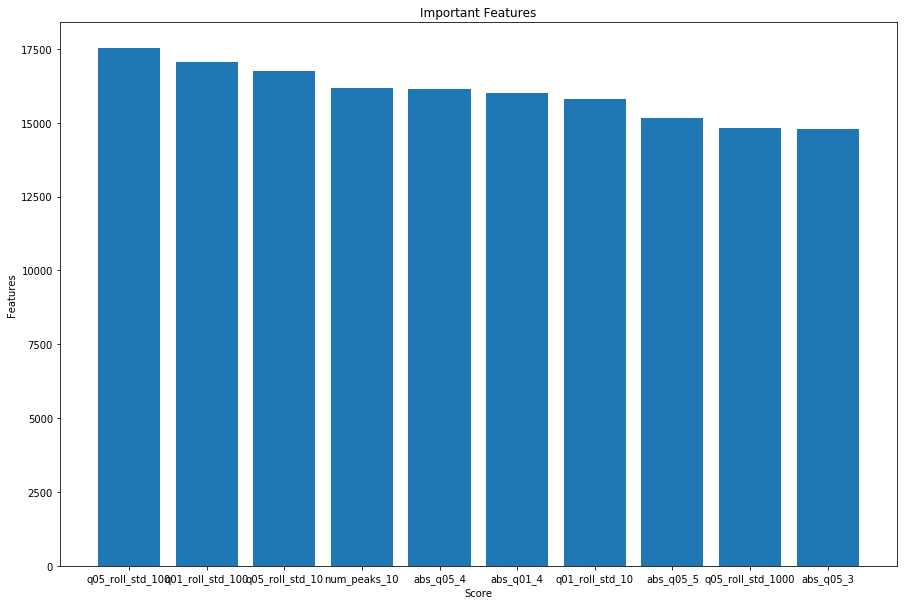

In [34]:
#using sklearns selectkbest
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 10))
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
train_y = pd.read_csv('train_y.csv')
X = X_train_norm 
y = train_y
#  extracting top 10 features
bestfeatures = SelectKBest(score_func=sklearn.feature_selection.f_regression, k=10)
fit = bestfeatures.fit(X,y)
scores_df = pd.DataFrame(fit.scores_)
columns_df = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
topfeatures = pd.concat([columns_df,scores_df],axis=1)
topfeatures.columns = ['features','Score']  

topfeatures=topfeatures.sort_values(by='Score',ascending=False)
print(topfeatures[0:10])

print('----------------------------------------------------------------------------------------------------------------------')
print('----------------------------------------------------------------------------------------------------------------------')
plt.bar(topfeatures.features[0:10],topfeatures.Score[0:10])
plt.ylabel('Features')
plt.title('Important Features')
plt.xlabel('Score')
plt.show()

In [55]:
#considering top 300 features
truncated_train=scaled_train_X[topfeatures[0:300]['features'].tolist()]

In [56]:
truncated_test=scaled_test_X[topfeatures[0:300]['features'].tolist()]

In [62]:
#with feature set 1 and 2
params = {'num_leaves': 21,
         'min_data_in_leaf': 20,
         'objective':'gamma',
         'learning_rate': 0.001,
         'max_depth': 108,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 42}


def lgb_truncated_model():
    maes = []
    rmses = []
    submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'), index_col='seg_id')
    #scaled_train_X = scaled_train_X
    #scaled_test_X = scaled_test_X
    train_y = pd.read_csv('train_y.csv')
    predictions = np.zeros(len(scaled_test_X))

    n_fold = 8
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = truncated_train.columns

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(truncated_train, train_y.values)):
        print('working fold %d' % fold_)
        strLog = "fold {}".format(fold_)
        print(strLog)

        X_tr, X_val = truncated_train.iloc[trn_idx], truncated_train.iloc[val_idx]
        y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params, n_estimators=80000, n_jobs=-1)
        model.fit(X_tr, y_tr,
                  eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                  verbose=1000, early_stopping_rounds=200)

        # predictions
        preds = model.predict(truncated_test, num_iteration=model.best_iteration_)
        predictions += preds / folds.n_splits
        preds = model.predict(X_val, num_iteration=model.best_iteration_)

        # mean absolute error
        mae = mean_absolute_error(y_val, preds)
        print('MAE: %.6f' % mae)
        maes.append(mae)

        # root mean squared error
        rmse = mean_squared_error(y_val, preds)
        print('RMSE: %.6f' % rmse)
        rmses.append(rmse)

        fold_importance_df['importance_%d' % fold_] = model.feature_importances_[:len(truncated_train.columns)]

    print('MAEs', maes)
    print('MAE mean: %.6f' % np.mean(maes))
    print('RMSEs', rmses)
    print('RMSE mean: %.6f' % np.mean(rmses))

    submission.time_to_failure = predictions
    submission.to_csv('submission_lgb_truncated.csv', index=False)
    fold_importance_df.to_csv('fold_imp_lgb_8_80k_108dp.csv') 
    return model

In [63]:
clf7=lgb_truncated_model()

working fold 0
fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.05775	valid_1's l1: 2.08199
[2000]	training's l1: 1.87762	valid_1's l1: 1.93895
[3000]	training's l1: 1.8135	valid_1's l1: 1.89157
[4000]	training's l1: 1.76696	valid_1's l1: 1.85747
[5000]	training's l1: 1.72922	valid_1's l1: 1.8307
[6000]	training's l1: 1.69591	valid_1's l1: 1.80817
[7000]	training's l1: 1.66383	valid_1's l1: 1.78704
[8000]	training's l1: 1.63385	valid_1's l1: 1.76782
[9000]	training's l1: 1.60539	valid_1's l1: 1.74965
[10000]	training's l1: 1.57822	valid_1's l1: 1.73277
[11000]	training's l1: 1.55161	valid_1's l1: 1.71598
[12000]	training's l1: 1.52633	valid_1's l1: 1.70056
[13000]	training's l1: 1.50242	valid_1's l1: 1.68634
[14000]	training's l1: 1.47953	valid_1's l1: 1.67341
[15000]	training's l1: 1.45675	valid_1's l1: 1.66071
[16000]	training's l1: 1.43498	valid_1's l1: 1.64845
[17000]	training's l1: 1.41365	valid_1's l1: 1.63668
[18000]	training's l1: 1.

[70000]	training's l1: 0.734188	valid_1's l1: 1.38107
[71000]	training's l1: 0.726479	valid_1's l1: 1.37812
[72000]	training's l1: 0.718781	valid_1's l1: 1.37504
[73000]	training's l1: 0.711292	valid_1's l1: 1.37208
[74000]	training's l1: 0.704076	valid_1's l1: 1.36943
[75000]	training's l1: 0.696738	valid_1's l1: 1.36665
[76000]	training's l1: 0.689424	valid_1's l1: 1.3637
[77000]	training's l1: 0.682394	valid_1's l1: 1.3609
[78000]	training's l1: 0.675382	valid_1's l1: 1.35814
[79000]	training's l1: 0.668418	valid_1's l1: 1.3554
[80000]	training's l1: 0.661623	valid_1's l1: 1.35268
Did not meet early stopping. Best iteration is:
[80000]	training's l1: 0.661623	valid_1's l1: 1.35268
MAE: 1.352682
RMSE: 3.641151
working fold 2
fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 2.06166	valid_1's l1: 2.05121
[2000]	training's l1: 1.88595	valid_1's l1: 1.91016
[3000]	training's l1: 1.82232	valid_1's l1: 1.86581
[4000]	training's l1: 1.77403	valid_1

[57000]	training's l1: 0.847342	valid_1's l1: 1.40442
[58000]	training's l1: 0.837881	valid_1's l1: 1.40048
[59000]	training's l1: 0.828629	valid_1's l1: 1.39678
[60000]	training's l1: 0.819547	valid_1's l1: 1.39305
[61000]	training's l1: 0.81089	valid_1's l1: 1.38962
[62000]	training's l1: 0.802129	valid_1's l1: 1.38609
[63000]	training's l1: 0.793508	valid_1's l1: 1.38254
[64000]	training's l1: 0.785069	valid_1's l1: 1.37912
[65000]	training's l1: 0.776744	valid_1's l1: 1.37583
[66000]	training's l1: 0.768621	valid_1's l1: 1.37255
[67000]	training's l1: 0.760615	valid_1's l1: 1.36944
[68000]	training's l1: 0.752657	valid_1's l1: 1.36624
[69000]	training's l1: 0.744809	valid_1's l1: 1.36316
[70000]	training's l1: 0.737134	valid_1's l1: 1.36023
[71000]	training's l1: 0.729469	valid_1's l1: 1.35715
[72000]	training's l1: 0.721947	valid_1's l1: 1.35415
[73000]	training's l1: 0.714579	valid_1's l1: 1.35129
[74000]	training's l1: 0.707323	valid_1's l1: 1.34851
[75000]	training's l1: 0.7000

[44000]	training's l1: 0.980834	valid_1's l1: 1.47239
[45000]	training's l1: 0.969161	valid_1's l1: 1.46755
[46000]	training's l1: 0.957939	valid_1's l1: 1.4628
[47000]	training's l1: 0.946793	valid_1's l1: 1.45794
[48000]	training's l1: 0.935887	valid_1's l1: 1.45341
[49000]	training's l1: 0.924835	valid_1's l1: 1.44847
[50000]	training's l1: 0.914095	valid_1's l1: 1.4438
[51000]	training's l1: 0.903699	valid_1's l1: 1.43936
[52000]	training's l1: 0.893359	valid_1's l1: 1.43498
[53000]	training's l1: 0.883289	valid_1's l1: 1.43073
[54000]	training's l1: 0.873404	valid_1's l1: 1.42664
[55000]	training's l1: 0.863488	valid_1's l1: 1.42228
[56000]	training's l1: 0.853801	valid_1's l1: 1.41792
[57000]	training's l1: 0.844401	valid_1's l1: 1.41403
[58000]	training's l1: 0.835164	valid_1's l1: 1.41023
[59000]	training's l1: 0.82572	valid_1's l1: 1.40632
[60000]	training's l1: 0.816687	valid_1's l1: 1.40244
[61000]	training's l1: 0.807614	valid_1's l1: 1.39852
[62000]	training's l1: 0.798913

[30000]	training's l1: 1.17017	valid_1's l1: 1.53899
[31000]	training's l1: 1.15511	valid_1's l1: 1.53229
[32000]	training's l1: 1.13996	valid_1's l1: 1.52547
[33000]	training's l1: 1.12497	valid_1's l1: 1.51876
[34000]	training's l1: 1.11006	valid_1's l1: 1.51188
[35000]	training's l1: 1.09552	valid_1's l1: 1.50491
[36000]	training's l1: 1.08163	valid_1's l1: 1.49845
[37000]	training's l1: 1.06774	valid_1's l1: 1.49204
[38000]	training's l1: 1.05449	valid_1's l1: 1.48625
[39000]	training's l1: 1.04139	valid_1's l1: 1.4806
[40000]	training's l1: 1.02831	valid_1's l1: 1.47498
[41000]	training's l1: 1.01558	valid_1's l1: 1.46973
[42000]	training's l1: 1.00301	valid_1's l1: 1.46444
[43000]	training's l1: 0.990731	valid_1's l1: 1.45917
[44000]	training's l1: 0.978695	valid_1's l1: 1.45396
[45000]	training's l1: 0.967024	valid_1's l1: 1.44896
[46000]	training's l1: 0.955334	valid_1's l1: 1.44391
[47000]	training's l1: 0.943973	valid_1's l1: 1.4389
[48000]	training's l1: 0.932841	valid_1's l

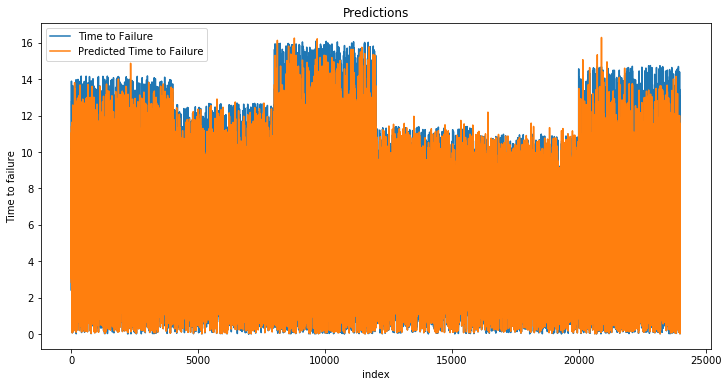

In [69]:
y_predicted=clf7.predict(truncated_train,num_iteration=clf7.best_iteration_)
plot_op(y_predicted)

# XGBOOST

In [56]:

def train_model_xgb( params ):
    X=pd.read_csv('scaled_train_X.csv')
    X_testset=pd.read_csv('scaled_test_X.csv')
    y=pd.read_csv('train_y.csv')
    
    n_fold = 8
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
    
    x_value = np.zeros(len(X))
    prediction = np.zeros(len(X_testset))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (trainset_index, valid_set_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train_per_fold, X_valid_per_fold = X.iloc[trainset_index], X.iloc[valid_set_index]
        y_train_per_fold, y_valid_per_fold = y.iloc[trainset_index], y.iloc[valid_set_index]

        train_data = xgb.DMatrix(data=X_train_per_fold, label=y_train_per_fold, feature_names=X.columns)
        valid_data = xgb.DMatrix(data=X_valid_per_fold, label=y_valid_per_fold, feature_names=X.columns)

        watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
        model = xgb.train(dtrain=train_data, num_boost_round=5000, evals=watchlist, early_stopping_rounds=200, verbose_eval=1000, params=params)
        y_pred_valid = model.predict(xgb.DMatrix(X_valid_per_fold, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        y_pred = model.predict(xgb.DMatrix(X_testset, feature_names=X.columns), ntree_limit=model.best_ntree_limit)

        x_value[valid_set_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid_per_fold, y_pred_valid))

        prediction +=y_pred
        

    prediction /= n_fold
    print('CV mean score: {0:.6f}.'.format(mean_absolute_error(y, x_value)))
    return model,x_value, prediction

In [57]:
xgb_params = {'eta': 0.01,
              'max_depth': 6,             
              'colsample_bytree': 0.9,
              'lambda': 0.1,
              'alpha' : 0.1,
              'objective': 'reg:gamma',
              'eval_metric': 'mae',
              'silent': True, 'nthread':24}
model, x_value_xgb, prediction_xgb = train_model_xgb(params=xgb_params)

Fold 0 started at Thu May 23 08:23:57 2019
[0]	train-mae:5.29924	valid_data-mae:5.32894
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[1000]	train-mae:1.42448	valid_data-mae:1.62287
[2000]	train-mae:1.08254	valid_data-mae:1.43141
[3000]	train-mae:0.848488	valid_data-mae:1.32051
[4000]	train-mae:0.659158	valid_data-mae:1.24103
[4999]	train-mae:0.515176	valid_data-mae:1.18027
Fold 1 started at Thu May 23 08:35:31 2019
[0]	train-mae:5.29436	valid_data-mae:5.36295
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[1000]	train-mae:1.41414	valid_data-mae:1.66726
[2000]	train-mae:1.06056	valid_data-mae:1.48275
[3000]	train-mae:0.818918	valid_data-mae:1.36782
[4000]	train-mae:0.645748	valid_data-mae:1.29328
[4999]	train-mae:0.516639	valid_data-mae:1.2463
Fold 2 started at Thu May 23 08

In [69]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_xgb
submission.to_csv('xgboost5000unsavedmodel.csv')

## Conclusion

Objective:To predict the time remaining before laboratory earthquakes occur from real-time seismic data.

1. We are given a dataset with  629145480 rows and 2 columns: acoustic_data, time_to_failure, where time_to_failure is the time remaining for next earthquake.
<br>
2. We visualize the train and test data to get the pattern and observer that there is a spike in siesmic data before earthquake occurs and there are a total of 16 earthquakes in train data.
<br>
3. We divide the data into 6 slice and take 4000 random samples from each slice and get 24000 training data rows. We use multiprocessing to reduce the time taken to run.
<br>
4. We then featurize the data using simple statistical features like mean,std,moving averages etc and also signal processing features like fft, peaks, hjorth parameters.
<br>
5. I tried hyperparameter tuning with gridsearchcv and the performance reduced,we can also see by results that CV is not reliable, hence i used the default values. 
<br>
6. We Apply various machine learning models, we use 8 fold cv \and compare the cross validation result and plot the corresponding feature importances.
<br>
7. Since not all features contribute to the model, we use feature selection to get the top features.
<br>
8. We use sklearns selectkbest to find the top 300 features and then apply models on it and compare them, the score went down slightly.
<br>

In [1]:
from prettytable import PrettyTable

x=PrettyTable()

x.field_names=['Feature Selection','Feature set','Algorithm','CV MAE','TEST MAE']
x.add_row([" - ",'Feature set1',"XGB",1.209,1.362])
x.add_row([" - ",'Feature set1',"LGBM",1.218,1.340])
x.add_row([" selectkbest ",'Feature set1+2',"LGBM", 1.325,1.455])
x.add_row(["-",'Feature set1+2',"LGBM",1.199,3.51])

print(x)

+-------------------+----------------+-----------+--------+----------+
| Feature Selection |  Feature set   | Algorithm | CV MAE | TEST MAE |
+-------------------+----------------+-----------+--------+----------+
|         -         |  Feature set1  |    XGB    | 1.209  |  1.362   |
|         -         |  Feature set1  |    LGBM   | 1.218  |   1.34   |
|    selectkbest    | Feature set1+2 |    LGBM   | 1.325  |  1.455   |
|         -         | Feature set1+2 |    LGBM   | 1.199  |   3.51   |
+-------------------+----------------+-----------+--------+----------+


We can see that cv might not be reliable

LGBM gives the highest score of 1.340 which is currently at the 37th position at the kaggle public leaderboard.